In [2]:
import sys
import base64

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import skimage.data

from myst_nb import glue
from IPython.display import Markdown, HTML
from bs4 import BeautifulSoup

(sec:request)=

# HTTPリクエスト


ウェブ上でデータのやりとりをするためには**プロトコル**と呼ばれるデータのやりとりの仕方を定めた規約に従う必要がある。

広義のコンピュータ・ネットワークに用いられるプロトコルは**TCP/IP**と呼ばれ、そのプロトコルにはネットワーク層、トランスポート層、アプリケーション層など、いくつかのレイヤーが存在する。

本項であつかうHTTP (hyper text transfer protocol)はアプリケーション層に属するプロトコルの一種で、HTMLで記述された文書をウェブ上でやりとりするためのプロトコルである。

皆さんが、Google ChromeやFirefox等のブラウザを使ってウェブページを閲覧しているときには、このHTTPに乗っ取ったデータのやりとりが行われている。


## TCP/IPの基本の基本

前述の通り、HTTPはTCP/IPというインターネットの仕組みを定めた規格に属する**プロトコル**の一種である。TCP/IPには、ネットワーク通信を行なうためのハードウェアからソフトウェアまでが幅広く定義されており、物理層、インターフェース層、ネットワーク層、トランスポート層、アプリケーション層などのレイヤーから成る。

**物理層**は、名前の通り、物理的なハードウェアに関する「規格」ということになるのだが、コンピュータ同士の接続に用いるのはイーサネットのようなケーブルの他、ワイヤレス通信など通信ができるものでさえあれば良く、この物理層に関しては、特にTCP/IPは特別な定めを置いていない {cite}`takeshita2012tcpip`。

**インターフェース層**は物理層に相当するハードウェアをコンピュータ上で動作させるためのドライバのような役割を持つ。コンピュータをパーツから自作する場合には、多くの場合、マザーボードにドライバ・インストール用のメディアが同梱されており、イーサネットや無線通信を用いてネットワークに接続するには、これらのドライバを始めにインストールする必要がある。

**ネットワーク層**はコンピュータとコンピュータの接続、それ自体に関する規格で、IP (Internet Protocol)などがそれに対応する。IPあるいはIPアドレスというのは個別のコンピュータに追跡可能な形でアドレスを割り振るための仕組みで、これにより、離れたコンピュータを間違えることなく、接続や通信が行える。

**トランスポート層**はデータ転送に関する低レベルな規格であり、TCP (Transmission Control Protocol)やUDP (User Datagram Protocol)などのプロトコルがそれに対応する。普段、我々が使っているインターネット通信は、転送するデータの種類に応じて、TCPとUDPを切り替えて使っている。

**TCP**は、データを劣化や欠損なく確実に相手に届けるためのプロトコルで、2台以上のコンピュータ間に接続を確立した上で、データの断片であるパケットを転送するごとに、そのデータが相手に正しく届いているかを確認する。そのため、文字列のような、データに欠損があると意味が変わってしまうようなものを転送するのに用いられる。

**UDP**は「コネクションレス」通信の一種であり、相手との通信を確立せずに、パケットをネットワーク上に転送していく。転送されたデータは転送先のIPアドレスを頼りに相手に届くが、コンピュータ間で互いにデータ転送の成否を確認することはしない。UDPは多少データが欠損しても意味が変わらないような映像や音声などのデータを転送するのに用いられる。

**アプリケーション層**はコンピュータ間の通信やデータの転送を伴うアプリケーションプログラムを差し、HTTP (Hyper Text Transfer Protocol)やFTP (File Transfer Protocol), SMTP (Send Mail Transfer Protocol)などアプリケーションごとに独自のプロトコルを用いる。

以上のように、一見、何気なく行なわれているように見えるインターネット通信も、プロトコルという形で様々なルールの上に確立されていることは心に留めておいてほしい。

:::{admonition} TCP/IPの基本の基本
:class: note

- インターネット通信はTCP/IPと呼ばれる規格に基づいて行なわれている
- TCP/IPには物理層、インターフェイス層、ネットワーク層、トランスポート層、アプリケーション層などのいくつかのレイヤーが存在する
- トランスポート層に属するTCPとUDPは、データの欠損や消失を許容できるデータかどうかで切り替えて使われる
- HTTPやFTPなどの(多少は)耳なじみのあるプロトコルのほとんどはアプリケーション層に属する
:::

## リクエストとレスポンス

HTTP通信は**クライアント** (ウェブページを閲覧する側のコンピュータ)から送信された**リクエスト**に対して、**サーバ** (ウェブページを配信する側のコンピュータ)が**レスポンス**と呼ばれる応答を返す、という処理によって行われている。

リクエストとレスポンスでやりとりされるデータには**ヘッダ**と呼ばれる情報が付与されており、実際にやりとりされるデータの本体 (ウェブページの場合にはHTMLファイル)に対する付加的な情報を与える。

リクエストとレスポンスに対応するヘッダの内容はプログラムを書かずとも、ウェブブラウザで確認することができる。まずはGoogle Chromeを使って、これらのヘッダの中身を確認してみよう。

まずはウェブブラウザを開き、[Google のトップページ](https://www.google.co.jp)にアクセスする。ウェブページが開いたら、画面左上の「︙」ボタンをクリックして、設定メニューを開く。この設定メニューの中から「その他のツール」にある「ディベロッパーツール」を開こう。


```{image} ./imgs/check_http.jpg
:align: center
:width: 60%
:class: with-border
```


ディベロッパーツールが開いたら、いくつかある項目の七から「Network」を選び、ページをリロードしよう。すると、ディベロッパーツールに以下のような情報が表示されるはずだ。


```{image} ./imgs/check_http_2.jpg
:align: center
:width: 60%
:class: with-border
```


この情報をよく見てみると、「Name」のリストの先頭に「`www.google.co.jp`」という項目があるので、これをクリックする。すると、その右側にどのようなリクエストが送られて、どのようなレスポンスが返ってきているのかが表示される。これらはそれぞれ、ディベロッパーツールの中で「Request Headers」という項目と「Response Headers」という項目から確認できる。

これらのヘッダ情報には、非常に多くの情報が含まれているが、リクエストヘッダであれば、ウェブページのURLやページを取得する方法 (GETとPOST があるが、詳細は後述する)などが含まれており、レスポンスヘッダであれば、アクセス日時やサーバー側が配信したファイルがどのようなエンコーディングを持つかなどの情報が含まれている。

HTTP通信は、これらのヘッダの情報を決まったやり方で送受信すれば実現できるため、低レベルには、本講義の後半であつかうソケット通信を用いたネットワーク・プログラミングで実現できる。

:::{admonition} リクエストとレスポンス
:class: note

- HTTP通信を行なう際には、一定のフォーマットに基づいたリクエストとレスポンスをやり取りする。
- リクエストとレスポンスのそれぞれはヘッダとボディの情報から成る。
- ヘッダには、データのやり取りの方法や、データの種類などのメタ情報が含まれる
- ボディはやり取りされるデータ、それ自体を含む
:::

## urllibによるウェブページの取得



ソケット通信などを用いた低レベルのプログラミングは、開発コストや思わぬ誤りを起こす危険性があるので、多くのプログラミング言語には、より高レベルなライブラリが用意されていることが多い。Pythonでは`urllib`がそれに対応する。

高レベルなライブラリとして、サードバーティ製の`requests`があり、実開発の用途ではこちらを使うことが多いが、本項では、`urllib`を用いた基本的なHTTP通信のやり方について解説する。

まずは、`urllib`の基本関数である`urlopen`を用いて、ウェブページの内容を取得してみよう。`urlopen`はURLを指定するだけで、その URLにHTTPリクエストを送付して、応答を得ることができる。

In [3]:
import urllib
import urllib.request
import urllib.parse
import urllib.error

# ウェブページのURL
url = "https://www.google.co.jp/"

# URLにリクエストを送付し、レスポンスを受け取る。
resp = urllib.request.urlopen(url)

`urlopen`の戻り値は[`HTTPResponse`](https://docs.python.org/ja/3/library/http.client.html#httpresponse-objects)という型で与えられ、アクセスの可否を表すステータスコード等を取得できる。

[ステータスコード](https://developer.mozilla.org/ja/docs/Web/HTTP/Status)には非常に多くの種類があるが、アクセスに成功すれば200、アクセスが拒否されれば403、ページが見つからなければ404、サーバ側でエラーが生じている場合には500などの代表例だけでも覚えておくと良い。

なお、ステータスコードは大まかに言って200番台が通信成功、300番台が転送要求 (他のURLへのリダイレクトなど)、400番台がクライエントからの要求エラー (URLが間違っているなど)、500番台がサーバー側のエラーを表す。

今回は、正しいGoogleのトップページのURLを与えているので、ステータスコードとして`200`が返ってくる。

In [4]:
# ステータスコードの確認
print(f"Status Code: {resp.status:d}")

Status Code: 200


ステータスコードが 200 で正しくウェブページの内容を受信できたら、次に受信したレスポンスヘッダの内容を確認しよう。

レスポンスヘッダの内容は`resp.headers`で確認できる。`resp.headers`は辞書型と同様に`resp.headers.items()`を用いてアクセスできるほか、`resp.getheaders()`でも同様の辞書を取り出せる。

実際に取得できたレスポンスヘッダは以下のような情報を含んでいる。

In [5]:
df = pd.DataFrame(resp.getheaders())
s = df.iloc[:5, :].style.set_properties(**{"text-align": "left"})
s = s.hide(axis="index")
s = s.hide(axis="columns")
HTML(s.to_html())

Date,"Wed, 24 Apr 2024 08:01:25 GMT"
Expires,-1
Cache-Control,"private, max-age=0"
Content-Type,text/html; charset=Shift_JIS
Content-Security-Policy-Report-Only,object-src 'none';base-uri 'self';script-src 'nonce-4bfy1JrwM_Ak6clwMPFAQA' 'strict-dynamic' 'report-sample' 'unsafe-eval' 'unsafe-inline' https: http:;report-uri https://csp.withgoogle.com/csp/gws/other-hp


上記のレスポンス・ヘッダ中で`Content-Type`の項目を見ると、取得したファイルが`text/html`、すなわち HTMLファイルであり、Shift-JISでエンコーディングされていることが分かる。

ファイルの種類が分かったら、次に取得したファイルの内容を見てみよう。ファイル内容は`resp.read()`により取得できる。ただし、ファイルの内容はバイト文字として受け取られるため、ファイルのエンコーディングがShift-JISとしてバイト文字列をデコードする。

In [6]:
body = resp.read().decode("shift-jis")

読み取ったファイルは次のようになっている (先頭から一部だけを表示している)。

In [7]:
import re

tree = BeautifulSoup(body)
lines = re.split("[\n\r]{1,2}", tree.prettify())
Markdown("```html\n" + "\n".join(lines[:10]) + "\n```")

```html
<!DOCTYPE html>
<html itemscope="" itemtype="http://schema.org/WebPage" lang="ja">
 <head>
  <meta content="世界中のあらゆる情報を検索するためのツールを提供しています。さまざまな検索機能を活用して、お探しの情報を見つけてください。" name="description"/>
  <meta content="noodp, " name="robots"/>
  <meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
  <meta content="/images/branding/googleg/1x/googleg_standard_color_128dp.png" itemprop="image"/>
  <title>
   Google
  </title>
```

一通り、取得した情報に対する処理が終了したら、`resp.close()`を呼び出して HTTP 接続を切断する。


In [8]:
resp.close()

なお、上記のコードはファイル入出力を扱う`open`関数などと同様に`with`文を用いて HTTP 接続の開閉を自動化することができる。


In [9]:
with urllib.request.urlopen(url) as resp:
    body = resp.read().decode("shift-jis")

:::{admonition} urllibによるウェブページの取得
:class: note

- 単純なウェブページの取得には`urlopen`を用いる
- ステータスコードを見て、通信が成功しているかを予め確認する
- ウェブページの本体はバイト列なので、レスポンスヘッダの内容に従ってデコードする
:::

## リクエスト・ヘッダの編集

これまでの例では`urlopen`を用いて単純にウェブページを開いていたが、前述の通り、実際のHTTP通信ではリクエストとレスポンスに対応するヘッダ情報を送受信している。

`urlopen`はURLを表す文字列以外にも、リクエスト・ヘッダの情報を含む`Request`型のオブジェクトを受け取ることができる。以下の例を見てほしい。

In [10]:
url = "https://www.google.co.jp"
headers = {}  # 今回はヘッダは空で良い

req = urllib.request.Request(url, headers=headers)
with urllib.request.urlopen(req) as resp:
    print("URL :", resp.geturl())
    print("Code :", resp.getcode())
    print("Content-Type :", resp.info()["content-type"])
    body = resp.read()

URL : https://www.google.co.jp
Code : 200
Content-Type : text/html; charset=Shift_JIS


この例は`urlopen`で単純にURLを開く方法と同様に、特別にリクエスト・ヘッダの情報を与えていない。最低限必要なヘッダの情報は`urlopen`によって作成されるため、空のヘッダを指定するだけでもHTTP通信自体は成立している。

しかし、どのような情報を受け取りたいのかをリクエスト・ヘッダに記載すると、実際に受け取るデータがリクエスト・ヘッダの内容に基づいて最適化される「場合がある」(サーバ側がそのような最適化に対応している場合に限る)。

一例として、Googleのトップページに対して、自身のブラウザ情報 (`User-Agent`)、受け取りたい文字エンコーディング (`Accept-Charset`)、受け取りたい言語 (`Accept-Language`)を指定してアクセスしてみる。

In [11]:
url = "https://www.google.co.jp"

headers = {
    "User-Agent": "Mozilla/5.0",
    "Accept-Charset": "utf-8",
    "Accept-Language": "ja",
}

req = urllib.request.Request(url, headers=headers)
with urllib.request.urlopen(req) as reso:
    print("URL :", resp.geturl())
    print("Code :", resp.getcode())
    print("Content-Type :", resp.info()["content-type"])
    body = resp.read()

URL : https://www.google.co.jp
Code : 200
Content-Type : text/html; charset=Shift_JIS


すると、受け取るファイルの内容自体には変化はないものの、先ほどまでShift-JISでエンコーディングされていたファイルがUTF-8によるエンコーディングに変化していることが分かる。

このように(過信は禁物だが)リクエスト・ヘッダの内容を編集することで、ある程度、クライアント側で処理しやすいデータを受け取ることができるので覚えてくと良い。

## GETメソッドとPOSTメソッド

HTTP通信によりデータをリクエストする際に、HTTPのプロトコルで扱う情報とは別に、サーバ上のアプリケーションで用いる付加情報を付与することができる。

例えば、Googleの検索では

<https://www.google.com/search?q=Python&hl=ja>

のように、検索する文字列 (この例では`q=Python`)と検索に用いる言語 (この例では`hl=ja`)を指定することができる。

これらのパラメータは当然ながらHTTPのプロトコルで定義されている変数ではなく、検索エンジンという「アプリケーション」が利用する変数なので、リクエスト・ヘッダとは別に情報を与えている。このようなメタデータをリクエスト時に送信する方式には、いくつかの方式があり、その代表的なものが**GETメソッド**と**POSTメソッド**である。

### GETメソッド

**GETメソッド**は、付加的なデータを送信するために、URLの末尾に`http://example.com?key1=value1&key2=value2`のような形でパラメータを与える。

GETメソッドのメリットとして、パラメータがURLの一部になっているので、このURL全体を共有すれば**おおよそ同じ結果を他のユーザに共有できる**という点が上げられる (結果がクッキーなどに依存することもあるので、全く同じとは限らない)。

このURL以降に現れるパラメータは、自身で作成しても構わないが、`urllib.parse.urlencode`関数を用いるとより簡単に作成ができる。

In [12]:
url = "https://www.google.com/search"

headers = {
    "User-Agent": "Mozilla/5.0",
    "Accept-Charset": "utf-8",
    "Accept-Language": "ja",
}

data = {"hl": "ja", "q": "Python"}

url += "?" + urllib.parse.urlencode(data)
req = urllib.request.Request(url, headers=headers, method="GET")
with urllib.request.urlopen(req) as resp:
    print("URL :", resp.geturl())
    print("Code :", resp.getcode())
    print("Content-Type :", resp.info()["content-type"])
    body = resp.read()

URL : https://www.google.com/search?hl=ja&q=Python
Code : 200
Content-Type : text/html; charset=UTF-8


このようにレスポンス・ヘッダを見ると、アクセス先のURLに正しくパラメータが与えられていることが分かる。また、以下の通り、得られたウェブページの内容を確認してみると、確かに検索キーワードを「Python」として検索できている。

In [13]:
tree = BeautifulSoup(body.decode("utf-8"))
lines = re.split("[\n\r]{1,2}", tree.prettify())
Markdown("```html\n" + "\n".join(lines[:8]) + "\n```")

```html
<!DOCTYPE html>
<html lang="ja">
 <head>
  <meta charset="utf-8"/>
  <meta content="/images/branding/googleg/1x/googleg_standard_color_128dp.png" itemprop="image"/>
  <title>
   Python - Google 検索
  </title>
```

前述の例は検索キーワードが英語であったため、単純に辞書型の変数に対して、

```python
params = ""
for k, v in data.items():
  params += f"{k}={v}&"

params = params[:-1]  # 最後の&を取り除く
```

のようにすれば十分である。しかし、日本語の場合はどうであろうか？実際にURLをパラメータを含めて`https://www.google.co.jp?hl=ha&q=プログラミング`としてHTTP通信を試してみよう。

In [14]:
url = "https://www.google.co.jp/search?hl=ja&q=プログラミング"

headers = {
    "User-Agent": "Mozilla/5.0",
    "Accept-Charset": "utf-8",
    "Accept-Language": "ja",
}

req = urllib.request.Request(url, headers=headers, method="GET")
try:
    resp = urllib.request.urlopen(req)
    print("URL :", resp.geturl())
    print("Code :", resp.getcode())
    print("Content-Type :", resp.info()["content-type"])
    body = resp.read()
except Exception as e:
    print(type(e).__name__, ":", e)
finally:
    resp.close()

UnicodeEncodeError : 'ascii' codec can't encode characters in position 20-26: ordinal not in range(128)


このように直接、日本語をURLに含めようとすると例外が発生することが分かる。

URLに日本語を含めるには、**URLエンコード**と呼ばれる仕組みを利用する必要がある。URLエンコードはマルチバイト文字を何らかのエンコーディング方式 (Shift-JISやUTF-8)を用いてバイトに置き換えた後、各16進数の数字を`0xAC`から`%AC`のように`%`を用いて書き換えたものである。

例えば、「プログラミング」という文字列をUTF-8でエンコードして、上記の方法でURLエンコードするなら、以下のようなプログラムを書けば良い。

In [15]:
text = "プログラミング"
byt = text.encode("utf-8")
enc = ""
for b in byt:
    enc += hex(b).replace("0x", "%")

print(f"{text:s} => {enc:s}")

プログラミング => %e3%83%97%e3%83%ad%e3%82%b0%e3%83%a9%e3%83%9f%e3%83%b3%e3%82%b0


このようにURLエンコードをした文字列をGETメソッドのパラメータに加えて再度リクエストを送付してみる。

In [16]:
url = "https://www.google.co.jp/search?hl=ja&q=" + enc

headers = {
    "User-Agent": "Mozilla/5.0",
    "Accept-Charset": "utf-8",
    "Accept-Language": "ja",
}

req = urllib.request.Request(url, headers=headers, method="GET")
try:
    with urllib.request.urlopen(req) as resp:
        print("URL :", resp.geturl())
        print("Code :", resp.getcode())
        print("Content-Type :", resp.info()["content-type"])
        body = resp.read()
except urllib.error.HTTPError as e:
    print(e)

URL : https://www.google.co.jp/search?hl=ja&q=%e3%83%97%e3%83%ad%e3%82%b0%e3%83%a9%e3%83%9f%e3%83%b3%e3%82%b0
Code : 200
Content-Type : text/html; charset=UTF-8


In [17]:
tree = BeautifulSoup(body.decode("utf-8"))
lines = re.split("[\n\r]{1,2}", tree.prettify())
Markdown("```html\n" + "\n".join(lines[:8]) + "\n```")

```html
<!DOCTYPE html>
<html lang="ja">
 <head>
  <meta charset="utf-8"/>
  <meta content="/images/branding/googleg/1x/googleg_standard_color_128dp.png" itemprop="image"/>
  <title>
   プログラミング - Google 検索
  </title>
```

すると、上記のように正しく日本語の文字がパラメータとして送付されたことが確認できる。実際には`urllib.parse.quote`関数を用いて、

```python
urllib.parse.quote("プログラム")
```

とすると同様の結果を得ることができるが、上記のURLエンコードの仕組みについては、ぜひ知っておいてほしい。

In [18]:
urllib.parse.quote("プログラミング")

'%E3%83%97%E3%83%AD%E3%82%B0%E3%83%A9%E3%83%9F%E3%83%B3%E3%82%B0'

### POSTメソッド

**POSTメソッド**は、何らかの情報をクライアント側から送付し、サーバ側の状態を書き換える際に用いる (画像のアップロードや、ユーザ名、パスワード名の送付など)。POSTメソッドは、画像のような容量の大きなデータであったり、パスワードのようにURLにそのまま含まれるとセキュリティ的に問題があるようなデータを送付するのに用いられる。

POSTメソッドはサーバの状態を書き換えるため、一般的に公開されているウェブサービスで、認証などを経ずに使うことはそもそも難しい。そこで、以下では、POSTメソッドのテストを行うために [httpbin](https://httpbin.org/) というウェブサイトを用いる。

このサイトは、リクエストに対して、ページごとに異なるレスポンスを返すように作られており、中でも <https://httpbin.org/anything> は、リクエスト・ヘッダに含まれる情報をそのまま送信元に返送する、という処理を行なってくれる。

httpbinの挙動を理解するために、まずは、ユーザ名を`user=myname`、パスワードを`passwd=mypass`としてPOSTメソッドでリクエストを送信してみよう。このように複数のパラメータをPOSTメソッドで送付する場合には、辞書型でデータを用意しておき `urllib.parse.urlencode`関数を用いて、送付用のデータを作成する。ただし、送付するデータはバイナリ形式でないと行けないので、以下の例ではUTF-8でエンコーディングしてバイト化している。

In [19]:
url = "https://httpbin.org/anything"

headers = {
    "User-Agent": "Mozilla/5.0",
    "Accept-Charset": "utf-8",
    "Accept-Language": "ja",
}

data_dict = {
    "user": "user",
    "passwd": "passwd",
}
data = urllib.parse.urlencode(data_dict).encode("utf-8")

req = urllib.request.Request(url, data, headers=headers, method="POST")
try:
    with urllib.request.urlopen(req) as resp:
        print("URL :", resp.geturl())
        print("Code :", resp.getcode())
        print("Content-Type :", resp.info()["content-type"])
        body = resp.read()
except urllib.error.HTTPError as e:
    print(e)

URL : https://httpbin.org/anything
Code : 200
Content-Type : application/json


通信が成功すると、サーバからはJSON形式のファイルが返送されるので、Pythonの標準ライブラリである`json`を使ってファイル内容を成形しておく。

In [20]:
import json

json_data = json.loads(body.decode("utf-8"))

In [21]:
Markdown(
    f"""
```json
{json.dumps(json_data, indent=2):s}
```
"""
)


```json
{
  "args": {},
  "data": "",
  "files": {},
  "form": {
    "passwd": "passwd",
    "user": "user"
  },
  "headers": {
    "Accept-Charset": "utf-8",
    "Accept-Encoding": "identity",
    "Accept-Language": "ja",
    "Content-Length": "23",
    "Content-Type": "application/x-www-form-urlencoded",
    "Host": "httpbin.org",
    "User-Agent": "Mozilla/5.0",
    "X-Amzn-Trace-Id": "Root=1-6628bc58-755e73d8028a93db1c99ffea"
  },
  "json": null,
  "method": "POST",
  "origin": "133.46.232.29",
  "url": "https://httpbin.org/anything"
}
```


上記、レスポンス・ボディであるJSONファイルの内容を見てみると、`form`の項目の中に送信した`user`と`passwd`のパラメータが含まれており、(httpbinの挙動を信用するなら)正しくPOSTメソッドでデータが送信できていることが確認できる。

(ssec:send-binary)=
### バイナリファイルの送信

GETデータはURLに情報を含める都合上、遅れるデータ量の上限が決まっている。例えば、2024年4月現在、Google Chromeが受け付けるURLの長さは2MBまでとなっている。従って、2MBを超えるような画像などのバイナリデータをGETメソッドで送信することはできない。

一方、POSTメソッドを用いると、データとして画像などの大容量データも送信もパラメータとしてできる。なお、ここでGETメソッドやPOSTメソッドで送信しようとしているものは、サーバ上のアプリケーションが用いるパラメータであり、レスポンス・ボディに含まれるデータは大きなもであっても問題ない。

では早速、以下の猫の画像をサーバに送信してみよう。

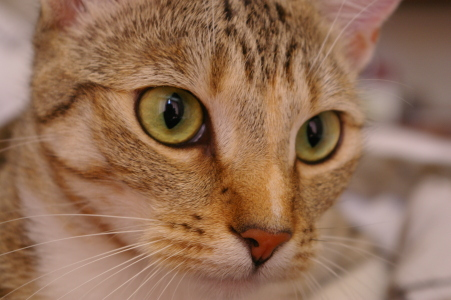

In [22]:
from io import BytesIO
from PIL import Image

image = skimage.data.cat()
image = Image.fromarray(image)
glue("cat", image)

<div align="center" class="mb-4 w-1/2">

```{glue:} cat
```

</div>

バイナリファイルを送付する場合、先ほどまで`urllib.parse.urlencode`で取得していた送信データの情報を、画像ファイルから得られるバイト列の情報に置き換える。画像ファイルからバイト列を得るプログラムは以下の通り。

```python
# 画像をバイト列として読み込む
with open("cat.jpg", "rb") as f:
    data = f.read()
```

In [23]:
buffer = BytesIO()
image.save(buffer, format="PNG")
data = buffer.getvalue()

次にリクエスト・ヘッダに渡す`Content-Type`を送付するPNG画像に合わせて`image/png`に変更する。

In [24]:
headers = {
    "User-Agent": "Mozilla/5.0",
    "Content-Type": "image/png",
}

あとは、これまで通り、POSTメソッドを用いてリクエスト・ヘッダを指定した上で、PNG画像のバイナリデータを含む`data`を送信する。

In [25]:
url = "https://httpbin.org/anything"

req = urllib.request.Request(url, data, headers=headers, method="POST")
try:
    with urllib.request.urlopen(req) as resp:
        print("URL :", resp.geturl())
        print("Code :", resp.getcode())
        print("Content-Type :", resp.info()["content-type"])
        body = resp.read()
except urllib.error.HTTPError as e:
    print(e)

URL : https://httpbin.org/anything
Code : 200
Content-Type : application/json


すると、サーバから返送されてくるJSON形式のデータは以下のようになる。

In [26]:
json_data = json.loads(body.decode("utf-8"))
Markdown(
    f"""
```json
{json.dumps(json_data, indent=2):s}
```
"""
)


```json
{
  "args": {},
  "data": "data:application/octet-stream;base64,iVBORw0KGgoAAAANSUhEUgAAAcMAAAEsCAIAAAAw9k/eAAEAAElEQVR4nGT96XIkWZIljOlyFzPzBVsEIiL3rKV7pqc5PTKf8J34CHwLPhjl+0h+0uypqa7urqrMjA2rb2Z2F1Xlj2uOyBpCQiAAAnA3M3c79+jRc/Ti/+P//n8DAFWFX30QESIiIoAi4q++BSIHAISu/ZqZETEAIEL7hfbRvlYwAVNVM2AFADMRkQQmbDqEEAMxUgUtpdRcpFQ0QRFUsVqKmqqimpRqUkxAEEo1dOxccI7yNM9zBiCt4lxox6lkoOqBtNTj8TjPs4D5rmejWhWD21xc3H7zje87HztDYHBVstaiqoKoAj6wc66LjMAAUKuWNBORWq21IjCSiVUzY4qIXMXGcXSM3vOwCl0MT09Pv/z1p93TbjOsXr26WQ0Dd2RmwzA450RVREop8zybWQgBFA0kRq8qVhUAKDoRCc6zwyJzLnN0nRk+Pu/2Twd2dnvzqljKU/bUlVJc4OPxOI7jcX8Cz1JtmiZVHTb9b3/7Y1F5+Pzp9s2rw27fxe1ff3r/88c7Zg4eomfH4e3tGx9wHOdDSn03rFfdh59+fvfuTYzx5/e/XFxfeMb2Go1TmWu5vn6FiHlORe3h/v7br79ZD12qk6o6F5h8nvLhNO+O01fffMsdv7q+fH7ef/744WIz3N7eBu/VaHNxk3OeplMI7vl4QrOrzXr/+HyYDqfjwUwOx+nzYf50fzR0nvHVRfztD99+983XjDiV2Tv36uoKDUVMjT98uv/w4YPBPMRhf5w+3u+exnE/ziVV51z0iGa9D1eb4c3b1fF4fNwXRHZcv7l9vYp9rXp3On2+e1gF5wxXgTvv4tB1q1isrjbb9bABtZSmNE3GtFptKpbOh5X3tWoGiP0qsDMzUJBaUj6YlCKiqiBgZmmaDcQhipahi33fIzsi4uBDCMysqrlIzqWImHGI0QxrFlUNjogIgUW0mCIykiNyAkbIDIyIjI6Zl7tAlYjIMREhe0QEQmaPBgBoaCYKAAwIzjnnyAfJJeeqtR2wmlYTbXcssgMArQVUTZGJgIyIGg6oCKqZoUkVq4Bm2O5ERkQfAxGZgORSS7IqaAAAZmZmgGoCqkpKYGJmCgIAikZEyExEgiCmc0nHadyfjvfPz4/H/eE0TnnSUlUFDQ0BkUUKEZkIIioYIiqimTVkIkNVJWAAMGzPgghsZmbL7wNUAEAAVW23PxCq6gu4ISKoAYAjAIBiC3I6ZjazdmIvOGjWHnQBxJdv29dE1L5QMCQ0BDMjRDgDKZ2/QgNABEBUVTUzNSm1VpUUiFRJ1bVnADWtZlXEKoqAZKtihkxkSIgmWggYwAAEgFQ15wIAAFqron05MADz3hOgibJzPgSQKiJMFGMcy7Tf74fjvkdQMB8De+9DXwVNUcFqPa8qiI6dghEgiRcRRHaeEdHMpFYzBADnHBNa1FzmnLMP7EguLjb4zVddiDnnWmu7ss65nDMRtc/Ok05VRDywqrU3pIGoKjOrVUArpSA5RAYjVTCD9kbPU05VVHXOtWJWVSHIoojMPuwOhxBCrWJmzNz3q3w49H2PIJtVd5zyw9NOzURgf5q/efs2dgqax1nFrGfsA//yywdD9v2w2+1evboNwYmUqrIaNvO0Q7OadbNZX26vfvrl58vLrWeLkTkM6/XWzMpcDqfj7rTbj+WHrv/q3e3pOP78y93n+6dufclhkyTXLBfMCDQMgyd2a3bEJZ00pzSOHqiLvWQeT0fDkHIVNqAuxhggTPvxeTq8fn1DhmSmpFoLUr686ldhk1I+naZhGCa1h+dpLBKQCwqBCNSugtWhd93Ku2lMxigZCs/O+U0fp76rJc9a+7A61LnO1UBc8E4BVNr6l4pIqiqjaoUB/ApVa1VzhOA7QjRk1VprJjDnnKqyY1V1jEREIKoaggshmGGDLclFWFS1ZCm5GAIY5pTAyAzNzvcrmBGQESKRQwQiAEQCMEQwaG/dRnnQEAAIgMgIAVXBQA3QTA1tgVQAMENkEFUFRmJPqmootYJZ0aJmhrWAERoiOkA0NaQGhNYgStFggQNSVREhIvbBOQeI7aaHIioAhmC6wCiAioGZKYrIAq4miEgOHRE6h4hqqqKNeexOp/3peJrGKU+1VjUlWM60IQAiGpEBIHMDLlN9ATciQgQzQ8AX3DMEQERrcLf8nIgQqJ0iI9kXlghnbARZLjsQoiP2Zoagy/pwPkMARaQzgBIAIdLLo/z6CwADsHYEL1T0/B/LgyGioplaNa2mZloNqinX3E5bVVWrmeWcSdVSBjUicoGNyIjIOTJiEUDKpQKRkZ1XQoEFj0FEgMlxAABzRo5ZuIhCNeqo6zpFndK8f352wbcD9hxi9CEOACBIOdVSCqgiMiIakJgYECAQKTMbCAAC+lKknVoI5F03jlBKqbUmsBD9MAxffRNOh+M4jilPGCMCtPUQkVOag2dQLSUzEyObaRUjAiJTFSkAACVVwIE9mJmqihgiOudKTdM0dZs+70/HdPTseg4AoApgWEqJMbJ3zBxCUNWaR1Cbp6yCKZXjeEpKqUylFGXcbtdIOB+qqr69vr57uH982n/7/XfjOCLaer3uY/f4eL8ZNp8eH9mFV+ttjPHrt2/+4y9/NgXvu6uLSzNJqbx63Zvhbv+plIIIt6+vbt9cDcPwx3/90/PzfuhWt7evTesQmIJzbNBRKdL1wXlTkcNURy37fHp1/RqRn9/fOeLoMVUVUGBS1cNpf3f3GXtHDKUqmFStyDD0tup7D24kvsenPnIsoUgWkaoiVTuHRUzEtBoBO8rEQERTmpF4IHJgmy5MWOcM+7nM4/Gi64LzzJjzbGSilMVS1TEnmOecc38Kr/MlMwKZ81QdmBp7B6yGIAqRCJk9u1qrGTnnQHNbLJlZxABARFQVqwCQSUUFQQMDUQMgBCYiWN45SESMhMhACAaMrv25GiCrmQMgZn7hPaoKJkSEhkhmqKZqhGqG2gCDQa2KSq1E5JwzM2V2ztXMlUBK1aKqCmZIBPCFXSEZIpqhqlVUQkBgRlJSds57DwC11ForiKopAAKRKagpGCAi4hkgiEwVloVhOVNiMgSokGud5vk4TcdpPKY0l6xm7ZfOLNDMjNBZW1UAiBYMRcTGLheUAyAigbaSGKABtKWo8TAGsDOqAi6UtoH1AmdIaGaKBgZkDhER0DE7VVVABDBTMEMTADATs/YcDaa+MNPGltvfgwGYEf4K4P+WwGIjpa3iMCD1RGpqZrXWykbADaaMXSvrwQREjNTQilaoYCLCTKaGZiBQ8szk2Qc1Q1BEA0AiUjUR9d4ZoUMGD+QDFAEoiGiE6HjlVgp2Ouz7dT8g1uw0VrNFGUBCosAOSykAYAgAambEwI6JmAgIEQCY0SwTEaIpiu/8CvuceUpzsmqgzlG/7p0jQwUzAKi5OIcgGjxPYx3LnHPe7w8ierm9EGkrOSPiPM9CoKo1F+/ZkEVMa06peGLPmJnneV5drhVgmiYJoR8CETXm34XAiO1fcP502J92+xjj/jCb8jFNc06zcSll0zmHmWg1z2me59VqPYncP+9e3Vxthk7l6BiCt3ncm8lhrob4+u3raTy+er0d07MPNgz07qt3TPTP//zP3337Q/Td/fN9KnkYBhX8/d//p/Ww2Z1O++P85s2b7WrNgMMwpOkgpa4vr1Q1dP1pSuO073w3Zx3nuhmuYhien4+h374JF3/8y89JCrHmXJ+f9sdDKqm8vbwkdTlnVTUEzUoQtQo4EJBh6MpYpGbHGL0D1S6EVeBAsB1W7b7oela0MdWn8aTGSFBm0Sp9HEqWMZdc4Ziqn8rWMeY0iXRxENCqOueasjyfDpGcVbkYOnQYg4t9AGNAZmIi0lrMrAvROVYVNQPUF4ATEZFGXFTVGpcyMyQAFTBwTFJFQNmFdlcjExERMiIqIACoVDVpiEwAigUBTCuhaxV9Yza4vGn5Rcdrx+Cc65yreZ7n3BZpBTVkImqsLAhXLMoCoipJVQUKIICJKkIrewkRiRkQWVVdcJ6JiGqtNZdSChkgAC0cGgyREQ2REM0I1AwN0QwNAK0ph56JGZlEtYAUq1PNY06nnHNVNWtQa2ZoZLBcWIT2+A219AUNEflM+QwQAAlECB0gLJU90JkyLvX7C+YumEYLpi0loyqiNYBoD+6IHIAiykLWzWDhpLQA8FkhBSMAPBcEX+By+dCFhzasPX8C+3I+sKx4aAIguaZcXUBCJkIiYial6pyrVogYtFYFTamiqKrnAEYEoCpmVkpRMEfezFANwEBUUNtBqSoEzxyidrVWkqpZVAGBQx+EYLffHw4Hdo68q7UTESADVDDHzDFGRCRrK5Q5AgVAJISK5wXfzIjAhwAApkUVyYMnBxzneS65OtchYj9Eg/U8zkQEgDlnh+Qih8CHw2gGKaUY+nblzNorqgCQUlFVRpjnWWdTVVA8Ho9DDGbSiEwaJ1A1U1AlAoZ2SG5Ng5kFJSIkdHefn06Hw2YDY5nIdU/PBzHuPG37YR3DKnTzPO/3x1LK7bu3P71/v7rcfvvubc3TZOa6MB6OOVdjd//48O7rrx4enmKHfuiePu4Op3Rzedn3qz/821/u9/m/XF7nXK3Ydtgep+nrb197pr/++U+u63/8/qvTcb/u3evrbc4Zkdm5qrbdXk/TqaYMRU7zcbc7oOL11RpMOwJ/tfnDX37KlgwKIp3G8ePDXR+77dBHhprHlEo/rIvaNCUrGcGyg6plWPWHKTehGTSvh2HdhcvNYHVad85Qp5yHrl+v1/tTvru7m8gRTfOc+9gRWBf6/Xi6ex7ZGfoQOu+cEgAAemCPxKYlT6fTdDLq2Wth54TJx+i992pghqxBzdDAOW4ampaKaoi2UEUA1eX+aj9ZKJoKqjGbIgAqmJkxYPtVa1AKhmRoZ77z8gjtTiQiaGxRKwAANmWQULH9r4mqqigAgOScUsqlOufUuUrUqhlrf0XI3iETqKGY1UqtWFYFsyq10TlEQiZEdNF77w1Bzh/tAF+kxheEAiRoXRY0tYq4HKcyERF6IqIKUlGKylTzmPOY8pxzVWm43GphIGoFabsIYORasb9cqwaFjaU2qm4NpdoKYOcLCEZmBtQoYsNoa38O7Z4EaP+7sC7QxrMQFQAck0dQtXaSoqpNlyG0F4KJwOdn/xtmCv9/QurLtwslNjMQM0Br7BqJiIwVuGGBKDQ6bmaMVhGIjcQqqKqoVjRoi7DK0t1iZgYoksEhEjGAgIBZrVmRQgggaijqLYQAw1Cr5FJNSYnBe/SuI561TtPkup59n2MOISA5RAMVRHIOybv2LhdNAGpaEUGhqgJRcM41Vm4gTN6AmpBFBNE7gigiADDnEhyHvmN2tVatNo5HLbnHjpgckTH0fS9gc04xxlJEqikps7ecmXwM7nA47I+HYRi8i9Occ55jjAujKdVEQ3RMCKDskLzrHCH6aRzB0HtX6nQ4HqapkCvVDLXuj2Pf957KzcVGtTJBVZpSNYPj8VRK/u7brxgVPAULKvznz5/W/bqLfLHeTuNci3z33fd3n5/++Kdf3rx5vbnczNPh7u7h5vr1sFnP4zGV6sj1cUCjn99/eHrc/fD7367W63XvL1YbR6Aqx/lkgDG+nfO0f3x4fnqY8jzl/Lw7bbdbP8Q8zS7Sxw+f96cjIWIlQn+aEaxKHa82ax8ZSNVYEWsRKcrIWssp5dVqpXWOzne9cyyrbfz+63dSciBMAt7RmMs8jTeX24vNKjqCst6dxv0xby6GUmoMbjyOv9w978YUIvfHU3QamANxSZkdOI9dHw5TrgVKrZ8O46kU5lJQY4zbNQMpEQErCWijNwYimuZKpM63glERW0OFAMisIqJzHljmuRIAooEJgnh2BCqSACISIYYz0WnI2W5uU1UTU1VCAwaVjIgCDUGo6VQvOKsKqgqEYC6ldNofAECZi2PnnKuOiJDIOSfUQJLNAF2kEKw2xThprWRgZiLZrDoM6NE5V8VqLqpqamRkZqatcDcAMbNGSHFZBazVtohmrIjomMkxMomZmFWVKadxTqd5Oqap1oqmRIRqgl/YoukiQQOCtjNtaNh6J/aF/5l9Yam2rGR0RmHDxnObFG1fulUL+p0FCQTEpesuAIBqzjknIrQQV0LUts6ZaWOh7aPBetNj/6Z4/9t+/a+/bUesQGaGKqoKCohYtZaatCTSWhm8AwY2MFBGJCRr4niu1aR4dr8GbmBCBGJgQ4fIAAbISGqqUtCHxkdVtZTCzOxc6LuuSIKCziM59J3zsGFU27V2UBM3nSfnqNkNDLCtXm2dJC4qCKgIKCIpJUQkBufY1AAXhcVUnHPkiBilaqm5lgIqzQlARMUyEeacgjBRdI6KyGo1zCVP0xiCZ2ZDIEQBUwEfnXex5OfH5wOQ3wzBDMY5+dgZEJg554bYnVE1OefYk+eAVo6HEqMnImAUKQqw259C5M1m1Tl+dXtzPO289wBYVbyPJRsyPTw+X203ZRrDOtairHR/vxtnuXl9WXIShMNu/80334zj/PnTQ9/H6+vraSqn40QFfvy772otn+4+O/LVqimazTnnt+9uN6t1Hz30DAh//fT5dDpt1sPl5UUqcjwenw/75/0uxv60mxjpZnsJYvM4p3muqXbOTyhdxJROiI4GzlnZOw7ee3TI43iI3kcPjvxumhUghk6rXF2ud3naP8Lb6+03rzePz/t5zmo4ZZvEciVA7T3NbKshKgiyLylLlsxBFBVRwVRtnuvuWHpfNkwiZRgG52i7Wh3GrGyHOaeDHpIPXAC58wER++iZWVEFjAHFjMxUIKWCiJSNiLwDR9zoqgKqKgA5FxBqrRVqBVCHzEzoWAVURTUbM6gZfYEGVWtoSkQKhgiipiqohoiNpFpDUuSXexYVzcx1PZErpYgImKggVTJmaVSOnXNuoS6uuQKWu0KInKNCRXVpcBCiD8G5UEopWWqr6BFNFBrkL0y2IQsS0dKNgcKA0HrvYEhIzEhkDCaqoqnkKc2naZznuZRiIMRgRgjGiKoq1K4AN3HOzHjp07TWWQMlAwCQLzhlTGbWcL6h6lLG05danJfXBV4eAREVEYzwrKpqQ1g0dxanWwe/vEBkY2R2/kBAQG2grK2h+Cs2+r9W+ucDbhS6iUK1Vq1iZmpVcsrz5ECiY1Uy8KagAAjsOIDD6gw5iwIxAFarVk27OCiYqiKzB4aG+SCIi4vLG2ipwKRKVkvOFLoYu06qiU0GZEw+BGDy0Znh7rirteacU0o+sHMEAKpKom3tamfhnAOAWitj8wxUxNT3XYxcSjUzk6ZeKzsERDOjprpXzaJmRgZIqiohujyP4zgPA+Vcc87AploP4xFQh2FgYDCd5ynVCiQhqCHWWtNcPGYRmXNdmznngvNk0EV/mlG1GnWKYIQ+hjyXIvXVq+uc6/3zE5Er6YiIt2/fMtKP37xFYEY7TmPXr4qizPa8O8Z170O4ubmZToeahJlF5HTYXV5cSal3u6cPnz+93l4f9zsg6Hq+urmq0459uHv/eXsxXF6t5+OhpllRRTR2nSKuVqtXN7cO0AQe97vP9w+/PDz+/offbIbh6eMDvAkggmQ3N9fTOPaR3txcX639cTpue34s0PVuC93jcX9Mk6puqQ/mgkfHoaRT59Z5zqfnCbc4DMOYUtIcYwhdUKmIdLneXK02G3bRrAuUs4bepZLu9ydHkItVBXR2fbM1oo8f7kN0IUTvnHPOc1j1xGi16JTLYZpjR5uhtzJ3cfBdeAoekHMRq0YG7PW4P31E9YS176JnDMjMzAERmr5ZxFDVoDjHjmO7s144ozYzENFLFyX4xq2wNoIHIlKEChjTciM3sQ3UlhueiBqJEhVCauQPgFSNGoZ4D9DepOa9JyKrwkjUFEMAq1KtMpKxKhbnvDCRC+wdciFyRIRMjhEZWuPdWyQiVMo5p5RVBERFFx7WHDVVFZqp0cBgUTIQEcEMgUCXBlPrJKOZ2ItTcBzHaZpyru36AFjDRCQ0IsaloQGKCz6jmJlDX2tVJgBAq9iuBaLpuXpGbNDaiDOgIKKAIRLZ8lq8+JRal2kp7RWJqK0KfvELkQN2AIgqiAhNyVYDgKbs/Boom9YA8mI2AiNFItWmOJuIoS6ejBc8ZTVUEEM0rGgqWUqVlHKpgE20rlZnQlcBlAAJHXLUgCIJVKoKgNZKBFqrWRERUkk5ORdUUYmBBEwdgslM5NhFM7EK2RKij6EPazbinKuJCNLQDSqlExlzmkpy0jq8XiqE4FRFpIniREiqxtjar81UAY2t11q99947EammtVYiqmBotUh25InAAwCpmM05O0TPjoFLkZx2rFBMUkpAGFx8OB5TPm2KbFdr51zJRiCm45jUHBpBKvOqDwSwHoKIDF0XfATPpqg2BwerrkNDBEODXKWIhS7WquOpEjEiX1xcBN/FzkfvDoednOZV5OjNhe6vnx7GMl+6i69fvwbNV5er3lPK9h93T7siry7Wv3z8+C9//lmqEfebNN1s1qAyOO5Xqz/99PEv959++PZblXw8Hn3Xf7p7cM4LIyu8ffPNPO6ecl5dXP9//vBv9/f3f/fbH2+22093d7VIl2XVx+3FzdPdR0D86pt3IbjneQzRa1XyYbXZPIz3x+M4T+Kcq6wJkif/vHtkSP5d97SfxAA5FIHxNKvAqhu89xNL6OMw9Z3vM7K6SDB2joXx7uHTcZShi4fjdFqNFLwBz1mLwMY77zDPk0d5s2HheDjOUi1pzlYMHXEAtklEBVyI5FhVi5Yh+lL1qBOjDfE45TLEsFnFoedW9DjnQ+/7wc3j0VRVtCp4ZREBIAOYczUpxNExmsqiezIQciliiFUBwZyaSUFUMzUjrU1jRZPGQI2IGl11SCrn3sWZTyGianUuKKj33dD38zwDADkm8qpKoIjNdgQmokgKMxgFU63YtDUhx8xJG2FuHgSutZa5LMKgLRU7WHMjKAIF50UEjQCBoDajJIMBKIAaMCKaI2AmBjVNVVKVMeXTlE9pTiVNckIS1to8TkYABGQLTTZTJAAgMlBoegG44Jf+DcbGQKE961l7dO2yGC7XDJGhIqIaEhGgNvppBmZq0MRnMjIAIyQDW9xkCGcrr5KZiSDCIgw3T9JSt9qvDFnciFsrK1DPJiwVW9ZIs18jqSEAQUNxRgSloioitVaEWgpIIERsSyIYKhC8YD+imEqpAOARWxmuqtj8aKLVCnknakRgKsvSZAJiwKBFs0yMblgFh4Q4ViUVMVXnXGhMM5c8pxJczh7BmNG1VpPq4pPApmgvSgqeO4YLeyUyMyYi70VERRySIy8iTdxYXvMKSRN3VEQVoFbdHw9x6EspLngACMHt98/Eq4vNihjOay/lXIOPw7DKc1HVPnplt1oNQ7cCI3ZQSiH2zNyvtrWqnY4+sJtwPYQQwkGnAjoepmEYyCEjrYeV1ZKnjFK/+/77msv98+64f769vb6+vqxQO/SbzTbG8Olf/6PO081mk6b0+fN9StN6vb657G+utnkuq35zsd18/Hz373/5mCpdXl5OpyOA3t/fT2P5+us3aTpsLy7ff/yFyX/8ePfj74an3WFYb7///ttpOkzT6dWrV9c3mz7Gv/z5EzMTYS6igsNwwWTzdAghQlg//8eHQ8Vqrha4P6QqhgB2/xQp/qKPk9abmxsAOjwfjqeRmVerFQGxsaqBqHNu6LtV35UcpVZQIcCLjm9vLlX1cEpbXkuV6Pn1zWUX/ThPz6eJiN5crdnHj0DHuVhlVI+IsQuIllJK06y1DM5FRiRfSlGt5vE4p8f9TqQn6Nc9I8ZaVSEzBVRyznsXWxcoVUFXgFhUqpUyZ0DJMxWSRlK880iooqhWREzMCEQLCpopggKwKWpzHwKbAgE2n9wLaCy3rSoACAoiEjCIBheiD6gCUhEttMapAS7kSZpaCABGZmqm2RrxIlIqygzOgzMfKTgCARUDNRNlIlMz0UV2XAI7zbyDSgBqBoYGBIvEiUjNlNBUCABT1aKSynycxv1xfzqd5nkGNUYS9NBkxrZCtLr3hZzLYqUFACAEo6W/hGKKQGQGSGoGZ0N+8yAt1xygIQ2iGjQPAAIueiuYGS59x0bf28KwHMvizDciU201e+O6Z0uNqCoiv1QiTTIFwmUdODcN6UyYG56+ICkYEJGCAgAjqsGi69VilmqBUgjNFAWQEVkla5UqaiaLooEQnGdEM6tFVYpqJUBmci4AmoI6JFtEoXNeywoCVUlldrF3w6oj706nKaWJiNbDYivRdsOppjQTQgguBKdkKnLWMOjlHA0EEX1gEZnHqQCEEFoFINKs28rcee8l1VpzrRlQhy4U0HmeVdV7z96nOmtVyqJFhEk1+cDssGm1zpHzNM6p73tU9DH2sZtOs4laYO/Jdz72YRxnrAYqnkMIATlImQk4OL9dD5tVX02PaWr5hRBdCL7rQ8451zKm/Pbrtzc3V4fdPn/49O7taxEjlM77GOOw2tw9Pj1P02q1mlLZ78d1v/6Hq+2ry4ubq/Xh4WFYX15cXs21/PT+zqN79e5GROacjsexpPr68sJZVe8/fvz4+vXrw+G0P+Vc7atXr7bbrWS5u3vabtfXF5fR+5JyH11k/nT/tBk2LtCw6sdxjH1Xjsfj/vl4PCJw1oTIkGV2MkLu1uHucZ+Fu1VQgafHfUmpSEE0VVUTEahFmGC7GS4vt+ywC6zVWYJ1FzcX61Lk4WnXxcF2xz7EGLgLXkRKljnl7Wa96hyzY8bovCigqAMjMDMJzmtRUtsEd9nHqeicMqEaxKRwmDKT9RGtDqgmCGlKDp3nsDQ3iAxBpJaqRJUQci05Z0emVZjR+0VgABOptZRiCoBEL7kgaDeRSjWBxlEAkeBX/V5bqnn4wm8MAdHIRMQ5YOZaS7PNNc5EyIjNVw7QfDzNl87c+tpV1USASFVVKvMAACmlWlRVF1uLNvZMzeJKZK3SbZDK3IwLAgC0MJXWOSdsVmoAEUtV5pz242mcp1Oacy1FZKlxma3lgM4rRFMzkFoOqHXKFRG14WDrPpk3bLgOiGxgRvrSk6dF22zsdnm0l0eGxliX2py+wJtRw7T2h+7FMAUAwN4a2VNt6QXVJnPoi2D66+eDX+UEYHmupfCnXwm3L59VQAVUq0hJKXnLOVD1hCAITOgRTaxK1cY9AQAdkyF7DypSKyyyCxFg81QVy4gGjWijARqYmqqYMntGsjLPE3rPXRdEZCpVcqoBQCUGByaOmABLKd65s9uuVRxWRRiYiJBMapVSnXOIzRq9eE5di2EsphatIoGZAueUp3ki0D5GIkwpHafx+uJKFoyGPCURI1EjC+z6EDyx9+yZAGrNiYeegwMzJoyB+yEimg+OmRExz5N6cOi0ZvIdEUk1Va21hhCGzfrxaTelUlR8CKoy9BHRxvFYjDiG27e3HMiQtlfXFeznn99LkdfX19vL66r057/8hOBN8fR8cN1m1cXvv32LDj/dfQ4hfP3Nm5rmx6dd33WbjCTWdx2aDl0/8iEE//T8fJrGN7dfe+6m09N2s94M8eb3P65Wq7++/xBjvLm6AtSaC6J1oX9//15rZeY3b26l1GG1+vnnn3fPzx8+3EMtA+N6e6FqU5pQIJWca3l1cdM5Lynff/4cgutiWMduuxnYweGwc85LnpB0exGHPtQ8sRNm66Lznj/dPXTDKgyb95/vrrZD/6ZzaGCmWVGtd7SKzjmXcs3FVGG97obgEKykxIxETsz62L17fSWqf/n0IKYAJMAmekolOkk5Tjn51IvpXCqqbVZrZkIEQwzea2VGp1q5WT5VgbDWCuCaMdMMaxERk6JEzjEjtq6xGqiopqS1KDKF0AEpswMFImi0FM4qP754ehbeZ8TsYjDCUkyRjMCQ1IwIuCFDY4bn+71hazOPm6qYgVkXOyJK0zzPsykyMxqhGZFDJkQFERQzbWU+2tJcRyCzpVXcULvpmLYY/FWzaMp5nNI4zsdxTCnVWs3MIWlrSzW+2FILC21u5lRuaTBDQ0RavKVnaoeLkqBLs98BngXXhsxY4eydV124LiIuPLI90WJd53ZNGr1rAUv3az20XTRVAgA1XdRrM4KFlKkqIjXUeEFVODPVhYICnMXEv2nrN6UWAMhASi2lgJVSWMS7agCgzHi+TmTtpLWx41prc24559CcKIAuVcyLN+vlMBhQVAFUayHHTFhKOo7Hfr3uhkiZSylahYi2q3WNXUs9FytVtNYqIuxQDVRqixIzM5EjwGrWXlRm9p5rzaq11sU3JiKImMuM1F4zUNWUpqNzjiillHOZojeoRJRSqqImBqoi5n1oLgXvfYsUmgkRDJ2bUomery42fe8X+0iFQmlK48YPYnacU1zBXFOFPJYpBOf6PlAHcMi5IgI5DKG1FlVLrapXm+2qH7RUBdpcbP/0579kqZ0fXr17HR1//vghn9Kw2RSxsdYtle++eXd9tfnp/S9q+O13P6R02j08rvr1iXFMu3/8/T92jBebiz/96Y/r7fb+cDyO87vbm822f35+7jfx26+/WvVufXmz2+2A5PXNxTB005RUKxHlnJ1ztZ5e394AGKAdDsfn50P0/TznQPj3P357ub76l//xP4XBULOhkPcBSz6KaRHB1apz7ur15WazKlIBW2LdeoZQHaDNp1EtE9HT0+Hu6RiGnsPq3//6C5kSw6taqsyeHbO72PTOw/XVhYIWkNBLOo4+BhcImcws50Kkc1Efu8t1fDqd4A6zVCZPVQDURCfvxlwO04w0qsI8z5KTD9xFBw6gEJPvgm/+IFBhMmIzJdGl5myxpSK5GVGYEblZdtqbvMljKqqBO0YgQEIUEDxHoYDoRSJDbjkcRkQkcxxCjGaAxOwQF5GqAbUCvHgWm99zuQ1hgSXxRDFG73zJZT6NtVZGJ1gXw2QzZQEyc6uCl1wfGEI7ASXC5iVt59IeWBFEtdY65zKm+TRP4zxNaa61qlZGIyBCEDBABCNCQFMAOHfbFdEQmojJrc9mZkZypn2si6LQ2lUKALr4GQSAwAIAEnxJNAksmatzBQ+mBABIS6SzyQZIS8aJ9ZypetFD8ewepnOd8Ouf/4pv0ktk4n/5OEPzUkG3V5bZOSdEruFyWypVVcHRwtfby6ZmJlKaK5OAG36hgUM2UEQ2MiMWaCksaaIOGaCKEQIYM6uYmSAasyulcE7rTey6kFJqGpDH0E4HHQfyjdDVWp13aIJqYKqkJuIAWnlSa22OTjpPdWmwqKqn09T3PXsqpQG9hejmUZ72j9vVBQCUUkrK3vvQxTxOKefVMHTr7ngYASyE4H00w1JLu7yMGALP8+gcrdfb4B2aZbUiKqmamXOuFgW16AOYlVIOz4c+9FehM2Iz7Pt+nOYY4tB1iLg/TkUEUS6u1jnneU79ahifDiJSSv3Njz8O3ep0eNrvj977YRie9ofL64vLVby9vjjOyZS/efeWTP/jr7989fbddtU973f/9Z/+PgS+2a6OTwemPifbP5/+8R//YYhweHp8dXO53Vw8n/Y9r81st9uthxWq1VrncQIKtzevRvd8Ohyvri4RFUFLmQ77p9tXN58/31uV3//4Q1xt//hvf31OowCCYZnrmNLudNx2ERFJsfcBDRg5pYLEMQZbPIVIHDzBjLw/lsNxun86cehvLq8fng5IvuSSq+ZSawFwBlRDHxXt+uLy7vmhC+5yFdLpOM4TmN+sYms5t/pUayGPWsU5AiMxnXP1qOqpFBmnfHRJ6okM5nmeMvnOM18QUYZqZkhL/AgQmmOpza1ob6paKwAUETt7dM43GrVlXVWDAwEEbPxGWhl3ztoDeSQiJk9EzJ6IGpICm+NA7ESMfUBVBiUi/IIp7f49h3FQ3XkkilTzuIgP8zilVASQ2YOi6iKJSi2ICK3F79BBo4oADfWWiPvZTd9GAJgZSFUpKrmWseQxz+M8TSlJzbgcHp5dCsuCgABgFQBaRFJBAQzPvS5EMBNAUmun1hJQL9MLyLBNJEAAaP6w5k1aWuxtdMm55m5YBwBGX9hh85Qal/aqOSaHoNqmsDhvqkgCi0lWl76TIcDSsn8RVto60Ij5r79uiAwATa0ARERSq78u9pd3Bi+a6QK7xKbYZK6mdb3AMQA0E5WSa0E8RCT8Ei4mdIjQAgovFTo7ZkdARgx8NuhS4Mi95GKGrWBi9ugYCGvNplJKcosYrWfnAja+2bTjWisihhCcc2KVHLM6yXWac65lsxrABCqAKAN4706nU+nqauikZjCSaiGq9zwX7bd91wWRImIMzMyIXK1WNWQHRIo4pnme8+XltXMkJRuUUuYAIcbeOVdyWnU9A7qKeT8d9qerS8km3jE5t1qtdvsDIZYsM9dP9w9XV5evXl32Q3ze7zfrKzNr47KGvove5TzvUvrz509fv3kbnbsYguduPXSHw84geB+K6M8fPm0uXt28eqd1+vbrb5Jq13WIdvf0rM5//Pn9f/n7337z5ub+/vPt268u1hcfPn+Ofb/eXJVc0pj2dfr22++fHg/3949vXESHD4+7Oad3qzfzuKdheH56enVz8fS0G6fD73/3Q6n6/vPHz8fDCRENgmHwngHnXLrgVj6u1j2xiZbDnLz425urcTrGwM4552pwQWqai/7bz58PxwkAvn33zll6te0U7PHpUAUej7nMyTENK7fp3Wq1Xq/X+9OOnK+qh4MjDqaWig2RNkOXUgJQQCM1zzyEuOrlOE+iJTheBoVlyXMFndRgSrMrMAzDqu8dsUNTNdHikAywlJqKmBkFY1iM5CJFFbJVRGTDKmIIiOg9sENiQu9AtIAJtPALqRZEBGD2hMitk8yMRMiELUYIAICuKVQipdWBRM45t7RRzMGiXbbhHVStMnNrNHtE5xwB55yRibwLLbslgs1LJOq9byk9xGb+Q8bWzG/0yxAJSAGbg5RQFcyK1GKSaplzmdI8znlKKdfScIYJzj0idKaMjIig1lRLWbKhbGZoX3RMXOwBy2QXIndGp6aWmpkBiSkCtGECBACK8mLpbHLxMusEDYyMlidqln4AQPBt0IhzLtRaQcHAmjSsaouvDXGpoEXVFJeZT2RgTYxsC2gL9SLWF2HlfCjUBgu84J2d48Zfwr+KKn9DZhFRFRcLV3MUy4vELp6ccx5JTZfxCyqqgJ4IGuIbmBoAKBozs3fomIic98gsIh4gdiEj1loJaflgbmuK5NyyV0TU5A9VJWKR3ILMRGBmOWdDdc5JFsQaQgAg9m6/eyKUQTo0qrWqJceoCKWUbogAa1POOUNk3/lonQveR7fB1fE4EzrHAYGL2GlKMfbMHgBKlnEcq6IDEgOoRdJs0UXfAbIhxfWQ1bjqcUxTzlnq/nDoum7oumaLK7U6506Pz2ocYvf66rKmVJOEy3g6nfI0E9EwDAT6/Hj/+HTofLy62LJp1w2qekhzKRK8Pj09df1qs7386vVX2/XF/qCHdNoMm3XX//L5fVwNz58ff/v772/eXCqU7avXjsPTfELH39y+ZXKPWh6P43df33rG4/HY9zF2PqUpS768vFSrDv3Dw4NzLk/58Hx4++YdkXt8fO5CLEVKteBYzUKMF8Pao3TOd72/vLoEp1WkSO37Xmom02ku83Tqui4GPiTZncansRzH/JtvrqEeiODNm7cuhul09N6fTvXxcAyE34QbcXLRrZiMHXZ9TJLXPff95vnxeTrkTVzVoozgvUcwVrgY1us4H4KkUtDMOY6Omc0RMbMnPkoRMKtQspUsruMWGylQhLyI5Cmd8hx9iH5o7c0Go6WUCuqcq7Vh2UIGmRkQicgzgDPThW0QkSEQL2nmRSFdaMty5yEyeQTAJccJldkxN51xabK//GG7YQM6AAAk7z2Ra3y5daE9B8WqIk1JAFFAa/kfWpTC5h9/cbYvxMRavxobZmMLZ+Va55pPKZ3maZzmBqNExMzA3BxUqm1IiiIyIDRTrZ0/Lzwa2j36wiUbLSqIhm0WgclLYd3mLQAonP9kmVfQrmpTTpvislT6iIDNfGDnEPwyEw5AiWDRFM7sdokJn2sZgMX6o6pCYKqgzaoKjKhYTdSw2Q0MwMTs5XU0FQA0A1WstZRSpGY06cgYlukFWcEMHYKiiJoSqBo61GJttpepkKcYewJUK2SkJmighjVVRBRYrjsREWIVEzHneXnnEbF35JxIrUVi6IbIM2UFrGbeUfMGsyE6ZxWLmVMABDPRoiIFEYzEvFMwQyipGogzbkYlRPSe+x7v78bHp1rX6hmlFEdgCn2I85x84GEYSklpngTC5uKywgGZiSHGWIoxBe89EdequUoIQUwjuXUXP5RHs0ree6EigqqAlQMBivOglQgtTYdxOqjKOM0AenVxbYqHw7GU4n08jFPf9xedX686Bp6SbC8vspVjOqC33oXBd2mW+6fd/jDdXL8RtLjqc9Iyq8c+af6Xv/xymsb/9vr21fV2vYnjfHr/6fn65jX39HDcNVP1Nz98dTzMCm6c6vX15nQaH+6fvvv6u67fvH//0di/vX01BD+fDjFiP6zQSJUcd6t1JMK52mrYfPj0cZzS1avb4OnTh88x+tPH+5QKI10MQzodnaMpz0Mf4xBWF+tvf/hWa3p6en542r2+uZ3SCADP+1PNU+8pz/V5d8zFpObtdv28TzPbd6/XfR/XxW6u18PQfbp7yFnXF5eIJibi7JBOoup97INdrhWdAcqpHA4p+G5gBDFwzOJMqcZAAcWhMtFFxMEToq377qJnT9YJToKC5C1DzVowS6kqTIAOctXdaUx5xPUmV/Pei4KqTtNUSjUC780FL1KDI1IHFY2dNVsNCbF2zoMxkENk9o7QtWaGmdVaY/RmVqEQBANhJCQUqSklEzVSBLYqzZPKzGiIRIIAog1QhAGRAoEnVsQyp1or1iqaWjXtic+eKVRcZn+oVlAjVFQ1qAitHdXa2gxq6AhIDUyhFCm51lzLlKe5TKc8JUmipUl2CLyEZIgRhUDOY0UBkFRb46qtJcv/KCjgMnft3IFnPPsXTfFl7QGtZ4gDPMf3YWnLm9mvvI8Q2jkS0bkqbw8IrTnvXmz20DpWtPDQRktVKwA0ek3NYwXNa4AGVkERoHnY24S75oNdFqSzqxRbnaymVbRmrYJgITgyITBHQKCoZjm3AL4jFgYt1UClZlV1SNGFJluYqpSqL5EJRcBzOh/AFEz1DP0oht750K1i1ymjiFQpuaQh9CGEIvWFMqsqIzFxq7yMsHFwKSXnLKYhBAZtYbZCllJ2zqGg1VrZYoyrfui77nScHqfU9UFKudpedl03nZ5SnmKmbr0RCQheFaIPm80GtNYCXWDDGvqOCM2UmRkp1wJMCtav1mIwzWXouhj75/3O9yt23nEwpVqEHO32R2DYj9OU8/Pz3ofrnGua0zRNHskR74+Hb7/5/njYDcPmNE0ueOecVpmOEwKPOVc4dqfh6emRvH/31WtCnadT8NFFf6qnYeh2h+PlxdWbN2/WfSdqf/nLT4g4RJacrAgzD/32/mnXDZvAUbHWKnef7j1S58Pj0+f3n35+dfvGB/KRmdxNXD8+7Kv5fliZGaiggxj7v/x898sv99HJ6+ubjx8eUsas5WH35Cz9/rtvCPD9tJ/G4/Xm9dfvbmU6ffPux9eX67l0f/3rT6DKaPvxtFr3ngEdoePjaUolHY671aorpeaSN93KfMyinuDr1zdK/HC/61zZrjrPSMg5ya6OKRUAWPdd/zY+7Q+lSKlyOI6MFn1AplpVcy4ViKMBIxARkfNA5pi6zq/Xg0MDwtgFUfPeS63inBnUKkYGRmmWUkwFS5ZSCiKq0TRNh2ksKcfOO2RBcc7VqoTmTBy0WY7AzIhE6AmDoQOgJUoutY1kbNnNlkoSLYa0jPLLzROgAJZSoqYrOsPCnh0iibVhzEvbxcWIaLnMKSUpVQWkVgBtDWRRXbpGQNTGlKqhip3t7GRqi9GzpbnMlvkgrVTFNrl0KnWa8zjnmkVr47atU90gGhkMkITUbJm9qmaMjAxgVEEJ0QCZaNE74UvinpjhbCjSc78HAFp88aVo/oKEy+/8+rPB4reVpsM2T39LNBGdZ0Etimzrap0rfVVF9A1VzRrp1OYbaJMLyJyqEoGhqSGYArWhUG0dWPpXramkWlW1lNRGb3rHHplxmV4DTZSuBggixc52NjOzKuBQpbRptTWXRbUEFBEyAgBHDhGWHJgREbYscyniikZiF6M5JJFSa0rJu+C9RyYxBW2OYGrvHXRsIkWNAIic6lxKmaUKQFQNISAAE6hAGifHgRBryaZCRLe3r/d+d/f54flpNkPnTt2q72M3nY5S6iIok8tF1HC7Wu92u9OU2MfWtlptQ9HiqYVGpFQdSyqmgLg/Hi5Wq1prVZpO6WLjurD6fH+33x3Xw+p0OvkuApKITNMp+rdSkkg10y6Ew+kQnGcC78g5BoKcC6uagIKbZpmrdet+f5rvn57+7ve/W68GlTQf1RAcuWGz/vDpsQvxd7/5bbfqEOiXjx8eHx+//forLfn5+cBIXT98/vyZEb+6vclpVpE///nPh8Ph++++PY67u4f702lapbJdrTfrTmu5f3y4f3h+Gy7YIIRgaIj8+fP9fr8nouuby9M0Bk/zPL//dG+i0ek3b27++B8/MfMQwm+//bpOu2/f3V6s1t7HQ8q56tdvby3NJY9aw6qLh1Kdj+tNOB6rIx+o/3j//vb6ooub/XNad2UIfLHZfHrcbzebGNLt5XYcjwVh9zz5wApyOp2GLgKCiqiYGB1OMxGveldr9t47z2Ccc44x8jwBoiIkUSJwwXer3oE4j85DLdDG3bbEolVYomu1qGrLt5tZTjUVncY812xVgjlEJKMWJDWusYVqbMlaErKhxzb8yADRpFatRWorehmUjCq4YCbI5hwhQ7WqCMSkqE27RwNuM4tFTUHJCJasY+iiJ845j8dTrUWrgpzH7DZ+B2D4xZWJUFENQFGNEFo2FJqxtGWRxIBYRUVBFbJKqZByzblOuZRsUs30HEc3QgRb+vIAAIzUNEtENqtNgmMAXtRIAgBakLqhwRfcXJyr9GKlgrN620QVeeml84Kntni42uezXf5cbpOZOVQzI6Cm/Z3Tny2QBE3obVzPDNq4DMPzlMNFE2kiBLIZoaiCKiJoXaxn7UDaQNc289pErbZ/iMaEjhANFnMVWZupX01ryg1/l1BTrS31xICqkOdkLaR7Pi0iQnKAtPjImiLCrg2/aZIQAHjvQwgtG5zyTIzOB0Zo2zAsrSqzdk1NdJHMEYlIstSUtSYEJfaBGQCmafIiIQSrtSQhdNH59TAc4v5Y1Tke56mq9H1crVZN/zKE0HupVmsdur4L3XhIUsm71ePjo+tWJrPkkqdkhFKsBAMmYjjsd+nqggBrzrvn56vNejwc379/36YOzNOpHyKCEWDfdWk61TyUnF/dXE1zFtPbV6+tJABjT2D2tN+vVl9Pc0Li43hiF3OSvu+7EG9vX4GVWjOixdhPUxKj5+f9V7c333/zOhKVUj789Onq6mrou93u+XA6mMEWhqenh1evr3Ma3//0fpzL3ePTj7/7vQA/7Pbex8utRaZ3t9emaXc83N0/qsLVxVVkjyYx9vN0HMfx6mIVPW+3F0PXT+Ph8+e7PoR1119t1tGoZvE+vnt9Ez1Vodiv1us1AE7zHKLbbPs8jV2MiOhdiL0AMRKEoUfvf/rws4FXY+/60/FZlOJmg4iKGqPf9F1w/qiAHKY8gefD6QSMQ/dmtVqdporsSs0lZWNkH1WRFRxpiD6SsdRVjHPJpUIFA6hz1VKNneu7leOk1URECRQUBLSoKgTvVl1vuYom0KoCZpqrCgADs+c+9IyuBfaBwXQR7gH0PHl9aQIDABMjWhvwQQqooCWb84tBnsg713VdMQOAwA4NFMVEUKn54ltFaEt2RgEw+hBCl+cyjsd5nEwqKJCRKLYCFJEZUFGJqFlYDVs2UBmxcVU0JQCxZX6onclqAc21TiK5lrHmuZYqJqaKaITaIp+IaAveKZ7pIizLEjf3lxoiNV/q4tc8Z+ThbLlZwLTNjjorj0v36SWQeZaKX/hpa+EvMAMvbqqXNBQAQBtQbQAOmaDNuTr3i9qAlJcoZBNbbXHvmi14iqrKLcJqBqaEAhUUHKqpVYD2wrQYqi7OUFt8oK2hqGBsINI63YCIoJhKbhqN1JpzrqVoqSoCyGigRaVU5zwitfRU2+GgrQVtvC4aKRhSM2CQopac8jQhUdd1GKOpWpWaMiAycxObF0BG12C3SJVSU5qGLiCTQyqlWKlE1AcmosA8qz4eDquu7zvvibOIlMrM66EXE128pjWE4fJyO8/Ze08GRFRKAhO12vd9GE+q2lSFu093IFpKnk6n4WKrqmSRvfccnp+f90+HLgQzExFy/q8/f/j8+LQe1ni0NE5yYdH5q8vLYRg+39/3fd/3cVivJhFBXK1Wnz9/vn57ZaJ3d49W8TiOKZXYd323un9+f3P9nQP8L//wD7138+l4nMYY+67rjmMuVfe74zdXW6hVHf38889Itt4MKZfH56f3Hz788Nvf/unnD3cf79fbi88fPj8dDjnXi8vN1Xbz8Ph0e3ub55EZt+sB0e4fP+33+zSe3rx5e7977DfrLvjA/DyPwzCMU765evXqasto03E3DD26vOqu3r66vXvcrRj8qv/db755vv/4+vamW62LAJRyen589/rKTJjgcrWKLh7GUzmdZsL15nKcyp/+7S9osO3i24vVJvLz3XQ8TVfX61KLKCDiarU6HnYtED/OE3gek4akPnbb7fphf+xW3ag6jiNM0HUTqkSMl5sbRpunPnj3eBofnmTO1RGQYUpwmKpfD4LsfC+YDaHtpyEyGxQzRLL1pjPNh0NSVdHCFEMIWqo61zn0TKpVq6mh80QAJiqlYnP4VzQ0Q0NWz945ElFE9MSAZoRS2zRIBi3eD8MwEJGmwq3n08ZrkGems40dQMHIBBABQ+i6EE1xnnJK5Ww4NVA0gTZuCppH1CmawZl1Lqb2l2KZEJYEFppbNtSopll0ziWXeS65TllzxlJYmoAHDK1r1bLbCG0qCYASKhi1CXNMoAiMBHTOjf4KPV8Uz3OM6CUKvxwXkZxb8NYyBYiGBWDxpS2wu8wkwTPdNKVFzQAzINdM/27hmC+N/7PX5wVGz/BqqGjQVAYwNFTFc4QLidCAmRArgIryeehLo5oo1iaEFzMhM0IjwIZhLUtfyBrlLCptW7FaVKpZC4GqiWWtUqs6pOA69k6rITM7x86dxzIj+8CAKlBbUw0REVXrPM/A5Ji5833f15RVdZ5n5xwTmVlpfnvXjCPNg50Ph0PKbr1eee9VtZQ6TRMqtVm2AHA6ndI4rderi81WzcbjKXYuBDdAZ2YtBOV9FLEYuesGBTmdagspmVkIPgQvZebo1qvu54+f9vsDG4vI5mKrpdQSgwurbjPCvNsdZ8ery03frbLaVEoVyEVQVRSf9vtc7d27dw8PD4+706vX5eLqSmE+HKfrV6/bQnF1eWOGD5/vfNfx0d/c3Oz3z6ozot3cXMg8dY4e7+/6vj/sp6/+/oc5HW9vX/1///Cn2Pm3N69Px2NJ+XQ49p13hPf3958+3V1uL6XiX3++y1kMcKp5nMrl5eXtm+s//elffvz+u47l09P99fXNMAz7/XEa5eH+8PrN28+fn3lYfUt4dfPq8e5TSoKot69ubq6vUOY8TzmPb28vs+SuGyTbOIc31+tvf/i+50oXw3a78j6Iaj6dSinbzSrnObhgxGG9StPhWNNFvBWKf/j582Mql6sYnW03oWraSc5Pj+ubq9NhdzweN6v1agh1Ps051ayEUIvOSU5jYeeqikG9vr44piqlZrY8B1b1677z5okuN+HyYnudLjt3//7uOaWE7BRxHKvnEgYk1VoNFIP3LZjHTAJWaxmGYRiGkkVETNHQqmQkG8gTWnMVllqRHYIjYzMAsWXbMqmGRA4cexccAoEALZstKQqg59b4YEex833fl1JMCrZ5GmgK5gOjAQJp20CIrM3gi30ffGci6TSrCAF75xCDCYAqKIpQC9cTIBIQwWKyalF6O8MTIJI1j0yb/ddy3KXqXPOU5rGccs5TLrVWMWldD2Js0+lEQcyQmGwJsLbZTNQm5p0ns5gaMIKaEaICGvLLrKxfQWer2hemjIxIL0zTFry1thMB0ku3CtseoPirCfctrG9NSDZkQ2y2gBcmDOd01K+so8tWRaraUlG8OGkN2vCpRQgwflFOSc8uBDMzUbEmb6uqFDBjAlICEERUw5b9dYQFoKZKBBJQ69lpfE4ZV1Epoqre85mfi6ohRmsc3ZbNAMgFF5ap4AakgFXMarE5GWCHfXTee2+i2UotqZ6XmgKgITSvSYzRRJ0L43gkos57751qyKkgpKoKYCHEy8vL42E8Hk/MjplTSmqFAb33LQfVjgHQIYGYMpOI5FwZgpkRqA+cc3aEm81qexzuP91NRdHgdSlSs5k5Txeb1XQ8HY9jiTFa3V5tS65dN/TBB8IQQrJ8f3/vOAAu02H2x9OP3jMiI2xW69CHbhW1ZlVNtQ7eh+C6Ljw96NPjc+d89H5/3E9z7vphfxxfvXoFoOv1OqXkGH73mx8d+T70Hz7eOR9iF46HfXvbXF9dvv/0oab5ze3bKZXOd/ePu+++/e393c6U+lX373/5VxWI4TaVwsD73eH29bt/f//x558+/NM//VOM/cPh+ePD06ofri8v3ry60Foy6GE+XV2tgu9SyY8Pu2F7Q3S8ud5+c3tT0r5juFitTXRK8+FwqLUeDofgu/XF5VzFh6FfXVxW8t4fDqfn5x0a3WxWHjTGeDwlVfXorcLh4eQ83Vxcdl0oQy91qiKOtOa5pd1K0WlKDrmPka1erLqrdff65nL3tAeTUoqP0XnabtarilZtSvN+X6+vNuu+zzWPKa9yITBttXBVRjAi70OtuZSqqp48e1dESzGRWnL23hODqqmYC04lI4IiACGhM8NaqykKGLN3rs1y8CrWuCrZS2lFyMTkXQj9sBawXFVAHC+mSwZGZBM1NYU2UhaIXAhdFzsRS9Nc6qwinpjIVVMmdOS11NZsOm/9U+G8DyYuIz4aDjUkMyRSUiJSJDEtolUtFZlznXJJKZeqIgqmZi+JotZeX3I9bWNKRKwgX5CKaDFcAbbdWFq5uyBsG2uFX6JDLzW7nXfPfMG9F4XTKSPi0nFr3Z4Fr6ktDHAe0t9GkzJKEzccth2gFlxuT1BfnvVs0VJEay79NrgVpKE1o4GatH6LqjZjMYEzQ5XaNFBojlxTXYakEHFrwOmXuLpWVZUizkFOrfGntRSrTWo57xp2ljzOFwVrSURE0naLNQRhUhd8H+J5gxtE55BYtM5pAhTs+y5Ejh4Uc86Nn2apACC5VO/NEbVInPfjbOM4ahdXXR99kLKorq15erW9YOO758f9cexC2wJMqimTMbLvNkQ8ptSCZFNKq26lQuPxZL36wM0qyMxgzjt3dXUR+nicxnYxSynOk0HdrP1HmI/TsVq91P5ivTo8TZBzBIxIl+vVzuBhV4n9putPMQTnd0/PNaec88W6lzT1lz1eXkx5UgVV8d73PmCF/eFYK1xfXlnBYVjFvhO1Odd2MztH9/cHk9rFCAD74ynX+vXXXwe0w/P+7u4OkX3oj4fx1eX21eV2vbnc757f3d4w5u1Fd32z/d//zz844puL7nQ47vf5zZt32+3laZz//NNPlzevYufN6n/8/J5cXG02Mcbj/tR1IaW83W7neS7VDkdVHLwb5jl/ffsapDJ59TQeZ9MUO/f8/LjZ9gA654Iu6nx05C4320AcPM7zPDh9tQqvN+t5v/c+1jxGwIvgeqYu8Hq7AtBGFaPznecA7pgrwmG73c5T9eiJnFaxUq43qx+/eSNzfsqTw5UaHtM857wC2676fLG+HS8D4etXV4xwOo5m0h2D9w5BwQQdDj467sVbEjLFWhpXIBErUtHAM3pqiXvxTC8VoYIYLXNyixY1RMc+8Mu2zABGyICoYi+ZJR+D48DehxDmXFtFbGAMYIssKiIVgNRUqqGBj66L3szm8VhyFqkAJgJmCMgGIGrk2GE0UjRDoyWljgYAtCAdIaICL8P/EZ1zy36eaiLSuhVzTjm3HUIVZUmiC57d9YjOSBrRNDViQGV7qbtJQfg8jK0iArZNQYhNGmckXNTbM6DhmYEux0K/oq62NKEUwBgAl1mlCxI3R2zzqp/5KgCQgrPmiltMow110XTZnGDZ5t4WFyu0ny+aqS2LDgMtx8TU9sYyAoPz7AAzMAUF1Vqlak0KBsyqFZHRsNQiptbmNBOVUmptYVgEFSklldkEHAZGJyDWJpCLZqto7Nvm3QRAUGtCJDQHoqUUcszRxa5TVQAsBszeMSJiSomIGvlnh57QGGsp0zSCaHXOe++GTkTSNNc0a7V5mlHVgUWP3lUEc+gUQIqEELo+DMdQsxbLru8EzAfP5EWUwRGy5eJ7V5FRDVC7EJ+Ij6fJEFZ9RwQ1Z5RsEj2Hy83FaUxERN6zC1NKLgQhmkoNIWhRzQjZPTw8SimKCiSbba8I8IB9HzfbPpfN/fGQ5lKMjuP0+en5u++2PvbPz3vPlMZxYCTNzIzBlQph6L/67tY4d53zgXaHo4+hG1beDdOU7u923vt133+8vx/HuUxz5/g4Ho9pHIbh9vbt0+H4fDr8p7//LRmsep0OxQ/9arUKQ/jnf/7n0/Nxs16Xwn/4n/9+8+b2q2+/Gafy00+/oAGU4pyTIm+3l2p1//x8//nDf/673x/Hg/McY0RwKQlgubm5zHmuZUwpIKoCPjzuds+HGPu3b24Oh9Pt7S0RuS4oqFgpklofNsQOafzqav16uyIDXa1UdbXuh+Pgu9CteHPRjWWkCZEtlZlXHapxhd7IO4rBVVNBMamgNc+6ul67frjbPU0ixlyrmubmxXaOVuv+1cWWxS6HdUopZR2nEwBdrIa+j0xcqlpPREqeoEBVmdLMSKmIGKpmRIs+osNZxEw8OYTKpg7UGTuAkiYxrGhErifuiBxj8NyC622DOfbI7MUykSPviUMfByIiqI4UzJhZwUqtpmxizVcjVs2Qfef7QRSm07HOU82FgRsRUhWkqgCK7JxDq8Rohga6TPBr+6S2rCqRgRIagCI5RAQHVayiZYBikmuRXLSKFm0TiJkpmxAzmKKiLZV4s7QrEYGCCiC1aepqZkAMbcgpCliDTTFqfSRGNjhPb2lH2GheNUV0urR8CAAM2i5SC5MFAEJWVUYHBgQVABqgA/EXJ4AJgJAuswHdizCMTSumpYOF58L9TABVRADa7MIvXSloriNs4w7shTY26k0EnrlURFGp1WpBVQRFQ1MBUa3ikJBDKaWmuoSazHJKNedqFY0ECjGCkakYgQqISIFsWD075yIxMzszM2RbukzAhBy8JxJRLYUImNsOtARqSbMWgaqgzTIsgFpqaqVxQEDE6Xh6enqacjIzJO1CzMA5AaIiigut00VdF4d1l3NpRgd0LGaeQRVLTQbOMxtI13U5ZxXoV8P6NEzTlOcUfahpnqZp6PtMxUd3c715PuxVlcjWm26cphijVLu6uin1saRcSj6edlOeEdFQfRfXq60pD10fQqhVb17f6n/83PWBGff7fWC6WG9SKsF3x9Ne1HzXI3JbaUN00fPl5YXV4jyownF/evvuq+D7w3EUkinPv//Nj5/ef5rG0zRO/XolpkXl8en5u7dfvb15c//HP3z1+s3F+iLPk6n7fHf/93/3+37tp2lO0yw1+777j0+fb25ubt++Ox7HrPKXTx93h2O/GlarwQeiiB/fP/yPf/3jf/3Hf5jSTADRewJ0nkopl5supdPD4wMS73bHUlkNH59Oz8dpLXb66fi7H77fXl55IOdcyWXo4zzPx+MYQ0foY+gutiswnKuo6mH//PbNVx/vHkspq6HfMUwPx03sWFPnjTBMY82pHk/JqkXnzaTWmk2ejwflDK6kaUrHGY0Q/ZwVgLoQrJoY9n24vF6T06F3qYxq1Yifj6dSylt31Q9DtWzVqA/swWA8jXPOuQ89mjEgoGut2pd6C5U8uRoIED2xFplNENiInSMfeNm6ThGt0JILNGBiNqaAyORc8IED51yQDMG4bZKsBkBqtQ33U1Vkx8xdF4lhGuc8zyhtY3VtQ9YAzu1ihAUokM4TgZeWDgCcd/RURFSoL7RMaxUFNa1VSkmplFRTrVVRWx1+rp3VISt+0UARUZc95WHZjwpsKZaXMXnezIjaRmr+BeMabHEzYi3cs/E/RERpO/4ul3rJXwEAcOvyt6xWeQmS4sKFBc4jotrPlRYTlbO/GenU5OKWlweEs9sJAJZjAjl7CF4ocfuW2l5M9EV6UG3tcC9UrU1AUOWzpimmVUWQiLmITaUWkd45I5I0p1JrEUBhAGJCMnYtRYoK0CL52mxHMcQYCbnWKmBExCG42PkYyTEhE4MyoJphdd6dVWcTEbVaUhYTNdW2K7cWdY49dV0XOx9jPOXZFOYsc84DA3kSkXGeA8AmRvIkIKvtRg8HROy6TkRQTQVKKnMtnQ/Qe864Ch06n8vMjKvBHQ6HORVmA6Cccxf6nGcx9IFWXffw/AyqMfaPz/vPn+9vbq76vmcCdJRz9v6i73tmfkjH9XbTRZ9mvNx03SoUqdGvs+S3r9/WqsMwRE9QJ+UYV/4w03q12h9H56MZ5lRWq9V6vR6G1Xg4TGP+9OlTkoQIp+mASOM09+v1lPX95/vNapvT6eI6IGLOGRFuXl1+/PST93Z1fdtF9+7td3/84x9//O4bhJrn9P7z50MqRrzb7Vah++13P/6//s//8Z/+83+5P5QPn/ddH378/ncgZsCfHvf/z//3P19cbN7cfm2g5Jg4HnbPCohI43h8PhxzLac8e/L1cDjNqdTMaISwimHVD94FR75KrmaE/rDfjeORkcZ58t5vNptpmtgopbRZBTSpkpzbzPMcQrfu+sCOkbaXl7nY8/EplVzBKshhPsXO1TxP08kjsQEbHHb74Bm66AjnkgnR+bZ7gjdD7+YYAjMzU4iI7HKRcZ5SGmAYCEOu0LV2O2DKtQggsHNuWPmSJeWpWT5EJLDz3iMi0/KOnUsuVXH58WJeRDWtedlkGJWIkRffeIsKxBjZkabSWNWv6l1oE3tEBcEz83q1dc6leS7TpDkTGLWOuYHpsvMHLQmYxe1Ny2MtmR1EBBMAbBMwll8DNTUwUZGq2kyIueQiVc4jk4yaF7XhsSEu4I2L67P15XVhjkbQ/P2oiARq1mKqZzUTufVsfuXPP/f0z6ZSIzw/tS3MtDnTW9qgzbpuPjOzF4O8naeGCiIDMAK7sw7rTJtO+6UzBUZ4njHTfmn5+XI+f4Okf9saa3sCGP5K5ZWXsTLNWYWKRCrFAKqKKIpIqVXU0HFVNdEp5VoEoe1rsmy+wmzmAYFRAVqGgpl9IE8uOu99MC+Ajj0H77ij6IkcIYuIQwegDAZkbexYM5GaqIgc5lMpBdUQock2BZYpnxcXFxx8KrWk+Xg85oKenfeRiOd5RgTy2zZvvO970aSW+6GzatM0mYloOZ5mFzbMXeh7p5qf8m63B6iilLOepnxzc+WjK6lmyVr5YnvVDwe3o8P+BEYgUHJyYKvoOkdKDlCH9eo611rrPdBquwEysXJ5tWYfmXG9Xr+5ufFALvjXb968//mvYuqZQwiv39x++vBxfzxcXFyM43Ge5/XQ3756PXT96TDePzx//PQI3t6M0zTly+3FaX9Y9+s//ulPWe3ptNuddv94+5+ic7vH5ze3t5ury/une9W6XfVX1xfH3bN38Onzh/V6Tei01HUXXegeHx9/fPv2//g//vdUAICOaa6qt68ue0855+OY//XPH7K5/+t//6eLdffw8PDdN98eT7u5WkttGAg7d3gef/70+Pb2jdN6//jpYrPtA24Hv1oPp+MhlXSqM6ipwuH+HgCO+8Pl9srMaq23t7cfP340qP0Qb19dHY97zzh0zhF3PmwuL5xzfd9tt9ufPt4d83wsJYnOUlLJ4zxDTlITmW59dxFi7MkGrgVOp9OppGEYtpvee2ZPpYhW8eyQPLNjCsF3DKVoVtWigo6L1DnXUooUbdsoATExrFdDrQoHVc1VTUttRXEpRUBDCKmWUspU1OtiI6+1ElZFQFS3RJ4Qlu6Wtg3YmZz3vtRsJtSKbpXzvqSqCmDEDI7dMKyiD3nO02GsktCgijBy23bSGnM0YXSMxAgGQtDYG55zPYZgBtqwTlTa4G0wEamqtUgtUnOWUnMp0n6KaC9p9TOGKBEtnLTtVdFwm5qWx2cPKbSNjpBb6+YLu2y2oJZEar06aPXiMqcVWkyfsI3lW6Y8WSO+DZ2h4WYLap5N9Oe+/3lqHzYDbzvyRSd9GUPyBRmXhEK1X5X/iKimv0bSFso0s/NuJV/mUAEQGaEaibXuO5gygUcUxblqLWICKaWWWWKEUkutkIto21rGUFWAkJnJGTtEQdWzrkwBbNnfigjYeyTiEJk8cTBiJMfLUJbm4ipghN5TGwJQyizZCBhonLMRunNaOR1ynubNat113eV2nWqpadmCsVQlNHQmmuek3ew8Y+w8M08TLbt7c2sRaGAWgDynidNqa52PwzAcD7v75z1jQMhlrsw+hIA4itWSaynlcrt6fnzIZW7XE8nmeVatffDzPIfgEO1iu3563HkOgbpUJBVdDRvyIcbeIX333Xc//fRTjB4Rk+j+mOe8/+rtWwyOmU0qoklJ6KyLK9sMh/0u53k/j8/j/oevvtJSn/YP62FVczk8HQ673Wpz8fn+k6iu1+t0HIN3b9++BdCr6+suDiGEnOfnw34+5jJpuBrM8HrT944+Pz7913/8h/vnp9N4+LvffN/RfBnj7fXlzXaIHf37X/78n1ZbRPpv//R/ubwYDvsHM0klf7r7mKZxs9mUnKdpenw8fr4/jKPeP+08u+BX8yl3PW226+enHSE/PD9pkWEYxuNJtF5eXjIhAObc9rDCzWZzccmvX12VUh6e9tvt1rMrkoHh8uaKCYKzVPLj8+75MM2pzknQMI0lhbJ7eATNr66uLi9Wtcyuj6LiQjg9P09i7MP+NG6321AkpaRah2EwBGavVQQrqPXRhxCA0AhrlXFOaZoB4GK7dcSlJIfgvWfWlMJc1Grb3Neq5JyzQzTiiiamVq1tcVNrrZWYi1ZAFHC09E8M2nYPjhgR+xgYIdfCgAqCRgpkcN6RtM1BcdR1QxeHeZzHaVxYqmJjZNime7T7nQDQTKuCwuIuxxe75gKmSGiCpqZqKFZFRKRm0VRqTdJEtS+2nCVb/6txdfglqQovkIR/46UHWlL87bcqIlDbMxkUECp8oXv48kgAy8ZLLYt1liDPzp/2FG0CIOjCqdt8ZDjTUmzbRjX9ddkhFHwDeqcgYEBGCC95+YWInkWEF9z8m2gqIi7bJEPTT/EFRl+k0nZ9zhsinV1ljKK1qlS1Wso4JzNhZiZDRFVD57yBI2J0VgswsCcOpApaRCoQsWmbWi+YJ3bmHLiwDNlDMucJiA3REfvgRFytFYQRCUSBiLxDMKuz5IKIwzBMJTeam3POJeecWznTb1e+C7jqzKzWPM9zzjXVueZCgLXmnP2260CqQ9dmIgAQskes7MzUpmmKoT+e9m6zRTLnXM4ZFUVUShoP03a71Wqrfv0wPuR5vr7cnG62x7lWq4paVauWnKuLAUptm93HGInBORc7X+pcSllvN6pQ0jyeDtG7V9c3jJRzzkW8r4MPDw9326vL1dBdXG7Wm+G03202G0Y87Q8PpVxe3fzy4S7G/ubiYtPH9x8PYjWE8G//9pcQglUDcxdXWzA+TtP19WUI7vHpvosDIQ7DME77eZ45hOurVySmqfAwWJbNZqMlR6bvvnp3sdmWOV1th20ffvjhu/fv3//rv3/4+7//b//bP/5nRpnmcn/3+fb67R/+5X+e5qfVql+vt8/P+z/866cktjukLHWc87rDkqabi+32os+p/HT3fLfPT1P57qt3fW+q+ubN6xj7/X5vp1OM0RDHVGPX910Mzv/8/pcQ4zhNFxcbUGPm1TCM4/Fhd+r6/vOnBzK8iNHLXDkcDjvn6DiniGVYrz6epjQXVqolvb2JRJSn01zceIIqmLJIBfYuRg+oMaBndARAwEgIwgjesSCUKmOamSj6ENizgoGgATAZmRqKQvSujx4R3HmckC23tyKZJ3bnm/Fs6CFVMKimjcIEam9+zyJt9p4slkQEMyAidEgEGNj5GMMqpTSOY04zaHP1LFi8tEOkgqmJGaCAnpvQuBTaLy4iZAQDdGCV0UQrqdYya0kqVWopKqJtalzDMRT94mp6qYlhGd9s+Cs+SMZg0FxNeC7k225NcN6OBBSQrE0dpWUGPv8Kc/92DixwS52eR1Av0A1t0zxFRFZTorPKAGiIbSAyLgEsrNDmq6A7w+YCkapLKOtvVgwQANAlDvZFu8WXJ/gVgP760cxMQJpnihyDgIEIkJopWlVNJVcRYkAGQGRHJODQI5kHQhJQJkD2IToyg4QFyJidGTKQqeQsy/O28SNIiMiqSMLMjoEIXQgd9GBWcs1lUlNG8jF01o2qVis67l0vIuocMiljY6Cp5JDDMAzke2YSTXHoT/vTYX9ynsixGXZdh8jBO+tlt9tVU2Y2SeO0Q+Rm6Z/nmfZ7h4QgtaiIPT48k8F2uz2dxhjj0/PROeecm+dZZPXu3Vc/f/w0pzGXUVUBV8zIzCEEZ6xJjvkUurjedDH6WmdmbrtLSUl3dx9u3t76wFLKPI61pD5e5mncPT3Xmpn526++dsRLMhb4eDyB491hn8bp9dfvXAwfP34Mzk/H4/tPnxTKer2d81zL9O7ND7vD8zieVqv+4dPHXHX7/TVSAHadH/ZPe45dv+p/+unn//7f/7dxmmIYapHn5+dXr16RnnxY393df/vjb373u9/0cfjl5081l/Wqj5xPp4MLPUC8f9z9/OefLq+Gdz+8A6Bffv5oxLvnw1zKlGb2xFahpD6+WoXu+TinBB/uPnnv3XdOwFxwq9VKVRGt1AxohD6EMHTdqu9ymnOp6+1mTtOw6lNKXYgmetgdqxZy3el0vLm+/vr1zcfPn/a5KPopT6WUbuBcylzlVGX39Gno+suNAjgXhjTrxDqm6nsFEnJIrMwcfei6LsbeOVKpVaWU0g8++CBjNqJpTl0sLjIAFtNTyrFrlo/JzGKMXReQNLftQpt4qKYA0bkQnHdkLfpBAhCXRkDjieiYGIGcc6KllFIlFxGtZorIhIjMBAyg3rmArhOz4zQWKQrSrEzIjIQtfU/Lfj6Z8Dz+A+g8E48aoGjzSOGCiSBgpibVpGhNVkqWqYhWBTHSFhACQ2px8xbLXnYCabtnChjiOdjTgPEMuACKQACmaGQCgNS46IKPxNisk8vRwPmbhrzWEBu4tdcXIrvQRYNzph4JACthC/gvsm87b7MXtg4etemxzrCNAEBVbX17/eLY+lLFw1lj/l9+8kJRz24sO+P38kMT0SrNLgGqqhWV2o7YBECAwXszccRMFnwADwzs2BwB2mLCZ3TI4ACV2HlzzpkhI4mYCpQsM2UkF/tOIJui6MjBs1YMMbqOyBCRKbDzrmDOGcEIyTk3DMMRIR1PIkKIgV23Cb528zQ1JWma5hAiEzoXveuHfuu4JxdrnqBtt5Sm6AOTW6024yk/3H3erPo2qqqAOA5EZFLmNOb7OQS3Pz2jCaPOKSFtpnw6jDzlnI9Hz1rSPB5Pv/3tb7fby1KKJ06losHQ9aSmpeZ0GkdKWl/dvtVW5FUIYUAlR+A79/z88dpuLrfD3cf7w/PBAZLRw8OziEzTtF5vT4cjAKUp56mQy6kWR5IOc4zw5vXV4/MdipLK+7/8tEvjarvxMfz0y/uc86f3n3YPj6sYUOYY47AaRAwUatbDqT4fy+tu8/nTw5u3Xw+r1eG0C9F9/DwG37mhs9NYSkkprVbdMPTsqYv+t7/5zRDhw/NpWPdPD48lzz/9/Onm6vL3v/v+crv99z//Oafj25vNdNo9TxO5kCvknDcd+1V/nOfVeg3hgYN6p1Km+dgMEvN+f/TsRCAXZdK+Y2ZebVbjOK5Wq9Np6ofNsFrHGKfp9Pnzcykpdv7x4RMAOt9tL652++PmKj4fxv2YSqmC4ThNm9Ug9fTTOCm4h93+YjVkonmeyZMhqEoaU0qJ1G3X3hE54i74i8stqLSmmRYNHREQA88tH+hYpc5TzVWCWzsiAjYiYkCEtsVdNWUiVDBRAyECx8gARaTWykyM2BrDbaeNNk+EmZ1zOc+tuiplGWnsltrWAICdD7FXoN3haCZtY5JlXPwyRdMMimpVSwZioAaECti2rgAHKLB0uNruyL51oZrXB7TWkq0WqVlF1AxxGWaNTU2EpZAlUzNFYlM1Ou/tt2ivzZnUHPuEUNr4ZgBArGbEiGDILGd6DgCsqq0jYn9TVdMyTsQAkZc23f+Prf9qkjRJtgQxJUY+4jRYZtHuvj13d+7sLh7w/5+ABwjwACIQWVnM3mlS1VVJIoM4+ZiZqSoezD0y+856i0RFh0S4e3iGn0/t6CFGVvf+1VuEAQCA6jzr33ZFdYJE1GsYiV1391KRz4FeJE9wDYTFf3rsipg1YBTMsKaEVFSt8VCmWEVYNfhA1bjmjtbABSBDqC0gCCxWakAJETtibBrTAnCJpyUiRvMMjMRI7OpFpti1tdgDkfPsQi1UKKmoJBEB5GoXCOgA0MSWZfIaCdAMQozeO4PsvEPHSq5knZYFQcmgiw0Kvp6Py5wSpS42kZ0Qp2zFFGAZhnPHjROqzqX9ZtuGeBqP4zgWpSlro9YE79nd3NxOWY6Hl67hpmtP42Asm9gsy2LizsNMKOfzOI0LGIvhMufVKuiSPcPhfJ6dG4bp6eX43R/+tFp1x+OxOk0NXBat2vFpXnzjNWMbo6M9InZdyB4ROWddrdZSPp1eT9sft4vQ4/E8pmmxMYGO8+hH2nRtSeNwXo7JNreEKT883B9eHl9fX+63uzY2/9t//feHhwfJKS2JDCN4ycpI0fvDeP71ed6s+v/hh3fbpnMuapFhnh/u7k+H47prT6fBzLbbNYL50IQQmfHmdrdb7z7//uU0n5u+jSE83Oyz5n/7H/+1iZ3MCQssU/n7Lx8eHz//9P7dH354v+/9y+PH4XS4u7uzYk1oW8rm8DDPDPBuu+qbntpuSUWntOs2w5JO01zyfLNff/r0CYBW3XpZ0jhOOU8hUiEkoFLKbnczzx/bVdt13efPX5YpA0CM7T8+f3l+PU5aQutDH/tVW8DQbE5LVSDleXl//9A3/e+Ph1IKIwO7aR5EgAxaH6DwcC5zXtq2U+fEbL/p9/t9u4o552maNCv6Zk62zLM3cwwAyWE0BmCep3meR0fsA5ZsjoOhO0ka52XdRk9cABSMry2YWWURKaVE71yIxqWuJUiJPAMxe7dIWabp8sYsxoQICFYQ2AQAHTYB2U/ns+UEWjwTeVcDleuJ3lTLksAEQZmMQBAUUVSBxSEpYm1erw13FaPVamWzJpNkedQ8mRQwAXBKpIgGBIJGAlpzpMjAq+nVGQSgiCxoYObJQMkQUayWApCZVcBxEKrnCFBB8aso4drpBHApA6w4qFSH38txXVUBFQkLXM1LBoaiqrXQ3gAQvZGZ6uV+qoaqylNVK5NKiGDk7EogwNfN1NfbGxfzz2Kp/4PbG/hWOkauBdigBVTBBE3AMuhFMeeIIXowNvM15e/qTCUixkvvCjETIZgJMRMFFQSMVctpkL0jszYvRQ2dD8xMjr1zRASkRCAiANmAzNA5p6qOODJomYmgaFVnaBUVPT8/5zmfloFrCxjYOM7OEyI6D5pTCA1oaZquab1ze4fuNE3BNyICoIDa9fHh/gZBXp+/NE3TxWw5u65DYAHzjsbTaMUQMaXUhphScbw2ZA+0arzz5MQX4+F07PoAJgTYNT2Ye3x8zFbu725C69frdSMKACG483ncbDaqNKf56empX3eb3frp9eXu3fub27v//d//ejpPN6OWeSGx56fXn77/WQzHZVY1teXX3z7+9OMPgtR03do3Hz9+maYlhC6bpUWm6XxzS6/DIUu6v383p/J8GM82oQsFsHVxHsa2b4kxl2W1Wn1+/tK3qy9fvrx/9269XpdSiOj+/jZJCm1AsbQkh9B1HTsbz+fzeZyWhQN/+fIlT0Mf+Psf9j7omPLnL89t5/f79d9//XWzjU8DuuhfhkMM/P672y9PH/70xz8ePnxWy+u2J7FlGNe3u/Np/PJ02O92apCLfvr902q1UgURmZcJAIigbWPfN/N0lrJ473zEeZFlyc/Prz5Y23fH43mcU7taTdMnj+obXqa0abr72900Lg/7XlXv9l1Kyzi8Nk0TGWPAaR5SHu/2m75p0LRpA+Bmv9+CRzlDCEEdEMG0pHlKIlK9j/M8T0sGBUdcChhK4ODJVAUAtFz3QoQiBkCOjJEULKVcD5FokJeZqMNrinsu2iIDuTSleR7RgJkJ2UxqhzEgGBIzOOfm5ZyXKeeFCBw5RkdGGQUApFb+YFVMgjMwQ1IxKARooGAePAAgASGCglrNsjMlFVCRki0nzcVE0JQIHJMZChCCMTATFARTrAnKF4CEa58xWFWDXp2dtVuoblwuqAOXdRghKgBfIpoBEC9xrUByFQ+RmqtLfDAzp8hQ++sdQdXJABCgEBFVaMXa3kEIqFDqQf0N5SpdQOYr8Xrx3VcNwUWLj/gft0/fgOllX1e//RsYvf46X3mA69ZeUMpFAqEZqv4WWTCxI8+OAEpW06IqZnYpvgZDEDUkc+yYyBshGDl2aq4Kg51jByS1m8SQmcSUchECAmayamVVLenyUoqIiIKIqGQRySqgVoo6sq4Jut482XE4LSLZgTnnNl2bpEgu0zQBKNGwLN1mJTFGcn69XqPj+iKllLQk731wcLPbpJTSNHdtRDUiiut2GIYY/fmgzBjIxcaBkiM+L9OPN9+/PI5MtGobMuXg8zKIh2UcHTU+eCY4nsfTOPz40586T03wDdI8j8RQZD6fXRM7ZlZ9CiHc3Nz9+vuHf/z68f7hu7u7h+PxdRxHE0DEZc7jvPjYZClFTEQ+PT61bb/fbwfPw3k5vH65v+nvb/p//HZKWRx3om48S1GnSVdNu2rinBdVAdTYxWE8bcLu9fkFCMZ5iN5pyeA8M2+azS//+PXl5QBAIrJd97/+9dcffvgBANpVv4zT50/PyKGorlbdx9+HGOjd/fs0Z+9IZAor94fvf/r1b3+/2a3HcXzYrZ9Oiwf94bufhmmOiJecWR9Q8fZmFR0/7G9fXl5MLC0ZV3A+n5+enh4eHtBgs14vy1JVRw939+NyPh2OMfp5nBzTzX793XBjUgBgOk7z8ZxTaczmVJrYDtM4S8YY1Xxexrt1v9+ub277X3//rQ24Xbf73apr2vMwl1JioOCUHcY2pJwpeERWnZg5BDZNWjKgeu+DJ0885zRMixow+zkVMlCEEJwoKKBzjoFFFDyaqSMmUs8oxZY5G0hl4UFNcnbOEVMxdY5diKowDEPJi2PiGlsOCFCyIQJGwBhaVc3zkvPCBMwIKmpkaqJSSqn5dsyMUMCAzMBES1JL1dZIzkCZLrHL1arJUFlDlVoaqFJAC6gQX0PlCQmIkARFBRBrHFPdIdXNDBNWKz2S1X7QygAwGBhK/ToAXHqe65KN2czeGpvrdIiIWQURrinGb3hFAsbAekViQKi1oXxZ/lTErKl6Nbq1fq4AtaPQropWMLCLdOBt9qwarFoTCBf6Vv8DjNo/aRRAa8IIwqVJxIwMMoKAiWTRLDlJSVqS5gSmKqU+2zdDag300wI1gJQvQmSFCtmgNXHUwJCMXXQQskFRBKldUvUcAqqgwFVn55ldJBMiZwhcue9kzoosUtKyiAgDGvI8zznnpmkYtV+1yawkGYYkamgJvO+6Vq0450RySsVsImAR8THUzsJqFl6WRZlzliQpLYWISikhun7VIyIRb7fbl5dDzjmEZrvq5nmezouaTYfh5mbfbbbTNJEPsVEX4vk8bjbrvl+dj6fz+fjDH/7oCMosh6fj+odbZkamedFawnM4vDTvGk/UNTHn7L1fr/bPzy/s4vv3D1Km8XTu+vXx9QDk5jk1IbaxS+P88noCgZKWPq5Z5PjyvOp8G0MgPJ1O05RWfctgweEC4gN8/93dXJbPnz8HpsDudDiISM455+w9+0DTmNq23azatm2Q6XQa5inF0B7H4eXl+f13t6suiubGrY7LMee8aVtHWIrmrLFx212vOTU+nObxZn9/OLwej4fbu+39fh+5nA7/CFj+y//w51///kuz6pq+j13sYtzv+rvbzaZrDWSe5/WmW61WuZQvX75061XXN0RgplXAuN1uVXWYT6qwLHmalp7azXr93d2yatt//Pb5fJhCsNVqVbcTYDwPhRtOc35+PUyHg0frAvV9f7u7nWbdrDZ3t/umdTVvtwj6uG58IPMHPYkYe8hZspQQwvF0yFmYqWlC9IyIQG5Z7HgeEAt3LTnWUkpRJMsqnvxotsyZ0CGh90zEF5OLiJk5BHWgAJJzzZUUs9hGcmEc53EcETOhE0EANmKrmfJITeycC8NwklLAinPO1EoRu2SsX7SP7B2aApkVNU2Wi+V0UUF5ElAip4hgEanuokgBFASt1PPoJfUZsZoP0TlAp8aqBsjIde78Rh5UdUuXJU3dMtHFxwnXmLvr/t2MwKzOqjUtRC+A/GbovCSoXsRQ9AZlCMhqtfqjdj/XLvurBqkOx1UXX1sCQfAanncRu9IbQAIqXgqTL1PkVwWUwTcz6VUQBXWHCAB22VhZfeG/Tbi6XmHeJtkaNJqWtIAWM2FWZgZDMxAxYriqcz2i8cV+QKbFUKFyssroKPgG2Lge21OV0TKAkkO+eCGkZJVMSm5cChE1TeO9t0KFMhkicIFcSpmHycxC2+ScT+M0p5xKiMyo1jgTH8yMyQTBIwYfuq4DgGWaU6rzab3RlBYzHMfROdfFRlWP42sb2uF4mqb59TS/e8f7dVeWhMF1q559BIZV15+a4zwk79w8T8fX57u7m6YPiNivN6Y4Yzqfh++//17AosD+9mbz+HI6Dufjy7hzUuI8pbu7u2E+n07n8TRNq3XTOmIFE8n2/v7hl19+/ctf/v3HH3+c55mDb2LzCq/BOVVVLQ/v78dfPy7TvF41pPr09LRZ9Q83+6enl65d5bmUrN4zMhiWJnpYddvtdrVa/fz9d5ZTt1qfhskzxhiXZQrBZeWm6U40dl233W5zXsh813VdtypFx/OgIu/u95f1MdDj8yMzbndt34XPzy9M3vVdKaVrOkeelRy6j88v3nvv43YVTIftyv8v/8NP73bNct6E0Hjvbveb1+fHh9sup/Pq3f73jx+JHTPGGJ+eD88vh9W6m4bz9rv78/kcm3az2cXg53kmwNVqNY+T9x49s3Mxtgh+nP+KiD/d/UBEz8dD1wQFXW+aLjatd5qmZRk9Y+xibJxv6Q8/vJ/n1PiubbbOH0IT2ZOPziCzQ2YvYkiQc16muQnt62FgdoGR0YysSOlih8hjysuyEGPThHnWlOamaUAAvRHgNCUzXG16JrjGHf/TMbGUwj6oWinGzpMLajgMQ0qJWTxT7Xy+MHDETWx8E0sqRZJq8d6DWSnFiomoCRgVZiZAqMVDQHoJhism2bSI6eVkfUEiAkNgZ6JaBaciUOTSElTvBUmJjRiAwKpEs4JKpW9rIfE3JchUd2fGSFKz7+xNeQl1WXR1phLApZIFrymlb4pMQiWohtoKgDW5BYAFUOtuq1Z70oXnlesUWSH9ukq/6JK+1csDADhGADC9ukWvmAj/4fYfeFLE68H+8jX5Os7+90Qq6uVyZFZKkSSAgqZASIjgUIpeCSO93gNKTWABB0ZmcinwIyNGQNWs4A0AicFxYHRARhTrNaCoLZTLooq0pFLTltsQgalK4pwL5gBr/XQphOrIE+J5mKdpCo5Ncl6WuOrqucH7AEQhNs4F5yj6ME3TNA3TNFRW/DTMpUgpZVmWJvBqtZrGJU0pOP86vzy+PI/jHP/Tn7zn16en7Xb78N3t8fWQ8/Lw8JCzOA596yyVNoZ4f89ozFxSRli9nI43SfvtzYcPH7Lm99/diC5png6nwxo2Hz4+hrje7fe//eOTKqQ0pzk7spIGU16teyKcxvFvf/n7YTjd39643jEBe5fSHGMfQ3z3cDuOMwiq6peXqSg5FUR8Ph0agSbG9WrbrdoQ3X5/K7kgWWD/408/3NzuRfV0OnW3exE9vh7ev38fALe72+E8r9a7plvPc0InKc27/SrnxSQ755ZF2qZPKTnnng6v/W7D7JdlISjn4fV8Pv3P/9P/tF2vPn/8xJ6en58dh3bXE9Ivv/19s9/tNv12t15FvFm3zoflNEaOP727l2Wm6Mn3uQzDcARYBTd8/vRFxPq2Gc6n4L4/DKema1fr9uXlKQbXdc0yz00TzGS9as7DkRHSMgQP33//3bvb7fPzK1lZde3z+cieQnSbVW8gPobtrt3ebNiHvtvkWIZ5ctEBFgGJXeianoDVNMTQNa1JWawwYwhNzuX1PK66nqopqHZYsq43bZLt8Xj0TE1wolwKGcKSc5W+pZJZHKAisoKAcTUoiZg5NGQEAsIqNmy6tun6tCzzfBZdEKmoAABRvQeKHNq2rWISkVJ7d0rKYmoASlKbQalWgZrUWQhM4JLzTmZoYgggteoOClNGZNBLJx2IQhYoNRzFAAmRyQdij8A17p4Ia60ffD3/XkswDK52IQS7EhNYt/RY1Zv2VZJ0QbdrcUhtr/vqAa35TYRchWSASLVvGaGmRdVjONRSArvkq16n47pJe5N4kpkg1uTqeh7FglKvKA7UoE6j/zyQfgugb58Q0bdIegHMGpVlBmaoWHMKRGr+nFx/EENwBmbytW6vrpJUibHOxXi5NwBUJTR25D37EBAYkKVYkQRlUTZHngCY1MXonGNwRGRITSPzlFLKZKSomnUuCzKIWCrK7FzTikiR5ImzFBZomI3K8+lYg5mJYMPYdU3jvZn4EHyorxq72LAPiJZSKpK8i2gyDwM61pyP05SmrJhzlr7tdrvdLCXP8y//+PXnH3/wno+vL/v93nKaluXubvtwtxuGoWvbnMo4jrvdbh5PBmWzXTdtzJKOx+Pt/V0I4dOnT3/48af1ev30+LzkGcydT/Nvv/3W9X9+eHg4HY5mdj6d27aZ5zRPqTXZ7VdzTr/9/kkNz+dx3bar1er59Wmz38UYidx23Z8P52FZcE5ZinOu8bS5udfj4Li52d167x1bTtPN7U4LvA6nl9Pn9+1dEzFlCj62zYYAX0+/q5Fnd7u/+f3j565f+yZKETaYpqlpmraLwbtVf3sapmJ0t7pJJb++Hne7nQIAMmMIrv3X/3S/3XRZltNwfHo5/+nnn9ve395sp/Ooqn3f83f8ejgRuaYJiO73Dx/ePTxs9/e//fr3nqNkbaL/8njm/fbx8fHw+ty2cVmWh/v783mskqCXl5fz+ahti8hFrO0iO9Riw3AOTOM8bDfdw83WEXjGzWbzcpyGSbxnMVOCaVgQ3f72XdeulzJ1q/7L01PsWiSXskiSvu3bNmKN/VAQwHFa2EEIQVs7Hk/TtBA5KK5vsfUePAdHzvNm3XmHjrGJQcBUlclNacoZyfkQQnWCsr80rZdSVMHMgNBMyJGqmiI3ITQdI53HF82zlWzkVRkYVQthcN533YrJjedDSouIELBqERGskh4AJkDQiqEgqpBRVFWqVP06rF26KamIojAXw3L5ol35QNUaeKpIxE45AAdkp4IiJvVsQlh7iGsGfjX/ABpB3T7VPrzaxnwxcV4Tl+tE/MYyVr8/XANHKoRWbhTfiNNLXapiTZqvCa1mBqwAWosEgLgqusyQUWpSNiIC5OpoAgC6PgdErm4rBHLXff3Xebje3o78b0haR7nqsbWL06AmSBsiMpOB6jXxxK7V9hV/mZkDq1qxJLnWixUCAMuqTEigBJABQEQBKbBzjOzJew7BI5Iaq2BKeZ6TOfNsJWuMMTpEROe8J2/OeUfss1sSeJBcbE5ahIAIsPYI5mWa57kotG3bb1pGCqBgpcvxsJSUtY0hJ11wMpC2jegMnZF3hizFmF3brgFORZZcZuLiPEzTyOxNbJqm4EhT/jK+bNfbVWwKkpqchrFtXJF0Pr54H15P0zzPMbpSXOh9t+1zkpRntSKLSmt9293fbV2IjPD+/uFweBlOYxebh9v3SWVKiUP49OVxvW93m9V6uzLReRzNCMEhlnkeb+/2oemI+MvLKyIeDgc0MGTNyujGYTYEQT4c567rljQ2725Ow9k1rfN+OByaGKGUcTkTmr9dhSYs2adpdkSw5ECuC+H19eN2d9c2PZjzMRDBy+vjze1ms12F4EMTa6xn18Su68xMEXxsVutGSv7y9Ny0K6KQUtmsd/f3t02jIstwnP72yz/69arfdSziyc2kP//8U9d1pjjLcwJwscm5nObxX/e7cTiL2MP9pg16tLHM52k+vR7PSMVA1SjGeDye1uvV09PjPI/b9Y7NZ7UYOkeecP7//fu/T9Nyd3dzHMpufx9jr2lar7ZR8Tw9WlFygIglLYiMog69ZgR059M4Txra1ThP85zSnNbditEhckkJTGNsjEjyLCJzWo6nk4lK1iHN677wDTNQsYKSvdO47T0xAMy5ANTi7qwKzLzd7HNZPIUmxBnmlLKWy1RT1wwi4ogEtGn6plnlZdKSTQqaEMU3btGRb2PX+DBP4zLPOS/kUExAL00fzIQGNYYJFVRFLKOpFbkofgiNWDUjMYJcxEcmJmpsZGJGVUBgCIJgCEJgREps7JRYEQUJ6K1rDkjZzOBCCn71+ABWDemlv6NOqQCgV1XPG2rBJcPzYnkCADSulCQiAggS6cXLxGjMF860ILCqAkLV76qCIy8XN2YVjDqzeoAAgmok0+tinStC4rWG0yHXHH+wt84UreElUhdMtWEZAEAJSA2vddEXDRZiNTlrVgNlQEDOyGCgRVUkTajZk4qYQFEQcFJMoZhkDYSBdbaEiAxshmbsg2c29uQbZvaAhMDkHJA24AGlNtYVyWQMtFz4WlJPkajKljxSowIlpGXOWsTMsB4mzEARykIQguO+79VKjFEIrAgzm2rTO+eImdsQg2fPKArAaCg5Z0BVwHFK3sc0SZoElUSEUQ1tKQsQiciX5y8GuQt+0/UoaRzT68tx8r5rWhBdpkGLDKehFLm5aWKIy7zM4ywibTvF6BVMVVeruAvdsiyvxwPtVUzFzAe/XTeYpvPTS2NUUPpuvd7vzsfTPB3BRGa11Sq0/Md/+bn/QKeX1/M8FgUgnIt8ObwwMDju2nB/u46hfRksK5tSzpmozOmU0vlmuwuETRvMMsfmrrv7/ffP3nUxuE9PX27fP/z9r39b9eI8LctEBE3TGLi6jVUwsSYbnI6HYRrnKTfR932/XnePz48hrE/nGYCmebZ1Im7bJrwePsX48On5EOKKlTvXhB7mMgnS9u52OJ1TyX23NilN9CCl82gl5VJC1z483KdlSlmA+HQazHBJ4j2B4cePH29u9suy+Egi5r1vV72NU/B+yZiB/v3D6zRNsV2nZQl+jSiLlCa0vdH73fo377abFcLSRJdQus2WorPAWCoRmUPTL3OZ5xOxxYYMpiIemXxsmBnO9nI6DcOQc57TUlQKmBZZTKQYklbHkUlxznETAFnGeSrSGvZtK5KZ0TmXkgJbUVGEoqqWmQng0r5GRAnMhy40XWB3Gl+W5aSWAAElEToFcI7Jcdt1OS/jcNIlMxCqVwOBWiLLRGAChgZAlgVUSNAAtKhaxqJQq/c4iuSaqFe3eVr7MM2BGSFZPReTV+fUFIiNfEEUIgVXletwGSmZ2FT1coK+QGqVbnrAy2IHDAlDzQphcgDXVnozADTL+NVJVCMyDa8t63WKBBMA9TU2hOx6dTG0yxpGapVVPc+rAXlEMBMzqT0lVnX75OzS86zo2FSx3j+Ag4tX/+v4CXY9s18m4muXPZgp2KVHkOGfb4QMpMwekdG0FF8ftahU+tkEQAClXi805wzFCjpUMwJGzaKEiAxKQEwhuOhqCj2ooaLFGLB1sYvTNGguqhA9Vu2piYJgbWwAJGZuYgcAELvc5CVNKaW0lJoiGqMnMpW8LDkEcciEuNvtYozLOIuIb4L3LJpFhKn31MUQiRhRj8djmsd5npdlMTMXmIMu46yqbeMck2TyrpViiyUgLkqlKJqA886FaRpVFU2nYd7stnEuOS8pJd+A84iODs/PTRO9j865ZVmm8eyIV+vmdMrzlABgztPL84HRmeFwnvLyAdnKblntt/2me31+AYDAfH49u9YT0XbfAHT2bKY4m5W0WGnnNPm2A4Db+60ZL5LH48BIMqemJedIEqRifbvq2tB2MUaPHKPjl9fH/c0dOu379vb+zrGLqqApJ2y7+C9//FNoPDpXSgHTx89Pw3h4enpRsFx0termMX15Pfzww+pm3d2sOijZhy4b/G//7W93+wYAfMDVOoIaMpymGUC9D9GHs2lO83rViIhnLkV/+vEPiLher8+n7hLAPs/r9fo0jc53n78cH969fznNoWnbvnt9flq7TXB+tVq10Y/zZGh9txqXY90vS1qi81ZkmUcAYO8IsADErl1Et+tVMfDRd+smpbltIzEjokhxYJ7dVLTtOx+a03lsAnarPnhKhkuaa7WtqJVSIuna46TmAE/D2TFuVo1zYZhmFOx8U9+ANdAH0QnkEJquD+MIZlpKybmYoePGzBCNiIDREAl83226bpVSGoepep2rYb+aeVSo2bTk+Hw65LwgqUNSLHUEfEu9uLzntVyE62ZVv6iaan1TRQau5U9geAnzqOVOQsjGho5JzZk3uCipDdnQG3A1idp1lkTEWlhwxUG90p2XgVNVmVkkExEoXnSmV/vl9eMlWxqvuv3rYAvfTKyVlXh7rPokqDIMdi3xAwCxar2qaGvM9anWH6kOBKrd9WQMyPl6jHfXjRR8g5hwWT/Vfdq1OEXrfgwubMh1mVVxvO7fr69CDWhER+STWikFikAVl8lldjdlAzXIWY0YzaCIOnShILCoI2ZPjtk5ALCizOyRGMk70liKd1qMXK3uuLymIoKohmyGogJGzD64YCwCQqVcdFyIIURVHYaTmay6znvfhrbruiEc5nmeS3bIPjTzvOA8mWHvXQgNEaxWq+d5nqalKgdcdLu4W+/sfDgaSODoiozjDABNE8kxqElRyQl9advYBCqltLEPoTmfz8yMwNEHI9OrRqcUeX553d9s2rad53MpaZyWzWZPRKfXc17SMowcQ7vp8jLPJVORnPM8z9M0F5WahD0Mo2j64YcfQHHVb5y6w2FYBZdSUVVCl+cEissk8zQx0vPrS+N4c3drOUVyJ1msSClgyjln55bpNLCpGo7LvF5t53ncbzfTMCBLCI2qBuf323XJmlJqYucc3d/dwKMsc6boPn952t/fEUDXdX0T/8u//qH1WEBdDL98ePzrLx/e3/9bKbpMaVmmP/3048cPv455vr+5zYAECFq2241rmiVpSmm73ZpB0zShcS9P8Xw+Sy65LIb+9XA2KKcx3ygN0/jAt+M0Ibvzedys1khWVL3nYZy7ritpXndN38Tn0+HH9/ehb+cigZ2qFoU5JyFA1SVLL4oiMI2zhKZpRCxnUcnLPDTRhcCenZgi+iWXRpUIPj8+Ho9Hz16KgprmTGCNp1xgmoZxeHXOmd0YxCJIFNp2PU8LohMBg+wcGrgYYxPbnGRZFjUDIYcUGir5EqmuYsjoY9N0PRK9np9zSWbGgI0PzjlFIPWhWzWxG8fzskxqmZEUDUnx0vtESJU8VBSwuugoCUspklRKbSe77F3Q3lbYtZMCtKAyVbmSESGrJwJCQEInlsW4ABXjUnuKr+mllyHsK3pesBVrfBsAOVZVZq+qNbepDqpv6iDES7p+jey/HpMv1nqA64RbeQMjBNAa1GnVR3rNrjarG3y8NtchAkBdyBMikvE1dg/wktpaL3gXeHRvO696xv/29q1lFeDqPAVBYKuT5CW3tDK5lxelju2V43fBXxblWTRllYQAzJXMUOLqrK+UidTlGECtUjDJBRiBxAxMBcwWq81cFJuVFxE2EDUQdkyOgbCYoBGilQJFBJHFVLWoZABV1GIFwdC4CY2ZzWlepokNeLVygZh5ve7bNp6muQo/ASDljDTbCNMyO+fW6/Xt/TtkP56PqsWhQ8TGc8PxfD6jml+5rmteXg7znBBwyQt5FxsvIFqWGKNjajd907R4gnmevQ9LmqPvYogK9vD+/fkwNE1TsnRdh8lyyiXnL58f19tNbDxjV7bLp8dXcj62a9Ayj0POZWXF8pLmJScrRQF0PL+u+s1uv3p8fdrutsM0LLo0rXcOfBtOp0GL9b49no++C47zkiakLQGmZSJQs4UgNK5zHJY5L8tc33vjOL57v/vttw/77W6cZ46oIKooIqvV6u9/+zWEwJabEP74409lXuZp6mOXyxIcgeK272Jwu+12Xpa2dWpzTqc2oJT5r//1w5ITFV3m8Xw4tm374Zffdvv1ft2nlPr11sBHjxg4hDBNE4ARwXa7JtBpGLfrTYjr3z48vx5Ofd9O8ymXIQY+n07B+WleNpuNFJutHiAaM4mO/vTdu19+/S2rKNDr4cSAZvburhmGk5l6pmUp81gW5ja4iDyJnE/T4XSc54zkah1F1zS+c9G7vKR5TuwcoDseh2ks2OKS05zKmCX6YOSTzKen18iwXq1yktNpyCpNLBU+cs6qmlIi7xQRrjHnNlu199RUFIRctbzmgDj23abv1mNK8zwSGhG4GJnZc0B25JpVvxGwaR5yToFrWvOFkSTiursxVRHBoqXkssyasuZidfWPjomszq1SzIzs4rY0QyAxKahsJghcKVxxTNAaC2iSYoashnrJbaps49veBgFEVZm+6uov43E1OF1iXC4J9HXD84aP14/1lMz1gA1gAOUNvq4ca8XQt2EWv8Xxys2iussYiYgkqtW1ZEbX8VYRiK0WYV+8UIqI7pqNajWotc6LdT931cSS6cVjdSFITRAY8fpT9TcnwIvBgNGcqoYQSvZ9bHCZJptzKTkXNCA2BmQCV8uU6hXBwDu+OMZIVS0tE7EYqiMPYKpFjcCBZ+c5AIN5EJFFM7In1wB5pMLMTJ7YWMQMpWhdI+aUxiENw4yqMcbgfFWbquo4LAgsCM4TSAmhub29n8ZZLSNGtQYASoFlmWNk730T4n6z3a7Ww+n8Or4gYtd1oYk9ZEmZohPR+/v7cZwPh4NW6om5jVyWlHMGwJRS23e3D3fj6Xw6nVJKGGgdt03XSbHdTUDE4Klp2xDC4XAwG5Ho119+2+/3YLLabo39hw+P5/On9/ffacjPz699FyUrAxe1EOPT05MoH8/TetOHEL48nW4evv/tH38TY9d5E/Def/ryO9P2Zt+O87JbtQg8Dqe7+61jXdLctTvP1W5Lc1oAiKBM04RIyzx7DgY8zbkBalbNKc0ppRjj8XgUsO+++07Ph+1+s1qtXp6egUoXAuay7tdDmtEgF+3XmyTJeY9S7u5uXo/TX//+6/ubm75p//b33/abuy9P43g+bnerqnlsYv9yOPfrXYxBRGLDRNo2oW/a4+l1GMa7uztAv+rbUtSYxvMhp3EexvM0/vTTT7EJOedxnqIPiyy7zdYRb/pV14btZvVyGp+fj7tVVCmlyGadn14OZhYIyVMpZZgn7zoZh+1+J6WkVI6HszmYltL1q+C9I+raKKUQOTMYpjzOaRrH4PtS9PPhfJhl24XjVL6MaRqXXRNWKwKAlMeUQDdQj+RpKfWQR0RLLvOyMGMqUADFLHjX9A2hM1wkWVpScLFpVl27adv+9fTBERCYQ3YcmL1zDih2/TrGdhzPeZlNC7pIAEDOAAGJgFVBUaUUzQWKlDKXnCQJiFEdWBGRCDV9HbAuenIlAjMkEAO5mLyRwSMiIysWw4JIasqqalI98/VNL98gGr+dceE6ncKbjugb3ahBRkS8LH/gDSivU+c3n4ODixwKv/niFVir2skuRtO3x77Gi8JFS0TuYrwiu2qv8PKyXXgDqIKBrzOpmSHUEOqaeFUJWYBvHuaKsNUMdXU62dddG1b3L7Nzzgf2iduml2Uu8zhPWlREBJIxUmwcEhIUMwITAGL2iEhszExoRSxlBVTz4Cg4R6ZYijGhEcQYjQkRfRbEmspHFw6bAiH6gGZYUi6lFCLO6n0KXudlnHMmWpxz3jtmllxKKeM4dl3ngycXvGfoGrTGOZdSRrV5GfI8nucU2KJbG6gUMYTzaZmXZXeD283Kh4aIUsmBIwe/7jf9pn99fV3GpRSN3jkOqhZCU6SM5xF7IO/6vh/HEUTzMiHier1Bcsz++fnZsYYYN5vNlCbHzZHnacqCOr0c1127bgOUpSwnh/w6zC/PR0QGI+eMvN9sNtN4TqkM57Tq9+P52Rm/v/t+GAYogoSewmqzPY/z7X7742YzTbMinM7nvKRSSl5mk7TabnKe5jmq4DBMiPz54+8PDw+H5xcidzgc5nl2vjWgeZ6naVpy2u12IYTovKl4Dn3ff/n8OJyP7+4fYuMRQaSkPIfgmhDLDMNpDhw2m5vfPn0ckjbrNpckSNz3f//rL9tN52NbSmmbFQiMw9x3KiLzPG62q65rVqvNL3/95cvjMyg4x+fz6d19u9t2f/vtaTylEGNexIo4QmOY51F1JyJVpse+SVL6zWb8x4d/PD974vX6T8symuHnx+cvj08xRkLs2ki+R0SMfizpu9UqpSIiU8rPXw7r9Xp7GG42/Xaz8eS72DiGpRQD1VxymlPy07K8Hscxgwz5ZTy+DnPwjlxg7yq9CGbR0TBO5/MoBjU+0TfxOE6Hw0mVtIgUUhNmbttWzcR0TksRc8axaZumyzlrmZgEgZwL5IJzgTAE367Wa5E8T6ciOXgCgKLgCIlIFUyLihXNJWVLlzZ1Vb2WNXkiqr3OBg5EDQHV1L4ptf9GQIlgAGro0NGlwRMjFFUQ+wp9WrUciECXjYsQkakhEuBX/U+FP+YaSF/vv+763zpB4ZIrdQVVuA7bcCUMLoj5dsKmr6zof3+7/jJU86Lssl+v6QCVh9UrzVGFaJeNkWMkNa0t0whVTk9IpoBABnqZms0u8iegms0HCIx0zWutd1uNU0i1wYnQEZGyUWCKHn2gpFkWlcUYg7GRFkNAohpWr1KBGoWJyDsHimjk0TvvlVjMoBRAJvbsAiMhYtuzGSYpKqAGoCaSEZmMHDn0XGsmN9t113X1DZ9zrq+jgiFh7JxzrITTkgAaJhWbRYyASpEYA6MhtSbl9TQejwczDSEiEjOvVv3xdPrw6YuqrbvGxBx5yXkez23b7rd93/q//+1DXhIitW2chklyWm3alJZlxK7rioP1fo2CIjLNg4iE2N3dPexu7s7H1yRGaPvd/TCM61WnAhkQ1V6eXskI1eUsXU/3D5s0jw8P74c5nU+z5sUx/vDdfUqzSEJs24am6WWzWTkXp2lCcFLKtg/Y+2k48orbFpaUvTdG2657AEA0sdz28fD6rMZIMYZunj9NoxxOv7dt2zSNlEXVM2Mbwzgc+82m75r7+1sVeT2d26bfbW8eV49tdF3fGNMo8zieQ3Bd2+Q0nY+vZIm5MEyvLx822x7IpmXZ3969vj45B7e3u3GcGLBbr5eypDzGxg3TvFptnKMY2zwvwzDN43R7t4/O++3KJA0kp2k8Lcu+XX16er7ddIZghqUUyeXL62HdR7/1QCgAs8nj4fB0nParjTGxDwT4+nqc5ux84x0hYhNiKYXIrVYbF3hckiGmnOcldZ0UmdmtqzA+tr0zyMfjOE5FEpFbchmnvCzLvJTkLnPZze2+ax0R5bw4wuAcop3P52Fa0AAvVH6DEI7HYwhN9A5YUYyYmbxoKWJLKkUAmH3svffjeEZQBGU0z568B0B2frVZO0/H15eUJ8dGdNlqAJhABsB6gs05l5xNrGacEhF4QrU6jyKaiRgCgADoZZxERHRXnxIpEANdPJTIgEw1lo8QSKDWLEtBZAV70zHVVE+o3RZV5X5R49cljzFT3TiZKiJd20a/Lp3M+GIkBbg0idREpEviSM3Wq3rNqxPqq6GIECvMIQMWUwK+kAAIAKVKlS4F94aVbaDLw115BDMAcIhMRFfrVq0lwAtMVoMqAIBch9g3RGciuk7ddRYlJCAjRCzMeimyBwCowbetdxYcSFELjskhMzggdUjICKKmVp/05TVhUFXRnGQEiUgOgR0oWAH0SZKvu6alcjdqqoAARmIERuRQqpuCTc0A1AdCalabLQHmvJSclpxKyiKmquxDKVpKSSmTIxFJczoej+xx3W/WXR9D38R8Ph1TyvvtbrVaEdFGAv/43bBMXx4/L9HXiMPNdkUs03wsNMfQO0fDKU0Jg3cx8DzPIrTZrEspw/noWl9KChzaGOcJJeVBju5A/Xp7c3/35dPnZZnaJjRNHIYhl9mh60OTkUXsPM7z8dx0u/1292X5eH596re74bwsUyZy0yS77YapOCpNG0WESb2D5AkAbMmIuFt1Xul4+vL+/fcxN2b2/OV5t9sVhazy+dPT7e1tyfD8/BS7bvPjZr/fm1m/3vz26z8e3t144jLOp6eXEEMWa9u2KKw2q9fT6TCctzcPu4e7m5dn50rwDSKqQkolJTGD03l4fT2uunXr+vHlHyHR7c2tp5svj6+n05PKcrfvbrbt+XD0xC7Gv/zlL7GNqqnvW2ZmcsE35+kYQgih2e/3sfHOtW3svhym2H5Y9GnIy1rK749P795/V5OTfvvtV0a83fwphnYps2gCARTYuHblYjqM8/mwkIlBceE4LoHsYX87jUPbtogYYwRwORc1HpcFCXxARxYji+lSZL1p8Jr1NZ6HUlShpoh6Zlv13TyORXLrwmrVMisrRO+gDdMyvx7OpmzEpugQVm3TdauXl5Nk8bEl57VI8N5AJJdlWUoqBLxe7dvQAkDJGaGgFUD2MSA7A9d0fWy6cTpP86iSvasBHQqICgIgRJwqj3np60QFY3JUN9AAZHqZIVHU6hH+baVTicbLLEXkiBzXIQpZqv69KvARTPNF72mIWBOprw0farU1HapulMguDvXL15m9mdVvYWKzC2y+KZ/gesCvks86/b3Not/woRcGwK5u/cr81gA6AvZm2Qpf1VSAwNWKBnRNqrvwEpVHuHIJZGau1giYXMJViFkFEK3Qt0had1j2xi/gRRlQueGvw3PVzV47CMl7T3MgCjU9vuvUsS0zkYFzjpnVLKtQAVerSRBrl3KMjohE85KUmFgJk4iUohDRlZIjUykmIkTI7ETFFJWxFBFJqpAloREzo5FdamDRzLwZM7MD52O0ME3TnDDnbGI+BBciMqtKXlIpWVVPL+PhdYyN2222bXRE7jyk8fy835X39w/OFc/lbtvm8XU4Ds6FaVxSgc2qQaR5ydpO2z4G7LNpASiiS5F8SuS0b5uch2GYYozncdztduhNs+qir49PL8+H+/v7NgYteVlmEQ2+m05LgQVNYyQAdC6kBGkaX3Ni9iaSh8PKQcm03d6UvExjUpAs8+Zm7b0Xyai26VmW5CKSSuAUt/1pnGUxR9J37bmf//7bx67rUS127bRIExwznsbzsMz3370/n8f3D/dfPj++fjn+6U9/Qm/DMq4dMzIoOmAV9uQdg8gQfH97u396/mRIpSREMFgAs6qeT6ecJnYw5ilDuX+36xsEGVM6qfm2iZum0TkpgqBL4n//dPjXf/1z06++PD8G3+zcXhVOczLyhUjQoY8cfOicHKc2Bk8IYKfhHIiPpwksf/z42bP78bvvfUOiy/k4zZOcT7Nz7rv7zfF8/tvTrGJ5Xn74/qfnl0/LNP3rD9/71qfjVJa0X994imnJScqUpnEc2NmubfsmBmJVAbNAgQOlZj3HMqqmktbG7CyQoNOdg3C3+/h0MMj7ft958wGccy60c9KnwxnZ901XscAR96uG2bIsScKqa0oBJMpFl1QQkbyuV+1m1W02q3k6GCRRWMQ674ECMAduVt0aRIfzS0ojExkxmDMzTx4BRSjlDBlQDRQ8oZgAmiNHRCZaFxjVtljr6xGdokMGs4QEBvXw6dgFIu9dMOeBY93PoIopGmDSeu4nY9OqQKJLjBKS4VfjJCEgXQVDRDWkH77RLaFdOowrFFfSgc2MsLIHlRCQKw/JlSu48AX14F0nNrzwAIiodf4EQUICqNcORAJyl4w7A7k06OkbbJshc0VYuxzAERFBLqt7rdZZon9CUvuqKuBrNBW8tZtcDvXfkA11J+iQXAgxzaMBEntfX9+a2g1aVOpm0AwEzVVzmEN0CFw7Ui+hsyKiWsywmHJhr4DgL+QsmnPsvTODuUgpKS1Lyaqky5RUFY3IXZr7cirOuRjbro0hBO/dqlu3sRuGoVYg5pzMXJWLssP1fhWa8OXLl9Pnp3kcbu9vmlXrlZYlj2V+Gk9NZJ10Wuzu4YfbG5nnWcDKkp5PL1qEmecxrtfrzXqvbCAqDsFEFNI0NVcjfwEUsePxGBvWXGpC9svLQYtwVZh5Y/Ilp67rzstyOLzEQM455zdOk8GypAVAUOB8Oq9W6/UqAMxt48ZxLmZpzlLybrNWK8twblrPDD465nZIeVmW6GOSYmlRoHUfvtiiyS/L0m73776/O5/Pse1eHo8fP7z8/Kft+4d3ZvKf/tO//D//3/+fRcv9eheC8+RDaMyEGb0jiE103oqmVACo5v/nLFXMuGq7lIe2W70eX9OSY4wAgMxt33349Ljb7XLR6JwLcZym1Wa16tqX43Ga5qYNIYTff/v8xz/+S2y8cyRSRAszkqkpMnhHlJdkIqacMpR5+cN39znLpPbb8+Gn9w8WuACPi56W+Xge2fR2t39ZyuOnL2toA7IUzlmw4LZfx+id4/W+Z2Zq1DdGbDnncSqncd71cb3pTJYmsnHQIrmIOfStM0i9g2CYlmmckzKXJamlu/1eStq2/HC7zctAqPvtnkLL5xScL+aGJaUiyUjYGxXX9KKasqoQoSNwkk2zkGEb1qt+0602qppKLiVVIss5Z2YEPsSOmY/H45KKGRLzVQZOlaMUMTUwZEOsqaFkDu2qzayna8kgakpmasp4CVEGZAYjAkD27AJ6xy6A88we2SkhKAHWykqrj3jFRHqbIt+USdXjZLWJ+NLChNfTN8I/n8oRrxJ+1IupqfKNdD0312+rkSXXudneEpquGFo/N6jrI3hjXq/pp295qYgV1ivMXTuXLhspcBXx3NvoC1V5j4aIxED43yGpvY3Qb1AK39y+8YkCGhIze+9z8swenDd2UIpjBO+1JFUjBrj0VSkAmCMKngkRWPUiWVXDogBFka57MRArlKaRiLyPSExQK2fQkXpHTK1FVBBHXnJJqRTJOWdELlLGecLhvOr6/X4fY3DOISIzV6U9EDrnmMg7dz6f0zggybpt2HSZpk8fPxLBqu3eff9Dv1o5FxBKbYAUEQoUQ5dU4n4dIj5+ehyGuSzFFLWXuIrM5lxr7cXdUEMJQiAi5BrNNyOiX+aJyPWrtkgaxpGIXAw5F4/R+xiQPRAZWSku5G4TDq9JBJZlsVxijOM42EKxi80avv/hdl7K4TAsp+Fvn57Q2Xq3FlBm9rHJ2XKiZczmUxu3h2Uex3mcU/B0f+tC6D8fxtfD6ccfvlut8tPhf385DPvTab/fE8W+39zs75+fXn788XsfQloWBShpNoXz+RhCuNnvl7k455qmjcBpnpZlyTmP42wmfd8+OzCTqgCbxnw8PTdN8/Ly9P79+3Ecg+e0FCl5773z9OHDb13Xtm07HE/MeHOzAyMRC95vNpuSpxDCul8t0zCc5iUNLgRlTIt6QHaOCFTs/u7up+/e77rOzIpkp9AHToTfv//uy9/+gdxMY4pdu183Pz3svGXH6BDTfO43fdM0Ked5Tl3jlyE/Pb9Kwe16VebkfENGRfF0Pjd93zIRWnB8s+k/fv7y+elVKBSxGsLbsP1wG9/f32w38flx9N6vu963GynHTb86Tcsw18p7k0LMvF2tc5mIyPnGzJz3VcxN6GLTdv16vd6WZS4l55xTnp1zzB7Jed/Etk85T8u4LIvjy/7obZVtb03N9nWpXSVHZgZqIkJqqoQCBllFDAoYEVYFKl2GMCZ0Dr1H3xAHYEd11CFQRdMsCpeB1PR6ur/sXoiqAeKSHyrmEKDmGSEqGRjWEZbwzUhKAnY9Fr8t3K/CpoqQNcYeqia1Upxq+O13XPnZy0YL3RvOGnzdi9WX5Dre0mUUBTBUREY1ALRrv/1VmX9B0svSngz0ModWYVP1Wf6TnvY/3Owbh/7lH4aYfGAX2Ad2wYhM0eoyyjlFZLz8m9X8EfDMzMSMRHrNgyHyBqRGbFhlcExeFZZlIWBG54hQzVRqzLdzwSEx+wLWtqLFxnE8j8OyLITcRB9bUVUgHZdzTZcIzl/sIgA55yyqapJlmRYrYqZpXnz0TdPMU5qGSZcTwKe2H5um8UG6Jm43/eFwMLMQQp7K4eV1t9nu+vXL8ZimVEpR1SVNANDFpmnbrFIvTQYQQldPMaUUueQGudfXYzZtmqYJUVXZoRmP5+P5cZRcmFkLxBj6tjPRVd/bkpm8X/ng2cdQVJckZA4L3uw3MfDx5aSEH768vp6fv3+/XzUutn6U+fPTKyEgUUopEH86nF+OC5vmdv7h/h5d9/vvn/t29e79Dz/84fW//eWX4/FlHG/X63WM4c//8of/9X/9X+d5btt2u+menp7mXEz1eDo83N3vt7vH9CWwW5Z51cehHIi99z7nnNVU8fHzl2VZ5nHqYlFVURvnpUhadc00nDx40RxCIKLj8Xg+nx8e7qzkUtL3372bpqlwaJoehJrQtE2/3e6993mhUoqkfLPZy/zfFlJ1vCxJRVpLf/zXP76ejtzeDufxJb0aFB89sW26uPX0/X51OA1M+vO72+/3naV2nlIESuO8OPLkoWBW+Xx8HM5HLPPtOkamNCxHcB8/vfa3uznNyzKv+s4o5GJJ6LzY82GMvXOAGKgh7AK369V+2zVNRAdN03jvmNF7t1410zSVNBFgSmmeR8e06uO8aBMie1ZVH0PO2Tecltz2zWq7YeYp55TnZZlKKd5FM3McQ9MB8nE4zHnOOTP5WmmJ7iuMXt6zILV+CK/aJlE10Vq/pkVQBVDBLl0dNeRZUZCYHQIROSb2xB7IMzsgR0QiZpAFsBrOtQKbvlmPLnPoxc1Z7T+1DbTuiBQV62kb8DKTVuAjwEsUE1wLVr/Bpa99ndegJ3u7TthFffTtFHgNoLos3IGQrqWflXcAvEYEXH4Ose7HLgPuxR91VUFdi5K4hqCQVcd+jU699Apc9Qr/AbPfkJS+xdNrFYwys6d/spZ6RmIP7FTLW30K1JYVusSdXGINrYrILuVc3rND9s6BZTE1A9XiXOu9l1pFrwZiSlCbFZwLylJnf+ecFEUwRCJWRZC0vObive+6jpmrRa8WG5qJWGbPBW0elnGZdcZV33Zt2zahpu5Pw+Hp8belyGazerjbT9OUzb57933HnsnP0+I8Pbzb53mZpyKlKFrNt46N79tNKSXnhGRWpHaiOOeWnJgdt9SX5jAMJaVCFJwfDkPfd9tNG4P/5bePMqamdSlnCtQ1sRTp1o0W1lKGcdi60PWd97mNbpzOi6YQ/M27bie9oZ6O83ScNMmccuja9Xb9+PhIEDyVZVlAkBm7GEKIj49Pt9+9P4/xb3/5K3HYrXeOfzsfj9N5aNtuGMa723fe/eX56fDnP98xc8raNO3v//jtcHzdrjfOeSY/z6P3nNJ8PL6+e7hr29gEtyxLCJsPHx5j9K+vh0CxKjvOpxfv4jKl6AMxSFl29zsE+PLp8zJNTQhdG6QsDw/fPT2/ru9WqqKq59OIZF3XoMFqtTmex3579+vLh8JsCIhY8xK//+H7lEpJmSl+fj55zyUNu/1mWs7bm/1uHZ4ep220+/365x9um5Z369WrjTEE733bejQlJJXEDNtN//28Op3OUnJcdRTCkOaNQyZgIkK/SH58HT4fx8OYMrJX3XUxts26w5v9CsyQQlUZN10Xmt4cNU1ou8DOHKEqjON5HMfVuneeg/gQAlTnIBL5kOYFkUNoLgOpJC1SJf0AYEAxtk3TDedxHs/LOBmIag00As+IiDVtlJgMULSuQK5QY5KLWBatWaNa0IBr2SZyTURWECMEJkIHREyByBNRXT1B7ZBGEzA1K5VC/jZ18588QJcyP7wmhL651d8+1vRishpLn99QEapjFeEt6pRrR5OVK3rU/6DxP1V8Qp2CvxlLEVEvenkGBLysjb7C8tWN+vUaUKtc3jgHd70+XMkKojqD0oX3rHdWsbnO2P+HQHqZRmtqC1za8aQm2FcUZuD89k1EaokIapoWXq4qCmrF0tuCS0QQTbWa2ZgYCA2wIJqJXnxZJvWxlpJzUQFsKODFXwDI2DSRPXvvx2FKyzJNY5pnQ/bekytmxt5hwZIWAPD15siv++1mlZZyaM5t181zklyGYWxC6DeB0EQkbLanYRyH9KivMbZzSp8+vrCHJsa4avKyzEvu+1Xs5Hw4Hs6DZUtcyqIrkNVqdbPZmNkskyrkeSF0SnNZEpFr21aooOIyZzRallzKMQZs2vDTD/vhNELhnPPx+dXd7hySY6YQRRyRnYfhdRj6vt/tGizy5eUZwN7frr5//wBFPrunEBpk93oYXk7ntm37ps1LetV5WIpa7PtQ5mHKxTft58cXKTBM85cvz/vb2//85z8/fnzM03k8OzN0D2QkHz58+Nd//R+9D32/BZK2bT99/PDl0+emaUsp5+HovPv44TMins/Hd+/eBd8gMIA2TViv2uk8LGlEBBMtRdDESnakUvJms9put9M0ffr0abVqEe315fTu3XdpmqdhdA+U5nFJ59hQhHWM/TKNJhaatllku2r3m+b5dG4c3W6a23W76prfj59vbvebdX8+HKG4bhVBZb3d7e/u/D8+MsFPdzf3N13omCKeyyIE5qDvutv97vn5+eV0fPfu3W7bnE9jSvOvv//eb7u7h9sYyBO3DaXZmdmclmmaDufDeVomkWyw5BkRb/erVcQm+tOQFV3KShxd6AwdkiOnbbParLalaF4KKZEgYz1rA1G1+QsAsHcFEEKITS9F52UMjmOM8zwvOWXR4NuuW+WcDy/P8zKUnADMREspzoeKCPXAx1g7Q0ir96aIClgRyXIJ/TGr06JUZtNqeVFlC/GykyEyZCDG69a+snAqpqpiUBmEb4HiG4/PxZtk9JbycTmyE7ir0gioxoxgNrPLhHed574BR6zS9oqoddljZnAtN0FEAYO3YtJ/djrVWfUN3yoIVxa2Yna9ktSU/Zphat/4+is3eUkGVFWovihDBKNv1kl0zTu5vhBXNdZ/d6ucY/13MrOsUiQVE0LDmmFKyMx2SQYEUBARIwreI2SRAohFarKhST0Eo6uBEap6ZYCtqNR9VM4ClqubX0Aq0ayopmpamIjZkfM14dHMpmUSJMRqSSXi4DkQkaaSUkJRKGKVPPUxhLDfb/NKJNnr6+vL0+O8DMTbEFxJc4ztzW7vXDidDtNwRuTxfCyWzGy/3+6325zkdBwBa0NHZmMATHk5nwuAmkCIjeMWA3nXTNO0WnelDShYYnSt16SeZTxPjtg7RkiyLA70ftuLyDTqOGsaJu5CLpMLQRWSUlYPTMMkf//tw6ZfOcJ5nA+nxjfL7v7Bt83HT79FCrt1czwMsszReQNUw6SLJxaQzc3teXrxRYJzJlqyDcPQr8JmvWZ8GM5LKcUMn59ft5vd6fhyOr7sb+7btj2cXm9v7x8/fxbR//bf/tvDu3ce4zQNwzje7rbzcg7sfNOKSOvxxx8e0nJoQ7tZtx9+m01k1a+0zDGQQQBQz86RB8xEbr3pRfI4jsx8OByi9yKiquSwX3fb9Q2hYx8UcyDctvHH+93j3XYbbNN1N71/97D7//7vfyXn//ju/Tgc23X8/PHTXdxHH7z3DLjbbN/f3f78w230NCzpvMicE7twnod21QLh6/H0+Ph0c3OXk4Su/3D4y9M43zzsmcBRfQdi369F7Xg8iogVG+e0CKSsknVq2Ddt2wYDt5SJ58UbxdjHpjN2MTQ5qXPOe25CDOT6NvZd41zVWRdRJSuqhoxi6LvGwLWr/jwODBLbRnU1jWnKRYHbbgPInz99OB5e1BYmMBMxLiWJ95ezXn2f1jdtJS1LUVUpauVqkTSrScxkwBfVJyERoUPnkcGYgRiIq/bJkImckYNaumymNWkJqS6WK5rY29hZkavq6utgCowVobTm0tn11I9wyRutrs3Lk8bL3dLbeux6x/oGkUYXwDMz/mYurFnWl43T1WePlxR+rp53AzWAygYbvg3LX2vo8frU7VJRckVlMjQEBjIywkuzQG3pgusZXPArkv4HVK1Mdj2eX4dhQMRSSi3dvkCtcwiGBCCkqGgO0GpPVl0xiUjOpdIDREqABCgk7C56MWYi9DXaOSchFA7BOVdQ05KXZZrnGchEzJH3Lrpw8YamlNrUoIGIOGIiZsCSMiKioiQRhgDUrlchhHp9axykOWtjzGyoLy8vh2F0SxCRmJamzUxwXpZlnPquWffr0KyBXeQu+M5TmRebhkkKtnGjqk00RMwqWe1wPBY7GEK/3jqyJS/TcdZsIYTtes0hWCgh5LZxyxKmaZLCU0rkDPsglheR41ByXpw/b9fxrm+62IJb2MfzMILxMpbPnz+a5RD9ojCVdLus113/3d0fnp+eiGy766QkA3QlEMfaBf90ePXetrc/zsPZIXqk/W59eH3a7hrV1G+22ayUtN3uP395vr/bmy1PT4+x6buuezm9btarn376aToPf/3rXzfb7e7mlggQMefsXFCFGL1aKXm5u9moxV9/+WWcjj4gjcZgADiNY9u3ABgbn1I6n8fbm/uUU7+vtt10Oh1Wq01djLSx87HZbDbLspSSRDLEmOcZzf7zv/7Lf/2v/9V79l34/eX5w5fX//Jf/uen1/Oqa7nxRQsr57m0XaeS/vR+2+o9Bofgj1/mnFJJst7Gw2H2GF8O86fHV4fEgOBaIP9ynmPf//j9D1by0zCH2MfWNpuNIp1Op5IkuABAx8NQlLwPyfw4y+0+Irk0FsYSo666FpDVDNHaLkwzu+AwkJGiIyBQEGQwgCzZGbVdJDRC8N7H0COilBwjVUxgH2KMIcbQdqdhfH7+AlroMocBAJDjazPmRaeYRYgICN5Gn8uSo0rDEUGKo8vmmvTiczJAMCMkBAZyxJ7YARPWiGTQKx339WZfJ73qbapayToeGeDVG1r/Z1fAvXqZ6mx83YHXgY6sMgzVjQRk8HX2NOO3DRWRu2KU0cWEaWZW00TrtYQJDYAvXn6GSsFeuVG83gyhxk/jFfTwLb8E2V0S90yR6JLWZwaAbDXCWfHa5IdatVXu7XN564YGKFf2V6uNA5RAyNQKoF5eWSNjANPsnTPTausnV5OtlJg8cZJigh4hi6kVZg+EQAzoEJwRMhKihhAEUIGSqSMEBVVBBYdumiZVIE8AVFhymSgtbdsScAghtX7WVBZBxhC8omUpiGiYKV7SvOd5rCZoBAqxLsJsvWlW6x8fbnfn05jm5TSPqRSb6ipUTEspxYpA5oDoW5yX87gMkuR0mFDReWLmvNRWE0zTDACMZCDpbOY9KpHg05fnUsppu+r7pu0iYSE2tRxCgBCathuH8zzMgaB1bg4ZDQ5DUuRcHterZru72W26nfRfHo9fnk7ow7KgFAzijh9evnwZ7+9vm1X88HL68nq8295aWe636y7YNB13m9v1ulfC1+PpeB7fv3+wPj4eP667fsP88ePHn3/++enjF2LvVqFpXdO1LsQmrg6H03c/FOdgu1uDwu3D/Qtzt16VUhgBmZvoU1l2u90ihXxIOdswlHnSMvEyx67dr0KROMyjFoltU0oCk765e3l6/P3Dl/v7d84VAhEkvNCsxYBiaCSd102X0ly0kAtzKoEdGeQyrFZt2/dfvjz/+PMf//b3D/vtNsb4j08fCO7cMkMqT6/P3//4g/MeyYHvVtt387z84+OnD09fztP5D9/dc4DVZm2E83lYNeGnH941DZUyJ02W87bpCVwacilAKKfhuLnZjKcTMw7LsFr3+83646fHNvD393cmyziOLjw06953Bx9Dv71xLsx5Fs3ee++cMaHjxvupFPagLAokpsH7Jkam4F0zzZkcM4TtarPMc0rzut8aOYPJOUd+tdndAeLh9TPbGJzL6nMuiimEQHjpLXHOoVndZAJg0eKQklwV+EA1xAlAkdnUGYCBCkFVpxOhIydIjhiYkcnYVVWpISNTKZoFipIISjEtlwMiIZkoqFZIE1V42/hUSLtE0tX595uTu1odSuHiFKiiJtY61aGZiQIyXqycAJc4YTQ2FLOLAV5rRykgIGYzvLqVqlegzpZACgBcw5MQAS6a1msYAgCAXJ4KKV4mVYJrt+gb7fp1KraLr+mN0bi2VRnAJYPVrp/bVaGkIm+XIKwiACyAGUmIjaxeP1kKILGIoF0UDEhcOwAR2HsyIsTskBwH5znG6MPleoKE3kciUiRCj0ymWLTUTnNmhw41Cyh472u5rIiM41h/EUfc+uCNvfcxekQkcqWUXBKjIw9meDqdap8zM7NDMytZ53n23vdd16zb7c32Rmw6D58fP+Ylh0AxtCp2nkZiA9TxeY6xiTEqKGzg9HqYl9Q0AcmnVEqy7LVvWt+2AKAqRNT2cbXr1/sujWmapnGcDoezFAOgaZrMJAbq+558nE7FPGz7VRvD8TyIiBXVEoYzHl8/3d7ub+72f/7D99999+54GKaSTq8nkHyz2386DP/+y4dV4DZ2puEfH54dGaD77t267VT1vF3f9H9+9/y8+v3j09//+td3D/t/+/O/fH56WZZ8Pi3zVGqDYSlFit3f3w/n2Tl3OBzG88lEd7vt6XRm9KvVyrP78OHDH37+GZG6rlPVplmpAhmM5xNEPw5nwOSaKIKe/N1u/9s/fpdsDPb+fnc6PmeV4/kskol0vdmR475ttCREPJ1O7LCU7AMj6PF4XK1WpSzzOO7v7/T5yXEAtda7m+1uTvnL0+t/+befnz4/l6z9avPx0z+SCedl3Yac5zQohQjB51z+/R8ffvv81Dj++Z3bNttRR0yl9fSnP/1EkYdlikTHw5iXdHv/MIxju9+s1l3OuZSS5lyPU3PKfd/Hxq/bsL/ZtkwM1LfcNT5G36z7rutXq5WIMDAievbe+TQlK0JEMcYmrtNiBuA4Bk+xaXxsU5Ys2Liw3m2J3PF4QjBmTinlYsh+0zc32+04nUtJMUYyGFMqpXh/WVljrTIGqN4eYkYAKQYiDp2RGetVW1lJRgQGk8s2gsAhIrIDIueCY4+O66a+3gBRwQQgg5aiKeecixRTqRtsFKiK/apPuqLJ18nv6/+5BKRcTtAMAHWStepfMgIwIDazC9J987MKDFX3+QZoF1X/1939m4CqagmMro2hdt0PIeBFo/mVmb3wtrXQD8jM/GWH9JZPim9E8LXg9BoBYJdLBV6SUCr3DAIAdpHFmqpee1OrEKBq6QEEzRRBGQARHQFXLZNBySpyya82U/TsySGSR1At5tBFrq0l7IIPzPV5ajXS1kYXJELvmzcvVyUWIrNzhkxgNM9zzlJKqvWKzoVqfHPOOecqFxM9O4LgIgCYoYiklMl7Zmbm6tcuWCzZOJzH03HVNfv9fnuzvr25iw2O54Eci2ZmMNVSii2lanEwAQEGDpt1ZxiYPaNrGxICMwvOIankYmZTkmLatm3b9H3sV6uV6PL6ejwNU04ao2duCE3ksqI8jAP60LfRtfrwLpxOQ9LCzhP5T0/PL8PUdd1q1W1v1ivI601zehk3q+3t/d3hcPr8eDwe533Xn2x8Oh3SZzXkdRucK79/+kvbdz98/wd2KGlg07wsfezTouTC4TS+f7g7nU6r/S6r9C50HU3j2Lbd8Xicpqld9W0TmRwhMnMpZRjOzjnvPbMnQA9OAHOamaVbxefnaV5sGk8I3K8ay7kNHNlKKmDOTGPDP353k9PA1Dj2zDhN42q1OZ2GlGYRudltx/F0PL0i2TIu1TmKwKA2zadlOP7pD3/8+Hz6lz/+6fD6jMCEmJbl+fU4nA4P+15yijEienIhRn46jeOSUgZPZITkUEGmtNze7ne329fjeRhT7XZetd16vU5lGud5d7sLydV8azR05Mk59hS9u9lvb/e75w+/32x41bTOU1ZjF2LTtW2rWgchIOenJS3zTIi16bOeO0kM66G9bbMUQ+i71Xq9bbvV6+F5HM77/dbMcpJxkaZpb3b7krPl2TEgeFMFFTTw3iOiCpRSnHOlFHbonENyJlr5NhExd4krVQQVuggB6tQnYAYCxsSITOSQGJkurnFy5BwTG1JSEVVRKCpZNVckuO5g0OjSEFXJUEQFRSKok+hbxAdUnb1dupGq5r1qTknr7wIXm+VVvoRvM97ls+tOhQGALg7Ryzdepks1AHBEYnYlBi6pff+kefqGJaickgFcS6UQL2kj4Oq+DL51HVzR9yvX8I164G3erD9TryT1AwEaEcjFlVRKqYt7uzLcBsxIjokBjRQV6ylDiQ1ZlczABW8CnokYwMg5x95XORoiMn69AFbNbm2mc84DQAjRzFCAzMCUGX24hJiSViU8KhMikXfkPYCaorIjF8giGIqIgBQQyUJiTVONcSQCRQmrZ4H1PLwOaXTOBef3D3cAej4eHYdV13uGeZ6zakppmE7DNHpX1n3LTAgQo+vi2sVGRFVlmqbTeCylKBuzfz0c2th1TSBAYl11bbvq5ykP50lLcVyCZ1TqvZtnn1I5qACwi741N7wOp8/H/Sq0Da06yvmkwnl2UiyGEO+9i00M7bvvfnj//fnDh0/jMPdEwv7L08s/Pp7udut1I43vPn18SQn/7T//pybEjx8/nsd5GefoI8fu5TR+/4Pr+/50HLrVbh6H7XZ/PsWU0jIuM4zn0+Hm5q6+dVer1bxMzlEuU/CIaGpJFJgxLWWep/1muyzLNE2n43xzc0ME600bfdO37el8Fi2qhohNG0sZrIixpmkWy4Buv9+P4/n9+/cqOs+zqq7azpNvQvTkQHVZFu/c3e2ub5v9Vn2z/utf/0rAt/vN65dPaZymYabbbRZtY0McLwepIpoKmjEzgBWU2MWcKbSeyaMimtts97/+/hh9bJwvmEUkhOBik1TmefSuQYRcZuepb/xu1Y/DXAyCaz05SXh6OXtumtCw86hqUiWD5Xw+mlnTNFwK1nBY8malbTYhNKXonIa26bourlZdSvM0npyDEFwqZSlCLrZt74M7vn5RSd5772BZcvRcUOvcKmxi6tXHGFGCUs0hImYUVSQjx0QM5rCmvItcD52EdtVYMrPzxGzIQA7ZkfPAhEyGpGBFLUnJWXLOVuTSYVT5w3psvzbmwcWAhACXOKlLvXydAC9aeq4S16/Tq5HZVQxqVHM/uep+apATvsEcA8C1oe+rDqsegqmys/+044FLdh4yak1xrhhKb4fuyuhev1BdSJdjvXuDyLfZumZT03XG/PoN9vXb6on+WyStFtwLaiICgGopkup4fxmrkREBiZEoOjQzE0FEJUSDXAqoAqFz7KOruYfuWkAClhGZzTHXjjzMKpVyqcsxRmpCTCkVLSkl0eR9UABG6tvOrZ0qVOXpPM8Aylbq+quKi9UohMYMEXiz3QNAzpnQAHQcjlkSY3aRvW/ati+mc5peXl+D96vVyrsoxq8vz6dx6NtIRE2Ifd93q+50OJlZ8FE0SckJCtnsTVMq3vuubb27KyoCVsTmcZqHKU1z7QoIoaHgicQ5V7Q4F6IjAw2etrcdEWcpaSkqMkdxIX74PQ/n1Ma9KccQj4dxOGd23jmnqvf3/ZTmL+eXfrf5X/7P/6fjcD4djsPTk5f5mPJhPJfsAxH5bjin/9//9pef//DTw/t3p9MBHUzLmKa8lPzLL7/86eefh8Ph5fPn+3fvz8fX3W79yy+FWJclvb48Pdzd5zlrLtvdJkzsA6csXdeN41zrLoihXzXLCKfDqY3NGU7rlY9RtMyrVSeCYhYDz+PS+HAWmIaRrhT8X/7ytz/9+V8JvSNmZgA4nU5PTy837+6B3G7Xn89ntiKSV5u1YyTCwzDGbvtf//L3kgtaSfOSc6l70XFRH/uuXZVSfnv8PC05tnG9XT2fz2YiqWjG3XpzPB4dh5SSmfV9y8FP01Qkz/MMkNTRMAz3N7eeaRgmYp2XmQHLspSUm6b5/cs/JCVBIHI5SdPELvjgPQAsWQhAVVkgp4UInGMkWuYRpLjgixUkq3+xSy5tQ9570XI+vkha2GEpRQENsGviquvH00FLvjZUupzFe+8cKmDOWcRERK1GjagHQFOqHCgA1p4NIwDSomYFFdEhKCgoAYNe9slUkZQJmYCo7rbNTEyySBGtzuDKeIhk0CqfqtkhoCZ6walrTrNafc41yvqqRvqqlLqCyj/ZgvDKUV7TTmsoiVzv4JqxUlG1Ri0hAACDAYBc5tmvaqrLoft63v0W6xCh1LhAuOTd1YenOvsawDeZ+V+HTfsnldbXr3/7e9RMFLXy7UxqX1O46U11pCXnNEvOpahJqTQvoRExMygDIjKiiljJhFSsMEUzQGTnqpwYQwiIvk76jhwxgCE5R0aenYoqJlVVywDmHUqBXOx4OMcY+34dgmuaprozFyJYFhEBROeJPRlq0YxoKYsBhRAdoYjkMk7TdD4P0zSpFJHSr7vQt0ZgSRjdrttImYcvT/2q6bs1N01K5cv5OYTQxqbrMzLGNjpyMbQ+8HQezqfjPB5jG5ZlUbDgG0Ri9qEPfeOD5zTNpRQTOR+T2aTgVEEkz9MQItt6hQzn83geZu/93e3u3cNNiPj8/MwH4Z/vj4dBCCzSard1YzalOS1L0qzy++dP+123v+3mNB+fnnY3ey/QEM2pxMP5dDojU1Y7n6b3D3c5zR9++8f+ft/0q3MeUi5/+Pm7Usrz69Pj83MX48vj537Vdu3Ke9yu4zyPMcZpGqZ5qH+1u+1+WRYVaJqOKXpnkqRtG9Opb2MZZ0Kd03Kz6ZHg6enJbdbbTT+ez0wlzXmz3rXOsekwjbv9Tdu2h9N0e3v77t37knWeU9M05/P573//tetWOYlzoWQ9HQfZ6piW9Wa7LEuCNKl8+f355ZwklwC635IhHMchdm2N+2QO85zO5/PxePz5X/683fS7Uxec79qmdjVXRDAzImpjNBNGY5Tx9Boih/WqLImZXQzDaRQp5/PJMT4/P5+H6fHlcBgPt9sVYHK+ZVRGiZ6ip5QWAmBmUMulDONYu5ez6TgtnXcAbp5nsUMTO+dCGYEwtM1qmsfD8SXnLIYzlwKli03TBJOUy1IPeMxOZSEiYAJFBXXBq4Aogmq8SM2BQHMWUGMKigoGoNWfrihmTHRhGut2GKDOY4gKgFwJEABCQxCDLKUUnUuFUSlZtFRdKtaap8tAeEWVK7BUbXxlCS5Kz2qkJwMwwYv08+oWrWBDCmD1vH8ZlunN1glg36igrj8F8KbDr7ApF1fQN4FSZpd2e7sqRuG6DLvgpF6mY7wY8FFq0PUbT/pPs+d/h/2XT6Deb036q7MuviEpIYmogdqFS7i8UlkkSykpScloggQAiuhqaaJWUlVNVZk5Oh/aznvPYPXid1EqEIGBoZpYstrfhEwOkVVKKUWtAIBorlfjGAM5AgDHrpoFcs71omeGIXRUW8Aufg9Y0rKkIefcxM6tIZWSUgGA6IK2ebvpvfeqQOxKhuF8zonYITqTgi/D8TDPzh/u7283D6sHf5ezWEHvfeyC9248j6IZshChoU7LSIFW6y0G711UK0RExqAQOQqWLLOpImXvnPdkimLIpPOcnl/Om01wbNvOmUoajofP6pqI4LyLTYBwuyOim92+FN1/vzaDRebxdFZVUCTk03EuCl3v0IfVTdOvV5vN7unx01//8vdpmlabjQONDpvGq+bnL0+H45SNog9a5vd397Hh82nsYgxN/Otf/v5v//Y/kaf3P3z/y1//djoNsWuncdltNmkZRWS72U3TEkLwbQPAi46lFAR1zhlbSmlJx9v93ePzUDKyd2jiPTvyk5YYu/o3dh7Gm4f33nvi6af3f1iWRUTef/cwjGMIDSJutvuiaoDsOXatqm42u9VqNT8+payrzc3//f/1/6hJVOvGj2m2ksGW3Xr77t27+jd6OA6mCEZtbAnUE7feM1vbeRcDMOWcvfeOuG/inJZd366in6YJNGvJLgYfWy3Fip3n0/l47rv4+++fPh7Gx5cjkjKYI7IsRVIIW3I8p+QI2qZn5imX4zCcTmeRwsxZpRRJCDzn42kAWu4fqGka57z3TSnlfD4Pw4mIlPy8JGCillrvcxoZQdAMiJlLQTMrIjkLe+ddXGQppQgYtB0gLrmgKSIzoSIyeDCtunK6euov9CIYaKHqjiFC/mq6h2vhUn0XplzmlFO2tNQR2Mwu1e4VFuqGGUS/4gkZIvpak1qDVarH8zLDXkjTNw3ldV+El0MxwKVnFPWCyoh1QIOvjUxVgoQCCohXFrSyBBVG39KX7KoW/SaP6QL9F90CQJVwVpAHB1X9f3ET/RNiXiiRS47A1wZqe9tAvf0yWP2V9s3j1XXTJZlGVat+1sxqgqlz5Dx6R84DkWE1sdWEAGy6pnGRYmxrSwwRgFO5eEbNDERq1Tc656u2dE6jSFE1Zjapc3ipz6HrWgWc8xzYqYKqmqFARkQgJ1qqclgN5zSfh+My57IG8mHOGYyapgGR/X4bQyhLErGmCQCw6daKkItOc3Iep3k7TdMyleOrdME3fbvqnIMYYyywpDyLzmYYfGvGMXTaQGi6br32beN9BCArgohpHI6nw5JOTcPee4dtKQWAVIF97Lvm+fk8jQOb3N7sDJiDZ6c5Z/IBDbcNL0s4HJbfPjx++HBomub7n+j29j76zWr18Pz8+Xw6oKTgos7pt7/+fZpebm5vfVz161Up6X/8z+Hjx99yStqRlWG3uiGiIVtajNWs6PPza3D+X/74B0P99PlLMaMx//77x5/890C82exeX495ztN5anzD7AAgxng4vD48PNS/CkAVUQ7MsQHQJc9DlverNR3nJUtRNopFi4Iej8eH+/dzzsfhnESZmTwjQ84ZVGMMAJBSUoWuWxFR44P33lSapkHEkiQtEn38T3/+8//l//p/86RjWjKUqZSlNGU63+7W393f/Pzjd6uuYQdIikg3N7dqSBimSddtE30nCXKWw+HUt/48HJoQTWZN8/d3N+D448fPKY8+OuccEVV7chkHFXl9fR3n+TClcSmoyVYQ0EcXm9ihD+xb9oHJM5FjXpbldJyWbDkNXdelkorJeRhM5HQ6ZbH1pmvbtmm993Q4HU6nwzAtbdvWUNSu6dbrtZTZMU5zFtW+7UpOACAiRSVLabrW1MZlSSmt2laklJwVmX3w5JCRq3qokJERsBGaQ6srp5xUy9v5ut7e1OIVKEUwpZSKLLnkAkuSJWUpJnrJPTXTi6VTrdbtmZnDGhAlxpds+Hrt5AqmCNfaTTQAVUWqs7a9ofAVnQgqLagCQPzN+RmrXvU6k377dQO4KIGsfpvWIiTFUkdWs1o5dVWPOkCtMs8K8XQR2aMAIqi5i+dJvk7deE27AoBvU6Yvrx3UIb9erNgIQcEIQas97GpDUhPNqsUgKWYR8ciOyTtyztUtPSEhZ4eELOZcAVMsAAFAkYwvOlpCBciSLM/zbJor5Y0IgS2JIKKIQrWVlgJoBVBElMhxCFAXtlaK5v8/Xf/VI9e2rQliw0y3TJhMms1tjq1bpqu6ulsvAgRI0M+XHoRGoyVVq7vMvcdsRzJNmGWmGWPoYUUmec6tShBEmoiMiCTzW2OOz9V6nddcVx+Dc2HLDdns9jlnU767O97d3Q39uA3Uok1VlWyt8vh0fnp6bnUNIRyOw93dXZccE2V26Ye3jPrCreVfHjMokrbAThFLldyq8zFkNTMXg2NfGB+n3BtHb7g1KdbmXNgd3w27o0EhlZznKoiMIXbsHaB8+Daa3p3PT//lz3/1aRj6nVppRUROjlzs4rrk58cLNWhtvtb881/tz3/+6dvvfvjtb3/7/rvfpPPh4dPnLMKDK0/P/+VPP/3669NvfvO7/Xio5s5zbrIejgNxm6bpYZp+99sfUlsDN5fiurTLHC/X8y8ff/2Hf/iH493bXz89XMbl8fHxp59+SSkd799Wwes8rVI5hOv1OnQjoC4rlbZE7QgduUCgCNURgrSOXfOBBdXcWkwUAG03RG1ydz/Oy2WEPjrfc3Zgy3VlCNLKvj+iiyWDYWyKHAM43Y89WasAyCQi++OBPdW2Gto0nfZ9aHVN7EFMGl2vbUxsQs1gLcVVzUW8d/1uRy49PD+PCYeowDXuu8tU/vyXh+++f2+tfff9sVibytRYUn84TX++OwxdCsEB2JpbA2/92D08Pj2dLpelCmA18MhAyIzgNI0p9rGV2REgEyO0VprU/aEv63VSH5i0AoDmpmtpT0sFpFqgzO14fwcK63Ip6zUGiJ6lIQDejSOC5Vq8983Iha6KtSaiW9em72MiF0+PT/NpcowQi9SlkcYw0DaqIYtaa3IzvpOR6RZ3X2vV1lS3fHenzhkwkUN2QIZMpk2BqlipupRSqq1Zq9jG2ZtWeFEs4UsQkqmANHx1YTpkJH1JEWXmtp2qv5ZHbVJ7IGuGoIS0RYoabrSZAAAr4Iumc3OX3qZZBMTbfvPmpt9uo0JECrI50JGp6VZPx2ZmsBWugincEv6NXkxOxIBwC3u50WcA5Gj73Ffj5wtmyyuWfz1y3tD29QkBAgGIybaN3lKv8fVaYmTASMZEYMy4SaBMQFENjQlcDJ5BRFlkiy5trd0asRkZUEFFpNaMTQAEVJv3pRR1m+kUnWNjqLURGTF75NaagRo0Yi9SnXPOO5+YgzfdM7OBqDaRCj4AgGMedwdmdg6bLCKGyGAIxiwKZjH2KZWLtvO8XKfl4fPJOWLTmFyKnr1zABScGZ4vF1O10hZRH1NKyXcUI0XnmL13kdkZspkF50IIWXOtzYWuS4Oq1pallM+ffj2dTsH72hrinHadNUFSRg/UxfQ2qy4Vx/Eu9mQCCIxWQwyx1zZNCH4cx/5wOOzvKMCULwPv3r1536cBkaTU+7tvllou5/PPP30Ov+m6xF2iOfTLWvaHQ4jdP/3nn+aL/Mt/+ObNm+OU8zfffOOezyecRPJf//rnu/dvx12fhtiP3fl8bhXWtXz//Q8//vjXy+ks3zQRcc4RuWEYzufz0I3eRxVBtNpyIBz77rLmec2n68WRDy6eny+77l0chmm6HsadmREDsXW9D4Ev09Px/h07QkQCjdE3rdOSt6oiVTVFVXUcAWuX+mm+RgqX03MgUs9EdHfcXa/Xy3R1Ka6tPZzO4/Mc/HC9nEEluDB24zpfdp3//Xd/OJ8epTYA+OXzw7Qu0bnWMqOYWauV2TG6dV2XAG/uDylErYYGXewBVjUppaCq1oatDh3vutDHmHzwhNG703wKIYQQnAtlnmOMMaX5ckFtu2GIofs4Z8NNtLumONZaiZwP7nw5lZJrrY68qq55GfrRe255NaKmgEwpJcmrqJpACAmUkfi6LEvJTMCAarjmyi6xKIkBQ2n19jt7i76nLVJvk9V8vfeDF3PUbd7a4jVUS5VSJJdWq5VSREzbdvi2l92iqumtDURUreGtrhlMXxkepE1xb68zJ9iL/2o7E78OlfqVnunrefnrp3r7kDbG6fa5VxCjm26WENBeYqQJCbDdAvA2RQDqa08KAOCWM4360u9EipvnC7+c7l9P8bf3/+ZZfXV92J663TRbBsY3ZgwZSYkYkNGIgZEckXMuhdhA2dT5LZFV1VRrAwAMjpm9Z+e28lczEEfbiGzatAHA5pNQJQbY+kxVyrJOOiOwkCIyA6oxOqIQmNkQSyktVwq3aXr75+8ChchoCODzWlcD51xtueu7JV/zKkVBBaoBAAgUMwPF6DypoLadZ1p1mpbLBZXJOeccD110Xo7jMDofQqh9nKcVQrCm1RSlqVhteXUyjg5UgIkQVeXh8fOmIjAz76P3fuh33vtlWs6nqSwwnefTdAkhxCnv9/ux72OMu314//69ItYiApWIvfcgqNYcujdvDz/+9edpPhlImS/Ppdy9fZPnzOQV0AXuYnp+rmbapejdXa3tp0+/vn03pr7Tn+B6zeTS83nuhr6U8k//+OPdcTfsU16mvJQ3d29c8E9PT5Su43AYx2Nw2nXDuq7zuvZ99+bNm8+fP18up5T6WnToh2meRfByuQxd20qPvfctr0TUdZ2JtnVhCl23dfDy6XxF0OCotXZ6emQk3w0mst8f13n68MOdir59+7ZVqDUf96OIRM+wrciBCNVUwNRE97vdz7/8OOz3P//ppxjSsR/b5RqRU/Dv3h4Du7JOQ/rNp8+/eu+btC7xcp3/p//+3/0//p//r2EYyPGyTL/8+E8p2jB66wbvcJ6z9z7Efs0NkUBxSH0fkyMSgRiDGdZcWi1M4LX1TL23MfLYu8hIaJHJs3PEntmaEPF+3FdtTITsYjec56Xp1iNfE8KuC2YYuz6Xcj4/t1a8c57d9To3g92+l5qXddkf70Vs68oFNOccBSJgplCrqE4xxlwqEM5TTt0oarkWZCd53VaQ3jORA9i6PV6y3ACAHaCC3Qo1kQH4drxV1SaWq+Ta1iI511Ztq/OBmx/STNUUYePvTcloO+6pGW2ty+LAtlTPzWaqX6gtM9QbnsLLkGpIN5Lrhox4swnd/laAL1lTG46ZGXwFsq/T4SvWvejit4YrtJeAwdtt8G+uJQCw9W8AMKIRKICCmYN//oYK8HLG/2++6Yso7G9x9m+XKcxMKOyAIBKCZyNUhLZ5SjeJL2FAdgjAXM1MISCiibS25bypWjNR0bJpDoLzgRwCmbRN2eyDQ2BVqbXwFuWNDrGamUPvvScHANiaNlVbW9d1BsKByrU8Pj7nXKXZWmsIYRgSE7W6miEDmCGQretyfj6va4nBBXbDeAjOebbUuRC8gQC01sqUfTX2rjse+6HrW5MtL9J56rqu67oYI2gtZa1lWdoSPDoaACCl3jkHALXJL7/8+unXj7VWJlLT+7v9MAz9fh9CqGtWwdwQQB35GPpVcinFyJtozjJdnlvV/f27/fs3p9Mpz/m8TG5mvT6Wv8h+f0zjbiOjr8ss1lqpP//yo9by9Jm///AtEl2nfP3TZ+ecVCMzdP7x6fzLr5/fv//ALk3X63gc7u6OtcnlcjHDlBKijGNviOfz+f7+OE2Xp+eHbz+k7d93Px7yupZ13XWpNiEmAC4iKua9J7Uyz0KrDwoAj4+fSyl3x/1kgiqmcNwfGigYhRCm69wlvy7V+7guE4J6ZzH44LC24pwzqwCM0mpenHMuuhBcjG7N5w/vPoRoMdqQOEX+5s09AHgfl/mqqOhwoIANUur/+uPHv3z89H/6H79JsZ9O59Pjp2+++bY2XeYFagueu64Lrs+l7LodYwZT72/5kEPXaxNWAJXvv3mb5ZOzlrAElBi4tWJmrWqMybngk6/FcinjuF/mFRE3XRc772PQwqWshz52yY/jGGN8Pj0t00VbDbvdKnXK64f371Nwv3z6xbt4MAnsmum0zJ4h9R0TSVMGAc3343C9GnTpepl2h/22zrrV/6giYozxZfu5McKb+cWInNrN8P469G0IK6abaaVkXVurZVugtc08sp1a9TaYIiKhCCCaqm1dJi8HW1QzU90gTBXxpd/ovw09f3N0thcf1G3i3XL5XqfXGx31cmN8veXXyX63dmRAFQW0rx78xtu/PtzNK4WEDKivW1ACpL9HUnz1VP0zTh9eB2kDMyODdgsm+AKpRGSvxjFERmL2npo6IbWbuxUNEYIjx97F5L0P7Lcr0tbLJGIgolVNqom2Vq1Jg2ZmpARmWJr3GNgREQUIITYRJFwWqbU0KwBoIhv7aCA5N2YHqjUvyhSTqyrTtH4+PZ1PVwXcIE+KimprjQnv7u52Q6cATevlMgFKdNYn7lMghlpLc4ZdJ0TWABG74BEYWmtbDIfMZoakc76W0na7Xe46UCl1aTUjMCI1lXUprbUQQhVV1dJ0nmezGpPven/cH4BwvzticI4TGTAHci7G7hY54ahVraLPT6fWJHbj4S4y80+//FiLxW60hnkCzxw7D2TD3iHlGOz9/W4t9XKZ3r395vn5OS/LX3/6NHTxh9+8/+nnx6en57GPBlrK+v79uzyXjx8/H4/7+3dvpdX9/T4Nx9PpdL08rouLaRDB4/H+fL4we+dCa0XEkLS2pdS169L5+Twv5xC8qCiq90xs0/W6DT7LOr17/83Pv/6a59xae/f2nhi1qgvEnmLw5FEkv313RwTeO++51DU634VE3uVVcqkxoHNJrc3z2awS3+R9tYoU6dJgxJecZ7Hfv/1NwUaAtV3C5JHBIXTjfp6Xxdrn87NCG8fe+e7HP398frp+857Op9M6zTZEh/Th+2+n69KyOMa7/ZiCB1Qj8i557wFal7AP/PZu/+effo2Mg3ORnIiVKqbYWgNymzsIUXLOXSdmhkTbILzbjet0wZqsFh+ZEe7u7nIteTrPl7OPvkrLrTrnjvvd9XxarpPfc63ZOVtzrlVCjDEmNCAUEQuRqUArcyl1dzjux6GUoiZguoKFEAAQTB0xo4OtxXILH0Ug5qaysfmIiAy2nfsRmkITk9Zy0Vy1NqiltfaSHm2gqvZlO/nCX6mKqCmYbRMg6EaIfxH7fFEswd8qmTZU0q8SRe2ryNHX++MmisUbCf9iStpyS+31lo7cix7gZbGJSnzzbW4Yv53fb9QTCWxly8A3LygJvEQAfJlJ/2YCvXFNf5/o/OV5gG29q7dP/o1PAJmZlTc7pjIze+OCCIjFTMxkO7pTJA4+eRc8MqMqimyvmnCTTUgDNRAlUDHxwYMRA5rBPC/MJTA75xK7umbyLvrg2GqVm6M0BDOTZnld1zoTMahdrutidmw8DENBH7rju/5uG8Cl1Kenp7WszjkB+OXTpx9/MUQzFTPRZgTQWvGhPx4PRORCiKELIeVcWyvzPG/akNLmVsrz6TJdrkTOOWpWH5/PSBadjz71fe8CexcZLGjuBmSkELt1zaXpfndX82Iq3jMADUPfpNS5hKB9TIgKVGszaeR9xEYtl6orgiDq09PT0+Np05+qqknd7XZpCIi0TMvl8fz0dPr222+Dw5QSefj2h3ddDCXL89P88Pn5+fT48eFpPAw+sPd8PZ0fzsu8fvzDH38blvz8/AgAu7u3D5+f3/m+6zrHiLiZazP7dHd8M8/zOI7TdJnn6zDsai2qEqPvuqGWxkxkLFqYwLlwvl59dAoyzZc/jn+8Xofi6l/+8iMAOKSl6njYAZAA9ikh4jfvv7muy2481lqIIKZQSh5iZ9ZaW5EEic+PV88Be68A87wC0/X8fOjD/T6a1c5TFh373edP5y6G+/u3XRzFlCj45BuYzgKgYwh3h6P3/uPDqVQwo4fPJ2jZEaYQrpfl118fuq7rInUR++Ra1dIs9bquc82Ld7jbD4gGrfbJ7ZN3bLmIkbutGT3FGDeS2cdUpbXWtkgHJlfK5xRCJXDOsXfdMDgHz8+P6zI5xBTiJvt7+/YtE5a8bl3lNZd1LVMryaexGwOFta05ZwOpNT88/CraNqdpa0W0aauMwQSlgguRiETkpST5RdPO9IpNW2OoIW6ibFGtTUuV1rRkyQK1bHnEN4DbvFubW+cVJew1l0O3hjzETfuDWzfJ3+Dj699m9jKlfoHCr1eiXwbSL5vJTRF1Y8W/tuT/HZp9eYgvX92US+3L978lmr6E271Ism4mVaUNAN3Xz+zrJ/rPj/avn9zmcDMz3PJhGv7tXpXQeRe9z+Y9Z2/siQ0aAjACbkHOzBbYsUMmQNNWcpVmZkjFzEys1rrW1UQNKpo5IHbMgK1q2xpEwQAgrYGZ+77v+z6ESFZVFcE1U2mWdcuBVpNNWR32MR0Px+g9dL3t74loU6td5qmP3VJqrXXKZZ4up+sFxBzD2PUxhE1dnAtcrrmLiUwU6lIVEcnT/u7oQ0ipX9bL8+MJYWIMl8vlfJ5TH/thFxj243Dc78dhb44ce2BtJV+nJwSoInf3e3AekRiprvnh86fpukxLi2HoD7u+vws+hRByq6W1qmXNi20hYOhrW2I//ot/tZ+ny7rOhNJ1w+Pj8zLnN3e7vu9rWcmxCyml3hm23ITg6fNl6iMicwrvvnvvkns6n87n87v79601hfx0mk+0nuf/+O//u38V3YfT6WQm/bD79eNPd3f3cDMb2vn8PK/lD3/4h8hepAIQsydWVWXGaZq6bpivFxVExlbERUbEYRhOp0sIqeSbepeIUgoAtpZWmvjQr2vuuq4fDtLWpkIYawMqC5KWVe6OuxDCuq7oUKCicG05xd5qJUeqOqSYHH5zHENZgeAQ+xCHp58/FWs6jN9/H7vgL+scglMzIhpCF8DdH/dS8yRLN3bLj3aehUGT83f3h3WaHh8fnXOllPP5/OZw3/f9XCXnOuxGd5Mw+3EcHQcwYeWhi4BqhmDOUMEBArOPCNRaAYBpmlrNXexiSGBm2tBazllMid2438+X5+X8nPN83I/kuFYZUrob95udZMsPmXLZBPXjYZdCV/N6uV4Ioa3T08NjVY3drh8OJVdpdbOKi8iWjeBcqLk0kpTIBU/A9pIwqmrbi7qNq2CbUaqJlVpy0da0Fi2irdom1r71QG35oqhgRsCbGNNMQW2LgwIz2xAKbftjoHqrPkJQo1sk6tfqTHvFs6+xCQ0I8aZKQjW7dR7/t3DMbtlPBghIaC/H/C0D/5YA/VW/HNLNhgpGYAZIgO118Sp2G12/5JN+je4At8n0lr/yanPapmt4TQnY6p5QAcz+RpBPRM6FxsUHViUUNvaE6pwj2q5IzQdGAxBVs5xzbsvtyaipWi7L5h8lRkLQWnhrk5VNaMaltVbqSmsfk/e+trwRRQiqokVqq1ZVRERNHEKX+j6m2A3e05InaYY+BA5VlD2nMfruzTrnh4eHPNfe2bAf0tCTI2IWEdGKpkLt+XI2QmAh4E3nkXwkFBVppRLHEKO16thcHHYtDmPsUxwCmVSR56WsZW7zUk1VmrFDJl+bXWBhH4/3d1XKvFzXsuSaPQ/kgwspV2EvRtYNPRgiExqVUtCAHaQQDUFEAtNZ7eHh0/Vp+vDhQ/qQMLj5cnaBTCs5NFUf98n3GNy3H75fW7ter6XmWut42P2bf/tvHIvW9vz4JLa/1LUWmXP+9dPTP/zhQyqcy3S42+/j+Pnz5w/f/BYRz+dHVbhel8t52u0HIpdz6bqu1opoS15LLeOu54VLXfvYA7ZaBVjFtEob0A/j3TTX09PapfT+7TfWdFom5+k8nUsp779/O02nYRg+f/7sUh9TKmXNOfdpQORaaynNzJj9cs0p9uR4Oj+9vX83ev/8UX/45u70uZJeQ+zvjklc/N/+4z/92//pf/j5rz++Ob0dx5E87HbDPK9UUaV1KXzz7v10uRqoClSyh/l0n1xMg3fxzx//TOi+/fb7z4/Pz8/n/l//1nvf5rnmJQYk3kY59+b4zTLnIXWkBU0ZgBnXkgFURMyqGaoJM269EsF3wzASUV4nkFbWudbcKsSBiOj88FzXvPEzpRTn3Lu3b9Wk5qyqqQveeyXfsh7HoXOhAT5er8s6e9T1fNZWko8pDTnnLZ9kXdewEbNmpZQqGkO6sVW2ifEFQMkbGmwlvgggW+KkbkIaKaXkLKpQqzbF1m6C9m34ZNg0RNtktmV4bu+rqsBXM90NMrYNqdxa6QHwZk4FJNycVrc+0dvGAG4C0S8g+5W1FF68/S/F9/xK3r9OjXirYPnakyovz4pfQBNuy04yk9f+KNg22lsaPb4ElrpNi4BfFp72+o1fn+rtsbeWOrr1nRoAqKCZmnyV6aqy7UJEvh5mmwpqA1Q0ImAkJvYKDNDmukor03KxZsyMsLmVAK15TybkFIiooil5bVqkFDWs1XIl0JT8bohdRE/mkQRIHC0lr+vaqi5rrVUUGxGpMGJsMMOyFDUmz1DNsKmogIARkW2FgSlFH4euf/PmzjNcr9e//uXXdS3FqrSCwPMqzNR3vkth6OJ1XgGoH3ZEeRy63dgfxnQ+Xa+fsoJn3Ncsz/lKKAQMUwYtrarnICJgkIZb/8ySrz/+l4frZRYx56jvxxhdcqZ1ynnWltAOHTkR0SoA0JpK0+hTDD1am+v16eHh8fEx1+qcy4attA6JfTddyjDspK1Pz78QfZaqYDym/Tged+N+d4jP1wsxm5loDZy+//1hfL70h+GXXx//+qef//rXR5P8x9/9ZpqWh0/P77//5v37N9N0evfum677nvHTslw+/vxPCN8Nu0NKvrUCGQ7jQTIhubpmIpivM4y98/FyfnKq1/OFiK7zZd8P5Xp2ruwPu7y0y/l0W/J02HVdnq6ttb6L0gpUck6XdVWpPh4UBJWYeQxHBr/WeRgGJfGpi863mmNw/a4vcz9Pp55CDPynhyunMbow9L3V4gj2/a7VLGBTXaqUfgzIZiIAQIpsVKZ6yuth3ClgrrULTrXN1+cUUVGqFYOZoylYq7WKAbnQd0ttAmqAa4NQyV8X9s5BgAZd3zsCQgkBQkTvo3euS6GU3NYFQWstITJAG8c+T/P1cvLExrCu69gPu8PROXedZkR2fhy75JxDpuYYnSnI5fRQl3lMvYE+yUldcGFYVknRmVnJC6Ayomee15JzdtGQKEA0M62FeWstFEdwi7yAm+yoSRPR0mputlQtYtJMFNWA2asqGplVZiYAVQEEAnxxfII2AW2kAje9ZwVAA7e5Q83A2AnYVhO9NYgyQbO2ISnhFie1cTj8tTPpFcFws13ZC2dlgNgA2otu89bqTOg2b+Ftk0kGX7xNalZBNzQgANwqTYyMEMwawW1Xi6Bb3MiGl47g7wdg+68RTS8Xlf/Kl+ylp3BD0lsQVK2lrvXF6SQiKGKoFTNR5xwSMxmoqdQmtYLoNpM3YC0qItaQowMH1qSAqgE0MRFrDVoWARNjQmIFzWjOBKqyiFAI7DAEQjQx9oGrkncBHRdRzY3QxRCci0WlVjGzrf5zrRUQP3z4cNwfEblKCy6a1chpnurPHz91zgEMZc3zVO7vdl3sY2QAcAT3h7uUEggAYymlFEkh3h93OedWJxBlFiSe56WU1o1pGEe0Cs2kyvU8gePrZRVlacBpP6TeOXAuhBS7YRe7obW25PU8L7nWGCM5VFUCJsdNSl5qreXx4dPTw2MthUAd8Pnz52VZSsutKRG9uX/HEVN6i2pKel3Os+aPf/mPx+N9v98tS97vj7th9/j4+Pnhk/Pwux9+8+6bD9790zpdtVZH/MsvH7/97t3D4/Nf//rX3/7uj13nT6fTu3ffHO/vLn86DcPuMk27w93Wbu88iFhKMXq/lBkROQREJFQ2NanJp4/Ls5i+vR8+Pz4e9mPOTYVrqwTW7TuwOnajWiWmnGsMXT/s6lprVe9SCC6GcJ6mbepprTFja4JEDiIxzM+X4/H4+PnBDHIWRXdZLp8eP/6rf/Xvnz5//N2337x5dw+O+/1hmhYmnwL+6T/9yBxaXZ+fn7/98MF7/3a8A7Elz9EzqBx2Q4js2Bjdu+P7yB6lgVlg5106naacM2iDsiZox4hD2plpjLFKQ6Z5nXzqYvSbwsQUHAefAgCIaq25tIxsrmcSN8QudOnp8xNSJTY18S6mFFIKyzyBiUnd7Q4hBXZRN7eNSCllWZZxv+PAT58fUuhjjEXUE6QQLqenprXr4jiOJbfSMvBWQsGIIFalFitWVGPovHMIDG6bo01Nm7Vmkmtds7QmqtuvJSMi3gJBDMgBbTH2r9qlbdqS26CGqEAGRvCSYY9KuHkdt30kg92aosg2F1R7bWQ24K/B58vqczubbxJS/JIl8qJ+fe3r/JsF6/ah3k7oG9YSIBB/dVRXBECkGwyrbfaoW6sov/BJ7m+w8muMp9eT+os+62UyfQFVIIOvzvRmG7HXRLQ2KXXNZc2lFC1VavOb9msT8DMwmEK7zfmgzrltcm71ttmU1hzBlsKw2Wi1CYgwgSEUaa1qAzCENct1rpt1CgDGYW9mDEzOxeBCiLWWGGNrUkqpql3nyZNCa9rWtZg05xyhHQ/DOO67EFsr2kpAcIjEcDxEpnfH0QuCGZYsKaXdvg8e1/l8enoKXapa6tqIqKxZa/HOYWlQp45wPO4JXZMyT6s6Cb6PyXsXPPetVOs8gn86n4HceNjf37/1MabUqzZm9t4zc83LLDkytdZyy5fTEzD1fa8CDw9PuchudwAy7nf6fP1Pf/pHMPnDb3/34cPbFPuqBRG9i6UUAwfmu6H3xKHftVbu33635Rt03cCM2uzd+/th7E9Pj3/6y48hdX/44+//+Ifff/r1x6ePPx0PQ99Hhd2f//xr9B//+Md/MMOffvrp22+/7dLuOi3HN8fPjw/v37776aef3+/eMKIKIBI16LqR2EQqAbZS8zL1fc9I05J//vhwPp/7NPjoXIDL5ZRi2A19qTMjBs/sQt8naRxjNKVW6/37N951ZoCKqMDetnCQsk7OuRj8dV4NCBSn01lEDLBY+PS0MkUmyq0cdl3qPDtoUIHBgy11AWt9N+TsEbGU5cO7fWvler6AhSFS8vrtN4da23Q9RQdj35FZ4IB6jV0ntV3Pp/Pzs2faj+O5yfv37zzxUgp5l5cJ0dRqqbNaq7UCkSo6cl3sxZq0KtZEMwDt+iMU6tLuel3WeSEQBYghdKELKW5Spy0CXUybSEyuCrbaFG1al7vDfUrp6fyE7O/fHNZ56SNG7y7nJwA97g99TIBqIj6gKaQUomMyXa4XBYsxRh+Du1lp6q1ZHcG2JEsCIJHWBNQYgRBJDRGBiXhzDQG8BDUb3FLsv5Ic4S2sCTYXAHtEZHZEJHjTb6rpBqUv+EmIZFu3nd00pPhqWr1VzslXMfuKCJt4/mvu55WIf5WIbrfnr7ykcps3b6hKG+3/X5ODbt9cX1pL3T/H0NfH/vt7qiGA4pcvfX0bew14bk1Eaq3rui7LkssCLYMpeUJSRHOkZGjWVMSkgioTkPPIROS8s+pqlqWULYeAMHiHvkkpVYoUE9VmZDebbS1asuRcmdl7ZGYEds4ZAgAF8iAaHEnN1iwyB+BgVEupRVRVcxWwLqWUnGp7fvz4IHKer2YwdH3XDdtOBBl3x91uvzchM2PANV/Pp+fr5XnzX7VWYNv25iWllLxrrXV9AsPn00mbhejAcOw77z15EFMwmEursiJ4dLQfh2E3XK4P62NRhf3+2Pe9lE2DArVKF/qawUIYj298QBAFkD/8bqxFROTT48PpciXH/9f/2/89dOlwOKTUk8G6TGhaW358fJiW86dPv1yv18ChYX18fGb2fTf84V/8w4cPH4JjSmRmXTc4wtSFUsrz0ydU2Y9D5O+WearN3r39Bt1wer5Ml6e7uzdd1/3n//SPx+Mde3+6XL33Uze8e/dOQYIPqnlZFpEqwma2LHkIED1fnmrXhf3Y1SpZDZFVS0wDABDgOKbgrGbL87o7vE39wJwcE6IpNOfIOaplVoWUUs617/tNcwrQmCH29PD5V60lUDjcHZ+fn9NwVxUUOMTx8+fzmJwhe3YEuC41z9mzG0Iak+88rTGZaivlw/v3S27rMnnotdl6vQTvfAy//Pixi4F9Magpha7r2HvQejk9TdN5t9unvl9qA99N69x3XasFN7X8K5ENAALaGvqwBXy0VlSqmanULkTd7/Ja83Rma8SApn3fp+Sdp+vlSVSgeQhuzbnb7ZpCXXMpZWnrN+/eDvtdXbPz3X6fyjIPux5A12VGssNhF4Nb12VdS14rGsQYh5iid7XN1ioHH0PnIgfnVXDLktr6KAVMCyogoAey4LkJKIIpEm39dJvaaEOr2whGfEskAXKG1Eg2ASkiMiCwM8BbaDQRsb3KSfV1qYiISHgbM5HxlvgB8AqqG+rBK/Lelge3lCl6GQJfcRZfp9ENBF//Xf5myAVANAUjoy+ezq8wFG7L1u2+8Dd60q8x9G+dV3//Zib2snt4PeCrqjXZqudrraXmUtZaZtLmPACaaCUhUadWEbZrczZVRCBiNGMMFICIyMB7DwIq0ABqrSbNMYH5ZpmZDaDW1lqNvOVFA1gzcKa2LksIAUgBEKBp3rIIuUsDh9hyOZ+ntdWNBjQzF5J3kYhrzcs8i8iW8tKallICB2ZOwwgAPvQiAmY5L59PD08Pj5fLxZr5RwrOOYd5XdlD8oETxxgVKYTQjTsy0Cat1s1Rm7UgOpf60e9SSmDkPLXWzqcrqhtSF0MnINfLGkP/9t17Yr/lXd2n5AKLSM2l1jpdT5MIEqeU3n348O0PwXtvAs/Pn9tyneeLmfk+lVbzuu73+5i6d29/IMBlWdY6H/fP87w+fvr8//5f/uf6b/7NN9+8c87N61Rr3Q374/E4TdPlcvn5rz/fHfHu7m5Z5tPlOq/53Tff3t3dffz5Y17lzYcP59MVEe7v7+afFxMF0ej8XGWLl1VtYNIko9pmihOpYs1QCTE4YOPD+3vHzTsj9CmG3dgv6+QSdWNwgc3EeXIcxHSe52F3RAODzZfMwxDUVLUs8wWRQuy0iUhlgilfXPIN7Pvvf/jzTz/WXFzXT/Mlhm5ZFoQ3Bv7p8VJrHfugUp1ziGigznGzxt73uz3Qp7XOj89Pnsbd2zdV0ESDwxT4cPcG2fsUu75f1nw+P3vv+y7VlkFlnq+H3W6+nBzBbrfb7XatGlPcvHxbRCk5Mm11w1CFGLpaq/NpPl9Oz0/Sagiu5pr6LnhPxGXN82VJXUBVqxaT09pyzfNa8rx88+Hdm8NRkQ1djOQdQ4olT/O6iObkQ/RhXa+l1CZmZt5zF9kHUM2qyuSDi4ThpWDOABrdsj427kMAgLzzCk3QGEHE9IZroLrlOSG89Bgb8AsMijZDZPCIZtZeUNLYb+2Zt757gG1UpZuDfWOcSL+AJ351NdrY+S1mZIvi/2f8+Qtg3VJEXjH0hWj6e2T7r9D9tywnfv3+r3IoM3N8O7n//Uz6io+b9vv1s9tfGxNgZqiv7P2XO27fSrWJiG1mXtiaXwx1k5JVQNdKAQBHaqKmAmqGKqIVQBo2NDBGZDRnVlRbkVbWDALBsWPvA5lVbbY2B6YG5DxXEVFtpQE0yjWE4CISupJvqY8xdhv1qYzKxuRVQVGj70IIZtaFeBiHvOvKmokIFVW1qTarRqRtLaXN81xKyXVVVUU53t8dD2/JiEmnaVrWS7/fdb0P7M7na3CxGxJ5CCHVWpe8eBfTOICxljoMO8/Q1EIaS23sXDeGN28YkVRgXctaVyK6zsu0zGY157zJntaccy4E+Pbt+92+H4bBFEQECIncupRSGgAta0mpn5fZ1UspZbou67qGPo3jOA7749DV2ofg9sv69nh4ePj0/PlX0PLdd98Nw3C9zn/961+dcx/e3//w3fu3d2+naWJq7z98/+nTw8ePH4cxf/f9h3Ecf/rxl19++vHtm/tlLSLy4cOHjx8/llIQMTivtakVIpguU3d/2PjUXFcB9YHMhAj2u7GWllLK62SiLmk/uOgp5zzeHffHAyITelVFh2Aagtsduut0GsexLrkfRjMD1XVeam19N1qDCobiDOEyPwPq8c0uDo5Qd0OcapUmVbYG7tSK9P34pz/9Y5O+j0FIwXEu5bosuWK3G2Kpp+vJWj52ccnVkLUWEB36dHc4jsNd8Lvd6J2Pczkd7o/ReQSo04x5veuds/K0XLrjMaW+KbQljzsRu7HJ7BAQai3XeQohbL9xITCRLNN5mS+H0aNpo+J89MnY1+fzwo4cmZiYLrVhfq5mICL7w3h32CtYq4Lshhgd4en8eSm5lOI4iNYlz9O6bKxAVeli50ICUAXTrbMZ1UDEGM2QEHVLRUJRrWpmZOiRZGsGYWLnnAps0UWITADSDF9cQ4YODWjLs1cCUiA0UWd+GwMRUfnm9weArR15WwLyNicC6Et25wYv8iIN+oKYardD/+sU+Hcw+hVKvqInvoypX+61PQriF4z++l5kqGZImzof7Wagbdg29t3dPFtf7Fsvj2r0ipQvx5GNr/+S2Lo9g00VJq/72RfHLqIRAQWGRki6BVM650SUzBptfYUIhGpqZk2k1VUIEBwYiVitWXWrn2nSTFVT8MxOTKtJM1Bw5r05b5ZrK2bGzCoAVc2Q2UpZvPc+RqltWZbdbpeCv4VlIdVNjSAtpogkzgeXxhiDGUhtuTRtdZ4kX5+XJV+v12EYgvNDnwKxmjgX1rLU1tS3d2+HFPfBhWUtDw9P5+dL34synq5T103Jh+0aVJa1Nam2RUUAOlwlOx/JfG2tVFmuk6qqEiI6DsFTq3Nr5Xx5brksy3K9nmPsYrfXJoAO0KEnJCFyzBzRC8xDGDf76d2bo0pxzi3TUkpJffIu1Fovl+k8L/Nco4996tOu01rU2vV86vbjOHTv3vybnPNf//zn//1//8/ffvstM/s+uOB/+O1vjvd35/Pzf/xP//TH3//hhx9+//DwSUTef/v+p59+Gcf+N999v64ZFJ1zZZ21NUeQ1xV0r6qtNR9DH7tZz9bqbjcsS04poEHJuKzTsmrqfAhuf3jju945l0vecmRDSG21oR/zqsGPjvsYOIQ0z7NqzXl1jonBzFqr12X2xJH7bojrspgJO0ueEbhxjBRS6rfauCr1ej6/f/u2VZWGqnS+5seH67//H/41o/OIY/Q55zGk6H1w7ml+cGxDn4jAETkfO+cVgSm8e/eeUZfLBKC1zPd34+npqZR1q06SWneH/ZzXrpS1Fg6dAjDDzahC5DgYoHNRc6Gmb8fReUPEZa3oPCOXtZSy9v245LquGRwjLhz80I0xpP0wkvOtgqF1fa8An54flumM0kLsW6mt5lIqO09GRZd9n2LPZhmJpDYCcM4TOlPc6pQQUVEJQBWbkqiJsaiIIgCxZwJUNYfWdKtbNzPz8asuZcKtrRTMUBkEWcCabPkjDGhm2+oA8caIAABtW06+aYQADMjZi4PeXtihr7aoYGZMaNvR9CtFFLz4Pb8OzX9B2C/K/BeY21ri5avbABG9DK6E+LpvNSNEAyBk82Ym8F/13b8g8X9jhWpmhqpffebLFeBVDfXySUNDdkzECBgcEWHNdbvjFhVABqK4XZjUgAGbSmnrWmopjQGZGQRMJJeaazUzEXPOxTCMAx+OPTucp/V6vYooM2sTM0OmKsUQfAxZizRLDlRwui4MWGEbkQ2AhHStxZ0opbQbRiJaSwag6EPqB2Z/OU/Q4M33b0KKpZSc808ff/308HE3jPt+2A1pSJ1jYnbX63UuS4j2/W+OwfmHx6sKmnfKbq3zdbmyC4fD/SENjjwi1zXnltHZDJfWWlkWABRD7+Ph7hhCMHSETlvZ9futs6HfjbvdvjYouamVVnIteVkmqbnWaobeeyNrVftxCCHJ1qddW6l5ms6gjdnXIl3wd99+cCFer+ec6fHp9ONffrrbH3743Q/HY1qWhZn/+MffXy6X0+mU87JWevPmHZgz9N988/3nz5//1//P//fdu3cf3r9b17WU9ubNm8enj27c7fd7ABDRWoRQCNB7r80I0BS999C8FhRtk5R5nkOg/TBGgT6E58u569Kcy93bd6rasjVpKSUfY2uNfSIOyK7vBiBM/dBayXlh5tYkDf31eu26NF8vqHq5TD/88MPj42MM3enpXAuR+uDom/sDM+77jr0jx8vp0+++uw/UgG3X9blWKdWg3h13Hhu39d/+4fv1et33MXbUd45QmVC1qTUjLXWm4B2FFEetyk5bXVSFe0fULfJc1QAo50zOienD02PodxS62KWcS8/O+xiTEXPskmpoi0zT5D06RDOd1zyVdQSsRZb52kcfyKrUdZoV3LDzjjik6JnVbJlrCNTtRmT+/PDp9PTEUCO7pbZ1WQls3O9M2zpdx5C8Z5NWVaQZApELjMRIDKatagMM3rFroIpqqJs3EYm8B++94Cbd2+qP0cy2/voNbjbnjhLizXsPqg3U0LYU/Zvn1GyTqOp2+hYARKStGO9m/IcNdLcDMZh9NTVuSdD2Op/ixln/HcfzFdpuGntF/SKgQoAXhAVENSO7Lf02xES8RfRtD/c1PN7WtKCIyPZyur/NxKCb+PXrVamZ4VdE/m0r+rKfNTPYorGtsUnbeq8QiokqiIhKDqwO2W3drypITcwcumagYq21qvL6s/AYUwqhemelYVZVdA6CW5vkXFtutVZQSSn0XXDOkXeA6L3vuk5Emb2I5LXOyyQiIXgDCEzkXXQOVee6ADIaznOpTXOuUtsw5LWtaHrYj9+9f9v1MTpGh0Ay7mJKzmRMcbzMUyuGBn3w//K337453gFAzuU6l8fTGa0MY+wSg9HlSusqu/H+zZs303INIbyJbxwHM3AuINq6llIXFfBspqXk2hTicOdjP4z7FCI7lFKuy9KsbappNhCRdZ1zXmrLrbU5Fy1NcplPl7UsijTsxtL0+fkZ0fohpRT6YZdiZGBP7Bia0dCl4qyZidjl8RMAFF2H3fgv/uU/1FwePn2qednd3TPz4zJps7HfeeKs69PnT4fd/m7XryUT0dv37x+fngDa3d0dyrobj9PUzWvrOjWDPM+tVMcNwHb7fW6V0NTaWkFVOLllyTnn1ppDB6LO9eRjdIkMmZkcRh+WtcVuD9gN/W5dC3tW25atisDO0Trn1tSFBJtqVQwROXgSr+vq0qD6nK91vS7v3t3/3H4Nfui7MfURyM1ru7u7+/hJ0hBF8tjv2iXbWoOD5F1yWPLM1N69P36SmdhCCCKS1zNaRqnJDWV57roYeVD0YrMgkKI1AhAtNbE/jLtf7LMLXXRuKeVyLfNa97vpMNyVMiNYIBPRISVRU8CqJTjPTCF1mzzx/OuPHnFkV5e5LGvqPCLmVpdWjvsudTSOfQoeIahxbjWN+2b8059+fJ5OfXIOU2mlLDW4cDz2IrXk2u/GWusq4pAcY7XFE6OJRwdQ1pyVfIibtskB2nZujA4RWxAU4SaQpYmBygshDoBiAKYgZl/yQeg2M4GCapNt44eISDfBf3BfcqM3xNi2sfo14IjhtnndyuvxJv9EcK/3lS9bSeXbZMdmtiWf3g7qytuGAvGWy0fwxXm0SRCEdFNomdmm0wQARPYot4BnRPcShfd6kMfXbNQXZf7t2fwdh/UKowBAt2uIgVnd3lfTTe6p1vR2wWml1nWxWkSamiEBMqCJmqAamDWpW9pTrVUZRSRQSCmhUyR1jvsUDXwTMaLaNFBj8LPM2iSlQADX5crMq+TgU1nztg1vaqqg4BowOkehT+M9QLtcLnNeiQoAeE+CFoKLXiLaYrWty/U6rev6/PRU19wlv9vtj7v94XBwRkQmCNflbJLBprHz++FNlbLWDCbM6K12Xdj1933f+z7mnPeDAsC8Lmplvx8RGRS9c58/f25VKLouRHaACBg8guv3sYt9rkUFrpdnGHflkk+nk/feOZfLFdUAyBELEqrVlgkwr5OUuiyLgfb3h91ud3q+eM/ff/supVSrPD2ezqdPnrjJPA5dGBIYTus5+GSGy7JI1ZBiit1Vprxea61m8vPPPy7LdH+8O+x2pZR5vlLf7453qd9fr/NS17s3h4fT+XK6vnv3zTxff/309O7Nm/z0eNzvHx4etFXvYwgxhfT586fdEPven8+n2nIILq/VI9XctBkYt4oN6TJVsdalBAzMHFOSZt4558i5zvuoimBM5LdfnlaNPQQfL9en/X4/17zbHZZl2g87IihLjj76u9jK2vfp4eM6DHF3GOfrOXajqYZIaJJiErFlnj32KSVC8YzT9Xns/f1x55w7ny+gBMjruvT7Xcvz+QRam0prrUTvNkZ++wUpeVnmaxg656kUcyHGGN+59J//6UcR6fZDbbm1xSOMY28gquDISUNEYudBhBDqqoGDM0op7Mb+09O5Wh36Tgk/P15ijHmtaljX5c1ht9/tu66PMbCLIfa1QYjRyP7y458fHh7uj+P9bp/Xcr7OoQv7/egZoaI3U1USk1LFzLSZVKHGMVZoKk6VEB0CMTCiIaBa3YLNmqqIScMmIKAKpJuocmud2+Qyt+HshbvfcEpvLswNPTef5Nbr2Yq87ky37KMtpMoAVLXZ1vLcNpAUAWRSM1AgIoSbIQpvpDPgFyEUGIi9MFT4z8VIhKAmdks7QcStBnUjohUMNvBG27IEgMx0c1gR3eJRt9ysm0Pfvbqb4Ito9Usrs920rLcdKb08lL5cavCltqnJ1vlhrWnOeV3XdZm0zmiZDRoyKbMDUwUgVZGmrWlrKmImZmoQAQBAuIqKiAoQAxJtgWmmwA6hD0TqHTlCh2QK2mSu86aCktrMMHYJCFJKAORjzFWm6VpKJXK1VgI1WwGgtabEOedWqpnlnEspZcE/Lb8Yu8NhDv6TI/vwru+7CM63pkSwrmvgre5UUQyRiTn1MXhGa3md1ppbk7VkM/PMoIZmIuC8b63FyF3na8sq1acdksutOaLW2jk/zusSY8fIy3QG0MOuI3IqgOjBaSu51oWiJ+bIHo32/ujQOecICAjP59PdYTCQnPPz8+O01GUpIjLVNu66n396eDg9Xy4TER8O+w/fffOH3//WcShLOV+uHv33734QkZ9//fUf//rTf/mPP7158+Z3f/jtN999ePf9OwC4XJ48hw/v3udlvZ4v37x7b8V++vPP//Df/cvL+TyvxSGJXI77QymFgTcz4v4wIpqRxJhOz1OKXupMCLVlaxpjeDqf2lwM+y6FrS5p2O+YeevyhmpdHzef+9YxxI5aa8FzU61at824M9oGGR9jK4XIXS+X77777vnx8zydd2MCramLzlEKDOSYMOdl7HpV9S4SOYCt6csYIKVwPO4R9HK5/PDtDy0vKbjdmMo6actMyIwpELHGLpHj0mptJc8zSkUKKYW1rqHrgw/s8P7tG+d91/nrpXWe0mF/2PcxRRPd6oBUFVQJsZmpqg/MPnZd1/Xj9JdfEdx+d98aoBEjgaq0MvR+f9ylmAxZTLsQgvfMRIgPHz+dnh7ud+Pbu7ta69P1jJ5TSo7IOV9Ky2IguoVXmNZNkWvAqECEWw6UQIEGugiTE4JWb809m71dmQHUk28KzGQKQLz1GW9n+W00sy15RG9H8kBJVUFle8lfJrOvyBkDUDVRaaLAL4dU77fU1CZFUWk7mNvLjw4AmAhp44g21u6FLVdEvFlAjRBQb973F2R7kY5uwahImzB101N9SXd+fXshvm7hqGRoZvziFHD2NwV6/xWh6JfXabYF8auZgSm8TqlgatDMFNBAREprpdXcalvXwC0gVFRUveVlIalAE2miBkibRYyIiM02AyoWw60Bj0A2TQQiNCmK5lN0ZKbG4JABiYloI/0qojRzZOSgNA0hEOjl9DQty/U6L3mNITlmEVlzBoAmdV0ygEPgCgqiaqWdJ3T8cLre73eyrpfLcNzvhs7f3R3BpK3L2qpnFz133RC6ROiu8/T0lC+Xy/U8IYNztN8Nx+NBsAH6eZbrdb5cLsEncgxAh+MxBHz89Bh86sYhBM+AAtTdR0LXmuZcrRGDZ/ZpTFVqbTkOg6oWtVIKOd+kkLMGZZlmac05Z0brUgAIfUfOuqhdCETYB386XQq133xzH3/7/fF4vF7WrO3XHz8h2TAM92/3MQSHUFZ9+2bs/sd/vU5lXnOt9fHxiQhi7O4O75br9OvHnxGtSPvl469v3ryZS/7//R//+7/9N/8OANZ5iewIHVFb1zmOYwzBoG5Zq0QUQpjnCRXIkzUhBI5ut9v98vPH3e5QSknR3+0PwzAotK7r5ulEGJyjzSfunAdE5+gWNwa6ris7bFI2xnkrcVrXuZRyPB5DCKUUZjbPaMjeH+7vWoXW2rDfhRBCSOtaEMkU53ltRQwoxlSr7PtuC7IKgUHh/v44dt2prp5d9NgC7cZRFYKLIjatE7E3bV0KoEpErWka+pTGWuvv/vgHq9kHx2iIkBx3ITC7VaoZI5lUJREAbE0UkcilfvCBcy3zvAxD30VGlT6qyYzikNx+10fvtk4359zGsxHR+Xy+Xq/vD/u7u7vrsj6fTojQx+icq0XO5/PWeXVZz9N6BZMUfUAGQBA14CbW2qyqRE6lFB8IAyKjMSMTOSRApQ1K1JAZaWtmAlPTzdhktIn0tx5LIkAzIYCmymZmDm3LNrWbnv5LgcdtnHzBu23d+kXbROi8Y2ATkU1J9sq2b1vaV+japj+Czev5RZn/epfb7RDwBfkUgDdcR93Im9vzMeJbrPXXVNVN5/C1OuBlJt1ucrMj/A179fd4il/iS+zl5aqqgDXTrVwVEVXFtDUppNIQEZTMbsYpZETkEJplJr8Vltwg3zE6M1UnYECieS2l1rpJ/Tc9LxEzMRCQETNuGjEmVAVCC51LPpVSCsC6rk1pWdZ1XZc1T0s+XXOpGojGZKAyN6tVPOJxNxDrZVqeFxA1zfOO9HwqQ+o+Pz4/nydEDPxLH+iw6/oYXUBMAdkBiA8Op3I5P15P8zLn4TiO4xhCnKZ1XWdm70NQBXLoo0N293fvOHjvuv3RI2L0jGhoJEK15rXk67og8v54N/Q7YFI1hZKX+rzksesP+9Ed3Dyfn5b5cjprLbVmxywkzjlEY/alwNB3fnec59kHrrXuD4fdYVza2kp+nn4Zur4DbyaX8/UvH398/l/Pavjddz989913FNwYdt//8CaXZZ6erqenP/8fPxOFt+/eHe7f7Ib+crmM3cjATx8f39+/8T7+6U9/+e0P329RsKLZsy2lSi2LCJhDVDBlppTSPF0INK+yhTwu19pWkOaul3zYR1VNKS7rlV0opdVC93fHUloMQwgRgZshqElVQm21NAXn3LIsaUjTPHddd71eT6dT13VxSPO6CIh3jrCLzvs+fUPxfD4DUOh79tFMpml+fjrrOIoU28wSQNpWNFuWZcNiYh72O3LUdXHsh+v5McbILrBLIY7EUWRyDh1j3ycp0qpUoaAOnQPV+/u7+fwE0MwkxtT1UURCQq0qWktraurA1VrMFECIXNdFBP/Tj7+goiM3TeehixudyGhjjI6IVBBbdD45dmZNdakLaHn35jB0Yy4ll9J16sH6IwABAABJREFUXSBkdMtalnllB/v9uKyXrWkxxcgOi0grFUSdVM8YCIHQHBICmqBVcA6RGoCaNkFREyA1ENi07wSMBLr5FhH5hqSgACC3DCUENeZbShTBdjC9ne6/VgHZTQvEN4Q1Q9CbE922VatqE2JwnhBxY7pebPz2coCG7Rpzg9StcU63HtEXTuh1NHwNf0YEgy29bHNQwY11v5lKGRDstl2FF3E/AGxtyWD/LOn574bQrz98HW4RyWhb/SqiCYKAKWwxL0ZEbkt6NmB0am2t0hpYtAgERuYgxuTQuy3C44bu2Fp1joFEmzSxWrYgVdeq5dxMzDl+qXJRZgYVQFLRXAXQC4A2MiBEKU1ytZzrMrfWtDbLBRV9tVpNp3m5TDjE6ANJmcHZXBcSIIb7yLXaIvFyXgAbsu37WNaZOD6dpktMp2tNXfjmzZ0f+PnhGUnRlFH2yWmh9+++6fd7RJ6WSsT7/WhmCNZa2R3eDsOwjUIqYFZLESJXZClrttYQQER8iIfDnY+JQqymjKyoZtL1nIilnT5/+nW6XqS2uqyXyynP+brMTXSthYi8j2R0Wda3b9+G4Fprp/k6XdfT84V9WkuLqWu11FrvDsPb+zfBQZfi2/sDmq7XX//D//Ln3Xj47rvfzNtGrBRpLQSQln/59afPT5/v3xz7vnfEd/t7rKhNvnlzf56uT09PH759L3X13reyosE8X4lcjJERNuN2CCGlILUEjymlZZ69Y0LZ78dSSgg7MyGGfJ7GA6/TlZzfola9a2IirQpgkxJ8WvNiAKVWT1xrdQ7X+doPqbZMhK3Ver06F3b7o0qdTqtq7Y/383xJqS+5ehdDSLHvfvnl45JLdLW2FQ2ytsAudC4v6/V07rrODEJMHDB58J49Qhg6ZN8AAwd0kX3sOkXEru9j6grUtS27fkfkVTXnTITe+9PjYwiu3427ww5MRATV1qWMiUwNmE1ESjYzI4yxU22OKCVf8+TAWS1m2JqsYrvRb6VVIaoPwJ7WPM8tq9r93fF4uCvVtMi461V1nZfcFofu/nhAh3XNZSnaQIGb4JYuh2gbvwDsvYu4WeCNlAk5IjlVp6KlqQAqkIIpIjHf1ISG9lJ8hC/qeroJDWFLBELaQuNuBA7brSPEzBgEAMD4y2SGoKq88UVb56jJNrAZoBE2NZT6ulclQIBXMdHtyP9lV2sKALTp/F8k8ogIagi37FL7aii2zVl5U1kZ0mZ31S3peZu7t3TQF7KpbdcKt02g8DeL0S/vvHxoX8B0O9sbAKDd0gG2kmgDtNfpMjgHMYZtJSINoYFRU6Atmwp4i90TqSICCMzsEAEg12y6CSjYOdd1Xc0Njci0lKIoIfgQHSJsl0UATuyrqJQCqHmdJTv2nhGHYXDcliVbXi23Wuu8zAzonFtXy0vrxYLvWq1Pz1clNG130feRdsyLp6el5NnIuyD1sHN3fTiv83m+nmb3cDrvf3Wdp0TcdzEm9t4zpVxEL2s/Dodd7LrBh2DGm7QATGqtJWte59gNzpMHqfXSpOKtWdalNCAy+gDkZK3MtE7Py/Q0LQ9lubayylqu02Wd19Npnaa1Gc+rFCP00RABhGk6HA4/PSz/4c//hyBVaVmLmjny9/f9T5+fiC4MqCL8fE1/fewcobTU+X0fk4OAGrF++stEPgD5YdwP3dBaM2dlmqXq9fmZAVdafej7Y1qWrDK/u9s9nqfz+bzfD1XUBGoVctbFztByzltRA4CFkM7zZRgH33kVf81T8OBCenpYS13eDjuRWsvqaGgyR7dvUmPXGVRVP83zsNvP85S8O5+exsNxuV7DcQfW8npVKSDy/PC4243TNIfehRBEcJmLiMUUa83zck0psW6DHG3WXm211HVbjtVaonMElpf1dDmPw29MBdS5lABMqcS+B/rko1Ninzrn3NZNq6rskg+96opzTn2vCqh2PZ27PkzTNM/zftyjD8NuT64n55dclmXht6yqgOgc14qOttLR0ErxsTvs+7rKYeiv1yuiLevK7KdczQEAeeXabJ2XaSldGO4Pd/v9SERFKhExUZWM3g1916dOSr1e5+t1JqbUdwN2xGgmtQFUadnIEYAT2IZMghc5uQEKbBFFYABqaohkKKoISJv5/daLeTMC2Y0G2v4YbCtPAlIz3OZCAdi0TYboXydKvRUTAxE1a2C3ACgU2mAYDW7iSSMzEJNtJfrikoIbsy/6lW9IENGMzAyZXjHzZdj8CvQQEFHAEG/hgC8i/q+S+RGRCADUEM3AkPUmqHL61eCJ8DcLi38+n9p2Qodbm5XbqkyRAFABDVAVRA0NQgisnTlqgtaKI2AEbYVsi8cXqYpYTaqImDVmdrxpaxsqxK2G1FFkULaUXG2ZRNnIKZCqqmYREGX2zAhOEAzQhFCqtGJ5XZtOIhUBopOFRCWTgZmOfd+7dV6LmptLi8ioElANYNa2LJAYBx//9bs3reTgxffdmq9D1x/e3uUiH8/z56fr0ymn2CcfOl97j3eHoevCEDw7LeWM1HPjKgWMapUYu9RHNTTTWpujNVAHRCkMra11QztwMY79OKzzNE+fndZpOa/LJS/zfJ0ul+vleb1clymvz1N9nHCqeKprMVpbA7gS4S7x22P3T5/+DKDeM2GLbBHCRhPm6XTsk5kZVAIEVYBSmgG7Za0fp0VVGfTt83wc4t0YtbZlKuM4vr3fjePYd2mZ13VZscp4PIiYruzINa3C9e3d/bqutVZH4AM77jftFxhJkaIrmXlPADoMXZHWWmMXorRWa8lSSimlmOl1enYO6daCRt4lETVT7zmGfut8ReR5Wn2siJTXikCl1Ddv3olAydq972vV4DyolTWv08zMMUbVdj4/7/c/IHB0icgB2dAHu9t3KZlCrTKVqe97gtZFz3znmZ6fPvl372BGiLFLBySKqW8159qASUSqqNQWYqpNYjci4rysRFSrINqyzF3vtiNX7Ppu3JFPXRjUsNbaymogSIZgIuI8NQWPyljZGqPFru9SEm2rlNMyXxYbd1ikcNMQnNaltVaAvY+HfZcCN5W15inX5FOT6sl3ffTe51aXksm7N2/eqJVSSi1LK0WtgUhgH4fQVJFZiAWAlLa0B7fRMmqE6JkIyYFTYEIHbAiMW57eJuNvaqYN7EX0TkSMYABEgPaaxWyg/6yxeHu76Z9QwYCV7ZbYaQqgarfjMJJ+qZS/IamZ2UtZyJdve5t2t5UCwrZVUENEBkRG2FT+L31LL3iqAKg39+r2jWiTP9ltIN3e1OiLox9e3aI3tt7o1Ri6pU9/eVZfXnOBF+eo4O1riMgIiqCMzOwcgXqyzgi5NgUFUCIlH0ANlaBaM8k5o1VVaSiOmZnZWLciKABDqGK2NDBAUQBIKW6XpiwGRpKN2am21opslYOEZrbU3NSmms+X+TSthM47gCZsMDhXpJHWMYTRuUVaKQ0RSCFF7zkUlWVZ0AfyNIwORHNduxRj2J/P5xDcvouRws4NHx9preYjGgCnfmn4+edfh8THQx8cdd08uxC7NO4PBu18mp8ejIGHYTgcDuib2cziWkNgjYP3wqWU89NPz48NtUqpT59+PT+erqfrsuQs2QzXRXKDT9NyWvVqrqrPKioNPLDpLrqEucy56zh5r9aC4y2NyQyXF9cZiCp6U1QUEw0cQYWgAVBTl4t8ntovl6py6WJPbP758/3nzz+8PXjCw+HQ9Yenp6dS6/sP3yNhrRXIrtfr6P3WFaqtNaspJY/tmqd9t/OO8lSJHQJE55tFqZm8E9Ax3kt7but8N3T7PvrAjGwsa1PvMZF6h+fLdLh/0yQT87Ku47A/TVcXPKB2XQLAUgoROx/+8pcf7+4PRLSuU+gCkpzOjyFE58Kwv394+Hg+zfJdiF0E4m7oa16HYXDeyGCapnHX5eYRy+U8pZT2XdoO3CEEQwldJAXHbhzupukiUiM5U7VqJhUsMgaHTplj8KaUhm6ZTynQkDqnmtiWeTrc3V9OVzsEcjzlM0csUhwEQyDiVsA5h46BqLSqxORCF/2nX37Oy9KWafDuEHuoRkRrLaVB37veWddFIMrg8mlZ1paiV4IYY4ydIF6nlRG991ZLyesl53ktpc6BKXWx73oHZCJBzYCM0Ieo2GouBrXUWtqqwMSeXCJmQ0IFRL0x+ZuKnknEtiwmdgAA7rY2JBHZ2BtngHTLCgHgbftpZhsNvZmTtt9fp87AhKuZUSMFrVQRQIwNFKyZico27bGakpIaGsm2eCVAdCAipqACylvmvwEqbyWmCFWN1AEAEqkaseJmo4fbLE0GCFhNiByCIrKhIbCqkpGimhnDzT1/Q9Ib7N7G6hsjtqEqvuL634ylm4ZWbGO/Xi2mxMhGItuxHdVAiggoWNW6BfMxAgIRG2gjU0aRprXUAkWQCB0TIbFzDl1jZmOoUEBRCQm8ihoKE6GCqjCRaVOCKnWVGsklo54p7gYz23WBWkPw53l9nGcC6wkcQ/QewMzocDjGMl8uFwFrWjxAYt53oUV3nSYGP5cSvBOKl6W9Pe4YqZQlL2s3jO/ux3HMy1rbxlFIff/mnTtGaFl07X1szUqekWS6SBGNzncOYjCE0+OnT9UshJS6HQIZO6lTzbnWWmRtrT0/n3/+8y/zVBn4+TohomJT49NclgYn4WxcAEpZQ6QhsmcdnOudDt4PPYcbmesAuaoog7ErtQA50CbN3NYoaYYOUAQZHJECOTBzaLmhmIZwrWUtlIX/t1MLn57eRn6Tpre7T3dD//bNoZZ52O197Mh7F9J6ffTHoyKCJ1QupQxhbK2ZCTlE8qVWJPTBmVlZK4A6DzHAMLIojeOOnO73+8fPD8y+NR3HLsTxfJnJJUBuTU11WeZhGFSh7/u+G5dlEZHn5+e3b99O0xRCuL+//+WXn4j80O9yrn0/eO+1Nma4XJ8Oxx0R9f3onEuhu5yeg0/eu8vziTAQuXkuaG5LZuKCZubIrNU4BM84T5dufyAC770Hr4Alt1Jtzrkb71JHikAcnE/MTESinQ/J+Zju06dfM7IA0PV6DX0fsTOzoR8dOscOXiqMvIsIvpZmJt7BMEZsWkq5XC5EMAwRSUL0IgZgHFkN0UU1zgVRy1oaEhLFEFLfDwi0TFfQNrda11zLskm6PcIw7lNKzhOqrWspa/WOvQfvzWxpdVXZCuyICDw5Dh62sFA0QzVTYwebLFLbNikZKCKLACIKKiJuCL6ZfV/Xl6qK+sWYVPXGb2+Mkb2ImWSrXd4gw744UL8sNM1eezoAQFVf3VambZsfkW6tHsp629mCELlXHt9AbtH1eNt7muK23NjWBa/qLnCIgESEL6l7txSqLzPpC4b+HWLext2v9qd/82IMzeBG3gEBMqIQ0Xb4IsciZECimAVqBQSs0BiFAJgdqoGpSlMRU0VDINzKrZFxyx9rTWoVZo6xi86JYSultTWXCqie2BBNSLUxbGqMZkQcY/IOAG2WN3fjrrdzdE+nVmsjwOh8Bam1LWvpuvrubj9GykvJzgtWQ2XvdrtudzxcTufTtL5/+66LMTA3gG43kPhpWh7Pp90ODodxGPTh4YHQ797dX6fzu2O/u3sjsMzzUtd8PN73fSA0yEu7Tor1eZpFSQH9MCDPd+/cbtwLSMnX58cnZ9Ram87lp58+PjzNvusvRa8Vi6qhm0vNjVeBRVHAkMrd4A+RE1tguN93fQTviByZmSASuSpG4m6SDTdUUTMoVswkeKcm1nhbsKuZYUPEzUPiyBkqOQjOqloLNK/64wR/ugh+Lj1Pv909/+sfPvzLP8bekGrztfHQ1XnlPpbcYhhUpZQSoiPwBNjFcMozVgarYOx97Ptxvk45ZwAYxlDWupbGPt3+GyCvuZb6vNvf73YHQtclfqnbmwyA2atILeV23UVelvX9+7eXy+nh8eMffv8vEDkE3o13qqq4ruv6888/f/vt90SuS0OTUso6XZ5TSoawrjnGyOSsoTbr+z4vMzvy3s/XC5iS0XxdmFm1mdYYHIdILvgYlrqyiwZkxFWUkMkFdg5NAGkc9wa85qoYjvej877WE1prZXHIfey331gAI0JUJHTMXlsDgGHog7PT0/OyLK2VGH3qvNRWSjHhrusaqQ8oRGvTFBBEPTMzp+AcQl5LaTKvdZ6vBoKqu/FooC5fiEJwoda6XE6llCkXEXGk0Yeh7wO7xAEdVgORTU/vDbCJqhlsvY/bZpQIkc0QwZSQFMBQadO88cv6EmHTSN1mN9yExts21czc5pfXm9wetv0lIZvfNEEbq347N98C7NFwg1F5+VagqApEZmq4NUXftALbXCiAdMu6f1WbEpK8aJsYkW69yWCGimAb1Y+bBJPBBADoZbuKiHrbUvxt0vPfwSh8yYL6G8bpFU9fnv+XHcft8whbpV9rrda6JY+AOYDWGoipSXNU0ABJW1NtqgKKRoS0PU/Hhps4H6uBISXwYIwI3vucJySLyTN5VFiWzOadDwAstTSwDK0s0hRyLdoUytShVI8ZXWkGTIPjxrQ2nedL9OtxHK6bU0XitOVSqx73u3S/P8+TQe0dxuh9igZUsx6PeziMUtp1XlLsf//73//66ycCPRx2hXAG6NN+F7sdVmzt08dHbLrmxZp0MTkXu4FT3yM7Q9fW6aenz/v9aM2gyXUpzeh5zsjJeSkN16anuYQUl9Kq0bm1ilhAPcNx4Ps+3CUOoMfR98k7B8DUQJuxIzRgrGAKuS1MzmFY15XI94S5VVNRCsIoIA2gipiBKgME4lqqbE20BJaQK5mPPnJVc6eVnrN+KuUf559+vSz/l3/3r8ZO8zQ/PTx/9/3vdnFM3q3TNcZI5OqqEAqosXc+xFZXQkUT0ZJSAJN1np1zbC7PFdGZchM/pN35Mu33HwAgpEGNAMmaptTntqq2XLTrvNSmTZayOOfELPU9gD08fB7HERFLKTF287xuPql1Xd69/TaGHpGJyJqdzycRqS27kFqrMQYDffP2fl1nZh73e4IWo2fcOedNHZj5xIiw9W51/YBIwOSCt7JVDimAMrsYO+doM6f4EMkFANof7mPwRND3SZs0leh9cH6r9xCRW6J58AC3SmTnvLUkYsmHvospRW3Sx+46r2K170diq3WpV+1HNqhgZgLBx1bq9TK7NDaFXFpKPWAdYvDEpq26wbTm6TJfLwaNERMD+ijUEBW9khMm1mZcN1EmAiI59ujE0IAVgZA4xG0vaYZgakbbHGQvHZywcfYvb/qVbRKJ8NVRqduuc+upV9saTBQ2pghecva2qlDcRi1E1WpmCgJgAkYvYipVezHf3zJAth8mbv7KLcuJvky+tsUH3nylX/zxW6vzzR+Fryn9CoBmYnRrn942DC8z6Qt0vu5cv8bKm0T1lor6RUN7+zLdMrG3+25FI9saWKSJVpGKWLw3MCUT2IykbQN72UynQM6AgCJvSTCOkcl717lQxVopa55BTYlNaikNTUWBGUspW4WXqqIKAHrlWt28LEuprRUQdQZVaK6YiyTnOx9ccFVmMzGANbczzO8Ph3melQInWkstZW7Fdd59OO5ioNhBjH7Obb8/Dr1fr1NwyR/ix9O5SkWG3/7+e6nNe0/Rn8/n4LthuJ+na5Hr4c3RRMPStaaBEUkA6nV+AGOmuNsdQtc9PZ+ZIpKvpSgho2Mo4zheis7XVZhXIHPhOk3CpK1Fp8chfHOMh94ntiGGu93ABIiG7BqgKFZTEWRUM+QECNwUEb1Jq9ZCCE20CQhgQayqDeN1KdelBsboQBVo+/9BCiSgSAGiD0aMofgM1wWna/uf//PH50v5P//rH759u1O1v/z1H7+H3+7G0bHVdYpdb6BllRBCrTX6gK2YtiYNANQkBK8tllKWyxy7fkiRHMehU8T98c2wOwKAd3HO6+jHDWvWdd2kL8650+nJ+5jXZTfuW2sx+dPpBACH/d3lMu/uekNgT7Wt3g/zejq+eTPPc+xSbquhXqZr6DoiSn23lNxMv/vmg490mUo3HE3EwHxARwkAGCl0gVirrIgWEwMAEYnUTbhCaEWqA2gGIiLWSilzXh0SEKIPu2EnIqbzuN+ZiHN+TDsiBwCtNYPmY/SeiQAJam5EzrFTrq21vk/z5FS1NQnsWym+98Ghaau1pYEDQyklxdB1cV3X5/PsY59iI6C7fXLEa5VSViRwIJaXdb5elrXWWkFDCP0wOt4OjTWSOgMzEJVCttkxUUWVySGxV6DAjMTIqAgotsXoKyAbEd164W59mq+WdsK/DRXZxjraoA0Rtw0pgqmqNgNQM5JNyYSbBRRfEVledqx2U42aATRT0G19aQKKiJuf6naVutXv0ebK/MKob2bRG5t0mwU3gNzmyO0xvryQG7Z+Od2/4ueXluavARReNqT2Mv2+PtI/f0P8KmHwxTLwRe5qRqRs2Ai29DyR5nir6EOfPLsoYOwCGrTWlrk6ZyE4RCRUgyy1STPw3pRrMVVYL1l1QURG8945kL7zTAjYkECMi7TLWvKco0siCoRGPIO1Jr6J96nmdlnW54JjUoDTh3cHJaQZ4uIy8DzP0HUuhtR3jnUTRbfWdoedc+H5+bRL/u3b+2nNMcbD4a5q9d677Tw4z92w6w57Yyp17Ry//65va26ymjSpGQBETIWyGAIGvwMjF7BXmKe62+1as/U8IxmaDj5Wdr9e5hXdWiV5frtz3x77d/t+SGyyHg67mJiZBakpEJKKgpozYGYT0cZmSKbO9eu6IqeiAgZ1XUWbEZn5S5bPl/J0FqbmvO5TCEwRDMkIjByqGqJ4BOctMe0SneZ2Wu1/ezjV/zD/29++/+9+94Nj+PzLf25v3u73b50P1+vzMOzUrFYBVUKIMU7TqkJSUbVGnwCKKsToBOx4t/ORhv3A5PeHt7m2w2FY8wJIW1ZYWbOIeu9j6sBwXpceABD7cbjmBbG/zNNut1fE02X65vsfTqcLOl5nHQan5oeuU/Pk3PP5/PZ+D6je9UTkfTge77quizGawNgPuWgM3LmeAIpWImRG1eY8r2t22/5EpOOA5ECLd1zLotbEKZpplYYoBsEnM2PmWoVjwtbympniWmck7FMCwyKlNmE0EfGM2ooCAZBzobX2+PgoIj5FJGJm74OqhsCH40ikItLFoU8pMcehpxDmalNr/W4chp0n9t4LmNbiEZq1zw8fl2UCrRt8E1F0wSGwGAGJURMoWszEMxI5EFAgBQRSqABSkBTImiiyWbuVI288FdzOry8QgYqI9ipk/ypRdIMpM7vFc+IXsh9BCQidkjo1IQBVQDDTl8Mubos8fQUrVUBTMTQ0/EoSsFFDiKjWVNV0E56KmpoCbR4sM0a2FzsT4pYNT2Z249vJ0EhRyUjBCNgIyeiWvvq3eOgUbrvdlx8BvChavzynl8vL9pC3ABTErQULtpwrZt60dduFY9ueoqEpAjvFgkwtW1WtzQCA2LwjF3yKCTwTcStVVQmaNplymXFxgQFARM0MRErONbeyZeSZqTbnyasb+4Q+ieRmZq2oqic+9PtTuZZWay6O0EErimIYnSO23ZhCIEYHrczLWssYk9v33cMy9fuDamPEy3X23g895SytKuLCyY3HQzWc13XXd8fdKIJNASm40AWPYmrW1nw5dO/C0ef6kKfrOuFu2AN2gM2kiYgoAXA1NWW5zNqw1pp85w99Ke3Q+nlZrFk/7laAj58fsjURi8z3Y3p3xG/uh/tuYK009Ptd54KrqsQOBKsqoJGpJyY0EAZP6HwTya1xHEUxn55zbW4YXanWaFnsMp1LcYigBssqquXNLmZQJmSgpoUBQawjj5AI2uCx2/EhwOky//icwT9Js//+X/wmpm6dZrDHYbcHwmVZUvStzOQCoikTeQdooK2sQla6Lq7rvIX/sPPIceij41TF+n6UDYEdqur1emZ0qeuXub457H756WcAqLXGmDYb35/+9Ke+7/u+f3h+evPmTlVrreRpnufj8U037Etrw+7YmjkXNg6EiHgj3xBNkdntdrt15ct0ddwbu5yLcxgioTVCNmRF6Ic+50rEYhrQAZRlvbTC5B0BChKwc4RiFrv+er0mA0QUgVykNfDsFNho29DdOJNm6kSY3XYavVEhqvNyjYm1xTdvjyICaq21mIjQpJWu6/quS30fQgBAaVhbG8d9FwMjamvLUqqKqub5dD2f8nIhBufNOcfOb326jGgOjKlma0JSQUQzmudGZIhMzpuiqCo0QSAmFxBMDQGIaCN7ttXpi7p8Q84NT5nJtpTPrdTzNse92nxMNr5FUVU3iT0iIoNTEmZQbK9G95e5bcNfNdNN7q+oKgpCGw6qbA1JmzgV6dbqrGrE205h46oIcfvX5+3HDrf00m1n+XrOFwZn9AUgN/bIbrIrlBeg/JvT/e2mXwHt1yyT3TgyAdhyqr8krX55nUawpTHpF1ptW/ve9tDAqlayOm8IQCbBW8DgnQdhTwauiVgptQoGJWAGwJSSWCFnRgIMnnzOC4Gk4FOK3vul6roKAOe1LjnXWh3jJefTtJpCdBIYds71AfvBOSRBcZg6l1Tk8enU1jo6DiGsMa6lGgkiMylbk0rJOyScpqsmBO8/vNv/8vN6Oj93qXddbFo5BABw5Icwatt0dtSFvSP0NqDJ4/Npf3/n3ECMjNDK2nVxXi55bfvD7nKehdia1bWaWZbCyWsWlzo5TwieCNDW4wDv9vrNcbjfdT0SGLvO+8QcqC1NzRhIDNDIE7OPBjX0SRRT7Od1gaZA7un53Bxx6Ioiu10uss7zNcsqLxZh9DnLI9eh94ERWo7IzhDJVCo7IDYDcOx2HmLsHif506//f7b+rDmya0sTxNa09z6DuwOICJJB8t6bWZXV1SWZ9NBtbdbW0ot+vEwy05OsrNRdWTnegWSQjAGAu59h7zXoYTuCkZnlBgs6wAPguMN9nbXWN13qouer/l//hz88HMbEusbleH+/rbWkjJzUGwKIMIUAOqdxp9qq353uzOL9z+9O9w85HbXxOB3MLAlKgratuUg4aNvD3cCgObFs1Zd1nw8jYYzTKUl5Xq771u6PGRyZ0t3dw/l8haDr9WpmYDaP5XzeT/Ph0/PTPM/LUtFlmk6hDRwYsCQW4iEXIUYGN7Pmrs5J0M2cRAoAqHpkLKVcVy8OQOzu23WJLGCJKaEEMSGLro05wS0/ztyg7lr3CjkBJsCk6oGIoebBSPACT/ftXifccCrTQMvlUy5kpmEQEFbdzOZ5PhzmYSoO7oCB4k7HMotkCF2Xdd1rROytnS9Py3IViIfjYS4DJTRzC6+7Vg+kTGkg5kFQVV0jIptu/T6iYRBAGKADOwbgDTMOQGDsEZx2a0i7Rp4/X6jiJeDnt7qCL1vLiB4J152Se4r9Zw1+RPRdIhEwswObmX/h9QFBbm4OL5P3rboBRLgHYUea3KLnLXdB6cuuEvwms79taXqDiF1d9WKTd+sVAyMMgDuSD//m9rlsdtdQ6BqluOVTB3VdbdyEDnbjQvVH2J8vQgAPxd4ImzugAzqEhZuZqtZmam4BaM4kHABBQpQ4wLG5WQszcLgOAUMMm2pzdQwkAhYwa3UjopQwYS6pZEoTD/u+L+szujPw3TxIESJYalXVrdnj87Ju+9r8orptNdqWAeSQBHNiSZQ40eEwtW0lYA073J+CqbW9QkRYGbBabDss25ZZbXRJ6B5lSCOlCK1thS3dP7xZfvjhw68fX3/9MORxlEGkrGZjGWfCfd0sXAnS4VWatF2ev8rzZT8zM6XB3dPA27ZQGkDbvm3zPKa26+7LdTMj5KG1ZhbNdQ9roO56Gsvbefj+7vhqHguJgedchiExMJgTiRoikwhw4G4GqH3FJKk0haAhDXzdtzSdTvmwqxzTsOxwfjo3JsrnZIAcrTWCcMJaCQESUaJMEQaOgA4UZiUVQmcMDOeMr1zODj9e/eP6fvP6P/7u9TcPD68e7tu+DOO4LMs4zhCBCuGepewmZlUb5lwakozH6dSYCw5D3fRYsm5bEjGNfYuSx4pt27ZSZiLp6Ux1+XXI4e4kpdsD1ut+GA9t15gp56GqXZbNzJ8fn5jZfAdkSaTa5sPhfD4DtgYOwtpaW9eH11+lkvdwOcwSBmeMtgFs8+lQ1ZBLoDevUh2aUcyE3NZHmyaKpO0aUJdlrQ4BMstUUm61daF3SskCiEiy+XV1VHVgTkMuwdL1KWbWIMZxVA/wQKa91Y4Xj+MkGGqYh8O+X2urtVJdthF8enhgFm3knCgSNC8JidGs1WbXdSO2Wtd9vQ6J5vuZOQ0p5zwQeQQ2N5bIgMI8lBzm1ZSBASLcAJKkrLaFIxCG39I1AyzAVd3BkIOQta87EYiAkYmoe+Dfqkpf8H2BQX0Gqvs03UVTvfwgIiGFo6G9uO65Wrg7IohwGDd3NQhHNw13fGFjoqOhITKGe9wUogHg6Ijh4Tc/fCOivolADu7hzO6KGGadP4HcOfn9XI0RkVGw7wUAEpGHd8yKBDtA1q8WLz3pyz///VXo7Xn5YtF765B7p2wY4fHl/wX3Wz2N6D4xCESJhbo2zBwx0MHMtNp63VyDhAFAeDCIPBCStdY6i23dt4kPImKh2ILAs9CQU2JixLpXbDZgEDgICDPWFqGFfat6N09ZKDAUSDHVmrZViAZEBKsppWGccxkjLJwB7P54QLx6RrYA3xOWVtti9Xg8cU6fPj4OxzZPd3f3rzyePj09O/AwnY7j+OnpCWxPiefj4fn8MWA/lNclDVhaXa5JynK5fv3d61qrq1Iu+97GcQTifd+Fk3E7Ho+fPl7WfWutAWHd6mXbAygxTpkfTtP9YeSwcJtGGg+FE9ZubCGpDGIQgtCaJiCt1d1r3SmRAxqWzXlv4FQipVTmXRlzcr9kKd+//f22bVvb1st131dtzRxa02Xzw5iTAIVDGLohASGIECNCKDncTVGSyMWuV/3LL4+Csl0tArmUmZN5q5sTkXZzZkpEIWUAYUAG5HHI+7AnKUlGld2tB1WSOwzD6B4RFaLlMrVq+74fj8en8/M4H9ZtL6VoOBGMh/lyuXjg9brevXq4Xq/btjHGcnn66vXrnOXDh0/DMOQiwfLxY5MstQWgPz5/SgKH+TTO09PTk2oLayzZwQlwmCZcdnAd8lBrdQCksHBG3uo6bsteBm1mzZ+eHiWXul9nPAGqiEzTfN0WCwyzlFKfHw+H076sfXmqAPu+MydV7al/iOTuWq8QQZyJU5G0b9fEEhH7Fuen/Xw+C/Hd/VwdbDUpkVJSDyJobsnZHVqt0zA23RLn6W5KKW37AkEpZ3MIQCGac2akuFkieA2NwOZhpmYG4EyMnEgYEPujACRGJEBwc60ADEyCwkghQET8G8b93+/a4IttadwYlrc8+gCCCILw2+AP4J9VQqHWE3a5FHZYw7QXI1UnwAgM9y456wBNL9i37AzsOE4A3PwfBAmJotvtdV+Sm2Sg+5700+kap9upRIDDbZaPzxaoL1l2/Vsk/o2pM37JJO0YHPbf2n/ybY8QEd3y2d3AXEM7dv/l09eLZoQ7BRAQQwCJy8042wORhRjArbZe/okxJXH3JF633d3VmpkSbXqjTTmnJIilJGTam3swMgFGU62Em/tWDSiE6WEeX50OkmzIOaWkzR29amOIQCTOCHJ8NV2en9SaQwwpbcuWM52fztNhEkZCOx3H67oxUynldLr/4d1P/M1wOB1TevX+08fLeUnp03F+OM7zx48fD4ex5DLP06cPH4Uzj4dUxpzz8/nTKGm9nA+HU2WMiCR2vV5JmC07GrsItCBUCwMw903b2mxTPQzw+jScjhmhpgTHwzAcmMQ4ISTy4EAmArVg5pQYwppVJkiJd62AXGvba2iwQT3XtunTeYOtIgDNw3w83nHKa71er+ftcr6cny6XS+e9t4bMQCzY4y/d1KyDMMQMYejtbhgTegJ63vzvf/50Pp+baR4GaDaMyc0iZUdsikR+OE62t2k+JpG92XCcxsO9qnkQUnZAQA7AfdumaYoIUyxlDLW2rynj+fI0jtO2Nge5ru2URkSOsOfnx1f39x8+Ps1TBq+MDdAZ9iS2rVfV2hpHRKsuMlwu533Tbbdl2UpJxwMKsWl3EIMxy67UkR9HSClFWIQRpZwzALDgOBREW5crArTWKGgcE362g6OONodZS2lAxFaNKeUyXS/7MBQA6hZqOSOAW7vZbYa5605EZRjrthK6214SPz4+/vr+075WFhynwjntVRH0MGVDcgev+zxnVVVVImytCfN8euhG1OM4q2ptWhIhRjcTrXpzV8Og7oXITt2EpDuSmJObISgCEzMTBjMzAHXsXrAzpAIgKAz8ZkX3WYHZKaYMN6ycXlDoF3CbAAHDu1XnzbsJKTCiazo/d7UY5Gq9DiJiznm3W52p2gjYw60pofSJ3qwhYgfzb2vnCCJiQIQXF/2XM4kIvHnY/dY19qbYwj+D9S+pJ/7bFvXl4L5gvfWkX64APh/YC/K/KrUvJngv9FT37rZ0q6RfFNN+sDalXlGtbxqYBBCtAwUiAo6mEBRoJiKMkIQBuKEheGsNlAFgW2trLRfJeeiSM48IwBAQQNs0agMDa9D21pop2jAM4Rqch4RZ+O50R0TPyxnDw+P4cCSK4MpCD2+Oy4XXy1oVWQZdVgQ+n5+Gh1MADGOWcUQSKVnKcHdZlvMFyFIqx7vT+18fz8/PP//049dvvzpM42VdD4fDIT9sS12Xy1AKEJcyZW3hGqb7vnIuCGy455wV0I3U2zznT49Pe6sRgUSt2eW6IDNYTIXv55JZj8dyPA0sMUyjiDgFOwSCg+zNU0oUt6VWHnNmAhAUQihgCzGsBuapLu3901PD8u/+5j/97//lb4fSB8lxKuPdV4d6On16HLowZd93dzCHEGRh8s7mAwcLIknJMVRRSA8ZyqkA2/O5/mgt3v1yPAz09usawzQdkrtqJM7ruuFh4pTzdAjzsNoMgJLkklIhhpzlctnc4cYCjEip5CwYxozN1P1Gh0r5cBgPy3Ujho+/fhxL+cd/+G9/9Ye/3upedy1ldm2vXr/ddtv94kjLsl3OS3AC8MdP7+/ujmF+vV5V0+kw52EkTpLDWnu+XgWgDALIuYzMvCwXbTUJultrMY4jgLNQ1RWIU2KYh8QZHcAQXZxAVafp0Frrbx8H5JTdotbGd3fmEBBElBg9cR/xI5AwrLVhHgOaeVXbSpLzef304Wm5nqcypJzujofWGlKeyiiSzIEJpukQEU13t6i1zvPxdDcDACO7u2obhiGVbqC+O0A4WqA5CXMgYEBKnBMTpdDYXbdVAxyROgMXmZiSU9cReES3tDOPXq8QgJgdkZCRkHqveStAwP9qxv+yUX2pmL9BMr8V0M98dkQkwj7murbWmDml1HTvC+XuNm1mEUCAgOQebp233wGdngNyK4t9LOh3+rjw2XrJzb4MLu21DrEHp76cZO98u1ayrz0A5IWB368jCPGvYST8l5/fdskvIoOI6Mr35mZmrk311pyGu6sBEIAhQ6AxBbOwJrPQGojgAO4tHPvGlqkAmbqJCDL0608uY2vN930YhnmeU0oR0VqrbVO1Vg0R93WrqrvpWvc91EjdLBMe5tMhlW29EqBrm47TPL/Z912tBVoeinmLgKHMCMO6vHew/mQ0t0x5Wdswj3uraTgB0rJspZSHN3fruq/rbobz8ThPWff69PiLx/7w+s1pPtRqaR7vH766PD+5AbDWRiwDE5A3VQ10RDJzFGaHLElra01LKUmKxmXZt3Vvqu5C00B3cxmzvzqOD/ezFJdcpIwQArckcUMmAkMEV41wFBNi4TEglTybA8ggCl6dFPmyt3X/P/8v/+v/9n/7f/z93/7x11/exfs6juM4ncZhTgK11ogg7rNYEDEhOdwcfhlvDmnkDTxKSgJEYCL8wKAOnxbwSzv+5adM+JW9ysEwlAhoFACwbVtOQzgD8jBktSAuIsIygLWIUFVJOA1jrVWQDLyUot6CuK7t/v6NeVyv67d3r5nD9Iog2lZoUFLuNNmn9fG7u29/fveJiN798kFyyml49epVGoanp80M7u8eXj08mANgGYZsFhqOXJiwVTufn9++eR1Rt6rg7nnU8IhodaO+1UNklLAAU8l5nue+qOkrPOhxDO6lzMMwb3UhZnDoHrtmBoBm3rwBQHPjnMBoWZaScnhYoOSp7btVDccwfH5az89rkTIOwzxPuquHzffzOMxaLY2FiFwNexljnI/DPB27ztEjPIIZmQndMFAp162ZGXiPPI5EjEIOXV0Wzt38CKU7r9+gF4nAMACEjid592pCcEBCsoiAhCjuAJCJbiD5v60eX34aN3d4eFkrIkCvvP651Lg7oCMFUAB1yyPb68bMuZTdazPrq9DohlUBQGBmL9CV3bz3ABoGQQgSUT9/giDsdjlB3kcJZ/iiY4UXX5H+swh+q6H9X/tC44T9I+KFvtobbQIMCMKuAviyo8UXRliAvQBQ4GGurbXdtHqrYdpnol7AiZiRhIOInEy1ARoRa4swcgRzw7ZbOBAhy9C/wpRSSlLWde3ergBu3rzFtq6tNXCN2IiQQSVMd02tJrAtNCJ2a0eaPXEzbsKcy151Yr47nRxp3/d120RyeNo3T6UM44zk63XRCKREBM1i3zwV1nWdD0cLaKoipQw8jHg+n9u+f/PVm1b148ePkmjf1/vDXUplWZb7011iuVwuAoHgnFPmBNYMVtXWCW3Myb0hxVjKtlazOBwO/PH5crlsHao1zQUPo9zN4/F+ykOSzEFIzEDJTB0wOHlEjdo1fNYDXoSZR4Rcxjs1UKzbZkKyXfWyfdri1fD6fyqv/+f54f+0XEC39/Z8fXw8P0t2CBTuVo5C5K4EmPuKTcG96wWlA57MDgR9iY/m9wX4NC/7ct3sj++vEO/+LygJqbhN09T2mvPQWiOUqsbM5Oge4zxFBAQSidkOAMKplOHp6Zf74wkoqbkb7VvLeTDz6/X65tXrJHS9PHdX/G+//f7nn38+nU5DGT2SNnp8fASAbY//+nf//L/8T//z4XB4+/13qmZQPezrr97oXqvWMsg4jqrqBhFhFog4leF4PC7XR0RkTuM4brsAOLoxMxEKY0qp7TWImdMwHnjZJKFV8z6ZhQmXACJOjNLF36raateDQ2tt1Zpz3rc2z3OtW103IQy7hXPUtrVWkWW9bntr6nZ/N+YiBA6CwzClwuFaygSAqsrIpZRcBhFRj9o21BCR3iBioId2r3RVDJchFRHRHt9CREQGvWNtCCEpDaimYWZmL82ae49iZkZiICYk6tFNTkQRQAQduWdC5F7WiRiCiMj9tiR9ad1ulbSDWfFF5YIbGG+AHZv/TbD/G88SYF1XB0siAKlF7T5SCKhuPVkOe0eJGA79h/TvNQ4PF7+dzG1RGxE3QVR/JVhEpx5gr36/IUkRfRFAN++829VCPp96P/BfjPndnf/zhvVfMKL8s30A3lyebxCTtmat9cty7+rdNQyQI+CFAhYokig4WAFQ+2N10G13wlKKkyEAsTAzoItIeLTWlmVxd29+uVxqbYmZxYTALFq1ZVdHGmXghMbtfshvH6ZSkt0JYqQMQx7XdQ2g4+l+HOZtX7opeiAsbc/T6LXNk1wvtbUnZM/zUM3P52U6jE+Pj3kaUyrNQA08tmEe9qWejg+WoEwjMQ/DsG1bzoOIXNdlGsaA6+V8nuZ5kNwnBabEIpfrc5bi4YihWq1ZgDPzMI3uruBb02Dxep3mcRxomtM4jqkkzoxEiAwUggTE6m7mmXKt1bVvhBKEOJLIEDI4UAgB1sS0r5d6bUjT4f774fh2OJym6cBJUdNWt3Wv130x9zQVIlB3V60K7kmEiJMHJkSK6I0LEWEnPTMGegYD5Nen4dNTfdb48XE//vw+J75DIKJgTv0FQeIAXtU4EudAJBYNKJKqq1moYW3hwYFJhNZ1RbCcBwBX3REB0Mza+Xwu44DAgLjVPTHNx8Pj5eKu66WZ2fmy/rs/fJszILZ1Xd9/+JhEtDlTrmDa4uHVa6borFIAsNq2ZU1D2fc9EN19HIbWdjMlMCnZ3QOgtqZW3SAfBiAs43Gr7r6LUBeV95Zn27b+9lZ1Vd3XrW8nzKzW2lST5D7AbdsG7h4abpRYbTPTnHPTSGMZpnL/+nQ6lOV6LtOIiGlKIpTHBMBVm6Qh5ZxSksQAsa9LRIxTRrDaWm+v3L3V6IA4IrWwWnW3Gu4iIkgpJSJmTETkYMKm2dzdajMz98/89R58YXhTSRICITBiv6K+NLT4L6DriLiJ5uFfVEx4qU5f3AcIw5c20F9I+H1P6QD9Ke2Vztz2fU+cyzD4vrRmptpV+RYeXX1/ix+h7ocPABQECC63fJTP50FEGNE1Ub280m016gGAWSJuUPuLbUnfm95azJvGCV6U+X1p8oU2obP5f+tvoVdNd3cP6/5S/SvqruZNVVvbW62hhhEEDuH9wQUGETMRpdwiKCiLgONujoi3UDPGwpAJI9xB224W4A7N27quz+erWYTDddmu17UkSYyFOSL21h6XqwMmGnKS+7thGlPIRgmHLMf5hChqMR9Jw813cwKAoUwGkYcxCWzLpc87X70+MbRtW7rpDaFotZRS2/ZpPqJgINcr1F0F5f379/P9/PqrN8SJJY+HyawBCQZclrMk3nfrexn3ULMISMBjPpi3/vdjZhQ0a7XWp6fLp8fHvVlzY+accylpHvPp7lBDBUhSAkIIQmAHS8yM1LwhoaS8u+6mbiYpoSRMWYSqOjkVLgq+LNt11efz8v/6//w///Yf/9sf/+G/nHCbEuQyF0njaLKkD8+PruaEgQgkfU8jiMOQCZjMdMfuuxHIJCIshUEogHaM9u0p67a/X+LXdUs/tyGzQ3S6QqaBChHROI6taduXYRCH6Ebr1ZxIUh4QuanP0x1LNltZYF/bNE1m7u7DkACg+f58efzm9B0l2feWy+n+4TDOD//0x//9OM3C9svPPx9Pp1zmsHUcD5+eHlXV9vr27dvatjykveI4DJwwpfTpw2OEuVmtdT7cmUPJ474t5/MZphLWbubEQES07zsRRFg30d3qGggiiVEQUd2JZd0qU32ppLqu67IsnAQAWqvLcgWRZVkIYd93s27R5u4+5DEcGSjMA7JDlZy++ubr69PTONwREWcexxGFAzAQyjh1w14za5crADBRShnBtHbTfiGWCFRDjbCoZmbWg9IgzFMKZ95NsxQRLCQMwhgZHDwqVzNT9dZa9eYRboDgocbS0ScMsFtpIYrPyAp+5pLf2Jsv9fQFi76VyAAI8Bud88sK/CKRIotQd+80dY9b2ueLPH1rW62VB5HA6u7qnRbbx+4IILrF6PVgz+BARL+FfPaDKDyCAvjFf9oDIbzP00iIL7L9HmZC6O63/Ci4eezf9qRfakhvuOMXriWAXzLzeyx1mLm3ZmbaTM1DrbUWpmG1tV2tqlVwCzBGaKFdk5sR+8kBuDkQilmErohUUmBmyQORuIO5be0cEXVXd1IIDCLD/brWsFrrHlZ3GxO1hi1gr742iPA06jSV12OZxsQpu4eq762OI4IbCE1pEknMrKqE0l325nycefjQ3u11QdJXD6XuXNctUaDVEAmkdbejwyHPiXQaUzcPvV4WFMxpPBwPddda93k+6F7tdhmnaXq1rTWljYhy4mXZw00kcwyqXn2TNFbbh5K3/bKvW+d9eLQAYPSplON8SAiFnaEFpHAiMIcw0+YtENRUCAFxN0XhJAMEI5BIbioRoQiQyRd/fq7vL+f3j8+//r9/pAgyXYf89s3r+eGVkyRHAKi1rlpdw9CFmRR95zRIQskJwTUJQDiYA2AWZvTMkBJ4owDA7A8Heb/XzeWHxdIv5+M0x7o+vDm1TTjmK3DKORNFHklKq0CFPBozI0iSA6IRCiVAFlciTMfTvG0bQCCRaaTM2/PzWDghRtPL5RnQj6dX67Ij4rJc5jmVkn75+MvXX72d714h53Z9FiKZMnD85Ycff/f99ylnRGRMrvD+/S/jOFpojbh7uH/8+InKVENK5mBmyokBkJECWYg4D0WrgVt4tR1cQyERZwTY9mvmmTAgeF3W6TA3XbUuHBoGEbEtl7Wup+lhXdcpM7kgRqtNWxnLiAHN9rpvIhJm6N3myIEdQoFzKQMCe7AG5VQizLRxTuZOgkyJiM3dtqbqoQEcFq0LZQQZUIg5QZ8kblWPmb3j8Aib7RggRCIECALcW21E1Iq11qomgpjYDagvIkUQHQOoNx7QfeoAPAAtiAENb6Qfu1Wu3zo7ipsDcw917rO8mSncyOpOABjBwAZMhC1eTOQceki8me/nllJiFvcWSp+hpABFRDUnIqDuQYeMQEjd25QAhCohIaTwAGIAtM5CNSAiR/kM3RsYIqK64I1uAC+pdy896RecA+gugd0FqxOsevyA30Z4M4u+QglvpmqtaW26q1XT5u796TBvoZoowpoFAFMnPEUQUTAyErqDhQMxiRBFSsmjqakaRuDWeF/3fVN03L0CwFb387ZVNXWo1UzjeVEIcogwZ/GCnp1Fa1vD00hEZZpTGZpau2pKKWNmysiYhzLg7A5m5g7rug5JDoejt9oUAjwl9Fabrae7u0B+fH4GTO9+/OW778vd3cPWFqYKsA4lL8tyf/9qWZaSx+fn55xLkqy6retVut+P4rps4zgadkpKXbelpCEltgZBRgzeNXAQSKLhEGxmg1AuFK5VvYAwFeoh5YZE3cQG1C1Tqrp5D7IOAsSUhujbaeZdNRCCZCN93Nfny0W1ulUAQPNo9TBOb15xyjlxrrGLCNY95xS+m7eGsoMdMAMJC0OgpDG0MlXwIOzxGxo9ckrIm6UkY/KnRSvyj4+X00+//ruv78vizG0Sa63lUhAJu1sPomvrCSxuihjjOLbW+ju8VTue5g6CR7hIDlQPTDKPg4RDylJrfbh/0zl5Dw8Pv7776etvXj09nw/D4eF0P81jrd7nj/vX9/velut1W3cmaq3ty3J3d9fD786XT4dx6p2nq01lYMFmLSKIc87ZzGUogoKVhcAZw/my7uN46LPt3hRBiMgpwvq6zfZt3bdLzrm26m7LdQOgkofL+UpDAehDSRdV0rqu7t18krdtd/dxHPdtMQsEGMc5pYwMDk6hqosCppTHXBAZgcFhr23bNgXtqWoMyI5mJsTMkCncHQRS4pRKf/szc7zozd29uSlAGDKidy08doJd79duWFCH5x16Fgf0+d0dEBy+8AT5vBV8gek/R+H1r/vnTejn2xcK9X/xxc+3bmQCHv2jrxubVyJCgP6XdevxRJ2VRZ9/Drwo4D9vSP3LbGfvO6sXWKhvhxFfpFD/wuYJAAJa7z7l8yP88qH+1o3eqKoOL4+kJy+9lNSm2n4z0Gu1tRatQhi4obu7NrNQE0FPYBoKlYFzzpQYHQGCGQCcCMwiQimBOURYVah7e75sy7K0Zm7NDSKgtjAIJGQng7jW2K25B4edppRLSUyJpbld112aATGwlPEwlWnfG3ICStu6EOYysWoEoOQE3rZ9U/VxOmbN5Fbb2inNP3/49Lvv396fTh8+nrf16e+W5a//5t9/9fUr1bG1dt6v6LpdL8JZsYmkX3/99fX9a3dHpNYakRwOh1orp9xqK9S91IbL+ZxSSokCCRJrv8A7RCBCYjYHT2yJoU+IbskssPWjbj6PfUoI9+bOlEQwnK1z1Ej6NTlcw8AArQI5cXhGD0JzcIyeUZwoAWBmKaUMw7BsK2J3fSUj2NSWpnmQoFyYGTAQiNy0YuCQOBFwKCCSJAgsbEfZdobqcKnwTz8/M8qUxpIFVxlJAB0BGSG0GRIK9yu39kU6gYaFh3jq/KTzp0+SKKciIsMwLcsCSGUYSZK5f/3125Knpv5w//Du5x9zzsvmf/zzT//pP/3HPExhAIacynQ8msW2bQ93D9qaITw/PxP46e7AzOu6vrq7H8fRWqt1RwRJOTGZBqWZGIl43yv7BCmrVyQ2dwQO9HWrh9MRgRgZgvobhEmGYUAArdvj46e3X7+RRLXaVuv9q68iApG7M3FrLRETgbu3fWFmQGlNW6vC5MzeNDTGw9xH2sDw8KoW2FIePOSsKwA5YkRobT3LvpRxSNI5wNqaC7F3dufN1BWgv9jkBpcjRiCzEDozOwKGETEGxC0WFLMk7i0WAoYj8g33uE3p4O6EX7SlnyvJ51Vhb81uNe2zrPyGMr2g5f+6jP52624lX5TFzz9fVfFmisq9Svbf2X1Jev/78i8xIAH24M6XmBGATocFjNtkjgC36fxfAWW/Hd9TAxDltrXo830E0RcBJB4Ohh49nzrU4qWSdnCpk0lvt9qLaTPdzTSseWhE1GahEQDrbhsqY+QMHMHRDa4cXDGcukmLmnrvVEBb1bZFrMxm2naozbA2rwqBauGqCiSB7q63/qsvpJHyIMPQLWlFRMqQUqaUUh4nJDGIQHy+LLJpztk9mEVSMbPL81NCN20cOk9T3Zbn55WZ3/38/ttv3v7+u/zHP//49Lz+3X/9O6t/fTqdTvdvWovn58f3v/7KOc0M0zw1og8fPrx+9RWzAdj1ei2lIHZHj0ndExFzKiXt+04gghyEETZM43iY96aIbNEk9cRYAnB3dYRAbmEG5KFq/VXbvVzNGRHRjcz8ZgMe4e7qzUzRhQHrVkMDzDGgto1EkEnddm3VlCCmnEbL0zA+0cUsAEgIADkiJAEzJo5BBJ2DGDgBemIJAIQITA5KCCXFVGKcJFW97o6cPljNT5c3p2HIpERJyraszEktciYCxzBVEBFCQQpVE0mt1daakHQ7YeHc/5zLcgWIYTgsy0IopYzqkFIaxry37XK5fPPNN//wj/9chsPhcB+BzOnD5cPh7lSG4Xx5dvfj8Rhql+0CFHvdA/FwOo7jSOBjyUScc+n8G+YSAonDTFsAIFtrDGwWnbxbqyHDNI7zPNfdIVybg8O2rgFEgO4oxGE7gBJks6YOEbFtlYANYK/q7uohs2zb1lukMuR13fuUuy6X8/lpmkdVXR+v0zSNp1GIg4QpEydGclB3r63WqhBCxIlSqDXo8op135uIJBmpJCYCAfMazTo/4Va+ggIJkUSciBj1s7+iA7o3ip4cjAC3zegtkekFt+k1NbAHO0GAQxDeWs5e1BgAAjzgBQ1/6ThfEGz4Vx3olz3pv7rz5ZE376VAs0C0F7JmABHQbdeJGIgkSIT0byxDbjwE/KJW/lvOVv/iZxiJAgCdAiBuLKhehOEL3L43pH1Z4NbPtlV3b3ZjjKoqmGtralW1mjVwc9cw7+7/BBiImXO16u61KVNIlh5IANBX/GatVasMSCQEqB6tWWtt35vvNVWXwMTSat2sXdfqgDLyIIMbuAYxZEnNlB0OKX91mk4znY7j6ZjAY1Mwa1qbA5lzHqac2d1FioirNiJKKW3bOo6TcBbJui9MsF0XBJvnOUwjYlkv5+v5dJy///338MOHy7o+PX5Yrs9ff/e73//++z/9qf36yy/pl1+H7/NZ9XT/cLlcf33/86tXr4iIKW1rnY7Tuq7ny6d5nta1pcRDOSQZtS4RiJSQ1Gxd12VvVTsYFRARbmbhyBRQA1C4IFJtrdaKiA6hpgCkqu5BXJoqM6SMrdo4EiIxo6KZ66a1YVSKhgHM5o4B7r55/f/9098L4N/84a/vj+O0byhsTXsqhrmOTJloSpQwEqJ1f/eQJDBwELiQIERhIjdwgwTHJI+sKVDDjeha9edP18LpZJ6kDMMgRdzVXXKZAMjNCUUxAEFN+7WHiMowXK9XsxjHo9nugZfL8+FwAooAynkwC2LZ9z0jtFanw8xJmvvdw5tcRhbZWz2fz6fXD5fLRZsh8bZtvaM/Ho+Pj6Zul8sihPNhDITLdTUHIsilpJSsKVBiZIjm7mY7jyVl3NZrmQ/ubV8rDL6uV6ZCRAAO5nXdnHAaRyIUoWGYwHHZL+AwTTMittYirFZPRK4qkjo8RSjDi8FVznnbLtfr+XR3HMf06y+/jNM0jKNwUXXmJJwNyALUdnePVhNiJw6aN3fVbd/3xbQSYqJBAtFc2DmQHImCMREBghpEQJhjWAgKMycRIQTyW31zDDS4xXlEzzfuSH3cwOqbximi04Msgnpd/aIkGQB075LOpPyiLe1VBl5sjj9/5V+Xzn9bRvv93kLCF/Z1nRDdpQE3QtNvtxsrqx8D/73bjfZwW1zACyPhN3webhs5iC/Vovji7XQ7RQjwMLdeSc2sr0bVtLXmTWut5qqqbnur9ZYS6tqXyoTQ2RVBSkHExACYopQ0DIMQ717Nopk29b0pAIGrO7hXd2jN9q25VjNrFkurz3tbq1nv7HdjoEMeKGG9Ec14SuX+mF+d5sMhP9wfpiz7sjI4YQJJAGS6rVczbwiJAUNtzMMwDBoWt6gslDwkJrDFRMAckLpAENDM7HJeh2F49foEHxWhppyfHt/F/Ztv3n69bXW51k8fr4f7aV+3+7vDu3e/fPigp9PdOBwRedu2lNkVrst5KKwajARA43i8Xq8GLSXpfStxSCd2BRBBp5blxDkTgXE4BhXOBKbe3Js7QoB6pIRdcmEOrbpCuENTNwdrCiDeWmhzAwdsbvzieFO1fXx+HCR3Pm9KKRFvVo0iIMwMgYRxTMLg4YqQECO8lcyIykzGKBGDECq1HYCDeC8JSbDtKMir4rvLlvPSrB4Pk+odc0Wkuu0sBRGQCVnAGwQiMQAx9ysu1Frn4716INCyLMMwIOL1ehUZqjoAgtcPHz68ffvW1Y6HO9O4XC5/+MMfUsqIeFkv42Ecx/Gf/umfxmESkWkciGirrOqE6cP7xz/+0z+/efPmOI+AtKsNqTA5EbVmgQTohGDqzAjh4c11t1YZBjTrMdEpv5JEe7OUuakjQhKJiFpbytPdw5tWa6t2f/9ahnnf1a1dl0sRaQzTNCRhVaegUgaitG9NOKtZRIzzdHc8Xs+fxmnK42TBoJBkEh60aoPaCf8RYeGEorYs22rWrtfrZdm2battcfciZRzHXGgcx6nMOeciJefMQxYR71trwHAMZo8MEQgM3Cmc2Of9PuuYm7oBABAiocNLUwvqTojRrUX7JuHzXvU2Z98Y67+1n70MvgjQb3Xzv9t4unt3hLIIB3hxh7qppL4sf/iiEO33CRghBDsJ77PRCvZMpxeB/a3gfv45X97Bf9PEAoD37CXAngtyOzriJdDaHT0MPczNFcybN3f31sVLLUyb1tp2rXtrzXxXVfBmTT0auoJbhBF4gHsYMQgSQHxmvYKHRahq50KLiFk0tX3fwZSIXF1VF123plu181INA4DmIWcWj+pu53olgDmlu+M8Jk5COWFid4u9ehKmcSoAhNIXEe6GEnUl5BhSGYaBmUVEpDw9PQXQPM/H43Ffr7Hb4XB/OX9kiDwEEaU07luzcHXb1zqPJ3PIeShFzp/eB8jXX79Ra9u6XFfPpRDR27dfX5br9Xop04gQtVaRaRiG8+XJhfMgjNTBszxm3eu+7znRd2/fvH++fnj6oaoPSXJJkqCDS9MwEGFVDQBKOXO21hAFwt1uwrPaWgA5BoQBlr1Z8zBD9NBWz49P58cnV+WbD5t7ABG31oQ8kOu+as0RHmDqrVNcAZiIcs7IjI4eCIwkSCgpQRYCDFefh2EQ87pb0yxcEEemFJ4gGNDMnzf85XF5GE/edFtXQszT2NyYsTtVmxkw4QsFsLVGRB7cFKap1LqNA9S2CKV93xFxGPKuNafhw8dfhjGz4L67qr579/OY893huCwLU1rX/e7uwbVZU08KzMgUAPu6g4OqX85n1VoSzse79+/fL5dFDuzkyo4QWZgl0BoIqnpK7NZaa+7atj2xnA7TsjUzq6p7a6WMX86GAQBMkuanx2t/l3fUuSR61v3j+eM4jqfDnPMA5iKCaP15aGYIqArTeKi1qXrOg6omGYQLgKzrum2b+dpaMydTWLUum277vps30+u6X9a2LnXXFs5AKMSHnOcxz1OexzwOMg75MA3TeMg5MxdOKaUSOYV7xySdCBETJSISkbhhzdZTktTQ+wYwwPv6UoBImIM+g9gv5QURX6ZnirhxEvxWNPHzNN/95L7oRuHLSb//dv/CIKljOUT0mbf/pdyT8aYXQAzCbgpIQNTN8rusiRARuJuY9AQq/CLj/r93o38xv2NAL9O/AVIvQBjYjbvlqmbWvJlZaH8QfU/azFrTvWlrbVNVjBbuEY0DAqzvPU3VTCNCISJM4IYqJGJEBI/ElEvWkH1rtm+gDUDRxd0CTJ2qBihNJCNjYR4KA9Biaam67c2JN7dpiGP2Q+F5Hm9U21q1oEimoMTJuP8FKVyqNXYQJESgJLs2Bry7e1i2a2v7OI4UcNk2kXw63bX9wpRy4s02jIaA6/Wa0vB0vqSBVWsiTCCXfV2W5au334zHw7IstVYASqnc3d1dLpfz5XGapmkuzCg4fv3VwXS3VoO2kvCyts+v0fPzCuiE0oe7rqZlkZSptR3iRCiRKIAMwlBDBEmwGRpEbVUbptx9MFgQAZAkrBrAddt+/PHj//73//Du8YNTNFPwQCAgNAeWhIBr23759OtX9wcmcIQg7H0CAyJiNViqZYox5SyJgpAbQxgRARJpztlgD8lAzawhE0lkibV5YHaExdvFfKtp3a5lHcexxAsFB5gYeWs1pQQQ2lpKqbVW8ggAzGld13HMtV778dfrOk4TAKnu1+uHfV+Pxzm0YcQPP/zIzP/hb/6dW/308ZJzBkYRWa/nr14//Pzrh2+/PbXWuhp1X1aQNJQ0DXkcRw+9XC6Xy+Wr128ItO2bNqApkwG6D1k2lXCjlA7z8RLLclnneWYuDLrW/TTO6N7MRGQYBg0nQpSXJEuWknLvr24qHvDW9nmeh2EwC7rhE6jNUTildH56FpFS0vPTJyLp4lbitNXW6qatqerT8nxd9suul1VXsz4nUni4am3hrNWq6mVd9wAEZsEEJAxjkinzmPluHu4O0+nucJzG42k+zCePMclISURS5483AEZmROZOSSJr5G4WAWHI1CMyLSLCelEB/BwE95lYip8LUES43cbw/k1dYtVLatcCuHs/pm+MPhdTeJE8xc3HBD8j731p86/aUoAb57PbBnTaAf7L28silagr5qnDcY54MzX9PLt/2Z9SQIT1mf/GggqP28zv3iVr6l1J30KtWVXVMFVVU1dVt9pVoV5X1z1aRbAb6AogiI4OARaq1ryzFgK0AeYC5pQQM+QhE4m5gzJAC20cisJuEa6hVrdKjuYNQQMlmGqQBz3t6940kRfGwolVW2O11JNFmbGaNoVupABunKhVY3SiyDxoc2JgZhEm4qaNCKZxsKbhFq6ck7XmGGkcbFu3VYMZJKEZM1+X53kaAGB7vhy+mUopJrFct+dPH0+nVzmXdVkQbL8+azskzlX16cPTdLh7eDhYqLnlYaI0WNs8YhyxtcacgDPTkKi+PuTTAE9VVdGCd8NwUYNlryNhzglAzB08OJcgbO0KYEwRbmGOTpmYgzwUsCLZeTn/5dd3f/fnH/70yzs1IEKEm3tZAAA6I7upoAxcrBNEIkBbUE8r6oGjGGA3aSgpo1tzRRfHJMSJRCyCtXoLchIhE4wxp+tWt1DE5MDb7tcWe4AIdVcyShm4GyEpOoSCpFIBu3FEymxuSaDVEOTrthGRurFIHodWd0bT7TrkfJznZds+PH4C3f7w+7/p6yVDq2FZyl5NZNC6Pj1fv/teQu16XX756SdH//1f/eFwGM+fOKqePz7++Je/PNydUuJ139dlHUt6lR+8XZpZGQ7buo7DyGVAo8AW0jZtgI4ipltdriyjG0ZCKXm/XmttnIsQAxKnEhK7exbd9/U4z0xFdywyIaJZ9QxI4KpMhCiqjshItGxXRx8OYwTW2rRtVfe267bpx6fLnx6fL7W1cAAKdATP1ElLSCyhgIJYMZBh7cwac04NsGK7phgTrfte667bNU4za2ONXVvKdRxnQiTOhGJhpkFcAViIgMiE3B3MI7xP+s6IyAESSh4IZNAFpcgI2AFytFuf/nm0N+i80BtLyLtJa0AHCDory0MB3UM7iH2roX0f632DSyDoBtiT3XrwSBAhRjgzAzkgGkEXCFJAN8dj6L1zx98dMLz7rXxRNw0CEcnjpd8lCHD3m3vUS1C99MfTW9HOynQ39Ghxq6TeVLWqqmkzM/XWWnNrHbBXVbMW1lo0AkyMfbcVERiOAQRo5lbV3YlQEZIUxm6EQz1qtVnd9kVdm2tBRAKHWLWue92buXsmTAmIITFWtUxoxNHDGFOMBcbSLRoauLDwkDIwpcQEpKpggkidGjKeRnBTVWGngMM4tWqq2i8iaBUxCNQAEHFrioCtVjPLOY8jr2tdPp23bXvz5kBEP/384Ztvvnm4e1XSct1UHYdSIvPlcjkcDsu6mi3H08M4psv1edu2N19/262MShaRBB5OEEDbekVgyaSxpykf7k75uhsgQgpnN65bbKudjqMI79qEUUSAsKpnZkc0U5Zcm6vHWAZEd4t1u7x/fvx0vp6356o7IkKXb7zsg/DGb0MksmiX/frpfMmS3cMNAvveK8Yxl0yJkCkYgiAYMIBdjQiZMCUCMHAAtJIpQtZ9zxJIrb9sHQgCHGCvvqwNWZAlHMtQ3AEBPQyRpeS93gSOOQ8QpLZt2zIMk5lp82HM+1pPxyMJ7Ysyy2G+L2M2jW2rtW53r4+YbFv345i3bRXR77777npeDPT50+OYcb+eFeiXX94D83dvvz+dTtNYjvPgsT+d27Jc/v1f/97a7g7LsoUZEWMZxYfEB4wVKRkIEeahqFa1mrCUwmBR9y05b7UNPBMRJ/nw8dfD6c5ZWCAiENjUeShErcug7+7Hab6pY5iGpsZI1SxxdKWcW7MGQ54N1dX3zXTbt215vFzfndefny7XtjtQSkUEmSFRKszdIx4wnDS7MBOREuDCtu6h1oRSIiroBYlNda8rtSKYEiPT4BpDFQiBgIzIABwRYYYR0HVMHapFdr0pYE0dEQMlAZoZuHswUhDdQooIEW++yGgR0RWccJve4UvE6beW1KyHD/XO1LSvBG8DfpjfzJ86aacT/n8zGQ184YHeGlcEpBdI7DddAL4gSfSZ8/TlzrOb378sYntTfOPeAoC9fK/cXKdfTtfMwNzdFVRVQ1trTbW21txUu4OeVWs1TFU3V3Vvt0UxomPc+uMb7oRBRAHt1pZjX8KCB6o7tLBote61bed121qtet2qBYbGvqk20BZClCULWEKYM845zYM0haomhEOCu0MpJQmBa91XRxpSziyCyJISSQpAVXdTd1iWJaUusaHW1A2GYWqteVREbG3LAjQOpjsECpdl3RCTetTLVkepVcfhcD4/L8v66s0rkPjLjz883N1//fbb6Uge2JqN49jq8vx8uX942He7XM4i6XS6Pz9fP314//XXb5vZvkXKJEwMue9x9n2v+woM/VIklNzBNax5a2YY6GGt7a6BXpK412331gyIwCMlVoNCGZpHGCAD+sdPvzzvS9VAjn7RguDoKyIOM2PsUvHuCekfnh7Xdb07HC/bChTqnjER2TRSpsiERBBgwgnczIKJhiFPhTx2bQ0AhISy7NsypCFxIGoQhLqDGbpCPC7r42W4rG2c0VvLJRDR1OBmMIZ1b2UcHJBS3ltt2ohwGNJyuRBJq+EGKaXrthxPc6smlMowRMTl6Zm5BMoP756+ffv983W/Pp//8Ic/fHz/Ief89PGRBd6+/fq6Xe8fvr4u23w43ax36j6fjofD4f/7X/7r2++/G6eCGAGNCIDEHIjysi2peASlfGAEpGCSUoo59RLCDB6x7ZdlbTxIkpGl7NUn9xBwQw8AuLm39Wy7UtLp+GqcSoQRSV8XmisAWSBSRg4AKgPWuunm27Y9fXp6fLq+v1w+XZdP1TZVBSiJE6EgMUYmZmaMLvGAFEGIOWFhSnRLjrku7q7EubBMiQeBiVGQwKPttfK1FzwTacREAoQMcoOuPQA6w8iDugFyMGEEUXi8wPGA1nVJ/uJK10PpbiL4G+xv7u6Bn/ek4W4WFjeI+zeUSa2758cLJ79/9C3qTbgMN5bpZ8fQ28etaYiIW2Re5xrEjcPU/frpZuEESGgIN4+A/kX6l+Yk2MVbcXug7LeHLH1266elbq7Wm/bq9XMlNa+tdfpTbb6ZqWuH8htYd0M3h0aB4Am89+YQ4DeEDT1AAaFF871GtL1KzgIAYVCbNbel6vmyL/tewSEoI5iFcPT8J8Qwh9105GHIaSCCIHBvrQlDzjKPRYQdbxQKAEpSzBFBSs7BNEsuY93W2smvbkCJHGGtOw+D8GhOoJUFo23CfH84Xi6PqeQhp6enJwlVpLbZet1brUz0+Ph4d3fKJc9TVqvv3r17/dVXqRRJiVAO86s//vGP5n44HI7HB5GkqofjRCKXyyNJEsFt28ec+8pmSJkC2qSHXX9697EPJmDmgeq2ruuUU4Bet2saB0De99aabU3DQUpydwd3CyAmcNfVQpdlX9bqboQpE8sLkx976EIYMyJEgPVQMKZi5pu2/dN7IAoMJjZvY07zOEJ4QCASMIiQNweKPAzjOHvbAFN49/eiaFE476lJAkHhQAYnFAgIt2q0Nn9+vs5lmO/uoUd9A1iEu7m7iBBRM80ku1oElnF093W9zvNca52mgxuUMqYkiLFet9q8a7TXZUdKP/zl19+9/euff/zTmzdvSikfPj2/efP1MAzjOFyXJ0ScpuFwHE6H+Xp5St88bOsyTXMZjuumdychQiTflmUcx3E8IuVm27Ku83FGBCFc13UeR1WPiGEY9qrqphHjNNdLBeJWjSnIYR7G1ne+6t3KJ2dBDGZy11JKyQRBgUIkndZmpqkMRGmLBpTAte7etna5Pn/89PjDx+sPH8/vztu5NiIYxyELQX87oBMQETJyHzkFgAMKE4QVhkEwMSKYttZquDsBFqIp42EchjGVUrL0gbmFV7XEdesIA2Mmks8eo9h5lBDE4I49wSle0J/PPV2YA7KjE3LXSd4auN/au+iVFBxfZJS39I3bJ33475W0T/T/8tabs4jAdBNnwmeu0xcKeP6tBYWAwABCj05sJerll25CT7g9wC92ul988nIA3NKXPbpvqd5wbfAws2bqah4aartXa2perd56Um27qqruHhrdtxiUX5hbgnK7FiECOKB5p0/dfgH0xnc33bUxM60gIhS0tbrtrTZbdA+CtpmAc5Yh8VQIABA4IgwUmR0glWGaBgxwjX29AkRKhXMqw0C5AICgICdkcfdm7mFmloHzUIZx3vfq7kEQiBFQtW11TVKoC06AkKTVXRBzzhBxPMylpHW9fvzwgRnDNBF66LrF46dfX716A6prW+bj/Ydff76/f1XmSV1zHk+n06en92VIAS3lMlDe97asl+PxCODXdU9CtbacU9chBcUwDPf3/Pbr9dPT5dfz5dr2avWy2Szw6u5+Nx2JmineLA1ZcrJwBwsENNJ9V2giAuBq1lqNcCIEtYiQlIjI+banEkxm9rLq8eM4MfO+bsTcmoVq95qZxunV3XCcD0U8rAJjVxY2NwBC4K1qQhISYFf15jWMAIORKAABCIMAGYMBMaCpVY1lXc/LtcxTrbuklPPgfqN2iEhHORBTf2nlNADqMB0pEVqM89RayzkB6PPzU7i/OX3zyy/vm65u9XJd334z//jjfz0c0nw3aug4FXdlSgiyG7x6/SYi/voPv9/Wy3bF9z+/uzuehjLVqvtWT3f3hMnUt21//epEPd0kF9PJbJcE2740rYgTACAl664VRGBGKJIR91uqZUSUkj4+flivC3MiEhLviz8CBbeSpAxDBLsBUAAzIBKUJIOGu5ra7lrrtjw+Pf/x3c//+NP7f/q4PC66qRHJMIq4MGIAO4QDAXEgQc/SIGAIwVwEKcQbTokzE0aD5p+s9W2eQTBxYp5yGcrACZgZGQNdtYYjg7tDCmUqIiLSowGQAhyRwQM76vii2XzRVr40bc4ojuGI1CtwwOfgztuk7P7Z1dA9wsPt1nh+2ZjCzbPwZbR/aQs/V8x/k1jnvS9+MXimvsuCG/+1n03vRR0CogNiL4gWIt4iBcA/Y/Kfp/5bwxrRRV4AJGbt80Kitt9Qpl33UFPbtTa1rdYezd3Mdg91DfAA1ECknmeAQYCETMgADMTBuyr2dL/uU2AWWq26MygxDBkiGrhjMzGbmU2DhNCBgBCIw5l5HPIwDJyIiFKmaZqmoUSg1TZkAbRpmjglIuGUxjJ28zZOxK1q8y5da96i4jBkGUr3LmFmJnJ33SoXJhEAaludxtx0XfYlp2xaDWIYhgj76quvzs9Xa25+8V3NURus6zqO41bXdb0CkDX9Sr4z80s9z/OYh29rrbVdYTXGaRwPGnq9XiWVcRzBAwCWZZnGkoro2jwaYr0/Tq9O0+v78bpeFtV992fEy+qHHfcGDMgc6gbEAaYePX7W3YgCI0SkqVc1IEB2YXZCKVKmwomaBzhAUABgCIS5WRnTX/3hd+zw/v1HLPz+08dalYjGMg05v3r1ap5noQDdA9TNzZyIKCVABzZzFYYeRY6BFpUoWYAFB1ZAA0ZEYwAAd6TLuv368cPpMLqZ1hZT1FqDhVmGlBFIwy0sIlR1Pk7W1JQAE6FMU44wIlCtYe356en7b7+rtT4+fnz95tVP736YxnwYBxFxD6v2tCzjOJ7P5zdfvXJ34nx/99rdXeOXp/XHH35mav/3/+1/5SSX5Xy6m8OtmX98eh5zqduWWJiAqXdq5O6SadmahqaUarUwT6msyxYs1ixLsXZNAwDA3jZOpLafL8+H+WGaJmHUVl9KgL3EYQKKmHVfD5Dh4ET7dQG1up6v1+vPn57+/s8//f0P739+Xs+G3cuEPEh9b1pKARKgQGII7AtHAEAKAmIK4UxgCORRCcWd3GCv3lo3Q0YIwgAKzCxSmJJwQiTqz39bzFsYWE43/xFmBkKP0HA1tz6Ne4C5eoAFMwO/ZMoD9OC5HsjWHerixkvt0MRtPdrL5Uvp/PypfTHmq7u66c09xxx6E4yASObWCU+3EulBL1yBnk4I0JdY8GUZffkG7wUSsItmAQC6x95tIQC/CfHjVotf8pn9ZjklN4v7ngZat1BTrababNfazJvuVW1vrXX2qEeNCAiLCAYIIiZwIiEgYRaSxP0dA5j7s8xohKB71UD3sKrNnZkIMBNiwND9rogjU8rcLNyjuRM4AXCC+ZBLKczcfcya9TYX05BzzvM8cyJ3cBSWoZdIQx+HGWcyMw0glNAAABbKKQtzZ4SY2dKW61ILl+7z2rmKSQqAEqd9azjwMBzMruMc5u26eioZt7qslZnneb67e7hell1r3RXfv7+7u2vbvuq1zIdS0vl5mSaYD7RXF54O82Fv2/v3H9+8eTPO017XvVbKVIYDSw5f5xkf7o7lp5/HlJbF3NPm+nitDzVaDRSgm295tO5g724Wu9Y8FPBQwL353jpnAveqBomZc5FSyrqtvS2I6GoIQJKUhqfny+XyvG9bO4NZ9+/BZbsMZay2VWMMavvitk05mTiaMlnJBQCQxWwX8DEnTl7ZLue1qqp387ZOSCEiJvcI3fZ93R2JzJp5b46wpISckaVfI4koHIYyrlsbclmXy5AH4mh1TVOxdR+Gw8dfn0/Hh5KnD58+IiKz5DReHp//6vu3kuiXd78CwHa+MsDhcGCAVlsWvl6v3CM3EKdpevUwcSqIuLXK4eDVfXT3cZwJIacMaBiobYewYRi6St00gKm15mGTJCLZ1VtrZZ5F+tLE3Z2ZT4cjAZfCzBHuzMiIhhgBzByYEBmR3IyYUiqYpK5ba/tyff7w/PiXn3/9P/78659/PX+6brsiswwpBSFCpNuf3gITkgChI3YNtkD/+d3KCBhZMpsBok3OTdN1z8/nDb0P1+AOGuauhJRuTt6pz9+1NveAxESCFKjo3SMZKQLMTRX2WpuGumlnQBIlFhEJFnyR9xs6Ya/aETcWGLmDQ8/XuO1J+zXUzbo7nmuz286xU8Id1ckCwiGcbtKrbiTdVw+dtOQU2MU2twy6z7gndjL9TYME3i2Z+zYgPktF8cVE9IvdKHyupBEv1vm/saNCWmufkaSq9YbUt1Z1s6Zqm+7VdFdV06qqattnjpVDEBFIzyntHLFwinhxqGakJOgAaOgYFMEADcERLMy2PQu4GoYhMDOI8Ig8J2oB6DYlGYoMSUbBcEMIokJBte+j1YmMiFWNCw9lcCYM7HxXlOQOmSRxIvIxj9u2hQKCbdfnZpDTMNCAwMxUa31cH4dhEIq677kQE1nfe0Ps1eZpYmrVr5hkmk7WdJjC3WuDn3768Oqr+zLk7XlblnXdfr48nb/7/tunx/18eZrGQyoFEd//8uvxeOIcrdn9w1fCw/n83Fq7v5tzztveHDCn1CR29CTl4XD3aayP62VXHYDWup/P57u7UgDdI3EmIoeVCVjQjZ3GWj04OcLuioJkqe3rdW8eEZEy8nEcz4+bggMgELpbSolIrtv+fH0H7KEGQARoodHanHmcRO26V99DUTVTM291l6nksRBG7YpTBpfMY5G27a6hGnv1rUZTaIaGQDcDYARiR2NK9GKxXquO80wkAeAOIkyScs5a91LGaLULFxFjXdeSGRFTKm4gMpxOB3Ottb569YpInp7Ob9++Pd4fL8+Pqcg//N3fvnr91dtvvvrl/a/zYdz3rblfns8gcH93SgO+fnP6w++/RcTz875f27fffuvadt2v6+Xbr4/TOIaja8PEgrAs51ISBtXNNNXEbBBI5IyGQCXVMPaWBglrDOOUi2nc378mSuoqCbVVQWptz1KAEEHMQJg9uv6dU0rbct3Wy3k5//Th1//jT3/+089Pvz7p08UMsQxSShERMDBr3Q2p9VAlQuRE4IRA/TorSBDSiZPEnUuOhNl9GONYx31TdEP4bWhWq6rU6b09NMHdKeCFA28REmC37uyljrt3pqZHYKg2U0Q0VmbmlEXkFnHf8e/ek3aznnjRob7853Nb2rWULyr1Gwkf/EUaZQ7m6AHoiATu4Z1k5egE5AxdQh+ADjdH1BdXfrAI8r71gr4mvQFScIsOsRdM6Tfnp8/C1ltPCrdkZkQM672sS21LNx/x1g3v214Xa6pWdd9Mm2pV26ypeQMz94Y39VjqvvymQIiKBA4ODuR9xQARgNJDXj3UAxXDCIjCTC2wuV0rqrpDSxKDxUMZMhFjHAQRZToUIgrkhkRsEOaBgimBM2EMQ0RYNPVaPHm/5rpR0L430H0cx7atAACJV3PmxGMX3cO+redlWfchpUTo41iIva4XI8KA62UfSwFg6QGndXV3SXR/d9e2vLCs102G8fz4dLqbWts/fHrMZbx/OE3T1Frb9/qnP/70+vVrwBbeGCljaiw//vDu1etvkHfnOIyH16fTtm2Pj4+Hw4FIvWkN4SFnoPvXb948fXy+Dr+en7eIWgF9qFvTdZf7SYp4JkdOcYgItYoSGSDciCGAV7CmQAEjM6TwwOfdJNFwN8CvQJZMIVIwo7sTmFmNQGyAIBEGxGTBCQ+HOY/M4toWMZ1yGoSFgcWYm3sC4gjLnMi1UCZQ7p0Kmvka5A3Mu/yTOaKnprI5XZs/XrZXr7DWbZqPksBdg3pYMechXc/nw3QE86GUbVkjYhjmVjdmgR4DqHqYZgTft/Uw5GEYzufz/TR98+bO6qpOz5fl1Zv73//+7ePzr1p3dXg6L4fTXTPPKYXD9by8eXiDcrju7Xo+r+s6nqYwPz+v73/58IfffzchqtW2E/I8zIet7UIY6LVuy47zMOcyq7rgWJJUXYdptDBKJEgsEVsDCrCoda9tGdMdGDg5IwTshL1fQwrokkeWca12WdZPl+s/vfvp7/74w7vn64fzfq3GOWVJguRdVE7oDgGkzbdkzSJuKe1MFMQMRAhESA4GhEEBhJlzNELxQ8ZacCly2e1Zd0kpK5SKmsSlBQsIaI9CQDEMCopWvRUjQZIgZ0oGodFtNrynCyURbAlMIyICLUCbVfUiICL2hcDdAYgYzAEgHMN7wuiLi8nNLK9vCyyshRoFqKmZ2i2M1BGcAxw8CKIzmMwJghE4Oj/ficgsAJGFIAwdkAjDAyAsiG69KXT8vdsC9u3nDXyyW/V8WY/+1qa+rBHwxahUau2sUPWmtW6ttbpvrrW1XdumbVet5hU9PG7+EgSdoQbIfSn7L2ymVGvv6DuoA4AUiBQIzuEBEQxg6BpVwQNUveQi4RmZLELQAIVJiMCxdyiIwTkxUxZhZovbm9MdzB0Ru/AUzIRzSlwgdYVrWL/2GRGJRM6ZCIjocJyul3Wve903QRqGYT4cKUjrmoQv2/5puczTiCWVcQjL+25CSSNIhvng45AiKCUG1+PxOKznp8fL+Xm9u7sfp8rMl8uy7U+ced1rLuKAuUx3d+mf//FPh+Pd5XKR3/+Bx0MeJ+YAa2YrIVzPHxE5MJUUDw93b67t7nFbPnxaAy97PIBcd5uWekxpzoNDtNbMQ5u3Zh4gKSOBBwhhdJImQ0Zam06jAMY8SMm0XLXHrBsGOAa5A0UEhjNjgHk4Es3zfDjIkOLmJseI2N3vAkncZK31eJjSKAwhliQnkuiXUTNLqRA2QgbYMyCbCgkTQUCAdmn8ti/jcGqtca3EyQ2YjDlFeGvW2p6HMQj2ts3T+Hx9NjMgbKYeN5rGulcIy+OAjCj85tuvJQ1b1fWyjnn+6q//3YcPH9ZlPx6PUxnW7frVN18/Pz/eP7xel/PPP/3wu2+/2/ZLrRXJkGxZLq/uX9d6DudlWd/cP7QW625pIAiBSNu6CwSSqu6ti3xeotjbrsOA7lakqKobMfN2vWLKWYhAiMDAzEgKQxAldg9JEoEQLCyme9va4/nxH//8579998P7y3Jpyszf3t0lSBBq7lfdq5vji4UGCSjWPTwDlZwE6ZY/gyxI4B0MIw5mYEQICic3KNkzUwRqizXaELiSDMlKsQgHJyQDB/dKQhAI3rRtgA7gRVJg9P6NIMJCQwMYUyqlkKWI6G6BdpuLSdWdIrrDPEDfjXZZVGdhvkzN8RvC/oURHyISYM+XxnCCrvmHl+MRsRtNfkafbrtLvKmbsGMSLzb6iL/FSVmHqrAjV/FCf/rtH3gRpH3prKq3dhWxZ5wgotRttdpaa9paa1utte1XbbW13XRTq6oNvBIgUhB02QUkRmYCki4o6AHozCzk3Za/r2zBIZgoOJxUiFwwohChMbMLRQQqYc5C6GNKkogFGUmSpJSEOZcBRRCBE3V7npzzyxWDI6Jqiwgi6SshYugJukRJm6vWoUzlMHVZ+gtTt5sNi5RstUVE3Xa1OuSCKVlr4ziotnVd930vo9wd70uhbVlzzs9PH8MqobPg8S6jFwjMlk+nQ1X4+PHDdJjfvHpIqWzbRsycy7bv296GYZjG4a/+6pv3v35MlC+PHyJwHGYLH8ugjuv1wjQxAUKbj3y3l6/2+d9vr66X56u6A1XdzNK6rkNOwzDklCJ0r7VWbWqdL2a1mboQlSG11gDRzAulZp4zHmaeJtqu5ubUgeKuJiJgFCQLdyBx1+OcXn91GAuGKhJlopKlJIloLEyMwlCGPIwpMxHaUKKIa39Zhggm95WIzXYECieWRNRJ1CqcWmvLuq/LntI6Hh6ia11uVYnqus3zDOgKVvdqZpyIK4+HQ8mlVt3rtdX1dJhq03mcwtv1uuShhMN1W9/99P50Or2+e7iclz//6cc//P67w+FgZl+/fn0+P0GEq13PZzOb5uHdux/neX66PN4dD0vbkcJqI+GSx/PlSgj7uh2OpwhgTqrA5kKUOTEKxO5WiWcIkkS1biCp5KKN1nWLbugFPuRUsZrurdWchyHPZoacSSiAAMnMIyxMPzy+/4cf//nvf/rL81rBUYLuDncP+Z6dFa22RuvlvC57tAh3AyF07DUWMIIIMxFgQwGhWwTIZ4CFmCgFOVNAHTAXgjOq0e7aEjYjN7Jw04pkREScANk7wcPR66qoCNYigbLfbNuoaiigAXEQCQnnXnHcnaErNTkikHs1RPRwoJcQuKAXY1NEJEQDYEAnoh78gWFIgaTgjLfosM7f6jZSAHALfQlgQEJggNv4jT0t2fGFVc8QFO6f63O3Sne/mURBz0v+0qD5N8NpeDnJXoI9Agjd+zUFEFH2uuhem+5tr1b3WuvLdL+5mutuZgEqxExIREzUJf/MDMTuztDTCSmzIAVjkCARQXjnfjtGptKBBQGMiEISEThitxYxaIKpDGkqOREl6Ti8UE5pyMSJmVkCAERKLkMSgiAgBKCsVVWJBADMHcxUnZnVHRCJwLxZq2mYWDotRBIgb5uwrnXXiJwzZVzrcj4/5SwI3lorpWjVcRhV9/fv30/TUEpB8JzL9Vnd43z5eDrO05Bq08uynk73XLchy6b1119/ffXqniM9n69DofFwaK2t68ZI01S++vr+six3+VTbJSU0w2VZTqfD6f7uevnU2p6GEg45DVMZ3r4+/vL++McPT+fLehzHdYdhs0/22PZ6d3fkQTh6RilbQGsanU0LARhMniCqQyJsLcA9J56m8piqgYGjvWR8R5CBdklfuN2d5m+/O97NKcAERMDGkgq7dMdOKSJBBMIAXjllDh+LEEIYtoC96d4sINV9V6NxnAtTtEqE4EbUR7rut+KE2S0Q0dxr03Eaelqtm6WUIDgL8elkTZn5cHd3vV53tZyH+Zj3y6WH2dV93/d9mEqt9Xp+0rowP2z78vTx5//4N7/bDZr60/VpnKa4bHkoz8+Xf/6nPz3cvx7zXBVmyv/8px/+w3/4DxF4fr7+8uu7b7/9Nud8vV5fPZxcGcn3bSVWBBQshCmlIjmlyK0pEe1bY8Zat4Sgbd9Vz+dr6sElnU4T2qqBe5E5Z2mVHYmlWPOeptTUrsvzP//wz396//PVTZDMETXyOM6HI4ZU3VnUEZp5q87QPfEIbyi39pkUmcG7O6cw3pKQOqpBEMyIBQAhNSk5Ce4KQCTCmfm2b3AIa+oU6EGcLCKQiMNMAU1No6ZAUkB1bI4eySUHoHpQcwR7sc0E65afXXrEdLuPN7ob3Dj5vT+1LtTvlH+8KeghIoKot24aDB7Oao4ohEDo3aieMQDIERwDqQdHQ+c8eUed4BZ6Au6OBAhIwOg3J9MuKGDC3sb+RkS9Ncu3fBEAcHNEbBrMHOoAED1QOli2bdFaa93aXrWutda6r65mvoO5R4sIRPMICiEikUREjNRLJHM/oUDs/gbIQsjOzGFOaDUAERjDUxo1mgGgowAyiEinrzYjRhhyLikLEjODJBHhkksZJGURSZkigin1/LiIcIPo2xyi/ifRntQayN3XPSACXK3WisgpJUIkSzkPUQKYx8RmdlmXqQylFHDbto0xSimqGoz73ubDpKrbqvu2SsJ1WSTToRwR8cP793E/n44zp0FVh5RDYpD0/Hz54x//+NVX3wD4Xpf9/SKpDPMQiKoxlGMaDuGChtuyHw4nGsBr20NzEaaorSXOp9Orx09rkfJwvPvTh8uu/unajqtzbneYL5dn1y1NEpiEU3MIj31rSSAlabuu20UStWa1Vg2CSATIjIfDQfKiio6OyABORIEEAOrOaMc7evt2fjglciWMQkRhCWCQ3BczuhsAiVCLmKYRORgDk0ezarpcdduxmmx7q83n4TgfXkvg+elj06Wr7TkzuGuzp6fz6Xjctm0+3aWU3LtnD57P55TS8TinlADgcrm46TRN69oXpkMiPF/fZxEmOj8/I4K7r+u+bVtddchluTzf399//903CPL48/vhftrXS9u2dd2m8fDTrz8ZwF/91V89nZ8C8MOHj1Xj/u71qvs//v0/PF8u/+PpkFJinEQEhwHC6nYhDjUPyERQ6yYiRMJUTGNddxYQyeHUagC6WRPqPGjTaNveICxhKkzoPe2D3QCC1Gq4bvvyT+/+/Of3P+/big7BefF6qXWMMMApDUSgxI5w3Su29bcIS2dVV0MHQsqEYWgQhDeOABIFsjMhSmMkREAX4VZSZkH3ECHKMIyUS3coIfcGZmToDAag5orIzGJZJBE1D1zNHBg4AwaCIAlEAEJH4HvmB8CLHRQi9LROJHe/9XwIhC/FHgJvTqAIgGbWcZZOlkKM6OEfAYFOgIRIRLf3OwB6IPTEXYxwxoR94AoAj1tmH77YhvZCCe4RCEhIfTna+894aWEj4pY61dcIL15T5kbErtrLTmdSBbjUbanbXuve9r3tW6216erWEAFcEbQDbwzA6NyDo1iIukseIQICRQQRBAVzZmZiZ2YnJWGs2AAATAg0AQGCBxGJ5CwJwSnCo2KP6EIOBEXOSVIZUpIsKaeMiNDtuykBpQCIbj1AHmFIEKqq1sDppskDyRwBQkwkLaCLgpJAkdxaAyDhbA45jRGwb7ujJZYyDuDRXMs4ROzuaqHjWMJhXRZHzkNq9QyI81H2Oj1ftq36cU6t7cLpeDyCpGGYmIZPj+dp5nFgIvnpx5+3X+APf/U3HjrPXE217aHx+vU3j0/n4/GYBLS1TFKGIbmbBYJ/881XEPXbb+b3l+kv7x/X1X765ZPrNMjdcMg9NxAZkpAIJwiIsm4VEJEJ0Ik4vI1JLLgaCHGzeDgNrx5OP21PoSqUbigqRIQVweOxfPP1dJzQmwriIDgIDSUzYoAikCRiNkohmbPkRJjEE0Jbre1Nd23VzGHd7Hkh9dPbN9+P49Fj37bn1tANSi4YwRhq7Qb/urbW5jLm8YBAj4/PHYsXYSJc1y2ltNbWqqtp3+1cr5dSSqZYLmdmEgJjrNtuzRDxdLrHgNN02LQ+Pz+fTtN8yP/t7z8dDkci2us6j3ko9/evX/3t3/63VNLTp8fvv//+/v4eL8+vXt0f5/Lq1f3pdFqvV/No1nOVhDECW5941rpzLrVW8+YQVfdRMgE2C4hgKikNe6s5nHPCm2od0phEJIghCIPMwkPdddvXH3/56U/vfly0OiEKXa51qW2pej5f/PA1JUypkCQjyDnzxuoWDhouDBHooT3YApkQxDs+jt2P0YmIExP2dyy7ORGJUGIyVBFOicep5KFIj4Hxl+x0U3eorZkZM4upSA4gc2zgjoUFUVLiIABUcHJHc4VuIUKSqY+xRN0HBONmVOovZswvyD72Ud/du3Yo6OY+74CIYS86jR6y3JtWdOuAPtgNi+eeOEdBEZ3D4KSAjgDYHUfidgm6saAQEKGbWPXAJ7iNdN6PiZfNaJgRgJphjx0jsuYA0MNGAUCW67Putdat1Vq3VVVddwBgckRk7Ca8xMxCwszYVxC3QhoI1Cm38EKt6kxNYCDoAYsAZIqKwNh3pobEnfRJSSQRBQ0Bxh2QA0OSlDgVERFgcFAISJIJOZgCIZD6fiERB5mYKWtrjby5A5ibEwYxp27FDwTCmYhuwn/Ul0kopQJE1KqFe6tWBklJPGqoEcU4FAcza8OYkhzP61PdVDhfzts4yavXp2e6Pj2dhZwIWtSn50cZBgQuU0HhZTnv+5o4vXr45s/vfvz7v/9vv/vdH0z1/tUdlfLx6fHx8st4PH06b2Meicj30FZZPFxb21Oyh7v56Xz53etX56flw9KuZMusn65rSlFycg10S7yVcXbToche1cyYoJQ8jFSGyYPV4HrZm+khmY7w5iE/PsZqEB43f0awnOHNq8O3Xz8MI1EYuA4EmahQjIndGhGUxELImdLIpfA4ZDQlcOyaJNW6tVpt2ey8+maJh8PXX/2OObVYf3z3zik8Irk6oMMtt+ZyuXz99ht3N2tSMgM+Lcv3331XhgHBzExEzExyuSzr4TBN82G5XlJKRE11X5bl7nTEaNuG3XW/aUXkXIST/PLjXziVu4eH58v1+99921r76s03//k//+d//9f/bj4eHx+ffv7ll//4P/yH8oamaUKwp6dPpZQhi0gOlGaRWcx380hlZAySwdRFBtSozZoqIAIhcSrD0JpprciMnIjLer56FhKLCAxkJB4KpgySvEWzCkBme9X284df/vzux+t6AUAF0AB12PbW9rrg8v7jhzjFPA2cJOdcShklW20KgQgWfnPKcFeMYEqU/v9s/VlzZEuSpYvpZGZ7b58wBSLOnJWZlV19+/YVDiJ8opA/n6SQQiHvFXZV15R5phgQmHzYo5mq8sEcOJFZ7Q8hfgCHH8AB162muta3ANURkOvZ0ZiNkIEcHZnAyCJrYKxhL0wQmBBYOMZGghAqu5VcihkgeXhhy6uq2ZIVi2EhIjYmZENxBCCrW53iCPAyCKwt19mYU5vTSowGgNoEnld2SFZj5askFhHcKhrVmEmRi5bz6ZMzZynRzEK14YN60ToUqnNMq2nR5oTVUw/k8OqAIjBwoGp8etkwgfvZKIDs/ooxsdch6bm+OXplWavWj75YIVCm4VCWXBPqyzyXUhwUHVBI6oyhCtKQhYOQ1Lx6RKAqUnMkdGau3WBdP5EQ0guvhAGEsSAAiQdwdFQhQVQgBwJKAdmIGgJmEmRiDkbIHIANABYzIa46JCRWdURg4QoHNEBkiW0Mjdf8bi3uqpTOcSbgRIwhNYioxdFLHbpZIYzCFBRK03TjpHmZl+PUphgY3dWtIHLkAABZzRBWzeXd4Q7BSimfPj9HpuuryzdX8edfP7Zt27UoTM+P+81mo4AijCjzOD/2j1cXu+ub7f39/ePdr5vd9X1ZpOmurt81TTdNE5mPx0PbJl4lYZrnkQBijO4emvTu3c285Mf9xcN038/l/mlIkTYNRUEUXK/X7r5MA4eoaNvd2gCWqTd19YLoAMpIkYkBA5MbHtd8c7H+tPTzBACEbm3Lb642t1fbFOhMcsQlBGyTsBu4RAlCHoMAg4is2jY1MYgJCTqUcQZAA8pq01JO/TTOMBW5fXd7ubmMMX36/CFxmICiALiaq4RAGOYpA6AbTdMUYiSaC5aLiy0zq2qTwjAMIcVc7HA4XF3eEJ8nU7GNVnx/eLy5uSGE/jjM8/y0P8XQhCjdauWEv3z8LCKpadar3fuPn0Ogi4uL+4c7AlxtNpcX1//3/+f/+/bmm3W7Oi4FzPePT6fD8263M+OhX8AHhFA7nXGeooR5mSNL9tyklGJ1rDaI6EYhNCG0APlwHEBRRHIeHco4ToHBSkFVDkFiNBEhNsgE6G4Ifjodf/n46fl4IiIoxg6uDmo5lwXgNC+/Pt8bUAzXKURATizViwlqRFSctKAaORKSADKhE7qhIZ/VEohwTnpDABKiwkkkzMxM5HWCSnUpESUGRCVwEVU9J5qSugPxnEtRJ0d0BGCmFEMb0jrFhiUBEJBwEElRUBDxPBu1VxIUMmGd6QOAvjimiAitJsiRoQGeGVFepwpqzFyoMHNhBmNmrrRsK3X8qV7UrCBAqaQScwTQ4oz4ckKv8isHADqXTcfz7NPhBXfi5g7ldVMPL8koiFh9WXZeLTC84FHcSm1dZRpPms+BIkUXNTUrjIQearUmIiegJIAAjByRkOr/Vc54f0FEwsKEBAUpMDBWKzgpYHbIhlW9WA3KVRPnVHOsTDk0IkFSFG4kBuZQf5LaHasqETEBAKN7IGZidFDAUorOM72gW4mEuSbjnfMFwamqpiyXEIKDVYdWyWqmUYiIQ2DEYNCo6ng89cdDk3yz6tx96PumS8zctAGBDsNsbFaWvMxzn4/z/PDwdHVx2bZtfzwOQ9huOTVdf5qL6Xaz263amcPxMNx9fr64XF1vr077w3LaH8mDtEs/fvPND9ubS3dfxgG0gDOirDpRy4jQEqWU3H17tdk9rjePp+NQTsP8uJdOBJ27VdDiTQohCTC07SorqVmTtGT0XEB5skyAXZhmzYdFyWG3ondvglp8fhwZcd01V1cxRY6cAwbVjOCMzs60BAIkpkCUGpAABtSuYtuErgmEGpGLzoiYgaDIPNLhoMdRhgVDWG1X227VlGzj1Js7B5mWkQCJuLZQcy7jkPfPj+v1GreraTxeXl4SA/gCHo6nXIoh5mWer66vY0wIZVmWwBIIj8tyff1GhJZ57MdyGqbD4aldrW93XyPi/vlR54ViiDHe39/ff7z/4z/8YZznGOXq5roAFkTHst7ET/d3kWUp8+HucRoP33x9++nuWeI45WWzamEGInK10IhpYWazav7ReZlYGkQWCkyW3TOQY5AQl2kGVCYDojEvrrAYNc2asBFKgEGCZJhLmZeSH/ePx+FRIaujIRu5oiE5gpKDel6mcRgP2To1cSThyCwA6OLFi4IDBa+Z8Qg1NrGqfwgIEZAZmYCcwAmcyCmiZRYiJgMsROKERCQiMTQSAKKAKYGiuXEt+G4KkkQLzMWXzIIsad0029htYmqAaxEQEsYq8CHSOkkkQIQYAhFVzTxq3SSd0/Fq8+deISeGxmYGpgAmSE6mZsJBS2ZWMyNRy8XdNWQwNysQvHL4yB3tXO+EK+qrAACaIaJaRodKUjWqVlHHSluCc7yfg74K9d3rfQBAK0oo4AhOZ2PBubM+y7TE5lxy1jyqakE3sFqsF3NHCHUEICLIMUZGPrtTDAzBQat4gQgBY8U0uKHiTCToAIbM7CKuRRVcHcm9uJaCRhbITQCjo5A0EpJwIywigc6pMlUly4joWIoXMSGC7EWLwpnC4jnnWvGZzxNYEWGJr6cJeTFSMHObYs4K5qqe50VVLS+lFAyYUrTSHpdx6Oc8L+tVG4j70xxCKIptihHtqosPD8eAwGt5WoZxyE82kMCp72+uLpG87wc3nJZ5vdp1m3WI+Y/dd3/595+HaQmyw9BOS4lJ9vef5vWpaH5rv1uvt03TWcnuWBQAmTkCo0FByG2zub32onA8Df/6y6e+yOO+NHFkAWK9WDdRuhQjB3EMQcQUpoIxRJc8TUsF3sGCmiGaM0GbdH0pO4rDhSCKG4I4ojFlYWDTIBVzScSFGTkSR2IhRm66tFp1KSCCmZIyqCHF6PP8dDx+ejruR+gdZ+fL7VVK7TTPSL4fDgrmbtXsDEAFtLgVL8vc52UMvGMWQCKMw2lcbbBZNRVQMI7jbncJiKfTsFk38zy3TTr1x6ZpulU7TcPxeHx4fETwm5ubrlsDwDRN6BYCK9p63X36tx/fvr0MrC6W0i6G1bJMT08P6PT8dFh1JEFUfSneNltCQS/D4b5pozcsaW0m/XHfrdrAmKJ4qfEhBcAQvZQlhqRlWWZw90Dsdj5rxyg1y37oJyKS2IQUkRiRiYwQwfTxsL9//Fwss7iDafaIkgFNwR0rqyJzGZZhmqauaYnF0fxc3Ly4CVJ1PZIDqJEDVw7Gy7aHCIFMwQghMIMXIpLEIgFJAJY6M40pcQgUAgkKGRJQzb9zrwlLAJTdSlHJFJUsJIkbjm1MjcQExJVoo27MLFWNiEhEdYeMwvjKnyfDumwHMNd60jczgTM9uvZAyGc+lJqpqjCbmbpaUQ01HUkqxA7MC5SKBoWXDCg8o++oJiqRAwKTw1kXj1WTZ2AOqGBeU0KLG5yN+Gf+vflLe+oF3MHP+MeXNNZc4XuSlynnXLMJFcEd1c21qt8rv8USEKMEjpURQFSpLm6G4AjOVU9X+0Gk80tfBwM12JU5EGUkR3RhtFIlSoQkSIJcVdtCRCg1shgAkCSYWeUY1p+mIDAiOSIAyzm2u8a5EBFVcRUJ1OLrrvBbVGEpJcZIpjEwKmZX8wVfJA7TNIEqM7ZtO/ZlGpexH3abjaERChC2qSGwZZ6blEKQnGcRerp/zrqYiRs+H45d10kIOetqtbm7f46n/t27d1CGt2/f3j0+n8axTSEvBUDbJHku/fH080//fnX95s3NVdusTCEvC7HFGByyu2suBto16c3u4rvb26f7fjj2S9b7p2G7WZnJ8TSLJHLyFpHcKSNSIM5a/0QhRFSDxdALISIXtaJSlpV46qQAlWwFlRlIPApG4vrmFGERYkGJxIGlESaMiQgWc3jZSSuYk/PpMD4+9Ie5HDUME6Xucre+AMVhPE3TsIwDWEFzckC0qh51BFNgZqYQY1QtxPH9h1+ur94AGJrGGMZx2G4viGh/ODDz/niIEp73h7ZJ63UyXU6nUz+eulUrQq6WUpIUx3ECNldgltNpaIIQkYBfv7n9y8+fHMVJP3x8HxPpsjTN1eXl7nh43KyaGOM4zvPY73a7aTh2X31FBFaKlhG1gxryCD4ME6N0zYoAzcuSZ4eCFPKyTPOQ2hWjB6FlNOLq/4Eoq7ZdCyeEl/OW2Wno754+H8ajWnE0RpZARauFycCRHNxc2Yd56sdx3bWp7aqix8xKXa4igRMC1QEfnnXkZ0DwmQZvzoRUGVE1xogJSZwQ+SxhJH6NihNiZEEhJyL116ULslspxhGiB5fIYcVxxRwMqWoJiCiECC9kh/MuBIWIMmg9I5MDE8Nv0c7o7qRARPhix/fKiT9T9ozMmNlrjpOZSc09cdVQHUNgnv0c9gGvmXqa3d09glo9+7OXSlEDc0fDCjVRr2NcNwEAhmxmL8bUsxYIHAzrYsEBCO1VckAvxQqklMVMzVENSt2gOThaNbAjChPpS4J1RRPXIlVR14hc6RQvAX2vAgJHAkAgZ6PgrM7RfFF3QidCYhRGlloXHaCSTIsZmpX6WjC6n1lbJoQiEkISkaoirPo3YqgFtJqu6u8GEc8F8sXgparDMAzDEGNkCoKEeN56MSBioMKmZTiVEBKtrIQ4jcPpcIyJmJmopTb0/enz5+dSlsvdRgLO87zetOCkAG6l78dffvl4++5yvV7n2a4vru6fj58+7a+vtsq5XbXjOJ4GbZr10/4xSmjbNkic5+XXX37SMnddd7W7iDGWcnKPgIWIKRIxIy9N6z98fzXbNP3bhw8P+2Hh93fHKIwstj+M87heN2kV2lVLkRLxPNk0SXR3F44SUBeYi7LOk+WJsbQRhnHWghGl4UgkBBApviBvSggsgdw1cFh1KxaNiWNAqQkk6gBGQGWZ+mN//37fn8pi8TSqeXO5uRKJZrZM5enhcRpPViZQQ0R1KwTBHZCz2jCX/aG/vJy7bWd5EiFkApYxa3/sLy6uJIQl52EYiAhQy7LEmDabDVEZh9ndLy4u7JwT7uM4tutVznnYD03TrTcX63Y9nA5NTE3T9afx+fEJmT9+/tQ0zbfffn14fm66tYhsNmvN8ziX02m6vHhDDKkh82UV42GYEpOrudBsi9rikFNaIVJelJnyPCEagaIX1UWo5ZDYwzz0iMSAq6aNzTqm1hGAmKBGFeWnw/Pj89PiCnVj4+bIBT0jFCAFVCRDQPeSbT+cUhN2jq5aB3bmXlEsxuiCxuf3EZJjXd44kDuaEQGjBHACltq+GBAROTCiIAViB8CzYlxEUERqbeVzU1IJIwuQk5OBUGiRE3AAIHOoNVQkOtPrHtxrma6JdcgEFW97zouv7OuqLT3/W8+g5Fbzcl97TH+Bl5rVvFU/C1GDmWGtFW41p+9Vo2pF3N2szk4j2ut9IwcFRXez4mhVYe9WzIxcai16LXFnVWmVjTqAY213K6LftUJRQBzBwNVRHfXFuUVEBu6lEJG4qaq6q5fAwoJwbm4ZUFUzopsx1+x0qrqx4s4GTCRgCohAjCxA4mhEjkgSMUaJkZmBBYkI3cC8eKmFDwAWUAR2VXDCUIMD0KEOfMDrlXlZ6mCciICQmZkFEVVRRBDJTAEghLDdbkspWlxVUZDQzNndnXTJuU5GVt1mmcfJFozetVd5HlVnVc05L8u8u9yGNnz6cHf/eFhvGqK0fz6i+cVVu1uHnOfdbvf4eOj7+eZ6Zz6vN+Hz/Z3aHGPMxc1knsrp1HerzdPT55DaNlDJyzT1H36ev/rqGwZar7dtu15mNdO2iV27NrPDiQj9Ypu+ewf7oQz9eFzo8aAoe2kkRC6O0zw4BEcPOUiTYmDCVAKWkkMEnlVAxjEXhYiJUmhMO4G56JyV2DlSVXBL5KZpAAsjCjsgtE0Udo5BzYfBmhSbSESOkK2YLuXp8fRwWPoih8mnBS93O5FYygICZZmfj0/LspgXJ1fVAkZA5lgcstrj8wEdrq8u0qph5t3lFSJOy2yem65NbeMAx+Px4uKilNK1cZqmVbtKKc3j1Pd9SsHVKfJ+P1WkOgAIyXZzjQDrrpumoW1TjHEu8/HYC9njw+N2tf7DH/4wzcO33347zMOyeH86NSEuyxJCEpZ56bsu9af9xWbVH5+apgMAzVMBzaoAxsx1VU1EgFbx2qpZGMdxSC0Jy3rVMgVjdOOUmrOFmggd3HXO02nox2kqGaqeV73awqmy1RDZvNrPTQkf+oMDzEtBxDkvRdUAiZyQ4BwB+5sx3MAZ3JENoSomAYmEuO5xIXgpteNhCohMFBFDnZRKTVcnYgrn5gnZwEux2tgakoMAilUXJmOSQCwikUgKOADUEOS6fMfz5K3SlM/V87UntbP+6WWI8DLoRPDKcsXK0/WzBY5F6vmdHLKpv6SSMvrZY2deaj8b6sRUz12qmoOeq7M5gboZmgKZn2NCiNTMjKBqAoo7OYK9xJXUW+00XwyuYKS11EoxKkbqs9XRL5CZmbqbIzhR8cBq2SEWAwPyOkHAKuwiU1dVxEKC7gCa3akaq+hMezXHs2mBORiaoXElbrMgEqKQsysZCCAD11zsui8qAKDnQAGvrPucMwsCACMhYhXTQF0CorgaxMrZJwIjJmI2ZQCQQEF8KeruBK6qgCgirmAKeZnncWZ0YY4xzlPOeU4pUGo0F1MKFFS9Td1Xb9999I9eigE70DCdYo+rrtms43bdbLfbh4eH/X7/5u2bi92KCH7++YNw264vno7H4XSysrTd7W63+/D+7jnJu3eXV6vuYd8/Pz4R0TiOsW0ut7um6Yaxn/MYQkgpMu+Oh8eby+4P394AwP/nn3+dFB6elpQGxihCJMgGOM3zODdjcWRgSquknlkgIBo4OWBBZKIFvRgzSSCPEYkABUCYMXQs4oixCyk2TuBtYkMCiIjBzBIT0xQI3Gwcluen4fP9qZ/DcYbTqE2z65pVybMgENP+8NQfjwCZ3dWVqjHVwJlLtrbhKCRs8zyN43j77htz1qWsL3bDMK4vNw4wz3OV66/Xa7d8eXlJiMs4LMu8WrWMrgr750czC8IewzCeQEmYh2E47B+LqqOoM6K3KY1Nc3t7G9tYdALL86g//vu/f/PNd6ltCkhMbRPTOI6nwzGI31xfPj4+AmPReV7I3ZvYZC0ANAynEILBhIDuytw4MlPqOpmXXHRBNwCY5zl0naoXdRYHCQBQ2R/9Mh76Q/HiaGBkgIRSDANBQIgShBhhAQIHLwia9bE/DCUz0TTP7k61ejoIUiQWR6yzLDcAZRZHAmZgBEZKgZipbs+BDXRRc0dmIWTwGscl9YAPgFU4RMTEkYjQ0KkIIAobkDmpAwAhnZ3dSKFWQpYAL9nIishwPvrVbrDOSfEL59W5G638/C/uE9TInN96UmCup3t4KbjVc1qLI4Mrnw/gbL99/Cxusmr+M1czX0BNgdFcK4LFDM0Ig1JhMLOCRc3Y/GzBPDe6lRdFXo/2iFxrpqEBgJyZqXUPVaeotZ8loxcga23Fz11+HceQngN6XzzvqgUQyfE3WZjXlFR+eelAm6Rev32PElkaikFYJCTmalkLxhUaU2e8xczo7OiqbH8DAC/q7lq1IKb1aF/ltsSCUMnYqFoAPIQA/IK/RWyaaGaaTdVr8gqYM4e2lcCyf3pARiIE83k85glxku1266CIWrJW8v7Nm9vHh4c8TTERKC952lAnhKfj4+byarWOx9N893G/+OP333//f/zf/+8en/c///zpeHi62HbTUPIy3VxeBaJff/3VdL69vf32m9ulZKJpWXRY9rlMN5dXq24zTwOhxDYR+WazyXn59u12s04B8V9/vvu479+/fyxLkwu8e7OuSIpI7IbzPBfMaqlpAzM3HBrOEkiElqnMk5IncI7F5uyAAshUZbydVAxsCiFEi4wSq2MQmRiB2YBBPJfDIX96f/x0d3o++aHQfnSidtXtADhJc73dDWPfn/YO2XUhAiuZSIRedNEAANA0TQphGk5g1/1hf/nmXc6ac26ahpnBcf/8eHFxMU0TIa7XnbuPUy8ISB5QzAsBRUlWFMDaLh2ORzPAmFTLtPRuLEJlLt2me3r8NE3LmzfX/TKsV6mH/HB333Vr5oAcDHSz2RDgx493WmCzuVyWojYJQmoYsCAIOTAHNBvzHCK6W9UhgFNetA5iHHDKCyFwEEBfcs7ZWVKK1ScL7rBkPQzDcRhVlQCNaiARq3sxBOTAygTogIApSIwxqy5FF+sJxXQh4iB17oQxhhCCiCAwIpo7kjgxUARiJCaBEFoJRGb18+q4ZFUnJiFpKATmCi+MzMxVy8jncz4iIwMTqxM4CaI5EaCBEAZickRzNWAEqGnxhHWDj2dVDSK/VE/8zdWOAFC81P60VlK0GkfjNbvxryppbf0qDasenetg9NxI+suK+lxtzQzNi2d3AqvKKnIz93h+hFqllZnnOjggZbBFFYhEVclZVevyuw5Oq4pU3dwIEcG4iqgAQMAzoILVbHNwd6Dzz0pYt0AxYGSMQowOAI4ICAKV8cwv0FNEQqmnDECr420ERhBBcMmBnEmY5Dz3jCGmJkiILMBEzM6CQaoMuLJkmKsvgsyKn69gNbsKEQmRahgfkjt4qUOAahBzByCRCChcnVlIpW7iNNeSAQBlzgDgDjlnA2fEro15PLFAFCpMaE4Znj89NKsUmxCaBtmJ2o5jv0zDcLzYdAv7PM+llG+/+3p/OBxPe6TIIajR0o//7f/73/7hv/5ptWq/+/4rt4XJ31xtP3y6C0E2bfz2qzf7cfr54/vi01fvbiMTA4950Xl4/0u/213e3t4CwDAd2ybGRt6+uS46XZzGHePbbfp//PdfPh3H+6cBgBhJYLXj5IEXz4uPTRdTQ4DZnAI1FKMTI4QUsVudaT1LnuasBsGJY5S2baV6Nojqr5IIzAphxaTlAEjgqOXxfn/3/vjpc//cW2/hebaMYbPeYIgcu5s3tzcXm3/6x8/DPGTPSMUROUi9ciE4GDSxIQddfMSpiSEvQ9tekOWUUs55vbkg4FN/6rqu7/sQQtu2Oeey5JikzBMRmilL9SGHeca2a5ZlCSLzPC95WG0bJDEkKB4CDcOw3x+//913P//88+/+8B06dGl1kJ4DFfV+/7hqWmgbM/jw8f6rd7eLGbuiGQpZUUfYtCuqCCcj4JZZyIGIJprNLJe5SSuws9TkrMwDWJYML+JEciBCBcq5PB0P2TIAoKtBUXVAQ4mG5MAghgxAHpB3bbtqu8M0ncpgBQC1xrmIiIhw4NCEkCIKIxMSEsfAFAPR+eoYQ0TmIIBCTpI1W1FYsjGlyCmEUCVQzIGYRSKiMhEFJmY4DxDA3cnJrdZHdiDA4ChYSVMO7sgUpI66a0mgs8WpVs6z/R/R4fyEtczAC/zJ0F6rJ/m5pMJr/tyZWWK1WAJAnRjUECly+7KSvs5Sybg+k6rWUzw6uXvWAkbsYEXNCGoPaqbKpApWVAkcSnFXMjt3ccjmhmjmVNXrSuEcpSwF1RAMHJHtrJ9ydADmFzs/YRQT0jozOdubsCaXIWI5S6qq27NqoYg5CBLVQQ4R4UpVUWekmMtY/V4i5KCLGQIV4wBnWJOI1G5Uz/14xgqY9WrxReCISAQkoYWoZlYZ/kQm1ZwG6CxEJCxlyS4kEgRZVQ3ATEUiMwixqtalmeYxm2mxbJJzEUkQA3lmzwLL4fkYm/VmK5vdDsDd8io2truah1PTbFbddugPx/1p1a5S6I6nUSGHRF3a/fLLLw8fPlxe3zTd5s2bt3/5y09tc/HDV3/3+e5jn/XiYksic3+aT1OZi2rOOSMkUwpds2Tt+/Hq4pIZzQsyU2hoSWDJnH9wGZZ5++HpXz7v759ns8d+mN/erK53TQjVaSmqrou5q0dIKYnQuklFimWYrQjEImgJZkJmlqr4BgKW8x89IaHXLQlX97LqcJwPD8eH++PD8/jU636wYeGSw2p71cZ1ALnadFfb1fuPdx8+f9ayMJgrEOJZTEJq5soyAQTGbHPx0HQrcylFToOmBppVu8wzGJZS+rG/urpMIfX9MbB0q/b4/JTLuF4JRdCsaj4vebO9HMZ+mh3pvJVm7nab3TzPsy5k8Pj5/e3VZjz1bWyTdD/98vPF9dWENg1jfrqPiS433ZRLnnIk37SRXc2gTbtpGFbrVcnzOO2zNxKCxA4I3JBiWpbFnIt5kDTPMwoXLzkvZkrETAGMNS9MQGzGVMBcdcpjZQgQUdFSnA2NiAmwAUfwLNTF2PNshrPrMg7DNC9q4AURGQUMqqCFACPHqqBkh0DcBBSuohhCCg5cUEBSASVwdnWDYfZh9irTj4Rt4NRIjBRCYBEkpjpWBTZHc1AkxxrzQU6MIDUAtfY0DmhqTJgCA59V68xcn4cQzSzSWVqAL5X0pZV7IS3V7RD/Nu31FyU8vyyxXwaqXk+ZCHBuR93RSx0QuHulhbw+Qz3pi0hxp8rxMyM2cFfNTlZR17XmYCZic1NUNSvCpqroTtWLVddZRQHAtTiyvuzYhRTBgMzUjQysovkJWSSwxCghiBA2wklC4sh81mlWxRIRhUrBOFtFA1XmGHPNO1QwRGesY9/ioKUUzUVEzKxeu4i5fiGRMYk7IjA4wNkKy+5WBapEIMTVO+HmqhqThEBSEUOgiCiVgxACADAFh+KERIh1gqtWctE8A4AElCDu4ECLOpg5YYg8jMdpHh3UzYCROEjEJZdDfwIJKSX1QgFC4hh3yzS023U/HZ086zKMY4hJmvU4zk2iP/3xu2EYUGcwW7X+9t3Fp0+/fvvNzbe/fzMMQ7YlJPnum6+e9w9jP1xcrsdxCIm1gLhIsAJ+WuYQpI2pXu84ApriElbb7o/fvbnatV2bfvr01B+mfzsOYz8sb7bbXWhblsglg0R2LVpwLgrhbOtVdiJQz0BO5tsQmiY5y7yU6hk7ayfYmQDcxJGgePGpz5/f33+6e+4HfRqW42iHBQFkvb5oQkso2/UuSfr15/f/8tO/9sMRwdnREMhNvQLOGYnc1RwcubgTRWYUYdUszcpdlzK3qybraV5OFxe7UlRIReI8D7lMrvniYrfMIxGVMgzDSQIveeyPJyJyCk2KgJ4kINm8DBzD/f2n7aZdrdI//+uP/+lP/+Vp/9w03af3n/qnY9M0h8Nw/cPXbvj8/DwP45/+85+uL3e5TAQoISRNTdMogqqCgnMkbA1Kzho55cWIm1LKOeoDCgsQQ84ZscTE8zKQJKqNmgO6q+ZlGqAUrudAZnEgF0B2IkXgIBSF0+IsOZfjOLuCgpsBgqOTgpEToBMbCRUvCgxQbaOAEALVwzWLszgzsDhHxoaMQBadhmkc5tmRSFgCpRRihZOclVBn0Jy5mzlQJX+iYnBHR3Dz7NmdFZwKAqpIqqShpSgzV4VidTbV070DvJ70K+3htwUO1L4TKtENvqitr3fgxW705cfP0lGq1bPyXM73X1rSczGtI1c6K6uoKqvAnRmtqEFNyBBVNeaaVE+q5mJmXF7EEi83kOLurmJm/EJnllJVqCQEiEIKHoiJKISQQmySrJq2aSU2TWpaERGJUFeWr04vPLOnzAxsccfi5s4AVCOazbBA1lLzS4sVLTkjcggcQxQ5i0lFhClQHdM5EmmtplyKqqplQjx3NuQANacMSimVGAQADlXURMQMUq+B56FMHUGEECRFzpZzNrOaNOCAMbUONPYD4kRETYjHfjge+8TEoQRiMyzFypDdT6uVd13XtjT2Q7HJ0BRhe3nz+fODcH5zdXX38PB4OIrIVzctYLl9c5kaAc7bdZPCRSN8//x0eRlj0+y69cP95+1ue3W5/fTp82EYu24FOY/zqbNMxG4nBLE125zbJgYiBYixCVHB8OK6dG2K4Ler8G8fH98/nX79PM4Q3qq+2SXXfdc1qQvuXkomcCkEYApoBkbsbjEwM8QEUZxiICJVX5aZdCZCAiBEIAF3zzAcx08fDh9+3X96Hk8T9srDRExt22ybtI6SNqt1E9Ovj59++uWnZe4DAxUFU0YkQjZXhYKq6kEwhobQhTnENqurZhZg9lO/v9l8NY5DLvNuezkMw8XFZc7L/f09C4rIzdXllOemCWWZ+3EmCOA6TQsRFJ0CN6vVCs6CwmJF3bFtV23bPj/t//Snf1DVeRwQ0fPQNTSPp//r/+X/LE37419+DsRxtf76668153GZIvM859VqZQYhtTocmCOAEUHRYVqm2O6QSiB295yzuy8VEVRYCxRT82KgqzbEGAGgHoDMbOwHLRMjoBAqurmhVJuPIhGRUGFBIVjc8+KupqgvE0YHc0JDn5A0hMgYAhqUBZU5RDRyA8HACMQggVgYGAAN0EzLvIzDaSoZOAQKwgwSUBj5HGpolcZQkZwVicJIiISO2dWtXtLJSnXUG0oMQYDDUoyoQjXqyfDcYCG+uM5rB/dFT/oyi+Mvqip8WUDdX3w1527pvHByP6fJ1ep5ZvF8cf9lS/TbnXpKF5OqUkdzc3IxA6/pJlV7rqpuhVQrq/BVkF4r7Ov+6qVlrk+OsmqTVcySIwkTUaxEuxBTiDFKCgEjhhCQxIFUMyK6n39yfHG2WpnqaYWZXdyBsb46oAAgFIgoUEAHZraoyBJjTEFEhKLUveGrxhPMa3zrb52/e92bqaqDC5ITMhIFYX6J4T5f97gqvxAJARGpaFFVRmcKGAIQhdQAgOqcc64/ERMERjfI04zgN1cX6y7qvPT9gSik4KumnTQT5OPT0zLPMbUXuzfT3J/0+PTYb7e73fbm48e74/T56upqh9Of//zj4XC6vbkmophEUPrTqWm361Xjy6XNCBSA2r/7/X/69eefmoTXb64eno/P+2OUlHPZn54fn2YHfPP23Xe//16a1f5w2nYrFkfAddcuAQ0WzfM3766/ur26fXv1v/7rr//068PHu+Hh6fjuYnOz4cvNslrLap2klZRCLpUCcU6OUVUBJUJ1Pw5j2U9aENTcVaLGJgZCNMmTnk75+enw/HB8eJo/P84Pg41FShHibrXeVgDYbre73uwenx9+ef/r6XRoAlIx84Juft5Bkpk6IfM5VwhRzGEYpqkZkdxd52m4uLh0d1W7uX57Op3W6/V+/zxNMyK2bZtSUMtmtsxYFthut665Pz2lxG7Udpuqu5jmsl5vj8dT03TqhblzCs16N2d1zU2UVddGwr7vv/ufv7+6fPPT+08kEiWFyDnrMExts/7w669vrq8QWd3aFPMcED2XUnRBxjlPBhe5aNMkIlPNRHg83M9TbterGNphWgCoVJK2I1NwtKJuZkuZzQwrJd2dvJwjLIicPHshVGEX9kpNwroNxzMKHgjRCyARWhM5MQhDYA/oBKX+4TtV2wOIIAdj0cAkAEVhnvR4moqiVIsnIRG8lr/ziROFiZDZReA1prMoVWm5AwECARIFSRiFkKsTgOgVCvLSwXxRSV82jdX/Xvn5X3amL5/+D73nb51p/eBLXoifx57okOucFYDOiNu6+n8V6pt5NZs6mFVTrpuJkZo7U3jVq7JZ1Zaq5tdKamb8ommtN/LXlb67u+xWXbV5EYmduz1kJCDGOhN1d8XFSkYFNKGKgDqP1RGxzjLqpuJFma+VnM/MjNHdK60Z0YWCyKK51A51NlVV0oVI6nCgplzUOXRRd/dqAns5Gug5mPrM9EO3YmDVqiEcmPlsqD1zt1xE3FBVtZRsE7sDEKMwB3RiFKNKx6LYNu7uERwCE66bVuepWa+msWc0RKzrsqYJyHFeprv7z6u2absVB8mlxLbZXe3mPO73D7dvrv7Lf/nDp7vHZVmOcypPWqyPkWI+XO4uLJeH+8P9c+mHRX73zc3X347DU1mW3eYK7DhNE0scxpGjf/j1w+FwOB2f//7v/3B1/cas2EKE0XQumdrUtSFqWXLOb1P8XxJfX6x//Pj06+PxLx8en/fxYpve3YRLLRttXI0EV6sYQ3D3WScRjAREUooux3k85DLZYhZTkNZRsTCPh9P9XX96Hh/2w2ksj2M5LD4omtMudSmtgIgZL7a7y922X073+zudThsmLUXNCQyZFdQAFzcgBnJyQDAoRalIaoSxbZJOZTyNqQ2azXC5vro5nY7MPAzDPM/r9Xq16pY85DwjBCIa+r5NjQgdDvu2Tf3pECpAlCFnHecppKaowZK7dVeK/uWXD+v19nK3zRO2bcrzElJzs1pTTGMpv378eHlxnZeTTzBG7o8HK2mz6uZpDIixWRVDR64bY1BAR6GwzGeoWCllnicHLWUB1CVPAJAt64w5Z7xgkbOWSARmQlWtEDxwQldmBvBQ6fEIZhCFm8ipkf6UteiZy1fV4VUygM7IbQwpBRYEMNOsZu6IYPXoRkQsKIEiU2RObGQwL/q8H573I4EQEaNH4RSlGl6EmJAAmTnU5hgIwckJzbzOQNnQwQ0AmZEYmBygmKph7bjrgbUu7BHx9f34Wlhr1cSX6BB42cj9TSV9vXNuxc/u0uLuL0kAVptQqL4oOwtSHem1G/3N7uquVYgK5zqI5qrqZAb+2nVWJIS7qaqp/M25/svC+sLYPhdTqanTiy7gtNS9TWXgx5gkFAvJI8M5bwvAjACrSIIoOFcDGmIdMZNIiDFWAWDtT89qrDpfADPVnKd5mpZlUVVBDCFwrBtDJOK6SURgZrYX31Tto6p+pkYBEpFULha9XPReXvrfkFhmnqvt9IzgNss6zwDoGP2sTjOrLygaIqd2AxSn/jSbMTgJM8sqpLIs9TUl9lJKYLu8vjSww+HYj8NquwlIqrrdbsqCJYfHx/3F5uLr28v7++f7h/1XX3+t0j2dnlsR8JMFpi6UYf78+XM/D998+65r2jauRh7Dkg/H4+lwIGZ3v77arbto+fTf/rf/19//5//p+vqGwqpJEiAhmSpqWcAZKb5p26vN5ZvVRSvv0eDD4+nxVI6z7wfb3OWb9dJGjyvZ7aYUkBG44XXXlcBgkLXoYsXmAu4lj9NgR56SLlnvH49P+6mfYD9M/eS9UilCMbbNGlkAoJTchpCX8cOvP316/tT3vefZHJBqfA65AQoaoFvd5WY0ZYxR6jzO3S3nOS/DNFDTrvphf7t5q7bU3+CyLNfX123bDsPw9PB4e3tLDtM8ECCSWimpkWWZiKTCQwXh2J+CxLEfQorrzaWh/eWnH62U7766nee5z9PD87her61M44wY4sNT33Xdv//5X7/56uqrr98dnp41L2HTAPHz8/O6a6ZhjutOQiPMy+mU56lgadu0zCMCqOZx7O8/f764uKixVIsWEE5x1fejLqqzIjKRMFouVc+MWFOV3BFZapAnVvZw7RM9BI4pYZyhuDlVfRABYw3oYmrauFl3bZC2klTcBVyI6/K8vvtIYk02EyGEZV7y4TjfPRynqaTQJeHAlFJIKcV4XiATEaEI1SxornalOh1zrOBlP++GOQBW1N7Zok4IeJ62Ar6kyZ4VkAgMLziA+lbF35pW/wK/9NKP/YdeFd3da5bJSyVFP6+nkFC+qKTnE7eZodelVNUeuNnLg86bgFKLomptUWtaqkFV5n5RScvLGb92pq+tqL5sumS/35tV8CopAgBU4oDUzpoAmc7r9/rNgxCQEMkZn3/mLSGyiKTUiEjlj6jmvKjabGau4O7Vb6BlnoZ+HMeqAUwSYhtjjIECMC8apeKiPYE4AFdAKlAFowb0qrKi+mojEFYcQTWlvfrbqkKCqy4XidiFA0nR2cwVcimlqrrIwcwVilcjgBpFMoN+OBK4a0a3GIIwL8ORiFIIw7RkfV6ttuv1rj+N/TQaWwjEAJBi266adtOfRgn03XffHcfp/vOH229v3978/ePj/sOnp91lc3N51ba7f/mXPx+P/T//9z/fvr364Yfvd+t17NbAbJ8eHx8fL7bp5mpNaEUnc/i3f/qXw9vh+s1tTKnbrJsQc/F5WczgHK0ksLu6/jtDAL3apM/H6W7f3z0Pnzl8eCopYIrYxFMUbYOkhjdNl4gECUkNoKq1y1ymUafFcj7sh6XPPjsOGWZFcynZA4dIwfMyF+1Lj6bDgRG0lHL28FG15GXGGmvoBuSOAREcWDgis9UEkpAXi8HNbB57AKOY3r77dl5GM0ir9cPD41df3xLK4+PT4+Pj29vLoksSWXeduwvBPB3cNYgzcXHarLuH5+dVu5rz3LVdaLts+Xn/qHn63Q/f9Mf746FHFjR/etoDWNd1dx8/5Zzbtt128d1Xt6WU97/8+u7tbc55HPuii4KuAk/DmMu0brtpGsdx6FZrkTibHg+nps3LPHVdRFThAI7DMpvHmLrj0YrnxWY7i/iIiEuxnBXRqYoRHfxFYavqjG5OBJaitJ20nehspehvDwJjxraN2y6tUlhFilgShU6oCRzQmDEE5hg4CAep4y9GdPN5zp8fjw/PvSlQMEFrhJskTRQJTIw1LxJrZAphrSpEjtUtqgWsqrUJvGLl2A2LFnAmCRRetf2/zTfPSwoCBSdDfSmaf92G0vndXGvsX38O4LfzLqKA+ytfuSr7z3L5KjCHc2KemTlWNOrrlMD4pUVFcDB3DzWTT+m8ViIvZvZSVfm1ksrLyd5/G7x+ed/lkCd3RHMAAiJGxEBEdfppxHC2s2O1tAEhMGOIHGMQoZfVUzCzOq6sYYHuvtikqlZmf5lrmBUwtzJpnlwX1wKmxTJCIVPngiRs6skBEmJGlypRqldARiKukxJFwLrZd2QW4ZcRNhHXLRMR1atNZetzTToxQG6YyTSrldeLmCExSc5LmXMpZRoGACB2IeAQxtPxNA9NjFbKME1CzEEIPC99264uLjq9n8ZxHI9GDJtNp+CLTs1ahmGI0Lx7d9M0zY8/f/Kvm9/98MNwffWXP/+75fL1N2/X67//p3/7ianZP83/fPppd3NZ5a43NxeMAGh3d/e///3vOF59/niX+/nH//4vHz/98s1336777Wq12ey227hbliXFmPOopZiXEPjd7UUT6XpTWvftskxGd/t5mMQAkDxwiaEEssQ9g0UWYlN3DqIOxWiabJh0KTQrIoQgrSuAjoyImMmL5UUVnMXUkWWeZ8IsQIFCKed4RicAN6fzHwWCK2MpxTOGQIRBJKlOU87r2JRSELphWN58vc5LadcBAOZl/Oqrd0jwvN//+ssv3333nUgo84SBiMjKUjRL4KLeNN3xeHR3QHOdYoohNVxz4U1J8e2bt4fnXlW7Jj4/7TEKo8W2kQDLtNxcbB3s7d//bhjG+8+PNze3lxc3P7//MUbpum7TrQ7HJ0YgsImMoIzTHFIEADUdp0NRRnImyMsCEZhZBIhdBFbrtBRABodcoyBz0ZxzKQVcKw0IkbNlIlIHIjBVdghkXRN2mzRNbZl06HMFkiAwM6VImy5uutBGFNYYuUkYA4aAsZOmDZyYA4TAMWBiYgJULeN4eHz++Pn+eX8i7Gq/lmJITeBYke6vrSC5VyGQFnSpnM+irgpWB3toiKUUf2E8I1pNHgVEh5oQBoaKiFwFxA5EdBbjvPxvXqrnb2nyX5bOL/8TvxgC4EvWPLzI+92rMOe8X6nYliooeiHmOQBU49n5vF+Pr1aN6V6VFWZmTtWqbmZcfqukCn9VSQHOjoBzsDSgoCGcjUxGYAhIRsR1l48IzNIQ2at6FBGbpiGJITCSuxsaLMvkCkrF3ZmZxRFRUADMSLws9WQg4AYG6CkwGC3FkJkB2QGKOiOhu5otXryOUZwJgAPza2SA1wArNAUkRnJBCcTVo1ub8/pyjwoAWucddeaLLCJ0tnwxQa5ne0RzJVcTTtQyLEsrMI+jWYVP+mq3GfuTqzJpQJuXLBbbJOA4LWOQtNqs1G325XA4TPO82a4Zo5muViuzcnjcX17eAMq//fmn++enf/jTn/70n/7hL//2z+9//vjtd1/9n/4P/3kcR/DwcH94vP/0+WGPiO9ub7eXV+Qwju2//9sv776/efPVzenpdHh67p8+34vj7btxHAG5XW27rnN3phWIdiDEgYi224vT07FhHMZ5KPpzeH4ay+dhWjKZ8TBDqfN+xRSgoKMDIRFAiuhOakHNi5VAkMtoxVWziNQ/lWKFKqDMTGFBNEYQ9CSayNFrwKwwsxsauBIQCReNSIQetKAQM5pFIRyH3PPIor/7/R+G0/DVu2+naRARV5lYpn7o+/73f/gdIhrk7dVmGE7gblACkak2Tefu01jatr2/v2+33TzlXHAlYlaSBNmuf/nlF8XyzTff/PrLh9jE3W7z7//659vm7eV6e7XbqdqiZZry08P9dtW9ffv2z3/+c7G8nKarq6uffvqpSwSeV22b0cxLt2nyMrgtaBBI3YkgIeEyz0gWAqJxDA06pZRSK22bKmTHvbAYw2xlBCcWAaPiZoxO7oXMFQiQMAFLMWwJd80y6jL7YgUdgDU0vNnKdhtjFBFIgdpALFBlTCEIBwkhxCalJCBoXNy0LPN46h8eDw8P/ZIxMbJbIG0iNE0UEXGkYkbmmBHBANEAAdkVzAuCultNnzMwy6ZejByyY3JieREwqYEXwxeVKSJXtQ1UuNNL4gaew5nOpP2/KZdm/4O2FCtF86872dqSYk1+gDPB4EUUXzX/7u61ttacJGByd7QzeQCZ/MubivFLxTwPTYu7s4K+sGPODW+dXcNZPyCGig4GLsDkxFCR24SIEogjh4giiZFSaNy97mdKKWaG9IIMKMXVRATIAQO51GhDoADgxvHMAazcQGAgqS+1WjFAcQbws7oC1KxgmRZ39giBiEg1O6GDAdYVJiIJIyliYDKr6JXzReN8vjhPP8+wLzhLf5VDBQ8gs+PZiCy1R5jnGR1jqDQxXPKUp3lZnNGRYpPEyhJC5DnnnB1ovdme+ul0nJvEu802p3m9avaHhzxPo/n11U0/nBCpTeHh4b7ruj/+8PWH958+//Lnd2933/xw+/TU3x+HphEE7lbNP7x5cxqnx4f9+18+pUhmy5jn1DaHE//jP/50c33x++/efP/t27v75/v7h+JLBPj8+efuuL6+vm6kC01MMU46ai6rdYsO6y7dvr1UxHGcv/v46ZcP9w9zfv9wfOx1RlJzd2wwQgF0Q6a5ZETMLq5OVvnhkFGzaqAgIuxA4EJkEAgQwRlBBNAJzBOFgC5RkAQdQuRSSvYCxEUJQTCECcZI1MSgeTadiISBUjwfCe/uPn7z3R+e9w+x66Zpik16/Hzn7qvVZlmWzWYTQpqmkYjmeWpaQTgb806no7qdTkO72uz3R2Z59+7dspTnx4emiZ8/PSHRt998ezgcEODrr7++u/u4lPny8hIJ7h/uCIWkfX5+blPTdqv9fk9EXVwzEbheXmz7432TIiIxRaTkyOBT1277SR2W1aqb5xmJlpzr6Ti2jZmFJG2IxXIVDgIAGpO7ILkVAyc0D0buNcEFMQvh4kqAhiBBgMK6xYuNDcNc38BNxItVd7VtV02KAo1gIgvCISSKkSNQFIohpBhYhDgiBnDUsszL5+fTr3ePT8dTNuqkBLIm8XbdrrtVE6JTDaSr3QpgpeR51cBRdZLXmWTdYBfTYgAYkbXGKVeCp5U6Hq1vQ6gLZARAsnMks2F9coSX5u6vK+nr/S/+kxDxvMF/wYO8fvZ1zPrbV73E8fmLY7O2rvyFKoCZz3POl9t5l8OsqvTFR8zYzIT/QyV9ecz5dM+IKGj64nRlIsYQY5vaVbvumnUTmzo0RdKSc1EwBUMgEhFgRACzoljdqIpG7qEuoBgRrKhXDRiBGiqg12wlJkSswqyFmUJgM4AKkkYiINSa+VyBlgVmRHRjRARC5jp8x1IKIgqSiNRjgp63fA501nWZo5kRIKKP4+RgYIDAUPVA58sgEkkpRVXBrGkaFhzVxjIpYC6zMIcUUTESc0hTXux4atI6L3p///j29lqEooQ2Xo/jyCIxQtPcvP/w+dePnxBYwv6Hb7/75ruvT/vHp4f7zXa1W4esCE6Hw/C//f9+vL6+fPvV1e6i2a6/LXN5eO5Pd8On+w+Xl5dfff91Hsd50XHIb24vY5THu2eRcHV7MwynYThdXl52665rU4wBPTGqg4bQgZOqngQFL7ebZt+P312sHveHw1De7+chg8FkxLmgFmiJ3LHMquYWGAkZgdBWqXF3t4UAQ5RArLkEZgZFA0OKLG2IYFrfvjUzznLxECZzICYOiGJmCEuTQgoyW2YCQhCh1DCi5+xf7W7UxnGiYnO73ozjIBKen566rrvY7hB9GkdEc80pBS1WDVj1T7lqP5bZ22YLQKXY3d3dxfVuLHO3Xl3dXJ2Oeyv67ddfTcNoBn/60z+4wdP+WUS6dr3fn1ZNe+qfn58f//T3fwwh7Pf7H777Npf5dDqGwO7errr+NLpASm3TRmSKCTnQNIwSwzL0gIZU6Wgxm4WWAKBNTRMTIxHUESE5kTmqQ8UNM9OZNCyIDqgO7uqm7uAmwXdrHnvRMgYKm4Z3G1knSqQBoEFsQ0jCIUaJQRrhlFKUGDjFJEQIhQwtz+MwfHrY3z2clkUjhTbQqpPdql2t2qaNHIO8uPiZQ/UmITIgsZA7kFZwcSmlWKnTUySAmstJ6A6mxUqpuZavHSrAOR8Zif2cQg+EL0lNX1bDLysp4gt57+yyfR2SIp5nAl+e/f/DZADPPWyNPfGXBVUlkr42reBO59V/ncMWrMk7yGcd1RdTUTOr3evfVNLXLxcCZBIDQ+AQUoxNl5q27dompJSYwDSbKyKqQilFHUzBCUXAnQGdCEEIwap3S1U1F0aBGltHaOqqaOZasGQDUzBFBAmsyuplWbI7MHMIJXKqS3xEJIIaQQOANYPEAIkIXuB99XV7HXKfG083M6s5B151tkBE9JIBC1pMsxEZSQDQM+EW3R1LgaoVAABm3G63oTTDqSeUvu9DwLZpYoqYpCM0g7wooBHBp893jBBjo245+7YJbddxkG/wdhyG58c9pPD4+W7Vxtubt8fj0y8/fd5eX7IIoq669aqbfvzz/Z///JAiffv19bu319fvVo/PT02UMg+b9qa9Xi3z6GJAvt2tEfl4PB5PTyFwYH56mKe8Nr1sUsfI6/UWAOrcZ4AxttFpt9lepKenhHq9Anf64wSf7veZ9DiUh9NSlItzzlbAAaioi5yzChCKA3IKjJTIyTy1kYmYpJRCRF1qBFRzTZTBNrCrFnFH1gXVHYOTmas2IXQxqmUGRkNqUEQMFJGZUpnLxdVmmgZm9qI3N9f9afzd99+3bbdMp3GY0youy8KomrHrOtcsJP10CoFV1Y1YwjhNMXLf9yHwUkrbrLqWPr5/36bYNZKzDsOw3mxCCAjAQm5w9/EO2GKMm3XbNNcl692nzz/88NXTw6cQadU0y1KaVWumDoUoxCi6uBUDcHedpnElawCIURCBBQ15npXnuW3beo2vy2w1U7Ps4CjMWINvgQiJgU2V0F3QTMGzlrKYZnLqol3tKFIMFJokXZIQTAASSxuEAnFkCpRSaNqwbpomcmRGdC0TIBjgNPb3nx8/vn867Gc26aI0SbqWV9vYdCGmFGKMgZgDERMFZnFio+r7xKq+Us2ai5aljiTVAVEQ3QFyzubmiFVZDERkZ7aQqp6d9QbngLxXKFLd2tv/oIwCwFnecL59kZ6Ev3H5/moCUCkRFX4Cv7Wo9oUq4Pz1594WALGyAGpBRAyVXoeIVcVfe/DK2qOXKPi/aUVrzQVACSRBEjMLxzZ1MUaRIMKAsJQ5I2JBIv9NpwkIaACM6OiFkJiYHM3RFCpkRVlVlc4y1VrFXq21pjm7FnMFxEqBsGLLslTcqVZCA2T3GmsSa97LeehAIELIdRpQXraAXtBRzV70v6+XLi1uZnrOsq6mLCRgYA7EyAxQp0BI4DEKUWtmrjnPyzIhqKoV0OKq7gYmeVERJEIJKQRqV6uVrtbr7ng8fv50Ny/KTZQYZ5PZKToYLpcX7c2u7ftxOu51kf3z4+XVZrVa/fiXX1ertRNuNpvvvtl9/+3Vh4+fT8fp8Xg8zXO76drNRaBuPvaHz8e5kWaTDsty7JfVauPSuMynvt9uVmxIZGUYjqpzartuzSlGSRJCBJQ25SmXmL0oI7VNJKd5ntf75zcXXVF/eDrth+nU5wKkjkvJpZRSdLNaD9NsZjnnVdsxYyAGQ9dcpeghhCCxiWKmzCml3WkYEFkXXYoB8WlaEmMBOJWx9iNt2yALOVIwQ0P3YZ7myZurXc5z3+/DnppVN8/56rpZ+rkN0SHPy6AGTdsMpz6EoOaXV1c5Z6ZwOj6Zl1qpOIRxmByW/EJZ7Np138/LmLv2IkVY5nGeh65rnF0CuFqMMg4LANzeXOcyL3OJUfbPT999+81xf0/gQl0p5fLyWoTACzMCinDnUqZZDQWhGadjtzqD0sZxBF8227RZdQWslEIOpZiEl7bIrJSCCIiOVKp2k1gdUdhczYjVtTChW3KIrszAHW+lBajFyAK5iKRAFCE13LRRGmnblJKkFAIDg5suvmQnnIo+PBx/+fD589OpKHYimyZt2rjtmnXXdm2bUgohSSQEIoqEAhSR6rEOKp3etJgW1QzV+nuuJmq6KLhVth8zYiGqtJCsWmkeWBPVzLyOPsDrSPOlDvqXFfMLUtRLJUVEPdfBc3ozAPD5mWufa4hc2bR2Lqq1VNfm828a1rM/087Zdn+17ELEWjRrPa2PcSdEc9cvi2l9jLu/epRkt7mKMUpIiMiMZraUZc5eWXYhBESUSKpKDIQCAF4FEA6VoVW/OTzDT1xVsQBiJiAmYmIntzMYF8gpm0Fxd3N1d62bXlUzw2JkPiEiupcM7EAkdWV/7lId6CVhVRXdnQSsdumACFh1beDkVsXJyPX4pArn4YiSMBTNljGX1ysSnycDKCJAUQInEHD12SyEeZ5Px2Fk3GzWyzSJSMJSim13V1YKkdzevru5uR2G0+e7DzrnGJomrAyzOoc2lCV3V5vncegfD0FoXg5vby6+edN0bfdwKk8Pj7osTdM0Ekuc3rzdHfvhxz//5fvvv99c8h/++MPxeOwPw9P9EJr03Q/fnk6nUixKO41jkG4cF/MsqivDRouWJQTB9cbTBkIsOSO6CGWdd+u06YIWylnXu7W7Pz8dQhPeui/jogpPD89LxrbdFV+A2GELQP2h36zWm1V6etpnU8HUJHbVFMI4HjcdNt1qc3ljTn3f58UfHx9bj6rqc5YGZqNxWLIRMmKIMYVpGG0hElZAUwvu87JIpFJKnpenp6c3b7+axh6Bd5dXLBhS0Gxa5pgkBGmbXcmWc9Z5QgIsMPTHEFLOeRzHqgbPuazX68Pjw36/T6lt16tpnob+uF6vVfPQjyJxnnPXroZhePfVWzB9+Pw4zsNuntummYbDer3O85QkARoinvpjmyIQ5jyrlxiaeRmm+agwxyjuXgzcvWvXx+NxGE8XbUuIVnIhKDoVS1RZa2ZkGhi9FEMCASRHEyJArt6C7A4BmQmc3FTRLAb2GteEqA4YMTWhjTHG2DahaRKnGJPERBIgILka5MUXnbLu9/0vH+5/+vC8Py2BUtPKqgvbTXex26xXqybEStMjJkQGCg5cT79whtnVg2YxM3QlREBXNXUr6tncAJyYzn5CB1J1q7HxgEYoRGbGRGC1/XRE+k1G+jcNKQAgENST+EvfWnlzdjbK4RdfYmf1P4JZOT/2nBqKZFWlWwe+v3Wp/j+6/zel/MtP+dn1D/X4a2aIv/mvztXWUNbrBpHNXdXGfFYFMrgECMJihkSmDEDZUBCYGZ1QsIJdXgywdbFT13NWigIAAbo4+Rd6rkrPRjI0ciz+262U4sXBy1KolJJSKyJcMjpQhwlbcEJgIzIkIkfEQKnWZkQ8J5G86B7MDMnc/RxV8pr76l6lx85Wu4Na+nPOFfpg4MtSHEmIUbjMmSVSyKFJW9yWPKN5ECp5mftCJA/3n0vWpWjbtm2zatvV1e27aRq92PPjXdu2gRhSt5/2w9y//fqrv/zrT/MyJ8HDsd+sW0lwEyPBMo99ZImNbpAF/Pt376KkYRzu9svD0+nN9fZP//M/5Lk8Pz9/+Hz37s3tm5sw9cP2IpRsipSX2I/29LBftfbmct0kQbXQWNOsADTnTIIVU4RMLAQBxyOO/bTedLt10/cH7dggbDeNlokcMjSEEtOqFD1tQwjMTKv1bjyNbWgAtGmaWfUmXaQI7r7arqoC/Lg/3FzvdCrLlHVeUD0vFpEByVFCBTOang8oqggQIplmCUkYCeD7b79rt63qvNtdz/N8sbqqf05154AOWhYAYFRgH6c5L1OMCZyOh8Nud4noj4+PITXzPJc8bTdNilzKyTyvNq25qhkYlkWDxL7vb95cm5X+OHz6+HB1s/vhhx9+/PHH3W4thPM4ENGSl+fj8+Vuq5oBgAXmpZc2qeZiPXjmQKlpdkTDeNpuu5hkXhYrM6eWkACrPhwAHNTRPCKHmjUGiM5Yd7hAiC6EGCwQqoJrKBnyggGKItTxvyIVBIuxadrUNG1M0jCHWBf5KVAUCQAl52WZpyHvD/2vH/c/3u3vDlkLpOhdlHUTdpt2s1u3bcsxvPhEmVCsroLp5fioWknIr3r1+osrZtM8ZWMHUQTzBUhZ2czIwuu5kIhqo4vor1r910pan61WzBfq899unBDotYbWW62MpXoOwREry62GR+PfuFJfH+9faP1f/19/241+gWP+j+X1byr+a+E6zxWRZFbLeV6WYmaABREZ2AjcmIgNUOTMB4FsBQxD7f1IizO6Qt3DAwISAfE5RsCs5Jzd4RxAUFd/Z2wjIYHCGWxzpq05mWWzIlmyuWaLMYrlqkAjYXHG81CcmF88UShAZ12Eq9UJiRWtWb6I58ebAzMLs7vXDSIIgDlRdvcQXCSDFncvWgBAbV4WPSdwFUcKKbWLFtMpl1G4ug+AkLIuKUZizPOUcw6SpCEzX3VrABjH8XQaYozffPOHz/cfNJf/8j/9w4effzItTbu2QJOGwLRKiWzctLC+3Jayfnw8PTw8tW375ub28f7p7v7zp48PBuIcdNHrqzfPT4NuV8zJCyzl1EhsyCLOh3mep7EfjNPWsWgZbEFp0yquSPj8xijmROjadesUGlXv+2Ns2q4NroDmeVFg2p9O58RBaTZXOyHWPGoum3UzzTnEdbteXRA7qNvSpoRIlhfG0kZMDtnA1BRKdjRwCMQGIhIlIBQhKlBKBkcOhO5edGZuUiNEuOQ5lCRox+P+8upW1YjCsuTT6XR1fdE0TSmlelsA1a3s1ptpmqZxXq026/X61/c/EeNm3ZZSoniMcnh+yjlTDNM07LaX/emwu9g8PjzHJpjz4fCYUjtN03/9r//Lxc3ul19+2W63p9PBSn775qaJMZWQbTZAd2SKJDRPDpA5tDCf+v7YbS+B2R1iaJlSimhgAEWEwdmK1vh1IgCtqciEboFdyJkUEAspUgV+ckNCRKZkxeZJ2QyZldGAtEABjBg8pth0bdvGlEJzTleOQdpAiYVMh2WZxn5/HN5/eP7xw/P7x2nJ1Il0MayasNt0u+266zqOiWMiYaBzmWAkAFTQKjpyR9CKLa5XPgdQM1iWRdVzydnVwZyJzxFwjlrZDvLyVq9rCFCtsUMIjmff1Bebpf9hJf2bElZ71bqprk9lbrVMI6KhvX78y4/UcEz6orbqSy38olL+VhnPtHv388S1MlP+4xj3t8a2fusqz4e95uKO5CCMLCICwiKMjCSE+LJiQ0J3KKbM5KUQWTFFdzQMREBe1+pQ05vd0WfNOVOdkgAAAFnxYsRO7MaI6kZoRg5RSDHWU1IxoLKYFVZCBwFho7Bybx0TItNiil4YBNHgZa5Rfz11yyXSvP4a/CXpRY1DCMWKO58JNQyEZAYCVJCZqPVsZmq0zEVdzaHoKecFrCiScTseT6d+1Dy3bVrvNhJbNeOUum0SlPu7z/NkTWhOx0kkUoiO46fHOydHwrv7hzb1t19/8/nu45h1l1r2uN6uQ1z3dw+HGa0v6y69fXf19HT89cOnFPYXm+Z337wdNX/68HGzWW1W27sPH0JoDvuxlPLNt7dX12+fHp7HcWpSvLq9Hefp4XD49Pjp67flzeWGQR3j4kFiByiSYkpsumghTgkMyzw1TQM4A5rlAkAdc8nKiYnEKbTtBhxPxyN0XOZFVTvH2HTr9XqalmE4pdixUM6TgTuxUWjW3Zz3gIWZyzQxR88AIMLRVJkhpWAl5XlydwUYs0KxYRrbJBJxGBeM8HbzVUpRc3/Q+XA4rdrm7Zs3Cp7zzBzMimGZ84Sm09gXK0XzZrue53m7vSGGUuaHp/t1t3l4vO9PT8y8Xm8udzellK5Zvf/1883NdZBysVn3Iz8+7m+urpomfvzwM7ovU77Y3YxTf+qnw1Of50lt+ubbr+rIP5u75f3T5xCSFdBsZV6wLc4WmNQtZzV1icEdlpIjxxCSo5eyuCmaimvLPCGXko2MHaQGHjGGgBQCAqOhsSNkRbC8YIRiJSuQR+QmNCnERpKkJCFKE6IIdZE5gJtOp2E+TM+H8ZePh58+Dx+fcimQEDqmXZfWXdqsu/W669rUNikFYQZEI0AEM8jVO/+yvYFyJtarmRUzd89astq8LDkXIyYqDnwOGi4GQZmZQJkZJToVBdRqPbD816d4RkQ9DzJ/o0P5Cz7K3fkMT3nZCtcGFQAhExEwoSFXh45ApW4ynCcAeH6LKyAqECI6OSIzIDgVylXBT0Zn8oZVmLRhPcu/hDfZ+eNnijT8NmOtZfZcWKXve3evBG7GmkgKgPgKhvmbFveLHljBEcEI5OWqQkiIyGbwQsIq6EoQkBCciAWC15EGnfkz1bbqiEwCiCxw9hgguoEvZZ4WogiQlbgQIRMIpToxdVMXqL/m+lX1eshc57lntVh1yhYrWa1S0RCxFK1T5BpdxYKqRXPlQoW2DfWV7Bo5nU7zlJEZgLCzeTotU3587J+fnzHy9fV1iGkextVqc3F12R8P++PzxdWFCD0+H/b7IxqA2rfffnO17fbPj02jf/z9N6fT0I+5zPPnPz9fXl5+98P3P//86z/94/uvv7m9vEy3X93urq9/+enXOU8hxfk0rbvV/vnxctNdb5IDHBf+9Pj4l//bL3/8u9/98U/fEd0+Hfb9MB/HZZw5ID4+PpIpXV+H2KUY+UU3HVAMpG0EkdAss2tGBSBkD8HMjL1dOfUM6rHbMMVxGDabNfNmnmdQBJLYtKfTyYHX650Iu+ZlNoCy28XIUMYZNSPm9Xq9H3xZKKABO1EGgEAoHGeZbUZ3nMe8Dhya5I6lWN+Pq7ZrOKCW6VQen/YQw9ff/m673U65cCAwm6a9ECCZ5iKhLcsCFJCBmUt2VZ3n0vcPTQzo1p8Ob97clpIvttsmyfE4g+W/+93bZZmenx6Oez4cp93uMsY4LuPpOOWcb99ePT596po4z2Mehyjp5uaGKS2e52FKbQwxFp2XPEaW7aqbdchLUMVxLl0j/di7e4yguqADS0B0V0MQINOi6hZCGEZVK1I4JuBAwAo1wNmQGVkA2Im4MFuJpoBanQwxxIRBggSOSUSaCClWYSmYlnlY9vvn+4fjr5+e338+ftwPU7aGZMWyjbhLsu1S26YmxZRiZVycOywEM1MHZjqbeYq6Qykl52y5mBfXrKq55JKtiivrcEzNnWppIa5+bnJEKGUhIjhnMp/FNq9V0n0BeF29/DaUfNnRIwDoF+f6V2dQ7XQBAAQJ2aAAkJsTEJEasJ/zqI2ItMJc/LWSapXpG7h7XVXV5Cv4mznk6/2/vvMf/QL10SC5RltJTRh1gbPq68vvnvGcX28ITO5g4OjOYABGSI4GSoqADk4v80p0cKhaf0CqQ1VCd80ZXq8ywljxIefIVldYAIhIAIgEg6QQUsCE5uzAbuQVl6MIXqCG5r1SYMnMGA2M6/dwTmoCqPmoAIBsld1XigEYc0B0cwU1IsIYzEAVzMyhgDk5rbtN28A0TWM/ZC+AYbXdhKkvpbjB8+cHCCgS647y8vpSojw8PHftetW2fI1PD4+CpLlcbraB9OnpKTXhq2+/MqXTafjw4dfTfj/1PRQPEX/88WfEb1WDsm5216qKHC5vv/74/n1I2wIhaz/PM2L7h+/fLdMOMN99eM8U1ruL669uPvivo3iIa0Y3oudxeV7uvWjThnW36pqosWEkKwGEgQXQPDABE6IpCIoL9adxXrBNXZNWKUZhQvPFzJwCR3UYpswh6TQT0TCclnGJIYQQ1RYG3B/6aexzLhLgYpt4tkZ5zOZmnFCNakDbcjpOczF1KNrF0E8mNG5jWu8akjwvp+z47Q/fOyA5mEFKaVpG1xLIk8RlmcBwzvM8z9n1cnd19+mzUJjK8vbtm5SujofnXMY//t3vjqfnzWrFyPvn53k5XF9fJUFbtEvRkP7uza06PT48mkHbxN12vW6abdc9Pt5//Pjx67e3u+1GdVoyznnRAguiMG+3Fw/3jwpLiCTU9cdT6jr0PPYlSqrgHlQAxGIGTAxoauauWXPO6jBNS9YlFiBMxEgQyBmKITE6IaG5i0QCMAYrauDBXJpVip0zIQaWGFia6IIg4Hlepml6fj5+enj++PHw/uPx6ZCn2QLLKsquDZdduth1m3XTtbGJEqU6q8+H2qpvUVMzy+aqilYDjKyUomV2LWqT5VKKLWpmsKhZcQMCAQMXEiI0L+gOVoPTa3dZAADoN0xJrZXnBCQqr5X0/ABg/Ou9EJ3hUvwycqUqH3ZDQhY8N0OIJMQFDSpiCbjW0zqxRERjJ2BFJSc1I0AAIz9H2pETAJSXI/hvk1A/t8kvq3x/FQS81l0Hl2IKAFAguCMGNqhjUXUIcGbDOIC94ldI0AAQmIDc0QsYOJC6VVO+CBM7ESIUgL8q4UQkIkESRC9lOr/ezuY0TznnbAZObAYGizuS4BRyzllVV9QxL0ALYI03CY6ATszuNSHLnVzrUNbVzM6qE6hJWwQEBgBEuCyzKYETAMzL4I4VSosidXPl6Ga25FlzccgBA7BwTGsOAOAH1GVKLdI87DZrRHw+jcMw3s0f3rx5k5epSeniYnt3d9+2rbtvtt1SlpzzIjJOdDyV0/D5uTleXb9tuvTV12+XZdkfDsi4vuomnT4/PC5FAazr2pubNwBOqPj24uefft0/PbfrVYjtMB6ShZjweBw5kDn+47/84yqtLq92u8vtZpOK+s+/fKIRri+7eR7yMjLBND5vuosYW0HgBO4Lk8cU1cQAkdAQYkybbbNq1oGjYxmnCVyd2Zyco6KY2/ZiO5yOkEJZcplL17ZtR/3x5OaqvswzENawh2k6kDK6rCUYMRM6u2r2edq1rS95yGMhHKahDew5LEc9hqcmSFaX0C3TqenWbRdDFDMQEY4kpgSlLNMyDcVtnMa2W58Ox9128/y8v9htnvcP09BfXe6aJj09PIBhWXJZ5hjj1cVXqvn+4dM8ZwTZXlxntbu7u9WqvVpvWEDVD8+HeZ6n5fTHP/7+9vrWNAPokieWoAUlNMiNqe+uLj/efawFfbvdlmWBZQGgGBOFoAbFLDYdOdaEd69yHeCc8zAMwzzNy9i10kTGSFSY2YiN3Uzn6i0RRMLgoi92HQmJSc7qfhYTzgyo81wcx2F+3p8+3u8/3R8/fj49P08lIyOtAm8avliHq4vm6qq7uOg2q0p+AnSrsb8vp08Ed1UtNW7T3cymeS7LkvOIWswzmIMDqM/LPGZzCCSRSBDcsIABoADAy45Iaz/22mO+aOZzrQeIaFbgt/1PPePn17J1FkMx/XVJrfjNevTH4kRELrX1NPytktprJbX6b8U8IjKwUq2k9DeVVF/4Ka+V9GWu+lujSi+qyi9vUvtVdUA7ewkMqNpX7aXm1mDJlwltRiTCICCIAIqG+IL+y47FQdEr+rCCBByw0pep5pOIiEMAKJUdGAHAzUtxhWKFzJesqlYcstve7DmmVduutt12u96sStctYRljGJumDZJczo57qJoI5pdzgRORw9nDiy+dMjOLBARWVXcUcdUqfyuqBUFEIhNhYMIAMcwzqaqVkVCIpF2tken49DiNyzSUaXxqm9R2AV2WYp/vPuhysVqtmti8vbk4Taeu65jS8Xh6PjzNeULCm9s3iDgMQz+eNrSOTRCRJevD/TMh//D1D6fTaTicrm8uj8+H9XrdtWm1WjFRvp1PpwEB3tzcTEvbnw5mngL5vLTb9ps3b/aHU78/NlHIp+12+/Xb65xL17WBue+P+/0MYPNyuth616gunlJCYFdnYULKbkEqiYZJqJQJ2SUIcKuKBKVLUoqtmqYsszt6QXK4vtoSw/F4nOfZytTv+8NxNEUU6Me+C+m4LG2ipeQVc2zl8XBUgy6mhJh1MQb0zCybVVo3oQmGNg+PnymGy9uvJfiiwzquCQycyBTNp3xihKJz20XNy/7hFKO8ufmqlJJSfD48qerVxUXfDx8/3q2alCJLIME4DMPT3M/zPM1jk9oQ4vv3v6am/fbbbwPD4XCY+iFy7NZdKflys0W1n//yZ3LnhMy42mzneRynHFJZbbamKsSTquVl6EtZtOu6aZ6LYqINOE7DHDlJSmBoWADFQJcyT9PQT+OweD+6mwYuCIT1Oq4MuWIrraqwEREcnJAcQ2AkA5srKpXBvNBQbJqWZVmeD+PDw/jx8+Hzfn7e51k5IHUS2hB3KV113e12dbnpLreb1bpJUQgd0BAFySvnvmaOmmUwc1U3LaWYDnmZcpm8KKFq8cVwXnzJpkqAQFI37OdI5ao/Pfc0WFnOf6srqg1WLSjF9YvP/tZ42ZlzSi8l9/wWpjN8TpnD69yTkN2QEI2EAWs+ce1J6/ap1PGqOgHXSmpcR5R/W0nPq334q5M+/DZ/sNfOuv57XpkBSFE7/1SOZF7UUY1rNJPVqes5ZvIcVGp4huwxIqjXTs8B3U3B3YoWZ60Ja4hIdS9EQq9CMGF05hBV1UkBkRljEgQwItXMDkSmhmxWDKiozzmfxgkgqAVXgmSQiy/GASjCywAFOQBVvxdyRf6dXRYAAKqqqnVkTUjMbAalFHJzsJJrKtYIULHRRMQislq3y7JMI+ScHUZ3iIk3FzsDGoeSy2l63q9zd3t7M0zH0ymbzmPvwUzVS4bDfthuZbfbFl0+fvrMLNvtNjUSm7Qsy9Pz6WK3SU2aPz9J4MPhsArxDz98//nuU+4ff/j2XcGxaNmPixtcvbtNp+X+8fDjL5/fvtmtVle//Pxj3/dE4BJ3F5tvt1/3x2m/3z8dT6cRgFCLzxm1LOaAaiJyOEyqeU+eurDZbFbNDgzANMWUQovIuYylFOakiupFuAUOapqSMHPTpTKXYTgmiRROzj70B3df8rBMY38Y85TbjcTQPu4HcBHhrnFqRLKtOnErFxtp1rtPd3e56G4dcj6CE4IWg6ksbWqapiXGGJv1dofIMcahPxIMbohi9Uho5k1qwe3hcP/melOATodnxxBCDKYx4Oe75912s15rm6Kr3X++R8/b7RaFBZrL9QoRh2HabFbry52V+f7xRIiMoWk6zdq23Xq92j89cOBVF3OeiWg49YChabrnw+lw6tfr9bppl6GfinYhQcfMjCkEScRCzFldLXNYAZ2zzS3PeTqWYdCpzAv0o49Lmcq0W+OVASDG7DNl4oAMFATOtmmrmnazAgsAEBguWkxVDYYlH4bhNC4Pz+PDU346zMNi5hBZOsZdK1edXK3jxSrttquL7bptQpRAdCY/OQIgnxHc9kUjpuq65DLP4ziMJ8tLLRyl2Kw+L7ioAzU1UQ0MHQyADRTQwEnP3ctvvZvhb8PQl3N0LSe/iav+akZp+DpRrSX0DD8hqk00oQATMwsKYnEHAiYq7ARynqV+MV2t6/BzT2pgquUFcUIvlfTcBH9ZQL+spK+9Kn5p+X/ZlcliDgCCYO5YdGYlp/pjq6oxmRk6/dUXn68o5FjhK47oCIyUXV11VgWR6C6IDJCZWTxTCCAITszoHtW1kh1Ms7EyuUcvYO4EAlTMVANCDEBkkZfIEFEYMoGC5rwYqBKxEyMwSmBmsrrdikxsVqqF9iwytRcBqdnr7AYVSykOmvNC6OC55FLKUmn/iIFQ6n4gEqUmZuVpmoY8OXi7apa8fr4fwMK8LE9PT+tN0zaNCK5W7WnUIGmzXo9jP45jKaVJ4fbNm8fHx7uPn66ud+v11hmGfv7Xx49L1tV2s76+urh4N439OOevv/lmWtbTOEnTbFY7irhMGUEutw2Cfnz/4fhpWq1WX3/19jQs//SvP+3/7a6Nd99/9/XN9a5bvSnq+6fnXOY2CWgfmE7DKNJICEvJ/dDfXK0DKduS5/1iDBhmOZFEAHJmBvRqG4JmyVbmnogQg6ov/XEcR7XBSecyjv1h7CfNJZCcDv2qZW/SYa/TMEPRNjWqulqtTst8ebXTZSSEkPh4eLBF85QV8koCAXYieR4prqy4F1pd7i6uLvPSi0C/H0RiqJSGJafYupIZlbLM45RSS0Rd2gDFbG7mHeLxdNhum/74sNvtwHwaDteXG4eCyCQpRRnGwzAMLLFZtcRhmIdmnZKE06HXxUViDI2Rr3brkqdxHudpihLadlWyhZQur2MpZZnmsgxdDA8f+t1mu1p1RghTQQpEUjJsuvVSzqHLZKBq6K655GWah74sixnMpnPWU+HTQttJG1lEKITADccYpZLxxAGgmJtVXJ3MC4zjMk95yX4c82HM+2Hen/IwqRdE55VwIt814XqVrldpt4mrdUwpcQw1da6uTmqVqXqfOas7Zi1ZSylWylKWeZn6cfz/E/anT5IlSZ4YpoeZvcvPOPKos7unMYvdIUCAK/xC4Z9PEXApIEFiF7M7Mz09VV1VecXl17vMTFX5wZ5nZs+CQpeUzEiPTHePF+Fqqj/9HZc4DkkUEZNpShoFVdg4BGZynskX0VDZ7yK5K574pQ/9/HspLKVmLXwezHaluC//TL+mGVFp+6hEvi9QBC0JwkxMXpkR2EoQOLEgm9jngotl37XAs0Xyz2TwuSdlwM/V/HOP+XXd/7r0/asPAOBzSr3LBkQkSGCYDHzp61nNSqaBgmjxGSxro2KMveSLOCh2BEAAqqXyq+niZYeLqKv0EczslACEiIkUggcAcpwBLKmJglHRhIqqZF3yb8zURNViNk5Ekd00ZcuI6Ply9R9h9CH4ihxbqkk8YQCmQjb+fJJAFhIprItyJRySWmZENEh5zjmbRNBkYFIcNdk7R5bMkACd5ezBKYBCTpCct1DzcB7TKKrW9/1mszJgYr5/tRKRYYo2pmmIE6K1zWa7+vH77w7H55SmaTwQB+fR2Xw6X357/9i27Y9vb7eberbLu6cnhOpmdxdlev/xxQhXTbtd+eDI3e+YcRyGrHg+XAj5f/h3f/v0+DgM/dPHD8fjU9XUHKp5TtOYHp4uTet2my1zMDEGfnX3OqYpRxXA47kXfa6cD6FumqppWA2yeQA2Re8rIIfkwYypzok1S8pnxMQum8aqbmPMq3W4nM9pHDZda5BOx+Hp8RJ8hZaZzVecct5uqjj3zoWmbqbYA4j3yBmmHNGxRp2TiEDtYs085FyZzqdjCJwkEzKb+tA9Px9u7neX8xFEQ6iHWW9u7tAgiRq0iJTyqfg53d3dpDiYhJQHBG2aCtCmcSIiEkDIBm69uVHV2tcIrvarLJMqbG7XzjmJNs+zB/YhtMFjt1LNIYQYJSdtmmYcR6EUKhjG2QH+8Ps3KWXNycj7wClHRUfOITOqzENkCMWybsxyifE4Xvr57CFvGp8hnMf52MN5mtoztoFr56owN60LVV97Hzx7B2Sg2RRMQJLiZcyXUcfJzkM+xTRGmKOlaIGpcb4ia4PbdrRf1fv16mZVd6uw6eqmCcykmlUZEdktClfJpliizilpmqYpZ01pnsehPx/iPGqWqBnIJckKLOYRPTIZggoQmkpp9DKRs8JFLep1LfRE+dLlGYBZYVOVljDrDFcdeXEOvZZRMrPCBl2KFzsAQCZEdOiZ2RwhpoxUJn1CZ6WqlqmZXGlizWxpaHmJQmFgKb72hmRgXF5baaO/NKQLT+m/KqDXE6jQs5ZPuWKHhUplgaNSAFOC8gsQAMW0REngV+yokjcHVmTxQGSqQIxQLKOpwLJiZIpEAiZsXJkZlAgBMO+JMZE3AgNRANCkiNnMBJ2glaQGjwAKFKMDY4NRpOAGKTjvgxITOcqzafRWmwpBjShIntChW8ainLNaMgMSKsQLIlIkpgpBnTMCIJsMQZlMxcxAsuU0JkHDKjSePEDOIvOUDTHN8zzMOQKDTzIhEFM+Hj4RN2Of0buqqlab7vWrzePDyziOSlDV9WpV393/8en59OnhARSYbbWrs86bTds0a1H4L//0i5He3m7v7tshXwoisWpW4zBYTm27mlR8s3bOgcl6VwHQNMof/vDjb+//rCmTa8YhPb17bKp6v6lu3t41q2pOue/T8dL/9v5D14a722bV1ZUwoyQFdMzOchrPYzajqt3XTYcVARCFCiFMc46zMPWEGoIE5wDc5aKny4WJwGLNclZ4OV6yaUq5qlg192P0oVax8+Vyf3fTNKFtaxG5PA8IoHF2QJY9uSA8F8zuNIxo8HA47PvLm29f399umVw2dY7G4VwHOz381jYrITwdjje3r6dhNrO66djB8XTE4G7uXsdxjHGaxmEYBu9gs9loyufTxTGLGKGGyj+f+nEcmdRXQYFCCI0P7IMkS+PAJh4xTXqZR5LJM3tGarpQr1KK0/iSU9I5ex+2q800RSaLMY+xZ6rOlyRGdaO+Csh+nucQcqjYYTQRGcZ8Oc19nnvxSl0ViKFSe8hxznhIehqQaaq949Owbirnx8DEgGgQLROxgs1RTzFfxhwjzQlyVjACVQ/Wst9UtGncrqnvNvXtptvvuu26qdq6qjx7YvaGrOQ8B4WSI2pEapYWr7xpztM8yjD2w/l8ikOPOjKSJy8Z2BZNNjhi5rJ0VjBQYCYwLu61AFzy2Rf1uzKYKSYAMMmwLGBQcyrpdWU7bGayNFClY1207WWCRizRGVTmdKMsROYIEYU8UTRm7ySlkk/tEdFhQkSjEgxXoIHFCeUKGixsf0t5AWT/K5LT1zX0CzaKS0tZWt3SYju8hg44Q0dl/kZZfjdSFRDEwtItD5KJHBEzLwCwlSOIfFkpAiGYFG8lM7Ork2D5G2IJUClrKERf/PBNFRDBgqoaJGCMzhfv0YX+iYZzQpUpztk7cM6F7DUoVZ4cFm8hMzMF0cREC9NLVKQYkqoWxzzAzyzfSRaXFxFBKLltGRe4SMxmMLM5q8iQJuecMRG5ruacQBGz2qTpEi+X0+lG2ttd01StEp7Oj5rUOZfT7ocffvjD3/x4eDk/PD2+//AybqDtMDTd3Ss39ifLQmpvb++btjLFum3+5odXp8v8crj8+R8/zCkhsFq+2cfvv30NLEMcppjjLDFGNNtt26pyu23lmf/ub//bqZ8eXo4IY7f+5uVweh7iJOebBAhwOfdotOl273/7ZR7aN69vmpqIQAyZffk5S0YETE590GSak6EiQJEz534Yvff7dqNJ+77P0+wt96fD5dJbFgJsVs2cRxeqi4jEXLc1AFicv7u/3ayaKHmK0+PTMwGO89Ru6nzuKydVjdlCGi/3q7Z1HBzU9do3PmgGEZVMjsc4nY8vjrgKNMwTkvOVe//4wVftZrsHj8f+SUDSJVZV1bXV1A/T5WwpigFpHudzcOir2gwNWYFWq3azWWk251w0kZiGqZ/nsVvVIdQ5Yxatq8YR58Qax0s6D/Owv6vXm32UnJRDKyklDNyFtkQxj3kIVROCez70KSuPwXliZmqcI8h5BiHQzL46T1MG9Az7znu2lrWd8TClY8Yx5Zx4nk1BD+cI3hwjAJVAe7MkYpItGYigAZsCAjiiQNA6f9O5XRN263q/qlarbrdZ7Xa79Xpd18F7j6QIFNWYKyAyYFUEoLlM05KnaRr6Y4wxx3GeZ029aTQEJjZ2hN4hAjAKK/3rN7XZF2UQLG+hsssHAgWEkrZpuOxbwBSLfSCqgaosYXNm1xAmM8VCJLtWMSMjKtluy2LZPCKWidnYqTgGEsTCrCoqK8Mv2Z1XuKDwrq4S5C+igAJK/Gtt1dJQX1Opvv4UfkUncBW5wgD1QMGH2vnauUDsCNBAzbLpouUyNAAkAGRiZEd0PSXMjFALNAmL84EtEq8rjlCQSiJa3K2tZNggIgM5dkE1Iys4QVZyymhc2t2SDAiqqlE0pXlmrZ1TyWgQUMg5JmMEt5w/7JCSKlAuqoFiMr0oWlkBxCyblUwEFQVRYSQiBTDNUXRGU9NoiqJJDb2gGGiyZDOHDp1rVv5tvdtv/OnoDw4Q0ZSNqt26e3Nfj2N/OF0en84xv795pZvV6vWbuzTO59PDNJ7DpktRCLUOvnareZ7P/bldrSDQ08PjOI5VVd3d1MNFT8eLRwygw/k0zGPTVi7U0zwgog/188vRex8qUtXt7V2z3rzZ3u7jKHH+/sfvPn16fPz0dDkc72739/vae0/kbvY/aIp399vg2MzGOQZ27MQ57larnHXK0j8fcoIckw9MpgjWNE1gAaXnw2WeoqTI6C8vPUPYrSrRWSXP8wjqYpzqznWrejxPoOi2DbP79PJQVVVdh5sujOO4vrn56eNzEtp29Wq1ejj0Su2p195i29DK8obyeLYqYJwu5Wd9u96EUE8yX84TImYB165Skt/ePYRwDMF3bX13s47jNPVDjomdmcLd7XqezjmNddUa5ONlyFl325v1puv7fh5nv1qtmjbS6LNV3oNzBty0DROgZQjosIvTeOm5qirRqe9jt14huXEQ78M4T/M4eV+NQ4xildO6ov22VnAxlTeqc2CmEQ3ERDRO01ASzNaBVw6bhvZdezOl5wGPEZ/HfI46zFmBpiiQixOIkJGAAIAoAmCx0WKC2jET12yt57tV9Wa33nVVV7uuqeu2aVbdatXWXR187b0vm3TPbIbJNGdQ1ZwkQUaDlMd57If+kubR8syAgcgIs7ICYwmVJAfoyDkxlAXr+9K1XYvO4sIHcO3zvtDawQwR0CybGWAhZioshpyyVGAwNf2CluLVLglAyQGhAakIIoIKIgJ5RDQnoFmNiQgoIaLi57jOaxe5VFIEI1jq6def+qtKCrAYdsrV0Qr/+gZXW6mlkjrGEoEX2HnPlePGl/UNMFOZ1suVKHQzFdQFSC1JCURkYIjEJqomRghAoovsFah4o5qIQS5EMCBkUJDCBM2qgEZsHNAZ5+Q9GxCJMVNghySSLYoBEBgaiCmK2LK9VCwOocRQWmctfTRxyQMsPa+IFBfncoyogJkRf94YIiL6UDFBRhRh0GzmVdW4ckholOdomNlI5yELmiUAIOBVtwGRoe8v5/F8uLz/+GG3293f7b755hsKTc6imj9+fAeoTdNsdvuXw/nTz+9DqLft6iRDzjGmaX9zg1hJgrbumIAMXFU5lm4VQMCFMAznqgmVd0N/kjl5Fw7Hp1XXpClqds+H43/8T39+883b3bZra7/d1W3T/PDNj6/2b58OD0OcADgP8XB4XK1Wq2796WXMca7r0DYVslfAcbZhin0/As4+MBoRan+cIaf1pjo/H4Rgu7tjcA4dOYpT2uzWGvOlP83Dpap9zEkmJaGmCiJqxGpI5J9fDnVw+/3+fDzlDHWzPl0G79g07tb1duMxSa7hMEzsfLepWu+HeQjBZYmr0D4/P9/d3HvPl74/Xi7I1DauqsPheJijbW/2m67Z3dymeXp6/kSm3ao5Hi/Ohddv3j4/P396d9puu6buAOx2vzOTnIY0jqy2WrHIGVJyxEA0DtHV3DRumnsHFoIzkTz10zStN+s5RZCkIuNFpzExreYpzmlq27qp2saF58PT4ellf7OpAg9pWq3XzrfzJKaYkxqqmOQ8Df2LxehMGx+Cxyb4uglNl5s23GV7Neljn5/6qY8yRIgICZamKyMwEjFVTI7UIXaOuuAbz6uKmpr3m+Zu366bOvi6qWvfNCEE37Teexc8l5hooGSgIookJVI2RdVsJtPYn8+nNPegxkRmIOqy5KyJmIg9uwBMaiUofhH70FdlpRS+4oC32GXYNTTJoEQVkdK1WqGBaOlhr/DocjMqJtifJ324bqtQFZHMVJdnAUCUosFXNlaGrIjgGXFx5jcEhBJ9iVdG/V+5kAAAFC2+ERS3ULMrc4sQ0ZCwWHxc6a3XW8lVWdpSF9g54to571xgqoIPgYJnYCyJdyZqsBBl9eoQw0toghmoIRLSZ97/0qUqqgoAkRlg4ZyaGDCbc867QkJSNMsgJgUmJSJi75xmES8yg6qwePDMElAzZCRSomIDAUBqFJPRnNBng0RghME4ZnDMHswpAqHjwmtiEpAEGZABxKyEzpjmyczUQCIXB6nggJiJKjPjPJUzJ6uBoGo2UY/ejPthEpqz2HnKMVESP48RUE7Yq+qlTSFUIYTQVJuupeAk2zAMlXdd14DAp8eHVdtFmY7Hl08PT//m3/wbF3zMIgrr7aqSKXichzknOw09Ir88naZmvrvf7bZ8upwBQ1Q4nadhGiXbbnsvER4+Pc1x6FY+hPDq9lXbrlxbh1UHakM/3Yd2HMfjaWiq+tKnw9MJUFZtSfF1zgVmZgKbmRyaSVVDU69EhCFUlZuGUSzlrFVNlqeXw4SKXLtk+Pjb8f72Zn9L5+PpeElgdDgPr+5uU5rv97uc4+H55fnpVFW1QWbmFMdAVYXMGcg1cRq3rr3d3z0dDxlzU4GM83zoTw+nu+/eYrP66bennHOSab1ZzZHWld/uXFW10wQEMPQvjMpg0zScT6fNete2q8vl4rx+9+OrlEYfYEw6XWIVXOVaRHEVOd9M0/z8+Lhqu5ubO9rQlDOzVaHrjydJU+VgnE45x0sfnQtgxOg9BWo6UWZXu0xq8vHTOy4sabN5Tuz94ggCwMzDNBsSWCJAy9lymvMsmIhC21Wrrg2Vaz2sY44x3kR8tdFjXx8nOVyGQUyMxECyyRUwbYPvgmsddT50tQs1VbWvAlVVWK3atqurqqpC44J3XHGoHIcS7QVIamimIqYqeY7zPOeYQGOcp8vcT8PFNBOw5CwZY04pChdKITKxFzBTVNXSUH5tvHT1RS7eSwxAZqCWl23zNYAe/6pFXfTsuGhNUYzsr21DZal/ZkskSuFaLkHHhYBq6AgRGETUoNDGv3bjXwj/pkhQeAL0+QVYgRu+mvQR1KwIfmzhOSADQBGgl7r5153p8lcXmD2x8xS8Cw6qwHUVAjshdQXfBZJrqLSqFn9QM1ElMVAFNjMyRFCxkp8MVki/aAXIQYRiXi3lEFAERu/Lbr7AHyUzBoAIGM0BTopgIhFAGQI7QscIYAlQFUzEsphAskhjHGPSpsmucs7NZYxFEMcV4gKJM3sFIjJGA0jsEBXQhNCIKMdZTcucD2hTkpyViIm9kSKScwHRIwIzDSlO0wAiRJTGFGOuQkBzUzwZu1XlAnOO8/vDkRw3dbda18xeEIJv3r55s1pvk+QPnz7BOPz028+a9PZ2Dy59enhfT5WZvb67dSFsu10e49mfHx8PmofXb18T4DzP02g5j6v1StJJNd1s69t92/dDcK6uW4BVYfKeTofnh09pPYSKtrubum5s30qaj0fSXDPzbh3Gcez7fpomZD+N06oBdsFXAYD6cQqhyqP2l94HRAMeI7MPDSik8/GCwPtde76kd799CnX1t3/37TylX395QHC7+5uPH3797rsNaWyCm4ZZzSzLqg115bMmcFghrVbrfhrrlQenSFmMxhSDA9M8z6mtm8uooaol088//1JxNc/zHMdt03337dunw0s/RWldqCvnIIRwejnEed5vb02jqr77y78AgK957AfnKEdr2m6/3ztHcZ6TSJ7zePgUfHWz25uZau77kVg51EzdZrUep9NwOSWJm9XqeDk7FxwRssNQrbstmCdyl/ksMWWjOI85p3pVMfM0zUBYEeU0I/A8XZhUkkpMKaV5kjFHAvCBPaEP7Crnm4ArTHNKc2wkrzZ8n3Gc2jklUcxRctbC0WZ0VeWr4CvPjafKB6pcXdfBETOHEEII7KsQAjjnXHBVcFzDsg4yFSsZ0SnN8zTFOKGJqUiK83CWnEBNRWZRU1IwRHaBHXtEFrGoIoqKDoG0jN3wOboCSvAxG5c4AQAwNEAoMXFqX4poGevJSpklBbDCXV+KRlmXI1xdmQwIAPX6HADL3tzK2E9a1mAFtxSRz7kmiIXoutRNMflMuV88OURLMQVYlEPFAW5ZSjv/eYSXEqhC7q8rKQExAgOA80iO2RE6RxzIV94HdAR+YWKCEjOC2udsPy30IkRedE2SEBGKoTQIQLGKRfrKrho/nyHli1MtkghEZgYuESoJkiCpIgmTX6KpzUwBGJ1zTCCCqEqoZmjKCkhISXUas2kMOTvnzKtzoi4rJwUwI2J2rl6+84Ur6jAnzTmrFZeGnLOaJALzjMQmc5xjSlmGnM0suCo4YhIicuA7xzPklKJIMdtMTeCwa9LsY4wpZki6bto6eESbL4cskNRdhg+Pn55u7vY3r++2+3a9Ct++2ccpxXESCW3T5KTv3r27fOrffPPNb/lhmueS6Hu+9PXx+Pbt/Wa3btYbVfvw4YMo3ezXntAg323bywgf3j+ut6uucs7j/avdnMfgeLPaTv14Ol7Gqa8c+8B1F8BIMrehHaF+eXm/Qgy+vUT5+Pj+br/bbrp167ouENHHjw/Pj/3NzQ0yIKXyLYkRJcPHjw+e3Y/fvu667ulyfHk+bLbt7WYnGvFuk/J8Hi6kYbVaV6SP8yMxzmkKdXvuT/f3NXt8eJCPn56YoQ4ewabxZcqKBqu2Ps0JBRqA+cMvjXcqE8T4hx+/f/Xq1Rx7tczBJ4kBvFp6eji0bbvd3KuqqE3n03ob4jQ6zPUmVFVFrka2mMZs3pB82KxXDvRxuFxUqa5aNfK+jvPp8fk3RFytNllVBIcxd61rms4Tq5p3bsH6yY3jTFxHM1fVMUYiAaOcMzMnySnNPrTjODJSjmkYhr4fU5SXwxHMOUJDnHOKEj15JueqEOouxljnOacSIgSILNniPMc5mUPnnPehVEhG8t57YmBomiaEcO2PiJiNKuc8ucC+RiIE1gX3MtUoMuc4pXmc05hzNkkxRs2Wkxa7UEQWFQAIoWKH5FgQRFUUkpiVZQQiIIOaLZGdhktgcv6yhuIvHWvhwaOBqSLZdVEC18b0r27XRyhWbUt5JWA1BVz8RwCuns4Fly1QAH7ZDl0zSxAATPPn6glacqTlqo3Ez09XKriZISYAwDQx8+IDcJ3xP2sEbEFOl12WK9+P4Kl27AoH2gEgsGMGLoN8MiUlY2TyRuiQiNUVkagk1Syi2fRz38rAzjlHbKYASFzKIRADMxbDKFVBKvbKThUck6hiCKAqTlXVDAUSaZGdARMhe+eCmeFVt6AIYjnmLCLDMMxjwdQphBCCY2blwlDwzOxDXVeVmTEEQzTNgGaWY5xSzCJiSQGygBFliTMoYs5tFkTW6SKGEURVjZ1jz8wQJbCr6mqSlKM455qu1pXGqY/xYjpGETAsLy8E27Zo6fLLPx/++c9/ub9/zWCOFEnrOmz2GwDb1PXu7o/9+Yw8oabg2cT680XGGC9DHnuSdJ5m9vX9zX3t63fvftnvVo5pmIbzJbpK97f1bt1pyvM09ZMo2c1NUKPTy+HS20n64Pn+ld+uWsxxGvNu36zaH4hAU35+/1BBRWmSPqfsz9M4p2gIb765Zx+SYFJMGWJKzm1CoJu7/XrVpfEyDYMX+HZ/xwzHl5fnw9FXdZxxvX7dtVV/GX765bH2lQ+6brvLlNabDWvyntN+9dOv7/ebNSLlFLu2mw4XRyyiKNC6Csbo19UwTE1T1at2nOfnvvehHpLFNL969SYEN49TXQczeXx+co6OlyOKBOL5kiRPALDZbFYbj+TGqQ9N7b0HmMZRWy/dzWoWGKdoeA6OVeH+9k40zvMEXNXrDgDirO26q7wfLqc6eOUuYC2ClWuMpN508/TivSmzqgcpouuUcw4NOe+TWYwxDiNmHcbLOI4VE6r147RqKyAMLtR17VxQQnYuC1dqAAiiBTHQvIo5GVnJd2Ty7B0zB1eZSXDknCMXEJ0gITAQIxASE1YIlQmJaspzzjGleZwu8zyneYwxjnEehmGOEcxIkNFzHVTVYkJUtGIETODZDEUtmyogLAhpIWGSiGDxmivOdWWJQ6hmptfIJoMlGhRUTdEKV3Sx/tRlbi/iTbLPHP3Cewcsu2kwM1G4avABCh/AFA3VEOkKb0Lh54AV9eWyR1IVMCnx9KpqklSXvRZgXuztjD77pRa/EVQt9BUok74zg6UmAUup10slrUqV8USu2HRRcJ4B0TIU7yVSNQMyBSBTJAyO2Xk0AARNphlNxTTmLJANzRLMmlkQvfeSgYMDRnbocBHNMrnP5CgAUc2SkogAAjrzlVPwKmImBMaoJjqrMjsmMxPQTEVlazjHNKc0J8tiCCAizFgH17W+8a44HQDOrgokmMSUTUroSFYlVNV5zOU8IBNMkZ0rdrZJs0ouDuJFRpvFBNByGvI8xWSKxt77yhPnnFOSAXS19qE2R00cJ0sphLDZ7ETSkPsULc4AWYK386dfKl+/eX3fbtYxTjZFIjqOAxHdvr4LoZ7neDmOTUUosr+pv/v+26ZbIfLxeDyfnje0Xa/b795+8/JyiEyr1V3bzQh6OZ0/TXO3van397sm+8AJwDX4Q/s6vpqQ3DhOcc7Ph5Exd02lloTMO/K+fXP7u5TS4fA4DNPGd65qrdaUZIzmlNG7eZ4JJTiu2lzXNZjv+36eegBoNu04xL98OJ2Ppx+/u5Wc6roGc7/88hhj/ObV3jNN00wAlqI5zmDMiGiNp65uArvn88tpGNu2nlN+6kcAWgk0Lpym06qum9bnpOubGwN6/+5TzLLZ3Xx8/25VV6/f3Bu70/lsmg1o1znNjK4GFy7TeLvbB0IXQt+fVNWimumQpoJbAWhVt+vtzTzPSCA6Dznu9/dumsfzSzy9eO+dw3mMaNCuV+CRMM/57EJnWc1BnLMPmzhjiuc4TUwaqgrIJbWcxIz784CSCZJjAFEVqVw1D70H3zCzCUFSEwFz6J33Je/HypsctaghRVJGKSWJMIDn4BuHjpkBhZkNCYAYiMhlESRCZLU8z6OqpjxOY5znOcY4jJeU4pyiiOaYzqfJshA5dBCYMAsRKbE6YmasqmtKKJmiKRE6UyYisAxAQiBgpbgikKoRfnafQ4MlKM/UFDIAMDowKHztUvsIBLHArsXZryx6GBY4EA3ZwAABrhZZnzfmaotAixGzikMSUy4h2AUrBFQVRxQ1I6LkUrPEtBQzy1dTz6vgXgAzAAmAKisjqREgIpmKIw85FbE5IJshLVfHAMDVTTnfvC8J2cxEUPZHJiJqDEVEqwBkIGQOkRmRGAgoqwmogTo2NEiaGYixHBVsogo5ZfXIaCUqygMiMSxBrfb17C8Ft2ZG58i8N0vF6DRLFkRvYAwISlRADWO04BKBOlTJmE2zCQJqtjiKZc+s3nvwVgkwOEaElAXZ0OcsompmOecYk4KYZs7ZW/KeELXxnAxjKsZ8ZBLTGFMSclVVt0QAzp0vse/PiFw5ZpbKeRmU2bElAIiAU5TLPBJg2626jdN1fDlcDodhztJUk3tJ3633+32LCDlnrtw8yd//xz/f3t7dv95vduvgu/3N3fsPv/6H//k/Nl29Wa13u81ut+u6yteVsT2dLj//9B7x4Ztvb5vKVaE7HA4Pj4eqWd1s7w6H02UY376+226IGbt1s9u2x+MxeK5aHscxjZITxJzzJQGi97W5m4enn46X57tb2a5XbVc5TyYa85i0b2pfVTzP6d3jMU/aNM1235ji+TKMQ2aSb96+GuZRU1xtvEP0Pr998zbm6ePjs4NqPk2r9fp0OnIdxvM0TPNqtTFUZTyPUwh1MDdeLkqw6VrKkSg5l4MPbVOt110czvM8e4G6qhjTzW6Fqufnw8+/fQghbG7XVlVeHbPvmm7TwTceCVDEzscTklWB0fLjw3O32hrw7m53uVyOx6P3k3POe7/qdtM0WWaP1Uy+rhFAmRBCYFc5dmSsCGSa40hAkoFU113jwF4ePuQUqfLznKJk51qVLFHj1EsSTZnZE+CqaR4voyIo6pRiK1VS82YAKqbeVb4oc6xYCAmRc8TOGs+6aMKLgZ2rSn9qbEi0UMolAyiCmsKcEgCJYUoyTP0wTH3fD8OQ42wm2RIBeuLaYSY0ywhF9USqCqjeoSdiK8MvFK4Lois7j2UqVzAVBDITAEIQBPqrhTsW0qiC2mdGlF2Zp0t7aLpM3Ate+VeCIlzWLOX/XgmV/zUUAKCmVy8Rs0IbWmyclv2YiqCJquYlgTmrKi1wrAJAURLw8kKLlx4sGCQCAGnhvy4oQLFqhitFCVxTe+89k3POkQfHDkiKdZaBKaCqXWWrtlC7TAAKdXNJoDUUyMp+ScojAjNjRNWsqKZRJCBmYqcCV2aEFJUWIhIRM0vJnrZFSWXOzLwBFl9HM1MVIkJUJFIQQjI0FxgZ2LucLJlm5yyBKqSocY5omTl6B1JJuqTJ+wRKRL5QtRBBUS15EGIBnRUTKUvEHLNn1izlyhL6jIjOLMM0jTFGJWQf2rrx29pEQghZ1bKJyJzBCKv1xklMcwLVnOHlEMdx7Fa+rsLtjnPOc57HIf7206nrrF6ZiNSr5vXr1/tX37y8HN9/eHTOt+tZVW/f3NSr7k//9PP/83/5J2D78fvvXr3e39/u99vN3X41nFYPj4c//emn9WYXPK/b5u5uM17OaXy+3bTrjg4vD7/9NjkXphS7umkcNlW4e70JlY/x5L0HIjH1rp7H+XI4tsHNebxcLjEJAqRpTDFGldVq1feiOoBp5SuTOU5xnOo5jV233mx83w/D0N9s18xMSr/+5dftan05HU5D77jKmtc3m5x1zpxPaZxTJt1sNuepX1XNZDDN8aK5ahrLwzSfNhXd3qwVsakq1ZgTgZInNg/jODiz+Xx59erVw8NDqKiqHQOPl3526XZ/8/R4Gfuxajwhmtk89PXKO0d5zsXComlaZFivu+2mRrOn4ylPU5zJ++r48kiA03ypPLd1M8WkQlVocs6WE9fBBMjbOCSuQ/DVNE3TPNze7o/HIxKklFTVMco8zWMq6fAKFIcZVFUkzSMCR8UpyTTNMcY6i3kjRCBCLmZFVLygzICJEVnZEAonkRSEmct7OwuyQHFAVwDJk4jlnFNWEVMzAEzTOQ5jGgdLyUQBgA0cUe09VZWhiika5ZyjiqqCADEhgmYRADXOmsWcoiKVbdPCGSoiJTAzy2q0LJKubZqBXf80u8rsP1fSpa+8ruBLeVoq6Zc/8WsU9V9V0lIuSyU3LfMAAQAASURBVElGZIDP2GhBHkpcGIoYmhYUQkQMi8a/MDSv6APAsiTXMuPbdVkNQABGpV+mr7Tm5QshXSAFV1WV974Af+gKgstqmiWroJqaGBihKjMzIwArqCrkkrcLzMRKSOiQCYBMMrsCN4MqmpGKqYmJ5qxg2cAZJkNEFCIHCMBE4Jw5AJCkxR6P2Jw5Q8SsUqi6aEjm2JEHRGQqloSGoAaKrKCGpJmzmuScigd4hQ6ymQ5xNgCiEEKoJVSIheKbnKqvPUFOlknFVKPC0MekludYuyI/cKqQIBMDZsw5RVWbo+gAxKFuTDGjrdquqsk0e64NDYCbxmkWxqigvqtNTUYBhrZtG2tizP08Pp5OoW6SwBzj7e3TZtsh4u3tvmk69O5y6X/96b1zofHu9e0N12G93lbOF+djcvjdj2+2+7UkyVlFKceUJ2Fw7z8+bDarN29vN/v7w7F/eDpUjFmGPqauvWUHRFr7OqX08vLiHFVbeH2/+u7bnSrEmFI0AUM1wPTy9DyOE1NzOvaSrdlWl8uwWTc//PFvFdzHjx8fnw45jbvddrdd5zmeDpdPDw/b7S4JJLHddjMOU1UH5+n5cunz6Izbmrd3ty+Hx03FHqZ14Dlq3dZPjy9K5hpXVe1qvTn352mautV2mhM5VKRpzCrYBmvbdhgv9SrcbV8hovc+RZfjfDmd1+t123ggaapWc85Ng0w552ZbTdNE3qZ4qTMH5y+nQ1PVm3WtaqbIiPW6u5xOTosqXOqqsaqjEEhGAiRCVSOD25ubMc593+cklWPX1moyjbOI5JhTnsC8qdR1k6IkHc7TqakDszVVmzKI2iw6TjHOWS0yNt5XSJ7ckoWOzI7L5rbocBDROS6ZwGImqot5uSKDKDKmnGKcYpIYoxQ2paKIpDQzaVO7wCSmJRySmSsfiEgpA4CIwYTzNBU335h1ipNzDoUU0ACVgIiMkL7yJbH/KgTZFjsSQcTSky59IX6xNSl1FtXwqmIqNwPDQoSisikmXdbyX/xEvn4Wg2suSOnOEKksobQsogp7isBMYDHGL9ApiBGiGcjCSUUzYwAElEID+Fzb/1puT198/0qsqWVajg1Xhdp77zwTkRVfFFVUNQuiSRVUBUDM0JWkHlBCMyIRAyACRWRDQ1/lOAGSYYFUAQAce1UlxFTiJBWljAWSFUtpLvHLQOjIBTREAVUxSsRgwOXyAqOZEaJz5J13oSSJMpbgRsiC5kAAMjE5F0Qsl6BgQMfkwNCUGRmBVGrMjj0wCWgySTn3owBKzkU8sjBFAEBVx6hkQDTXVVURSTZBI+9Bcj/PMWFW06SI6DyBQ+8r7z0CMzMGDI6dc5ZlSOP53GsiAEAGH8IUZwFEqJl4HOZmtUoZXl6OhHm73f7lp18v52mz2+52m7pCxHi3r+/uVn2fjufTr4dZRd6+fb1etZJj6vvLODIQedd1IaYBHbbr9afH08tp2G83m23z+x9eI+I0Rsl0PJ5//l//zGg18d3tdlVXm82q2azmeT6PB+cCQkgGh+NwOQ85CypstjuUtLsJ6241S06xVqz/X//Lnz4+PiDYzar9/rtXfX8Yem2rVkT2N2sCuAwTA47DBAAI1ek4Xg7HN6/fPr08N23HIg06SFmAmT1aTHPctI0SOxQDOJ9PTYeS5DKcu2697rqXl6OJrDe7WWdhP6X06tUrSVHNoo1xmsfLsFmtx/5spuYAMRUKpABUVVsFJqrnPLdty8wxTtM0Scq+rRGcL5IuoLptxdQRS86OizujJTECzEnrumUX1ND7ynEG4qQSY2bvN3X9l19enAOzhAhIQsTBoWVDyEkIEatAaEpEMcM45XFKmg2tsKmZuEz3xdTXGJnQgaJpMWQjQhRQEVBJKpZNtZQ6xOKIqIZZLZua0pziOMyisRArDZCRC1WRnRdyiohqRCSWFKFy3hjHeU4pm1lWIReI2dgx+mIE8rmWYQlYN/vM3yzTOgBYGZXJSi5JgccQQC2zlaw9w0JLLDlIhQvwFdanSABczLH/ioX6tRNzMQVEhL9Oey7yqFIjzQQQFp7AtQP+UrsLnMoIAFA8p4kWR1UjJSUkK6x4JKLlRRoZAhEaGLpFt2TOefbBLTpWh6rAQlZ8Z7IUGS0YiIiJqZoHYGYRISLDxawEMQASEohENTUTAoCSTlXOVGPDwtQFQFAzIDQoZ0JZzi9TvkBejp+CIyNAsbg2IABagkU9Ipb8QgUiJ06SiDDIVWSGOUcRUUBGUouasijElFOSVnKHyTEOcR7HOedcaBOq6tA558Csdr5xBrUbVFUoxjjP5ryGEHwVEDGbtrE5j2McI9ocnEdTm4aEaBVsdm2oPYBjAoPEgZvculCV3QVoVM115VZdywjzPAtaVfmb+5vzuX/4dPAIP/5w3/dnVe2aHGP2LlzOwxx1kgSG69UKsw6X/nJ4cY7Wq3Z7s89Jz8NoZs5R29XdON/db3NW770JXM5RNXpfVavmvmvkkR2SzPHXj0+rdZNdFfLl8Pzy/v0nMnr16o7IHfthmqbdZn3/Zt/UYBLy5C/n8ePT4fl02Wxvc87bNnzz9vVqtfr155+bjprgQ93GOacE4ziaRN+04zAlQZ0vfT86tDb4n09J0lzdVE3TnC9jniyazwiak8N8u6GKsQqc8swTrpqWvKscI0COiclJTGAS0KOjsZ+CA8nRJkizqDjHbVXzMJwBLUVr230mW61rVPEOmrZKsUHwMVLw3X7HphFYx7HPCZh8QIfIRLxbb8/ns0giHUVMBbq6o+Cdb1IWdqxgrqodALMv8UegebvqYpoKI7Cuq3FKfT/EafBI/ZzHefIEm9vVnIp+GiRpTmqikiKyA3DMvoysIKoIxGYGpjkbKggAZo0pJdOsqlPKqsXaGAwEEYJjJqAkc5zmvh8vYy7b4ZLoQ4CIDjhnS2kCs4BYB4dqtWNByDF5MrGcVRArIEZ2QEyOlbWM5ioLeHlNSjMAKEzMJY/zK0u9UuD08zivelUaFX76lx7zq8hRuGor///c/hVwWh6nmOQtUXIg1xZysfJXMHCLd4m3L9UnOwQgNEOgpcKWPT4s5iEGhGBWShXSslmjha7giIAZS7ldnh+slGUiNCMgUxNEXGhOoGpiV4hTFdAMkNUEyCEvbttQPOyBlyA5zmBolm05QLgoTK/Pa0i29OSECpYLxG16jaCi8s0TsYyKrMwMrEjoER2xljgoMxXQ0hSjU4uWNaom4RgtpRSjZpOnIYVhbEPwmEuyuBn2MauCc9KqssOcF6GpIKScDDwwC8OQjUCcc6DsvV+jSz5Jnr0PgF4VosQ0zmpz1dRutW67dV15yynQiDp2m8Y5l9GQnGZDxKqmlBKYFzEw/P3v/uZ3v6eff/rLZRjX6/s4TQhuvca+74eYfvzxR8Pp6fFluuTT6XyeLqtV27U1xgQJvKs9VymlmNOHDy+Hw/Hu7tV2fy8i759+CcG/uts0TYPmROztq70KEFbvfvv0p59+tn/++Mffvfnx29ffv/0mzWPV+rpZz0lFKcukKlMe5mluqvbb+2+a7ePt+QwAdV03tWuarr/MUfKP97/fbzd//tO/MIKBVBUDuKoNLQMy//KXj23XNm17Oj9tNgEk7XYbhzTO0/Pzi6vc/m77/Py8bupt6zWOpjAncSEgV5fzOF1yShOTGUCKEdGG03G1XbW1ezkec4y1byrPoeEs/eFjP176elPf370B1O1228eLZUHlYRzrrnWeko0fPj6tuqYi159ODBYqF+NUxxqRvHdzjt2qned56I/r9dZ1LVPlfDXPkUMbMyRJdd0Qkeo5pcwIx8Pz0PcuMJOPMdZtO8AkICqE7CnH4FkF4pRC5TQrUaWAIpLyDImIQcEWxx5VlayYLZGZRcmqoKqSLeY557wY75b4SF+ZITv03henI9HMkBiyowRmzF7QphjHKTsXvFdGyjIxINUeODguFCdBj5jMeSYjBUbnuMAOxFh6oFLCSttpZVYnADQU+wKAYvG1+FIPqRBI8SuM9Et7SwvlvpTCL8XRrrIjvG66Pn+uNJWlXiKAgSxWoVosrgrIoEpW+rmiEgAwpoVXDld30eJ/GjCUSgQAhadVOu6iehKkQt/E65ODEaB9FqE6YmVGhFKJAQvp1dQRIDMjK7isyVAVxRMjUNkUEREzCoiqIGbVBGgA6pyLMasoAzMxs1cVx06LeRZCWdsTl2mGy5COSEhkAJSimYqIiaKCaTE6QDIyA0k5lXGfmYHNTDwQE3gCKb2okbIReBQwCkRmNgs6AvEcOU+SWMGhBCNPHjyDqph17MTAkTezKJiSsrKZic6g6JxC1uACEYORGpnDbGDBe9+l8ZIA66oikGIsyxgkIk+TAIjUVdVAvZ6iCuimawNiSpLSJNkiUNuup2kapjhM+fmY7t+8/vGP/xYpvX/3TsmaVQOgTYd3rok57fc3RPXRX/IcQwWak1rXrW+A3MPD0z//5U+b1er7N2/708US//znd+o+XsbeEXzz6vbIw6rebLfbvu8NYwkruP8//PGP/+Ztmvo8HZV6arbr3Z0ZTjEP02yiq65uqtV5IFYvoj//8m4cL29e3bWNa9tOzb//+Jjj+O//z/8ntfnD47vdTTMPI1KYxuwpTBlev7l9eHh4e78dY54mQNes1qn2IWc7DfMozVP/+Lpp53ncbdrg/DDEips21OA9IRzPlznm/XYX6urm5ubl6Wmzaft4aVomB0Z2f7cZ+mmapjGLg0yhQoSm2wJxVjc+Pts2gsPj4YXZ7daby3BUhf3+tvJ13/fqQu2aOCV17LlWYEICjTlOGYiZPdLUTy219apJOTvnANn7gEIAlLOqQBOqabzM49TWVT9O89xXdTtNU5xVMsY8VyHYmEksK5oZ5zL2ZtWcJM8xksN5NJBMAMyMZqoRAMomNkEWsZTSPKVZZlWtfA1QBmkyVDBCcOC8AWaBDJQEmEPbcsoZgKYlHtQWBUogX/bb2TQ75zwyR5VZNAOy88yEVGdkIrd0bgBmxl9hiFAq/xJr/L+TbvQZS/28TP66nVT90qF+xQaFa6+3UOWvKCp+9t/70rt+hZ8uDenXT21GSgZLX0rF3BQRAZgRYHE7LXMxlwQq1FJJAUDLzqqonogRkUyvz14WhE5oSSl1SM4QrAAgamamAAqmWcwUicmDF1ZFM2Zm571zXAhTJRRBxESEELWY5qEhlabSJwMEI+fIgBgUiz4XmVEI0bEjYi6xNEYAjik4Uu8liZkkyagKZoxgZCZZMyTRGLN3lUtATXBIPgQEBwwJMpChoorMyI7p2tqLTTOlDAAaQTVnMQUB5ytXI2RWE0gARIBgnNTEVAAJkbCSnBjMUG3ux2xGAdhXbee9rzwykq8rROQqECjkmOJEYIXAIGL9HMekla+9W806JfWhahhl29yO43g8ncd5Cl2DgWrs20DD4dPw8khtE5qta4SrClXYBaSEiOd+qKt2dxve/fbb8aX/4bvvm2b1/rdPl2l2wd/tdmN/fHn57fvvXn/z5vbh4alP4zbvfvtw/Mtvj/+2WOmpOqJ5mM3EOYeQu6bldtNf1ufz8Z9/+shgTdM0lbvZtLvNVoAVqYYqxmHqT5Tntguz5Jo3j4d5nJ7fvHrNZodPDz6ozfP7l+Pt7e1qdfN0+Pnl5fBv/vbfPj68gDbtms8fP663G+fcPHN/voASoV/Xcr+vzUwV66a6XC5jyl1TNZBB45ASoTPBEIJ3VZJMwR8ul6ZpPDWMtc7yOB0DB+eq48vjdtcyeSKrGk8e0/Qyz73mUIf2Zn9/Op1cqPNwYYSmaqVTnFRUq1XbdXg8PQdGxwKEEaIPjXMuTQkRAS3lMWnN3gE5yxkgEDIYIBCRr7pdVmq3SdIck51PPdrgfNV4d4oDoVlOAOq87bo2JpnmOIsQVTFJ3/dV5WlEHwBhzi6jNohsqFaUOClHSaqW55xiVrW5UAsBzcRAkZ2vQu0JRCNCTpYysAuNg5SBlcY5E2plVNandWAimiXHWWNGToqg7NAXrlPFiJwMRbHY7C/8q1zmRGRmkVhwUsACjaIpI7JBSbsraiICwNI5leJABgaggkSkxWO/5MiRAl7ZRqWAKtLiTAqluyQ0YACDbMbAqsqmn90+C1hb2GCmeammhIXzz4u3nuHVi4RYv7hBIxKWMFSnIEtjC5DRmdnX3s9l4yQLzmuwIACoWMI9r0opXQQAVuodAIBaWR8ye0RkdkjknHPOMTOXik6KiGXKuDbF5ZhRtZwzeO/LrrD4AjgkBWImvGZtFyxgGeOdcxVUZjkmtbnwFVQNjMwW1oNoKueJqhqqISADkfPAxUWWslHwhZsBAM6EmSXmGCMR5UxTJM0yTimjqETJllUMyaETmVKSmBXZzSkDae0Y2AKZklUNEyqggE4a05y5qqp127rggVHUktXmO7bsmVOaTDF475wzSiklALtcTj5NjmvXhtV607TdMEzPTycA8NV20kwI7HC4jB/fPax2t4PXvj+jyXpTb1cdGQyH508vT+vVltj9f/7+H7v15u3bt8j68f27Sz93bZ11lvzwx7/5/d+9unt8ORC6P/4hPz8+jWN/Oj9nm2OM6sDMPR9GeTrfv9qu1l3VErkNVdyfziV/5DQM/Tj4pkHw/ZzmiTmsgVeiME3w/tNfvvvuu+9/+N3z0ydIQ+jClAXCarOD3XZ77uOHj49//JvfZ5n3N6vDy2m92z2+PN7e7bp29Z/+/k9jtGEcb24as7Rdd3NKlk2zkdq2ht3GM+pqtX16Pt3d3PogBPM0J+dc24Vpmqbx0nVtnM8PL0dkrmurPAMIIKcMWTUgNu2OEcHYIY/TJScFAh/4eJo889gfQcV7j2DjOGqMx+OxbVtDrtt21e3HfnAOiJQ9KZRoIFbhyvmEyWQyEDWMGaq2KT/hgNofX9q2PZ9OKQM7UsttW8fJD8NQ13Vd18+nnl2VsIoyOzEziwmGYSZEVCEFBZIKnQtgJjnnmOYUk4iYzVMSMWACsDENdI0cY0IDmFKe0sUhEVFTBTMz9ZJHjUOFuOo6a1CITFEtz/OsaXEFHYfZGnXqyAjQIyGho+Kmga6s7EV08SNWFDMjLLJ3MyMEUzX4Snn5VY7x8vt1rF82PfDZNKQgol+qlX5GWq+tK34OfldCNL5Ci0sba4CAbukoy3/iL70t2lIqERGK0p0R0bEREdDiW89UDhFWcOVYMLOChS5ZKVB0BAAAeC3QaKZiAGCsjtkjMhipwOfwOEQ0U0QD+5yltwTUE5ebL5smIiqIg4IhiRJLysWB9equaqpS9LPEJagXPbExFVh5mfoBeElzZe+RAWdQNZctSVqoFKWZLW2zmajmOSdWp0BErAZiSIBIjM6YlsoOAKiJ2QknZm84cRTnkomKqaQsYmoZCFQkQ1QAZSvJqKqaUZLqZcaKnXOuMs8oTOBYnENQk1kvEgEde+dCDSGEusqRMii5ygWHJW2X0DlAtRh1PE1Z55enabvf7fZtt27Ywfl0OZ4uZrbbb7a7bVVV59P42/uHcTxtVlUVwunh8PTbp66rPGPnLY+H4Fd/+4e/OZyO//IP/3Rzs7lp673nlGZLQlg/PR+GLq+6Lmc9Ppwvp/5m16YkT08XX7XP57Fynn1V1+1wzr/89NNpGLuu6Vp3u1vt1s1u1Zki+zCmfLyMXR2ck8cPj4pQd/6716/vx7vhePztLz+tu2ZWJxBCBcfjOQ2y6fDjh3e/+/7bzbqWmKZZ37z97un54Q+/+xtB+s//8BNhpRoNeIoyRJmjiup2s4FkU9S5nze7VzH1LlSOLVTA3p/PpwZdXfmuCsPp2HRNP558Xd3cbMcYV93KzAS57jpVXW3XqkbOT2NEdgI2nfv1bjvEOeckmjySSTo9vWxvdkTON7WI9PN0vBwlj2n0u/0tgohwBq7WGxOIMSIAO5dSsX/XmNVXdV3Vc4pgCU0MtR8vbUO7fWvgQtUNl96Re4FLUJ+jzOO0qhtRizKzM2Lw3lc+5KRzAgWkKAazS+ZcQoZsGmOepikVbj+iIohmYgxAnsgIAYwBtCTkAgZ2IQTERESzyZxT1lz54L03oHkcREFynuc551xGW1WNMYpIceBAQgFnhoLExHq1B2FmMCoZ5oU9ip/zjhbzESn7/L9aFuFiI4cAgsBfgaX4JZoTr4UPy/1AuJjiXYtpqUR0/Zel6gIQlEZ3cZWm69ILilkJs5ld40h4idJDRGItK2ssOUXM5bCUa7kEta8dWL/0h4jKxb/TTFQ0AoCWAlw4DIhE5K5lTRC5uEF/SaoqCyfC8ssQtCym0LEZkGBp4AEBQ4kjLRWZC8WdGdXAlJjNhBYKhRSj6OWiERIyGgEoi+PMshQ0FZVioE9AXLBIhwCQogCKGjF7QUVCBChMBmY2NjP0yqrKVJGLFFhyQvEAkLLOOUlMkrNqlpjMENkZQnEgANUx5fK0jC6w0yxFsK+MCdhMRVRSQsOA7Fy0gOw9hYpDcN4zBzSbp2wQCVBVJSaV6L03P4/zM19iXdfbbVfXYbdfz1M+nI4//XR0zm2325t9Gxs+Hp4CNLuuPmu6XKbnl0Ozql/d7cjOqX/ByV5tmprVINa3jXNNYNeP+cMvH3e3WfbGDjn4/d3tu3e/AsBud5MPpyR5ffO667ppHojzasNRUtusgOnpaXh6f2qqcPvtjcLl6WWO09RU0FTu7W13uvSO6S9/+qcquP/mD78ntGGYVlt6fDj8+uv77ar74cfv+uPT7d0KTMbp7F0zTcP74f23372do/7pp18vo7zabkB0zMP2bhcuzT//6V98QHL8fDxE0G7XIaskyyKv375q23Ychld3b8bxwuynGNlXKVrfX6pO7+/vFaHt6savLWPt/TBeEHndrlLsnWcCx8z9NOKFm/XqdDrU1coZ5izdqgXUYbxof1yv1zf7bW6bnMZpnGSfiUhVh2Gqmo0auKrNBoYKxI6Zqao4T9McWs+WT5dHRgzOq6oBbbebpErIySrtp9ZjVYXH8aWqfYqCQDvfgF9kM6FtfEBCQTLnKkCeRac8SpkRs05THGLypHXVlJi3RZKvakAmahadOhVBYFEdUwYy59ws0ziPDJhU4zmmlIc0hxA8u+ARRCUbcDFfNxFBJHZoTKZgCMs8DAgApekzsFxAL1WwQswSAFUrtqUKf1XpBBBKabLiOWomV7amQDHZ+5pvjwBopU8t0MEihVwYTUswMJlepfiL8R5+9uszgC/bK7iuh+C61yEqqcjovCcs6a3FXJ++eASWsd0AS0bT0pMuxQ0RhZYvzpyVbYqqOrhGS6uKGagBITJzmfGvvfiXmb0072aGwEsjj4Wy68ruD5gcOCIqjtMGWUS897A4mBAoMLN9PlJAEQt8W4Z9MQNQj5CAGJCBIjI6cqCA6AwAIC/kUBTJWXXMWX1AZBBGRWEiAwVjQg+A4BTNHCMwueBVs2ZLKSnNnfNaJc2Ss2JjqhnM1IzZO2Ln/EoFAJBJDLgOpkiWGRY7biavqnMciz9CzhnNyEwlXvrJh1BVZkIpiprM8zxeRpG0v1mtGh9ql3M+Pz2NLrw4BqDVenNzd/vNd98DwDicT6fT6XSa5qFpWvYcLbbr4FMK1U5UT5fp4fGla5tXd5uurajy8zAThf32LulMXtT6eRh+OxwUcbXdiaFANVxOrIemdpXDeXqsVz6q9OeR0f/+x7/d7TZzGk6n03AeXi6Hl385vJzOknHTrWPttVt17erN683L5eX3v/thu133p7M5GlL++JeH0+ny+z/+jXeU5hFcqKgyRDH9+7//R8f8P/73/+MwXF6OZ+/9f/vvfvzHP/2TmTb16vIyNm1LxOOc5nH4/Q87ku2//PLh6cPzqtVVey9g4zzUq8pQkckAhmGapvj8ctpt79q2O53O7AMIjOmkMl762TOxahzOAtiuOl87U7y7fRVj0qTrbj0MgwvVPE+V96fLcd2tTKLGgZi9A8JAREM/+bpmmYt1WQidMTnXuKpKUcCRqpAz52U8fagrdjb2l7Hublab29P5gUDbZjVNU1vxcJxAlNgxh36IKWci9r4iIgKZ8wiau3pTGjVfsCBkVU2SU0qFMwno5qRA2SG5yhk6QEAGUBBW0AQoxOoQsokpqVqaY5KYo4jzWUB1TlEAzRE3oc45WxaEXPTvyRICq8rC8nFsRmBs7BCIgL/ojb5ifRbx6OdqiFeGKfzV7UtyJ3xVSsrjIQLYQldY3EOAwRaIs7A29Uq5uk70y+2qTMWl4CkugqnrKyz92VIoqYRmOGJ2LhABs4dlrkYiWvb4xQsQkQx04ZleZ+4FGIaS+lECPTSXvZm6667fRBaXFOJACEuuJ+rnXtk+EwuWJKbFqIuuCdH22boVmImLKEDNyglGtDgPOOeQyIjKcQpWzjgqB8ZSpk05eM6egwKqEYEmE6aF9OCum0MTmD0tggUEj8iIDFbYVA7RI5Er5VcFHWvKqMBkxEJ5NFGDZFmCqamKJBBNeZY0Twl8dsW5VqOqIMXsyRsKMCtnAfQByLHn1hGbWZpm01RyJbMaOI4xg3AIVTaf1YvD03C6vD+2h3G7WRHkrq2SRCcOyb08Pr379bdQV6vVqqnqFNXIZ3MxpzFLjpMj2TY+kLran0/jd29258v467vH+/v71Zpu9/fkAoWwCnXJdj0+Hx0bEXqITR2ab/Zxrtebdt2uBfzD4/E//N//3yLpj//Nj4Tw669/efgY1pvaObddt5u2Nph/92bvqwrJS6gu/fTpfGhyM/Xxw/ufvK9ev7or4eW/+/6HnGLGRKbBh/PzqXt9H+rm559+221f39w1T88fjofh22+//WHdPj69UJqbei2WvQ+X89Fhfv1qk9NI0mkGD+SI1SrDBmzygQShrAnHfvKMILruulDRNPRENJ7Pqb80XVvAQWf0+PSpDFCn4+X+dts0HdaVIQbn61ARGhGoQT+dUxJr0XEFqCJ5mofgfNe1hiCi7APgHONU1atQ7wiDqCJaiuI8pWl2zJUPcRoqdsnzNJzZWe1DlphSYvbTOM+zHcbo0E3z3NS+NhalKDbP0jXeE6U0i2YKQVWTsmR0bM55cM6QDJMzrGTOZsGZc6icFa0OTQhBVFOSaVIAZOacbYyRyAlgjBERkSs1kCTssPJctV1VVWSQkiJZkUCU9z4RApGIYQk3NjYtRn1LbRIQIkciokaEZZEO5EpzjNfNDyIWy86Fy7lUTjLDBS28lsLPZdHKUL/8r6Uw4lWcvrB9rIR3UmkwzZalLi420sVOfwFvAYo6DIEBSy/KzIzM3jnH5JGM2ZdBHHHBTAGAQQuAQAZSpvJyfJSc0RKXVNZM5etiWippViUiA1Ncdv8pK5Jd+QKIC5NLEUvVRgXQglcYatH+qxiYquKCq5YjihTMgBQyc/FzRSZWM15UDYtmF8pmzwTNyulHLmMdQGtQmy2pSi6qL1W+HodmWHSx7KlugvMNEpEPhZcqlItvNJErTTlQdg6yC0UWhVgnqSQuglwE1ZxEk2XxImmOKU+emEmZOQOqquaY8yhiagyKaJAlImIyIMdoaoYEoBkcUR0q9g4qyKoiGQzqhpWCr7cpTnmOT08PwVGcfdc1iA0D1B5Q8PhyOHx69FWz3m7Yk/c8zyOgSxE/PR+eg//mzX3X1LvdTZzm+/0OIc8xZx0/PsYYqe226922ayqEqmu3fd+fz2dg3Vbbp5dDnLNkTDN122a3b/4v/9f/46bbmKgjPp4vv/3y68Onw6ptt/t9u2o1T5fLxYZpmA/jFGPMOUpgt3u1fvvm1WazqZw31jgO7979tFuvVrtqGIbzad7crEJdPz4+vrpfDw09vTxrlpu7bdP4X3755cNv79q6udk1Hx8+DbGfxvj2zZ4ob2/3krMYITv0lXPY92d2ghQwQ5ojks5pNg4pSd8f60C7u/sQwqeHd6LzNNA8pKypbqo3b94g0afnU0rp8Hyem7h//do5N8/xeDy163qeZhFxSPW6Bsmn/lwFL5KatvG+E0BUY0IwqxyTRe9UTMiz5jxNkVEZA2HlnWd1aU7snU+SJMo8q8xoFuex6zpJmSBBzFPKhjCknLLNydrVOqUpaaybBgAkSVMBOi8IBjDlxKbMzCX7FywRGYmZqKnOYKgzsBp6dpLyPEfV4t1JAlRx5RlyYVibpCSI6LAix1mFJGvWmLMioGMPzMyGjsghODEGYzEWBUWkJTnKlqYSlYjMZKFUFkrQVZmKgAD5akqPsKCWX8bZRd5UKPglp2hhgy45H5+71+twX1Y0dp3gF7a8Lj6qpXQWD1O34KhgVipgiRNFR0jMxd3184KHPwt8yi79utT5695zsZX+qwYbEbVkhJiBmjksWztXvkIRAeMiU1VVQijGV9fu3JYzpaDOV9fo0qqrmpkWJpUpiwotY/vnJvWLXLX09iJSLkl5ABAw0GzGzKZa8GDnKARnFswkCpCqmMSUPAKxOmDE7FwVvAeALOK8AjszQQBEco4ACJUKksBIgMTFLFUxo5mhI/V8Zd5aNlPIKc+DaGqaOtuKDAzEGZqhSpqyczlrFgIuSdzF9MoTmBRZrSkTokqKaGbmERkchMqhIhgFzxPHVNUjDYNBnCeM0aIO1bTadC012/W6a6r+PJzH4eXTJdTVdrtuN2EY58y567p5nv/y7tPj0d/d7NuuJqWcrWlWZKlCnDA+ffj18dM75xvlqm2bm5t1tQofHl/6fNlsbm5cePzwAWY5vZyi5G6zli2klHKUabyE4O7u3wDoZrva7/dV5YlcVr5cLo9PH4fL+dWrVzc3d4PpPIyH54+BeZim4XL59s0dmv75X97lpK9evepWmz/99F9ev347RjVXO24enx5uX7/9j//w8xT1PPN3++3hPCXlyjff3eyZ6HKaD6c5y+iJtpu6rZumDQB2OvTbNXfb+nw8IUh/PNV1cETOuZx1Gsc05/3q7vn5OboYQkACMzlfLpv97u7N6zilIDAMwzAM6FghM/HhpQe1yvN6tVLVvu+n2ZAwJ1Gb6pYYaZx7Qtettu1qZ4iIHiXnafTBD1lc5eZxwOAgJYKskIc5CbDnUK87me3Tw4euK0ymytfdzS2I2OEA0xSJtKkwsDYNY8lgNxvHAbw654pXXihRjcIikuZ5GqakzOBELAkmhZglHY6mCN6Tqa+0qYKZBqY2VFVwYBQAslpKyUEyxZR1jsrOchZUAsAQamYGQlUlAgDKyijFU07NrpHIZrgkaJKqYkn4KI6hhbpkxYn4Wm0/m5F+HuqLOsgQQIs28nr/Ui0LNnqd+r/6bAlVWlKayyeKRwmUfZcWZz0w/aIEhWVfz4BITFhMRZxzzLbsy8lfKymX/pS+cuorlbRwEv5VJaVl4/RXFVZVBcWxKQIisqqIKQESImQTEkREo2IeA0CAhYfkHbniM6glaRSUyYnMjB4wUQkAQKHrRLA0kIhKAuqAyNR8ykhsoGZoFhHRRLNQRkPwwcqbRU1AgxWvwhijoYs54eIVq4wCDCgG4uYJnCTnm8RMRs4WeMQsF0gFEaXwfUGdmpkJyJVxVoq5qSK6xmMAE9SsIiiYTZlBDR0GISYPqgqWkUhVcy7hMEAgRITJXAlfjEnEMTOIUyAg9L4KjrF2NUhbt6sV5Ri6ij37MSmZv4x6HvqmraDuVq7KWSTl08sAaN7zm7v9NMWHx5dpigT08PDsT9w0zXa968fZ+1B73/fHpg4hhMNxOEzH50c+vqwY7e52Fyp/OpzOORNAvW667QoRM7jn5+OnT5+2626zru9u99v9tm3bpmqIfR/jy3l4/PQwDvP97e67b75/fv70T//493c3WwFr29XpdDkcDt9+8/1s8OHde5jz7W5/e3v/v/1v//m7774Bg/ePf3n1+puXy6HqVv2p90Dtxn/z6vscs+QokOtuFbrm8nJM0kuKm24VY6zXbBIdYFOHituhP2vOcZiJlJ2PCUaRrOQrvJxHkXNVc9013lXjOPrAltOYs3ODwtR1K6o8m/X9sF6vHKBzNPbzMAy4W6tzoKbkwmpT1SEP4oOfx2m/3WWbmnrlqhWFlWGeNIewympZtd1sx+FUeY8yq+Y+zug8JnWOqK488el06Lomzf10wXGOoOICO4BVdut1NU1TnC1lrUKrkIk9sU8Z5SR17dkbQgQVIlLAGGNKQmatN2acElyGeUh2mVLK5W1pdze7zXrvmRVENCU1iakMoYGh9lUUPwzT5TKrAimxWBlyg6+gWJMyGIkZYlZTkDJ0MyHCIuwpbVNZDyxaRwJSEral9qCiGQAZF7+9YrKKiIUmBGZ4lcxf+zMpuCRRUQXZsnk2AoC8eJ7yMkRr2SMvHS4RLrVFyRAQmdBEDM0QuYj4HZZVknPM3oVySBFR4OCcM0eOmJkdkl1T7cpG3czIWIu3vy1tL/CSmoeIbhn4CQAEMhoBoSOuijnMgkiUC1YmeF3oVNnATAjQmAFVEQpGS8WoBg1NHVcmWUEI8RpZXSZ3BLVsSgpqcu1n6etrisC4wL1LlxohewNDZO8qqxgMUEElY5pVNKdMgMhCgtkA0GIiRjVTJQqeXDlmAxEj8tUpprgTkKmSfWmoywHIdmVgmSI6MFFlRckYQUQRyQd2xlI0D2KQmZGgyLFgEWUhkjNVhaSIpbFXBCD2JZ1FAYgcoidUTz776nQ8MKeq9kjqQWPMx5dzikJEm80mdM04jjFNonw+j3OUrGDIsR/XXRuQGwTWHsxMZ3O7ze3dr+8+js/PXdfd398Ow/Ty9NTW1VMcNqsmi57P59MwHPrz6/mmaVfTrJvdDmyUPEPC549P7949h6rzbdhut82qW7fr+3/3Oqd5Hi9Pz59U49tv36JBShozrFe7tq2HcSxWDE2z8d364emwublB5x8+fLzd3WDWm/0mJ/vTn/7x7/7u76rObbb7/+l/+n9sVzfMIedMZL7GcVAAmOc5OCeDDpc+3IY4jfWqTpamfrSsxrJdradhnC99u+0YrGlqtVx4yqfDIxPEqEQUBUDUBZY0JpW6roncNJ732/U8D4z9zbZCmIfjMxE1PkySxmFedU1gdxpH0bxu94JUr7qcs5lAiugVxFJKvm2Z2RCSAio2Taeql6E3pNp3YsCuaer1PM+qOs8zAhP4/jIyezU6DBpn8Z41pxizr1pE857HlPMwdl0VKpdNU7ZsNk0qKXrvVQTEAELbtjaNapA8E1Fdh/1+1TaBDHIWRiZkM8sihoaeiJkMFFjMFz8RZi57LTLgJULOYhIAEkFd3JlKsHB5+5Qt7ALbLQ1jgUOv3KQFBgQDk+vHX0KM/7o/BVhc72BZ3uDixwpQUkVL7tFVsIR45e9/eZDrjguNbemrEMkMiAlQF5KtIyImT1wCHx0Gx0jsvGdnjpjZUUl1RkQk+HrfQ4UdXFCLUkI/V1IqqaJGpTyaGSM551zO2WThZNm1Qy48TDBEsnJSqeYMjlxmZOYr39UAsRAICLjEXxmimmp5MNPidw3ZFATABIi4pLguF44WHLMcB0YGBqoJBJa0POdcqMzQYIaoWWbVsuzKOSM7BBNLrFCcV4NDEBJDULTCVynaJZRC7VCBkiNORACKhjnna3knVEJSs8VGl7Qu/tMAUDwcC9UBIRfHCnRWvgcm0cxyzoxmlk0UJBtAzjlRJGZyFTjvnDczMOfYobptB8eXw+UyEENVw2rVUOtzsmMfD8+XWNwHUUOVu665327Xm/Dycjyc08sYW1oj1iE0u3XTrTbTMJ8OD9/sd7BZdasmrDtReD50cRq3nevqCi08vvh22nx8Opz+5UNg9+3rnV/7P3x3R0SA/vH5qFEo4HnoldhV4cOHDzmrZ5rjsFq3PlSzGArmbKV6Pj4+vnl9Pwz9qqs3u/XhcBLR7eb27//LnyXp+lS9vLx7+7sf/vxP/7Db3623tw9Pn47HDzc3N01VT/2hC/X5MDA7X1VEVAWCpDkN6/X65aXvx2G9W1fOm3ISRcCH4xGTNF3NgTm4LNMwTORD13T7/W1w/jhcnh+eiShOZ+d927a+9SRIIDnJSQQAQh2QuFl1w/kyDucmVMFVXFdtU19OZ0RLaU4S54zd/q3zTnNiIpPExhxYU2QHqIZEaiYiKSVimMbJOUpJVCJ72u43zOyGgQwMEqOcznMSB1w/PH/YrprVys+ShZSocs7ViJdhHCZGroA8oGlKgC6KZAFgARBGadt1264QPDre7XZd4733RQolaMyIIDHGlLIQIQUAGOM8xwFZ6irUdc3MDrlYrohYlCknJceIDOhUyZiIvBkBsl1/8q8k+sJl0qVJva5EvqqSnyPt/uslPvzv/PuywS/gJBKUTJHrFFz+v+GCSxb3pWXjD4BAeCXyg6mhkSEScdnFk1s6UmbyTO5aUMmzc8jEzA49Ii4HwQIu6Od+00CKEgEAjL7cz7TgwmaWy4UQcUbFuMpEYVHGo5acezJSVANzpGVfJJpihNoFKNZ3DtgHNBBJhoZmhFwSqxAUsXjgcxmkEVBRrNR4WkJXFueYwps1AihMWiw7skITKAsuIyb2PpDVgkyQE4CJGmZVzYCirGTZvMJk6gEdI3gAAaArwm0ABkwCxlhwEGOHqKSKhWLAyFbEFKaEYGDsHYiYWcGkvQ/Lx8V8OhenFbEsC1eDBM0Ak4FkIzRjSyYiZojM5Mg0GyABOgqhora66dbjdNaYxvEyHXNg9N6TAaPk+TxPyVUuzhyn+enhsV2H4PGmq9BoitNwSDINOq3NsG1W3/7wfYxJJb68vMCcdrvd/e2rOM39cHw5JQq0vb+/Y/fdt9+cXg6Hw/HXX959+vThd797E6rm49Oconz77f3buz3Xoe/7YCMT/OXDOzB6890bTZlYg2f0bluv4jw/PTy/ebWuvVCFb19983Ka1ptt5euHh4fb/S7O88PHd6+++TYJnYb5v/vv/93T4ZP3pinvVnUa42bVPn36eHd/c3o6HfvZRNuK9tvOV0FAXePToIfTy3q1H2J+eTnutisyC+QFsPPYtHXw7pwncuw4JLPnx6dpGJqmKXvw7W5XxCbMTGi3d7t+Hvu+T1HXbbAUW+eMUXKMklcepz4Hz3FAiVKvVjHGw9Pjan3brFeabBiGrt2mrEQkKTlGyMbIhpDVutWGaeyHo2ZRScSYU8qa6rY5vhwYFRhc8Cgujfl+t6tb349zkhxjVoQUo3PudruZQQ3Rc6uqqrOvXAghJUkpxRiRDUBDqJwjV9WrpnZcHD1VLY/jOGchcpJhnBMZ1w21lUMInoEtMzECoGlxaxbNcc5jTJKNnCdk9C0hAxGC08JwLC7xX3mRLO3p4hxflsdyHczt2jOWOkvLnwBXnum/qqWf11HX0lkClRA+VzaArworXvkA5T5UJEMoOxoAKIAnwWf90AKPXj9YyiozM7ky2rtSSeGKexZE+OpjXfJECQCMcmlIC8pQ7jczwmRmguj06rNSWK8AS3eNZGiCgqJG5MwErcTLSJpHMmgav0i4AJm9WipzNAGaMzTTnAoDHwAMtFiulKtQdFbL9VpYtNcFX4EjYEGhBT6LSRnYoWffmDmCnETSYlhtBZkWVWPlnD1AIiQmZW/F+Os6RWDOnzEOUQFGBARPruRfoYHqMqyAUYnQgusrLz8HxYEwZzWDKwEDhACgZjCxEUSdYyAqx77mJfdQZjWNDOy8I8Js2YyIHFUBYGtexTBPfTZJfY9oaHm/Rrdv0YEZsfMp+nGcgPyc4Hg+M/s3r+58gJzj+dQzeU9exwEwt869f3g+Pp9fv37d1mHTrGOeuao/PBz+8ecPOenvf3xz/+aVUmLAT0+X7a6WOK27LsbpL3/5y3a/OZ9OROjZ//CH7/e723oVJKbL5XI+XnKenj6d21XTrTaQxuPjuV3vfv75eb3dgfHL86XyrVJ/eTl988036+3+//Yf/uff/fgNQvbOJE3B+59/er+qVuPUBw4ffnnfVuHHt900XTbrrmmaDw/z5TwK8nmczwnWav0oY691Y+vaj3M/zbLdvbpcTodnUVWD+TkdiKium+9+/9o5d3w5qarzHCo/z/PhcE5pAqBu3UZOl3Mvk0iKnrlZtQhAJuP5QhV6V623OzOzlNLUt5stoo1TYq6yLqsYKL7IinOSqqpFDSko+Kqm8/kcQiUyzjFv1ndJxfC0u7uZx9g/ng4vAxqsN9XdfvdyyfE0G3JOmhPknBJZ3QTzVGLo67rebropzjnKelMz1TnpNE0xJzMJdeU9I5oo9cPcD8P5fLlMs3OhrQmRRX0JM1Y057DBYNkBQEYlAkZUEZE8x3GeBcyBZUIiNMdA4Moi53NxtGX1o4SLEfKS7kkG8lcJ9dfq+cXr/qtPfe5DP5Pgl3s+x3Isd1p5Qy0G/F94SLCw+kvCpplQoUiZIRkDL81Q6Ted+6qSOuc8MXt2zC6wA/aMZcAn/er1fF29v3C6YPEGKSs4vBL/AQANzUxMXPliimwIrs6pREQMBKgIoMWbCcxEQSEBYRLiHKMvhiboRASQkRYyP5kaGBCoYtHIEzERE5SUUVJY7J2v98ASnKJYukgyRABlIgBhw8xGiuSQFZwnFQUgJgdIYATGjMQAjpm9AXsOAMi4nFN4nUyKK0kp1UzeIMPSiSIuboIlBMKWG5DmzIXmZl/UtGbG7EQkC8GC5oABZBMqqYqSFBTI2DniUCwbUhIjNjMmCiEQWhGrmVlx99tut7ZZMRqCpDRrzina6XQ+vgze+7qzrq5vtuvgOI7xdrt9PBxeXl5C4NVqpRRP5+Hm7v52dyd5isNYN5vffvvtH//0T7vd7tvv3qz3d1Xd3L/99v52/+HDh/vb/c3d7fc//v7dh/fPj0/O1998vz2+nN5/Ouac14dLVfvb2/12ux8nffjTv0geJE/Buabyz88HMDyfPAM+PT/+7d/+bWjXa3N///d//+MP343TiUFqr7f79ZvvfvjP//BP/8N/98emDmhJBJCrDx8fEJE97uubh/fvgTK7cHkZm7DSXGmu2nb18Hg+9rmX7tM0v59OWeJNHaqqCo5kRu/rw8ulqRoFijGvN54IvOe64pSnYUyr7ToEl/IIqh45hHpM0+Nvv6S7PbLrVg0Bp5xM5Hg67/f76TibSYBAaKGrHdilf8qpZ1NCe/j0cXfzKtR+ihMQSYyeOaZE7JARExBaTmqSd/u7nOI4RSIlIlBRqrr9vgr9NOY7RElqyY6H4akfokmgIGJxnEPwGd2klGetvGsqDEHJBYAqas4xd5sgbCnxNOfLMHfqnItmYgjRcoacNDtPm1XTdR2qDRNO0xRHcQihYUMRUDMLYZFI5pw1i0mxvnRUIAUKQGFJ7yh8zLJBMMWSMWFQ7D3KJn5p0yzDlxt9bl7/ipO/fPSZMYpfvW9KxtzCpoL/H7drw8vXvxks3M3S52hpAQn5iziUl5HeE3t2QM4578k754ypVFJCXOrjQggoX0OppHBtwmCppNcm63MlVS2epeBggY6pPCaYliApxJJXrUQElkpiV6FDmGrOUUM2UDMpKZGEjAYoQLC4uqKRIujS+RMilmrJV11TMWIBIEU1RYKisKKCgpZkbPhc065irrKSX+BeQERFJKCFf1sSV8yEyalmSVeFAy5NOzou0LmZscPlMllJQSBHhI4VVVVRVJWYC85QDpgMUNhOKCIA5JwnQirXQRUUU/ZEZIwmopodsREqUcyJHFJgogWnD94TOTUTsbZtc85MZdGXcs4e1Jwjl2+q7d39ep7TOMyQZRpTL5Nzrm6bP+w3Mk+AUlfNBC6Jfvj02HXjdt1w5dbN+nftH5pPT7/85bfn//U/vf3mzQ/fv369ent3dzcM02E8hbnGcXTk3779XkRytrZb729W61XdhAbIGdL50junv/v+zTy8XE5nSen4dESA77779nx8ipL/+Mc/ANHxfJjn9O///b//5z/9481+zSbzeK5rfzq+1MG1oTq/XB4+PTui/au9c2EyM3RzOu5uPOKuDZ5Y0jy3q3oYL9OYE4Sn4TxY3ScEtV0TXm26rq0dxPWmHvo+JcfISY0JYpL1qh2GswveIhJVaZyfP3you7qqmtNlJuDN/pbncehn7xUnqUNVhVXf9y5UjKFuU0rzMEzOV+N0kZhylrpq5/FU18HpmKdjs74z4oy5Cf9fuv6rV7IsSRPFTK21hYujIiIzK0tM37l35nIAgk/kCwH+/yeCAHkx04rT3VWVIiKOcLX3XsLM+LC2e5ysbjoSEQE/nn5c2jL77BMDAJg6oNeaWXCZcz/GPFdPRQiHkWHO83RmCmTqy1JrlgBgfjycEVG6oQt9LXNkR9dczdlzSgPx/n7Xx86tzlPCkFpQQ0r15bUScc6FSDYdudrl7VzjoMjupBX6fgiR9ptNkC4v2cyIRCJzIAXLOamaEIOTG6IbqJVSTYE5SOgpDsTRsCNiJIEWCQSr2zwAe1tK36Z7oqv+s8kdrTmJrM3r2oeuVfU24r9f3zf1Uauea3+DN5vkb7TJW3Vb+Tpk7s6I7rYm7hGRAxEAASEQN7boCoqu0CgHCgGZOAihIHNz9SQUWBckeJ3ZuXWarbS630SjCsDYVm1ttLZWZ80dEEXa1bhaO4trW6gQYnWvTfzQZmFfZa1mpmikqrVWBFqFqxwI0IXQHNTdnYQEAaubKVoDPlbTKQACUEREDgAg1N7d1bEVAFoSXzPNej8mtGOkqaLUS6OytiOqASAAFaWqKtRCJC5EKERMRIFjCE0a0dJPvTkyMLXw6VWbYWYKambkhggGwBwcFJGbl1ez9l5VFqvOtyISsQBHItKSzAGpammgD4bIcexrrfbttMSOxYGUzdHcTIIJo0iXMiOqOpsZRxByNENeOAzz+VLTxMxqBhRcrB+3ZUku4W67QeTjNH/5+tOvP+tudzeOIwB8+vD0/cenlC9uOG7ugLr7j7vQd58//3p8fmHmrutDZFLbbQWgNy1zWhCZmU81//zl9XI+fnreP+y7IYiJ9EhdP/7LX39mwfv93ZwM0vLp+w9E9Pb28rvfPUamL58/i4Rpqfly+u67719fzn/56y8PDw8hMDpEidtRlksupYyRN2NA9G6z6wZ8/XJQ5cOcz9lO3r2ds9fyh4+PTwPcd0Tgpdo4jOVwBvecUoH6sN+JiGqJfRg2XRw3BKQpjeNIAhJx3HRvrwe+WBeidEQE3AEJnA+nqtB7KemCQkJ98AwGKc2n02G73TIHNH35+muIHfqiZaZ+H2hLJJ7r0IVpOcWuq2Zdf+fIEj2l15RntZyWS8qlpErs8+TH8+LGqo6I/dg5wsfHzW7TmVlKpWUsD1thdgIcxs49HDWlnEIIoROHkNVKUcAuBGLL7dMrjNzGdNVAJEJmNZWUS0LWLkjsA4LlUlvRRKaMudbavqFmJhKdQ4g9SsQwOjBSbFwXIjKz1cB/7a7WvhKxpVO0phJbIvxaPdt3YkUz11r4ful/2/C0VfBaboDhyopvfazc2s6GA964nNbkjOitTBOCoiMiA4F4u3dmEiEJHAKvnSmLCJLIdahv/WuL/LhSD1Z0opVLImqOq1eaALzriL91yTfbEIkcW9C8u7c0EESq7qQIJgbW6Ectca40C5IOiUi1kCYRMauIoZGyEBwYuL0K5NCMRzmYFndHMFhzXBEI0YDAucXsibTFDVIAVDJvzCVXb+582BQFUBGcBB0ZCqurq7oZaDUiJGcKqAHZgDKQoEVAg9ghUjM+jBiYuNEE2mzigEDQcvsMasN4yL25ugoyr52yFsvuDgQOTnK1HTA3MHJQN3c1r4ZgTkQRA6kqWgMtSgiCEtwAmYi4EiB68/iqtZai2dSBQggtDCotZckJncZhHPePquXpO1+W2Uol6YjIbZnPszfeq6A7YoGn3V3XhZTSslxc/csvP99ttx8/PY1j3w1dXk51KvOUOqbvv/vOQO/2D1+ej7/+8mW7D7txk5Od36b//vmfyf3TD5/+9P2TPsaqC4dMkaN2f/3l52FXf/jhD8z+808/XU5vj7u7L+Wi6l9e39S968N26N+OL999/I74/uvX1+ly+MPvv9vd7a3669uXu93dW70sdRH2+/udaXH0mrzmxMzT5VJzDqhbcYt12PJDn393txWwnOfdflPSIrFP2SrKOeHpy3nOadvh7n58fX7Dl1cC7rouzbN72ZXKzPteOCCKdR3FKIjojvcPe1NIuhwvp8jSDePD02MjR+7uA6GhW8tDRwrLfOL+3nPphtEM5pyGMSBVBESrDdwXJCVOxaY0o/mm678evhQ1N5QQz6dJQcPAGEmrea3bzZCLMnOqaXe/IxRHmGuWUoSh224l1apeSjGDoYsevdaqaikZk4QQiGipWjIsDlasI0QCM3egPnRDvzGEnIvmmlLyCsqVFkgpKWiMkVAkRueRuo2FETggIriAAQIUNCCjlhekDO4OxdtWGdEtmzv4mht96yEN1NGvuUlXytK1QrW1rSIgETaVeAgtABUAHKndEwNqc341bX2cu7cEJ25LcWhgGrs5XclSSMTIJBHJmVkIGYmESVgoEkqgxtYnImltJ6xl3RGhVfOVuYUAze4eoDlbK4YVyr3Zla4YYANTXQAMVnq8Q1N8Ni5CW5y3jX5jSLW0EzeyBkkIYnBr66OrL2EjinLTctr1TNN1OlgbfgBAs1JrXfOc+RpNRUTqAuQICqqAhsbkKlxM3dTbKy0IqAiIkN0dvACTIwKZgpKhETVDKUSXQBRIWEKMwoGpvbe3J4tX1QQCrIIttdIQhXYaq625Li05p0m9iBkM1nPMqAHJbUKRIIRuZqAi7uAt+dbaq8okEoJItFUph4TUdRwC12q11lq0pQdsNptuGKdpukx5SaWLIkJxu0FzVSfwrhs3tTudLpfTmQE2m82p5HlOeWA37LpROtnf7czqJZ8L5BFKWur5lE6ni0h9eHhQ1a9zguq/e7zrB8m5ljxXzz/8+PHh4WG73Z+Pp2Hs78L+5fBq2T5+3P+3//N/o0Bvb29fX87jbl80WyeFYypl3D2+fH3e7sLj4wfw8PIybbYQAvfDcH//yGH8/OvXnOHl7QRmXcRROrYCumw2G0M/zZdpMUM2pZ74MSyP+/HDh31JE0YO/XB+fqnFrFZBuuSsCOkybYZejc+X7J4WLtLJ3cOeQnh6vH/5+pW6USLn88VNsFDROh8njLS/v5vrMo7brkaJfDqcOYY5LSKi4JFFmOfLFFmChJzquNkGDlk115kkSGREVEXu2UrOWhk4q5o5x45Lviw1BNTK03x094Huuj5sduPhcEq5WLFxHwGwVmMO9/f7GICCISIw6bJgG0o3fcl1mrKrY8/CwCgYse+HWiwXr8WmebpO4uraKKVE1DE1RLI4ZPAKZlbNiqkVVeVIRMRdT9yjbFg2wtGRWzwwmMN1mdqm9VY11AHdDZwcmmszAbWQIrjp5RlA7brvb00r4DWmDRFJuFHpabXkvHqHtr0TfPM8VW2NHTZPLGzNFfk6C169/lZCKgJBQwwJCeS6vW8DIK8O14S0XnmVvrf5u93Ptw0YXO8TcU0qbUcFw7roh3cKTnAH99XpWaHRjdxWIGL9/vs63auBmlVVN2Kz4O6EwkDUxAvXnSYiNuNUADfEJuEwu9LBGjrJzYBqLemrH8pK6CVeLXVbZQQiavn27qpYra5lHwDQBNhAVWttNjDs5F4FoapxDAiAxmYBa7G2FvPa9uXvF4W3h93Qi5bWu9baFkvmtS3freoN/alqiG3fj7QaWTW8u0NEhGbhWAGAGoPEzcxUDfDdsUEEyO0VQGKOEMRaYDqH2BZc4ziqllLKklI+5RBCCMEtp5SIcejHbrwDHEqaD8fS9d3lMr89n1yN+TgM3bDpUThQcIBzOp7P55evBxHZfnjQnJylaK6u283e4kZt2ew856Wafv76/Oe//BKEfv/D49jRZujmOf3zP/y9u1MnzPh497As6W63v7/70I2bf/6nfzKd/uv/+qe3t7e//M8/j7ux78nLwu5/+uOPb6+X/+Pv//7zr88fnnbCvhu63aYzrUiiJp+/vPZjt9lstpvgTin9pe+67z5++vzrr4+7kLshe2Ee/vin3709v4iw5vzhPtZqQxxyseJUKj903dghhhpjRb1QwceH3fOXr1bzfrvrOyfyvJSqef5y4WqXlDc/DDEO1FGgLqW0TJOIxL6XwFarZi0ddnGjpaj6slw47toHZhg2JS0hhGXOVktNyfsCoGpTKUteTilfzEPoSZYOmOc5df2I5CJyOSatmM7lMk+nedput3f3IxFZsWHYgDCzaG25GcwIXcR5zvNUQwjM7IrVSq2WvaqCIAEgiRhx6EKMsfGjcy7uYOileK0VzbH5EqsxUh+6GEbuNigbkJ2EEUjavqHVCLfm9YkK5WbC1EKUWwjeWkyaeqnN8ugObkBICIBgqx7pqn/ntZgKE62RwtjU97gy83W1hHL3prwkNMW2vGnR0uBA4Nai5NoyCA1cENGJmASJuUFTHCgIMawF9fpXMzJZOezXBQ/BrZJeGVG4Vmdf5+cVq32XMXUtHWsdk9Z7ml5hUHdd/ZbsVunAoDWeZupuVsm0w2sSoPvKlXQ0XHUC3CgUzAGsIrZeugG0wCiIaFSuNdRV1cwYmIgygqAgmjWfckQwBAVuhA5Ar8bVvSqZm6EpmFEpSqaVAE0VKyKGmkVirVWDOqKEDBJbxSSGGw59O5eqXuUNsBp/m7tqra7MSO39xlXsgc1ojLlNNSjf7mft9k2JHKl9wmy9pr0uAABkgATUNk5EdE3DNmZ29xboIhwAm9uWhcBm/bIsS5mWNMUYt9ttTtP59NbHGGMsntVrSuXubvPx+7svn79a9a4Lj592McacLIRItN3sHh4//VhK6ceOmTfjPoTuMqfD4fDy9QBqIgQ+7If+cHzdDOF+t397vfz056/c9Xd3u8fHx37oDI2cvnz+ik4ffvigWv/nv/xzzrku6V/+5V+fPj79+J9+//z2/Pb69uHDp++/++H/+69/+Yd/+ufD4fDpw0fuekvzdrslTQW07/tUtQKrcyCpJbv77398yjkPQ0Dfep13m+3xfLacsoE4u1uMUVVj6KZl2o+jCIRdPy/leE67fQ9QAc0tDkM3xk6l2+0fz+k0xKEgxM3uPNdusyO6nN+euespSGDsIhSHEHi5nNCsk9B1Xa5qTiwbjptpzvdDIHL0mlI1LQSOZBm91IkLn44HL0uggGBj319y4hBkCOO4LUsqpYxxeM1TscUgFOdhE2PPKc2Xywlg0w0bZJGujSZ6Pucuyjj2UYJKXZYlLUbMqp6LikjXjcKwlKVWIwDmgI4llVpLrcrMRR0Ra1UrjkhCqK4xioh045ZDD2GLssE4IHXctrgIAGCsjcINsK52rzx8AjVHdzUnRG0fbF838itxSMGs8XIa7rn2Rut3BEm4Nb+0EksJcTVOXnFUWIdmATIiNGdiAIW2t7CK6NT6jyt+cAU8136TONxcRwkDwyrPIRQiWlmezUOJiG7KoKtd33W6B3xXONuDbD8xWtOSrvwERwSptTbdjl+FsU165K3HNAQFuzrnA4CWjA4lFlWVVcywDr+ICKsldvvdzEx27Y+9mQxczU3a018rNTZkV93REKopXS0ScKUBO7gBWhPZt5JnZqrfpGnu7qWQmwIwoDnWWqAullMFF56MAiKTNB+YGEIgiUTETTnXLBwaZ2FdOKq7CxIjNzKbaTZVQHO0ZobTlCEowhQMiYBFxNVUi5mtSi5UVSW+neRAV2zeFEAYAIRcpJEWXISYXb0CeBP1tyTXEKDv92pDyZpzraV2/Wa73VvNOefNbptSqlkvl4uE3Z/++McQQlV0JqRuGMhc3bJa7iWS2XJ6dse3l+dx3IcYo8Dd/WAKNS93sjkdzp2Eu7t+u91ut2P9CNWrSHSAv/z0a605EhHbbvvw60+fi3qIvH3aBboPIfTbbl7yT3/9vN/szOzv/8c//Pd/+HPO9Q+/+0/bIc7n06bvj8+HeTpzADWMQ79FBEhoOQavpThyjHK8nHe73fl4CmTff9ioeiolo67acuB5XlBws+lUL2VJOalIrxknKwCG9VRzAbAwjCklNtK5QPEQ4t394/7+8QjQhXBOMylw5BBCukwiwt1ouapQ1szINRfqAgXZ9l1Jl23YLsmq0jAMSz00ucvQ93k6Ys51SX1PdU5APMRhWhZAW9JpmWZ3nL6Ww3Ge5tJFCWC1TE6ctTwfz8Vxb8CIHGMrLqq+LAaoQbzrOiCvtYYgZu5QwE0YEdmBqLhbRbeyoKo6IrPU4gDK4sQoLOCkqqVUdwtDH/sNcG8ycOiJY8unBKAVfCMEbjM+sTaljYE7w+oOZVgZwFBJwcDI5Vp4WtySIQA5CCMA8Eq3oca+ImG/Zn6QgzP5VQ3abE7AENzJKyKgIbihOyEaKgB4m7nBiAjWHFZnEmAiulbM9rs4IMt1xhe+WhojN+JsW6yv3iityOPNI9V/U0lbT7qWtd80pHhN9AOpJa+DOcAaCA249u3uV/NpNIP2nzuqekophkShI4yIxhTcGJDbes+ueSdIyMCEDpi9cdxXt2tbYdfmngJtuHZsDTdgUzM0J1RcYWt0w9rYUQCOuKIwTOLkwFBdc0XAJqgCR7eKVUyLE9WaHMSAkXogIVHmzJJERLq+6zppXtQtScXU3ZtVA6Gqq1V11VqTqQJYS1s0KRS7IAM23JoiMrX+2g2gARSIsDpT6a2S8nWib++MuwMxIgZuDl0FrqK1NlW1saF9ykWIGeMQc65WF0egDofYmeOuH5d0vhzy6/PndDkNw4CIpWjDuVRVYhzHceISYxdlO09FazkcDsxeq10us3AolgiwpBqFTpMDy25/34XOBbpuSFPRe646l7w83d8BQNzsuq5D5C+ff5nS8v1+rxb/7X/+237/sBv6L7+8fvz48f/xf/94PB2o1tPx7cff7QOFy+nc8b6WGYuaXx7u9+P4cL4cnw9HZsHqY99DNjJ7fLg7nc8SejOLgY4lha5fcgqCux0DYqkLc1d12mxHADueXjeb4bvHfWCc59ldR6u+YC0LIrqE7W4QsMPxpVq1Avu7R3R4fX3e7YIaCg/U1alclunMzEhQ86URf2Tox2GvWnIuLB2RsXhd0uU8BYbLdELLVir0UPKS1e6eviunC0u/HTcRz7/8/PL59TAlyAWGATgQNTO9OOaKafIJlWlJNoUQgHh7JxxDkxwCQEddCCFwLKVaZyVrqQ5guSKBOJZaMmCNoccoCHyZmwZXmBlctHo1dsTQSxw3EkengaQLsQcJCI2PKIaAwKvOx5oLFAIAafNLAyJvehZHQkVHpKqOgOYgBFVXH1HzK9CHjFd4FJtjO18HPOKr0dFNLbruZqDJJJttqakqgDNRrZWQV0s9ALoaaSBiq87AQsQkzX6ASPhaVWnVG62mVtiC6Rs/0lfezt+0pN8qKX5DSv92vMer7kDc1d3WxvuqPzVzJG8B2E3GD6sOgZkBnLzWnBdOQkSMQxC47qDewbFrA8bYirw7k4Oqq7mDr/kGq7cIIgAwETo2v1UyN3Nzs9UJFRzQmvDTCYEJjRgCWDUw8dgGbS/ZzQ1cDRChdYVtYDBXAFEzIqku4OIewMUJEM1daU3FAW8MrcbZav43hI4c0I0N3JoDLgC4mmHBdiOu4AgBAWzFsx1V1VfPGyRivo4QdBN+NMy3QfptGhIEJyBUdSJfDxgOAK1HD60TH2LAPqKb1pRSCmRBgGyI9yHlSdV0dQwrwhA72O12oduUYqfzWXNh5rtNX6zLqR6Px3lOQrZcTvcf780shvD09JEE3t7eXv/16/39/f3T02WZX74+7/f7mhQYFi3jsB8228PheDw9I/jH7z69vL5dlvlP//nHX3/5eXO/+bv/8qea8k+//rTbdy9fJ3PXnIGqQ53y4eFud7mcBukR/Xw6vb4cc/FaFxFmLDIQArgZAat3p8tpM2zBQ5oXAphyCSEEYi31dDh1Ic7LAoB9fz/Pyyn5bhNFNF+KdjgOOxlGZjY0YDLVJV+CEBJcprcoHZLlkgAg52WMYp5jHDiG5TKFvouB07KMm3utBMFJOOk5nc6RY+yHUgpCjcN2Ph88wvFyvH/6sBn3P335ornUWtN5yVqTW3E/nSejsNnF9qEMIZjjEASRcllqDZS7mmHcRpGG7XjKTiiMlHOdal6W1DjgitXMAJylEQ1MJAYJtdI0pVQpRgnSYdOUuBmrSNf1fdftMIxOHVJkZkBBEGNuzExEBAjQRlYAcgcAo+Y+3PSRzYQvN+W3I7c5E6ujmDa1NAA3sT6ivOtJ20Wbl2CLm29NcBPOIJGZE/rtz7U6kDf2IYNj0xyudnuI3BRORN6ITUDS5ny5po2sxRTRCZ0YiQxQrlGm7dsHV4kqX3WorZI2qLTVMrv+u9mP3rCFdj/Sqr47IBILExE6qToouGOFenO4ZmZGUjNyN3L0apZNM5CoKokCSONauiuuzH+8Si/FoCIKMKzJqiSq5Qpc3/72tRlr1bMVGHBX02b4wsSIAM7QDE7IjBuaY8iIrAbm5GpKhaG9xsxNrozUhAUoQOwiBALc3FQMaq3MgTk0MSgioqm7OxsS0YoNCbmD5bZwa+8NALQgsObbb7pCDYhIgCKCGADAvBI18cH6Dqw2VEbuDlhvx54buzuRqxciXnljV3IFGoB6zfNilXsJIXTDOG53UYJZrbqcTkeCCGZd7BDRIZ8vFyo8Zb9/7GIYt/dDrfVyOUzHU0lWa+0Cfnza9Z2E8D2xCfdxeMy5SISxH06H53m6/PKvJyJ5eLhzKz98+oQUXg9vl3n6x3/+p67r7p/uf/3p588/ff5v//t/+fTh6ddff/79H76/2+3nOR1eT/fb756fX//61y/ff/dpvBvS5Rxi3Gx2WvEPv//Px9PL4XR8eNz+L//1D1rseLh8ef56ni4PD3eEvtRTN0DAPER6PXwpDoepBIkEQQtgMATv+24chpSzmZfl0ncDGM5TES4oVAv/j7//lw/fPT59fAodIaBdlk5Y+sGsukCpprmg9IEFHU7nV9WSEnG10A8hxlRSHHZZLVBwj3HYBMs5ZyFk4hhKTvP9hx8A6HJIoaekc52dGRw05bkLu2XW41tSAwo4jt1mR8MmgFMt7SxFAEslAd+FEKZpupy0H6IDMIcQOwTOtU65ppTmOTEHEY6AiFJsMXNydI1IUpIvZZ7n4kJVYVpuTHhCCl03kHTOsfk6kyCAtaAeMjJEeOfMdIv+bZ9WRNRmRtSsKR3MDAyteRU1/rwZYm18Fm5g3Co8Wi+tqiJAa1QZkNdq1tBYcnLX5taBhmZVHZECuap6RWKyjI1Y5U7Ysqa4JVExUhNMMyFDc2ThWxnFd4RWvNHxm2JovZ5v3ihXd6uVqw7/7nJrRW8toyAyIqADAbnCjRbQVOeGoKDuSuBICg7ADC5MaIq1milwRAd1V3dlXrHTtpZBRNXaagpTMETXFmbgDhUAXRsIKgDAqIjoZghsWAEB3Jy8RWc1ldNKVG0gC5ChomtFNYq1UgGCiIhJMZGLuVI7t0iIRBABmSQ4EpAgsgRGYCMsVt0xEjYOSUvcwxCvcnvn4BUraNZSW5aDkMYYiUKjMYF7sdK8BdqzUDMgZ2gHo7AIkTSGhzUCFiCjV8/cNhdmFa8zCyF4Y9y5exMlg7XgLE3VE0bAis0NS2vuh4E4svQxxA/99u318/Ht5XzJYNBJeLz7WMtyuVz+8S//7+1+t72/G8fx6W7v81zSIRKQk6rnOl4mVcdlOW12p4+fnlJWN3t4eGKM2XS32/d9t93vAcPL2wmoe/76c1kukJeX+fK4v3/4z0+ppC8//zJG9jwdvlxeD9M8ld2u1DLd7Tffff+AXofh6fmX1/Np/vRx93b4PA5d5XA5ndOcK/h0mqdp0qSYfb/fXy5FQnco55w8azxdlmmum00YA3pZ2IODRULNpeaac5UYYpRaL30/7O72pSZI5fc/flCvdbksb7OIKJiCxzz3fa+m2apzB9xRFGBaZt/t7t/ejuPQj+O9O07zKUQJ3bY6CkApxR26uKFIptUxSABLpaN4ylC8Dtvd168v1ZyRxu02xiEDhwVeXw/JBJfc8VCTgvlcMjNTFzbDmA5Lms9DJ/vdUNXVIFvqGNy82Q+WmohosxmqplKSlmZ8oQa5H2IQVNeU6rRUd0ZVgwIN2wkcpHNCAFN3Xjl97kbGYgBOBKhE0hY1ANA0l6uEx93JyZ0bnwea2SYamqEDKGLfdkTNcRMAWp4HXi/vG1IA6NsOqnkd8beSRNY6TTKzFp9lZA0uM7OWyo4kK7nUjBvwJ+BEwkjCSO6siIEYgAEYkKlZ7THSOtIrMKMBEpKvBQURgVwb9oorpOYrCnHVp96mbVwF+QwACLVdKdQGSKuAcGWVAiJKIEBrSIUBeeN6EblWcEImYUFEVYVSROK7/Q/jt3i79QVdD8W2B2wVYd1uMSJ6iwxsuKcDQItgAG6NHoJ5M6UCAKW1r/aW3KeETAisQojkxmiMWqShnM03EIRFhCSYGXIgWhNVwd3crIJqVjcLnfbVtA+BRSKsOzS7Plpv8VMIjM1UwMysICJ54OYjgKDe7GiYkBysYbsAGZBjhCgBEVc4RZiYu9gY/k7uXouZtayF9VVHRkRetapYa+Wud/equYHSiK5V07KoQ9/3URiQ7u8f9tttWrLWqi2cRG17v9vuOwoxxP4yz8fpsB3HT7vfCYUKcD6cX55fTTX2kRDmqby94NN3H8Hg9eVgxg9P92b2+fPzn//802WaLpe5Zh27fr/ZBsGHp/vNZnM+Tr/+/DnnvP39DzXT5XL667/9+eN3Pzx9fHS0mo7nt7eHp8ecSs7zdtdVM6s2L9UVpmn++GkcB77fj/td//XLYZ60U4/9PudyPvplqgnz5TJ3UcC8KvSxZ1JEvKTc9eOc5nHc9F1c0rzZbqcJzpeXcehUy6cPT3mZX74eSPhyPn34+DSMA2JC0k4oKBmJWw4AqtqFqOosoR82qeQgPcowJZc1k6sLXSilSAy1LuAa+3A5XESqWhrH8fnr5/Ny6vshX/I4jsfj+fX4vGT3kqfLOVDcbfZfvrwAWNfFYex2u7EbABw2wzAtJX193d3tH+8fhrGrtdRac6l5SbmWvu9CiPM816rU2pDqsaOuG8ZNJyLzZZovi5VqVoGhrSsRseeRGDiEBiA6EDhaWzUgODsjErNI4CBrBQRy9wbO+7cLmpm19KTmxkstUslut2jaym80w7V6Xcmka4fIt8mavmVnNPahr4FGVxzs1gBii8BrYR6GCNZ0ieveHhGBgd71wNdN/fWLfLt4a6wB/V3UyPpb1qp6W94DNH0XvEtGWVUDDgCgK7CKKzMfAJoLp6qv3v0rXokG0DBgd2ci4VALVDcED0wNLlRVUhUBW60IEJudPsJNN+bu6ESIzdKOGunBOwRrLOB1g0+NRbBu87n5EahpSwwxXHkHvpreASIzImUnoyBoblqsKmhjNigAcCBmbl6CzbhXq6sqoDXBKF7XhOiGpq5NoyEAen1519OKhBHcmbXk2oyeALBW5swSOUQDAIhIQCTX+MH1BFDVxYwASXhlaSA3sjMCECEGcldzVS1Ovga+EDdAIJKw8FIWkr4XMa+1ZgKkGIMIMpa0aMWh680hVx+GTTXIVfuB7/jTPJ25tcyhv3sc0zy9vH7Nl8s4jpvt47DhacmPj5tu2+eciXwYBnS7XM77odv04+F8+uXnz5d54hgenz7+3X++NzN065jc9JLPb6fzy9ux323+T3/83w9vr8fzAdD++Hf/6eOH7375+Ze//OUvP/7wcbffng4nbNleWTE4ot3t7+bLVCvU5RxpW6zUpWzGHlFf3l5C1wOIecgl4xCBU2ARgjmnWnHXh/N5Gbcbd+j7/uH+7u35RWIX41BKcdWc892uN52rLv0g4+5h3O7mOY2Vdru91godGgEwxb4X4pQslYxFh80YOqlZwevYkZuRXRgi2gbAGElLLmWZpstm6EIfyrIgonRxu9tdzkdXI5Sca54Xz/769WWze3jaD7noEHGacuy7fhAmrXXqfXRXRuoEKuE0TTGKBOpjBAMPHAJRWdzdvSCUIXbZ6yVXDgJdZyFkcy1aAZ25WAIFoZa4AwYGYEQghELsEAwCgRAIkBAxrhYfzCx83apj8+htXM9vpO+mtoH2RbyxGH9TSZtS6N/V0Hdl9Dpht933utRuhdvMrN2k2ru6cTNlQlxrBRQiahv8JhQk8isTnxCaR/VvJvr3g3mrnv7bsR2/mQHeGPdth9Eudnswt/4Urlv+Viwaa17b/48Iqu0VNABobr7NTAwNCB0a9/WK194e5W0Z3X7T7bE31068ISmI5AIILQOvvVFwzRMFAG36vJYxAESA0LSczGbWQkKv7DNCxDWcGsTMFOLqrleqGdRctFSrNZ0ndwfLtVYjdsNaa3NOCaGTEGLs+66LMbI01UAFAKhNN4EAoGS3QxVdkFbdPdjt7W8+hGYtVQHCNdRgZasRAZqb1XYyIZq7OML603Wnx816AAEAlBAb/6z5BjiiOUgYwLUUF2IZR69aSjInRBiGHhGKVhI2x+M0x8CAtSqw7IfNPTM5KIDlvJjBGHeBwjBsvnz5tdb6u9//SICnw2tKaRz7/eP+ssyXw/Rans/HCzJtN7s/fvphGDZGZFpPh0NZ5t12E4VK1mmafvzhh/v9/nK5EEEkjNKfT6e3z1/TfPn04XHs+n/953+7TNN3nz51IQwCmufHu51wHUa6f/rd5XJJll1BQTVXyHkUcTTzutmYG8axs/lAUNz5fj+awpyqYZ8WJfRt7E6vL7Xm+6d70yUIBZGal3lO6J0jbDYbsMoI3RCypdOsab7sdiOFSOiX0znnPPYDobg7BcllEYlVM4sgw3T8unv4KAxWFZFTKoDY4Ky+24KVZbqAE3O42z81Jv/hdJF+cNZx6Ml033cXS2TlbjOCV67FXLfDx812fzqdgDQKb4YeAJhwnqeUs6qjhBh5kGGazlY0csxuRWtRA3RyIqfpNLs7gVmxgABCLAQAtQkVCYCEohgxcSTuiIUlYhCmZo0UiPnbaN+yi1uBw3WybN1i+7q7OxGYWUu0dKjXErR2TutUTICIgusXB9oTu17WOGj71pPiamfRfrzSYPAdImlmV3VMK36VrnwmZmg1lFD+pmS33/UfsOp/e7nudWythgDg64rpW+288m2+VdJW55xE3dRtDY42dzM3JFrFYtiWKoRmjaZuJIEpxBgIAxHf7FhXeoE7OTSfFW9eKSvj4d1OnxwAyMWvqic38HVVCE1X2lwQWpYJOAGYozh528UrrgxWcHIoAACuqorGoFatOHqqk9aS5ktZkmnSUlw1sECjGSASoRGJUAghxhj7QUQcWwaqoRW4Au2IV5rZu5fPgQCBGAHNsZi3TL8m5iUzBzKD2E5OADBCvvo6tgQCt+oozAyrkyABuTVDVBR2AoLqRbUiOlNQh7b6MkNmNnd26sdhhO08X8zrnFMnEkIctpv7h66klPPilkopaskdTV0kEnHN+e3tbZnOmzEydY8POzPTuuz3d7v972uth7fT//P/9f+Zl9N+s93vdh8enrImAD28HpcpQcB5nhmwGzf/8K//Nk3Lp/v9x08fSp0/v14IsJTkXFPNH3/8ZGbxLv71X/78T3/5db/b/V/+b//Xl5fnn/78Px/v7+7220+fPijR6fA2zafNpi8ZfvnpV4JKLNvHUbib5nI6XTZjN0+nntIfv38w0HmeMc9RYpupUkpj15NITYm7oZqSpd3dPikEHmKgYegtRAUl9WEYRuGX19dqSU1DP6QlCwU3FJF5nnd3O0QMIUync4yqpbpD13VgNS8LdCnGbS2qFfrNyBTycg5MyNGRqi1Vl3lKDw8f+5JTkpRSncoYA0B4OR2TArUIOrNOQiB5PVy06S+1dmEkNyQSoRgjBBbnlNL5fAbSWu2y1JQU1FS967pxHB35dJlLKVpK17GIWOyDCJCXUqwaAAUKgiIYiToXJmZshacldHAjNXkbk69d5ArE2c3MyR3RiaRRE92L2RrhvkpKV0+8b5WU3qGlq5x9ZdGvPiB4dZ6/FspvJRVMoXFaDMyNkBsGiM0AoFkWt8aTWxjS6gXaSFHf+lAma+nPsCaI+Er9ByJana6uhPRb6/r+WFiZ7bCWUH+3loKrwhUQxBRMYdVimTdfGeZmfb9yyK9dJ9RaWd3IETF0zYOabNX0iqoSVUR0Z3df53xgBLxS3tvJ9S3zuols29uDq6C99XrabObVW6AJADGsvKx3z7aN+40wVd2KmqqVUkuGqpqTa0KoVYtpBbDqHoCFhTiEELnruzhgbHMPwwpxrL+hHS83mLy9w7dfjSjWHg0LNsF+66MlgK/2Mt4Q+tatSwAAJENvMSvVjQwb25WcnJkJAjZfFwNtWRDEBFhNqxZF7LoO3Ws1RlHVucxqZbe9u7t7UKroUHWpWV+e3/p+3G63kQgsEqXD4ZXQYxBN0wLm5Pu7znGa5rO+aFFI00WCR/F+eJoXRaY//d0fAS3N88vXXwjx8elpu91bVVWPUURdSz59+fLhcXf3n/5oZR77bnO/n6f08stf+9j1oS9WDq/Prvb25TVN0+++3//44w9zesn57Q+//6jFxnH78nw6TocfPn3nWrTUZb58+rgHp1qKQ8thV3RYpvTd44dUk9U8ROkoatZak9YcCftdf5nSJaGCgCtTQPDTcUp5/vjxw3bXz2kK0rWtN5HWnJgoxDGATUsZxw0KV7Y01WqeUh6GPs9zH6M7CEmIUosiEACbs3CnNSEToBQrxbxepn4T47ip6S3GMOf0/PJzDH0MUJ10trnaeTpX85oT9vL0+FDV2sA3X6aqS9d1IcYKns6Tqo5qd3fEKMzgrrXmpAbOWel8nlX1cb9/fNgE5vMyZ60CuBk20pG7xwBmbS3qJE5xwGGwvjeJGFbxD7YR6vodRFz97N61cY2g5Ix8m9wRg7uvKRhu1Nwjb/3QWknpNq0Sfitq77rdtcat0UzXyCYzW9mKra1DQiBDQ2ysKzIzJzfMds1kXs2oGk76mx703dP4LUhqCOzoiG5XF9WrJnMt6O8m92s9/Q96WXcHuNJpGgvK1V1dq62FyYwak1GcmfF6RjGzi9Vq1VQNICOzYDC6hgLmsphZdRP25lLT1AXo717Nd4/gHfHJwZot7toYA7h6Vdfa0OWGobQxwvTbe9DmAqjrRlHNVL1q0+Q28xSVCEADSabsVYkb3ZZJgsR+6DtmNjerOeXcTph2ihBJazrdDIVAEKid3tejxYmpuTMgE6NZ27PRVS6CiM4EANgYzhIYEMDA3LDcZhmDCgyE5O61ViJiWtGS6k4OEiK4mRma1VyYOcYupVStMDMQlpqG4V4LXM4Xh7odxp58WZYvvx6Yibky4mYM5+Pb8/GITM48bu662D/Jx8t0KsvcR/7xhz+F0JVcv759BgARSfP89va2nM8P+/67jx8d8fz6dbPdPj08SD88PH348usXigMzxiibD79zoK9fnl++fvn4YX+32wKD5nI+nnJNjx8/jJsebMmalnkegvRDpAFzniT03z99v5yXMYQCur2/TyldLpf5PCWlftwNw5CSng7HIQ4k3HU7q1lrVnd3D8xMYdLKq5d5ZcLXt+ex7+42o3mtKb9ZAaBcas5+f9/PKS/pstvthl6maZrPM7nlWvb7+81m9/XrZwDv+jAtc4y7lJGYXCjlpRsfut13POwVKXSR1Is6Qug328PrCyXbbh40LXk63t3xNE2ai6Ntx94ML9NJDZPWbNr1EiNhLW7mUCWQcAzSteF1LgpOseD5lEKsMcCc0uWcSDiGOMbeN0Cg210fIgNA3wUtVtHNKdfcYhkDc1LnICGEod/GcQjSI/XgsvZQ7y7Xb+eKLd5w0vYhX13TVuOjFsODt3q3aqOvWXIAACtA+Y1red0L/S1Cun77YQ3vJFqBMkQC0GZXAmuxXen0ZnYDQG+/l9cAVCAiciK/rbNWyZb71apqnd/bD9l97VeuTTG4u3Pb0xAAGHhzu0f7bR/6jv/UEFcAklKKqjbdfXuBEIGZ23DeHvaKWIsgIjmYQjHFkkECkTibWWWOZua1ghMx+PVoujV02CiX1x09XLm1bq4th0bVQZkM8XpGEGJLQTCoDc11Q1urKhrcTrOrSYCv+VgIEBgVA/bG6lqYefVxiCQSuxBD6MyglMXsG6pdGz+DiEgkRCJxcieUhni0T4BTI+w3fBtg1ZWuG7PGblo3ht+YH4oNqiFmlNV/uyHuzeeU4dplr5Y3Qqpa1BwMgUIIZjXnaqZaEZBi7LJOAFZrvlwud3f395v9+XKoZa41myb05fh2XjEjr6oeh4fNdo8sKSVAjLFjhwwhe5rn+fVwtlJDBGFmdwo8fHrQ+62qTqkYggxb7rah36WaP//y0zSd99vd7n5Ep7/+87/98tMvoefvvvtuPl/QPAgfDgcRGcaxYik6STFgltgTQc4LEwSOl9Px63TedDHRCoL14066sZwyuteUnQXRP358Eom5yGVZUspmqNUIAiEwhZ48TYdxK1MtKZUuRAlULN0/bFSVjLPq+XCIfc9i293+11/1dEr7+912u53nGamPXX84zKmeH+7u1dMyZyIpWS/LklJ6uNt3wxBin4p2Bl4rknNgUALmUnW7e5gup0Cx7z6mSWstblxyLsWPh2OtFiPjvACQY5gzpuxa0WoBwv1+v5SFGIIMtVotxkFU8XC4hBi7DooZOOclW4Gx930nGHjohQODuRl1gXVZAKj5PJlZAgjSDcNIcaDQu5C2c9+Rrx+zb7XsN4sXvBItEUnc/foJx2+1xr9xgFa2T1tf+7e7uFZMu9XQVgrwWkNvZcHWqvSNNdTWJ6DfUIL2o2bo4yAA1oJ6CcnMyJGQGhD3jhtwLbjX33jrgZqFSKsS2Pqx9dVotbv1ZyurvRlf2bq2QW077tXrihBxTaEHFfNk7mZNsIughkTgRcEAKnkERGMEFEBjCVTdufm+soFXwMgsHKDlpQBd04ihem17mPZSqq24Rl0T5RAA0RUQGUHNHBTdQBXIFUBBCbj5yhga6qp0d3LXCgDVi7ubV9PmtoDO1kTx4EAqgI4EjmaIzkTe8CIMLEzRUqlW3WrbPFJsJ1ioBZyFyLNZjH2HDGrOLSomoCHxaheNt2WftQ9ZOxsavqMND0JzB2eUaqqOggSEFQAACapbQy6grlIO4rbucLdq4BDaR4rcHZhDDFKtIEExZ4Q+dmAVzLXMx5PePTxuHh/TfJkuLx2Bd7Tb7VACEak6OG23OzNb5gkd3o7Pp+ORyWvKCHW/v3/a7Wq1XCsRLToH4ZSWYRjMLM8ZXKfT5eXzr3/2f4qBuy7e9QOjns9nR7778Djst4Y1CpJJTdOylEDVyzJXunt4aOyZ/e5OrVyOB4zBSp4upzzPT3e7YbNZck6ppGlJ04ygmx5Px3lZFhk6Jqh5ITBk22/5tVQwqhzJAXQWos/HOXSbL6+Hh/vdQ79Py2TJkWJV7IZdWXLNhjIQd/NSkUrrG+Zz7gfZdCHVC1KomiTG8zLf320cuCzZq5Wil9McAB5C19h4JedBOquelmKMm81umetm2KpaKtktq1YtRZd8eHnd7u4nTwYCniMygaPBMudf65GAYt+FXiZF4v5wnJjnoRv7rgsy9MNQ1ZaSh+1mG8UM1LpS7JiyO0KlZLXLgO45TyVlBlYtpRZwqg4hdNR1FDsJAZkdgIGAlGlNWkNw0ArCAM3vsTYQDsHBHSkgAoI1w2FYBX1gjQlk7g6FeO3m3FsOUuuQbgWRWnAvNmopAWv7+gNcr8fVB6SViwasqTa2jElgQEdtVsh6q/iK2ko0MzsorUF5LQFzdWxa9yskjr8Z7ckB1FZrAb2CGw5O6L56M7ept429vNZYRGDQCoBAZMgE9duBcW1yxR1VTauZORGaW/CmcSBv8XDX7hixUSWaCIIAuclaBSkwowgzu6E7mqpW5+ZoZW5XvSnQt66+iVBbd9cw9kZxNQdu75jzaleNzAiEam7g2czABVocimqzU/SGxQISMiABmYMCIhkBsMPioByZBYG01FTSjLq6swgCE1ktRCII1UAtKwgoq3t2Fhdz9RosViIhC7cjTtth5XY795r+omHcaE3XBoraQAoD9dpQ0LbMWk1sr9YHCu1zhwxoqtDab7PqXpmrSAxCZhYQEYmJDLl9tOd5dn/e398Fhv3+jtyZLKVU1ISY0cH89fUFAKJEd9yNo7h+/fJzzvXjp0/SD5diNS+Qc1om1aoxGujxcmGCZcmlOgEKUxQJw0Yk5rqQujHO56NV3Yz9/f1YSipLEYq7/ZMEysu5YT4hdkh0WE4B8rgJxYi7/uvll7u7Owr08va2HYft2AnWZc4vL685q4Th48dHRkgpITKCnJbpdLx00i0lXy7n+93eOcwlX6bcdRhCl7KeTy8hBAObit7R6FRNsVjZ7Pu7u7u73f7XXz93uz4wF08+FwkIjl0cNtv7nJdSyvl83u12l2mKsa9om/st90yxOx6PcRCKJjHmqrmk/fYOkCt6spq17AY5vySwjOShi9uHp/NpIYIxxGXJzbBCRJiolvnp4W677SsqkTEzY2/VQwhu1veyGaMwvh0PNS/3+w+tlFQ25jxdllrLnGfoRURKXhwAAwGAqbl76MI4Dv1uCNI5CyJp+wo1hd81XglR0A3Mb4zR2+wIYIgCzeq+6UdXh5FVie/uEQWuPS2tHNLWW9i7trRN5Yxrob1V0vY9+Tbpv++L14rpxtwigL/9qHXKquorS9LbuougSUbxPY/1Vj0Rvs307wvrrejfoEaAb0P89Rc3XtcKPKIRol4djgwR/dqKCwGiG5pTo1m21XHrBB0VnFAIpTmHojMGYGYiBieQlZ/v174fHNDRYU0Ncb8m0LU3yQyaP3WDKxHR2a9yXwKvNSO6oqE3HhwAAJEhIqM3+xMHNwczc0IAcicHQ2vxTa6N7UDI3KG5A1EQiqKqBADmOV10sZwX18Lk64lJxAjMQGSuDkgOFVVKNnNxCyDuWqsWIuIQsVmsuMMVRF8XaFd1LCExdca4FnqAttP0lZeCRMKIgNziYK6aXVfLq+eOYAgBzRsJ7fpBV0QnBjc0MzVsEd/CYCkt58OyTDHG2HHXdYxeKiCyhK7qlG02vyzTZanZ1YqDqn7/8VM/7qXbb+/uQeDl5et0PAiHOp+KWei73TCAed8V6YUA67Scz+fL8QvHbhzHYeyIw257N3Thcjlld+k3KPXx4eOw255PBwUVsM7hcpmJKAQZuqHkuQ88XU4pT2MfAna7zSYM/el0mRdnjNvHp8Pr0Zd6+vraDzIvF63OIUoIXYRaq3lO2dWjg81pCT0qGDoK9qHnw+EEAPv9frqUtGjRGqOEovNlRgWhUGvttjsSBjOohRmrabqcYuAYmJGnacEYd4/3sZQQglo5Ho8AfdxgTbmm+uXtLfaDqntNUYhUoRZNNS1T34UF5Hw4stNu6FPJhMDMORfQ2o+b7S7c7fb7XT/0/bTo+bSknHMuD08PABCjSCRHC52Mu23J+nY8D8PQRhirVWvWYn2U7RgYqSq2vEVmlNAxhzgOm80u9oE5KMJVbEg327ur9Zqt6ZTtYs18pHFpDFFXigo2p4/WjF4HZrhuitYtzQrF3erjbbr//1dJv1Urd0RYJUDN6l0VEXn15TO/spNWWoA3BHO9HgAAm++Qf6u213J4fQwI79BhXFnua7f5nrPf5stbVX1/ud7ne16qN/LQrZJWIXBupkuMiIJCLcjVAXwVraNZUXNNoG2V1AysokJZUUJws0CACAHltni5PTfGa+lpAIb95rShRrllDghsVh1aCmiDJ67MIQRmAvDmj9mMqbxQs6lCREDi1g6SmzsxmjEzalB3t1LTMlf1qlprtpwLWgBojxXJSWrzuxUiRTFTQxZEaxQCJEBybHw3kpactfI8YH2cgNBS+WgdNHytko3MjOQEiCvPtOUIEACikCCio/o1YAfUzbBZABKxqrbTips5tykBOpojWFUiGcfeNBBzCJ0RMje3PjereZ66EISFBgnUu5aai1iJoQ/DiEiGmJZzni46T5Yn07nrZOi6EFCLvnx9Q0MROh7eAnsU7ocQo7jlPB1rrU58Qg5xwCARu812m5c0zwnd0MWtItSxj3GI4zh6VXSfzsdlyd/9/o+CRA5mcDyca/Uy5QIw7PvHu/vXdJgvKQaMErpNVPfj6WKKZrbd7lOe5nm+2/UzzSweYlimAlYJ7W4XY9eREDCM/YAAgWWe5wR56MP2riulq9Wi0/F42G7GftunollTv41pmje7BwQ+nI5avRdGcKJQNY1D6ILMtZRSnp4+1qrzfImEnuZc0nx6C5t+s+kPL8e0TExwPB62wxYh5FxKSRJ0RH983CBiza4Fz2V2IPAy9lEIEDFITFbcYZ4TQqjFliUty1JKWRmdAN3Qi5Q+RESs1QjFAcyRRIa+7+IQhq6LAwoj0jqfmoGTujeTEIDqwO5qDmiE1NZQrTKqu7Ypvzl6OLQVEF4nyNYAgcJqMd92Mjfc/3b1u3LWVgV4LaNw7Un9b7rR9jVprYldneNvooDrf80XdPVXXkdRuNVFW9XlAOjX/96V7FZD6d91pgBArnhtPnmFft/f4Dd/vu9t10oqzcSPzBSMGYHRUNVMG4enViQWoGaIV1UrMLPEPoRICM4eIBKjg4OpASFWcIYV911VT/wOh157wKs2tKUptRYWidQLICKQu0Fj/F6tWFZIsmWLuCOSmUGHaFfbk2vKKxqY++rNDYiKtVZAB9eOXBiYpQRVtWrmVYkkCpiZIIAbsRCRiKBEpEAcCJkwEAuhsMTmZ0pEKzq+4j6Nvya+hp66+Rpc4L5SNpyYHJyYmJu+wKy2M4CYEWXtsL2qFtXqqIgtzaVR/LAUvdH9rkelpTwzOSMBUikJJJxPGV0JoeQzup2xqjaarErAzWaHLPOczsfjMl1qXkpdtuMwjmMQEdoPYyglq1eJ/Pi0cVX32nVbFuxDv9RSq3uFuSzUcRQx4FISatJ0vJTC4AVL341CzCweeRiGfrNJKZnluBnUcU6WJz3Op7v9yIABfJnPfQSUUJbijtvteNJiXt3tfD4DoCnlOT+/nu7u7PGhI5KUkjsiUBf62Re1NG42VbPWhbhniEvWPoalqLrMs/djQWAzVKPkJYTBwE+n03Z/H3qppSCHw9t5s9kRcV5yZd8O4/FwcocZT3HcKQ/VK+USQ8zqzZ1oKQtFPM/HLkDWXFOuNW92fdWy29+dTnPX1aFoNNc0cRiYZZ5nERrGaIbjLuSMjoWZISc1P18Kc3AEAYiRhyAGjiDFlESkj6paUq3V1J0oigSRyF0cho2EKBIN11pnDQAzYGzTvDo4GQApqAOwW3VAawoRc68FhM0QGXxN6l1TRddZFddtywoirkuab050t1rZ6k5zx79+VulWv27F6N0n+dsm6v2P/HoBALCKAORsZi0g7erY3+Iz8VuvemUG3R7b9W6/MTvXsXK9erWzvnXW6/ze1tp0y+ujdvsrOrE2sdKsjxhJVau6mbqBVSvVvGqttQCGiCIi7dxqRCN3r8YWISA6MSlJO4V+0zHfXix1p9s6bX1Zea1B0OwfARsZ0Jjoij0Yt+UeIjbfMAAGN244LhMwKHx7lVeKmDW02Fchv7l5cjAD5tAzIzMboWeCggxNcYTIbrD66QEpR0F2CUDCIgLYQBtr/mWMAA0rXisaATQvMahF3X1FQskAoCq6O7A4oqAYgLedZkODCRvR2cwMQRot25qtCAKa5uKOTIGZ3FG1qGqMPQAYIKFTCHlaqhcCFAvuqPMUQuhCdLBUi2nVNAWOxHEYNsyh5pzL63I+lnlxNQy8GzZA3ZIABfsxpFRSyt1mG4JoAc2XZJZzldqWph76YMVC1xeIS7K3t+M8nR4eumEIfYzb/Z57ns6X02Uau3E7bnLyeT4Pw4DuLy/PdVki2zjE3XZX3QGCdGEbY74c59MJzPOSveAYOwQPXQ8Ay5JLPqHD09NdKXo8vm23+2mpS6ph6EvRzWbXSVhSTqm4++N2e8klp0R+Gbt+zmkYOpl76Qf13A/98/PrvWw16zxNLXvSEIJ01ZacMxGpm1Y4TwmZYwgo7FC80Pn1S+zvfNjFzQjg/faulqz1vMyzlxKR4mbzPM/DONR5zjYXW/YPm64bTqdTIElaXdVDIKGcl3meQoxupmQR47jpcwJAm6YJyB8f7zfbPudcq8bYj0Pv7kVzrUaBA4mZCot0IYQoXR9ipBBWXLSVluYZh+ZAvkrGwb8ZtiloRaQWa2cgCIaGAMa4ejYDrv5471uw1hO1q1p1vDZ63ziYiALf+tNv5fLW7AE0c7NveGWbV1tRfVdJ9QokrEx4s5sq/2/H8NvFwBHBkeBvHvpvqurtgfxHlys/ClZblmvpJ/Sr0vJ211JKJSI0clvd3aHFr2pdIU9UVRQCRwbzQKzqWqppkxuwOwJyIPLAQk2rIzfqw+01gtuBgzdp/qo8RbtygAAqliYCDdezgvEbxtFmnKaRuDLU1tcfnAzXLGzw5jRK5Dc3fjcFJK85ATpoi1XKAKCqZhVcQdXMrSr5N/GroSNiS6tu3DcFXLQIiqrzu8/HWtGJ3R3a+qwaQFsoNlYeKQI2LkR7rwFQEFZbW3NTavIPV2Zuz54jV89mVc2ZQhROS559CiEwotXaNHOEsdacUgkhEJSa83I5oXspM4KzEKC9vn2uWSVAYAoB3TKHIh2DW83Hw3RuSe7HDDFGlu7r87+qatdFUJOhyyklmId+E8Ld8Xgpy0yU0/x8eDnN89zHbubCNvb9VuJ4OU/nU0p5EcTLBOM4arq8nr+oaimlHzb7+/vLdLi8Hs4vz6jWb7fNyfjxD/9pLjlN8/ntkOZlHHfn03S5XGLsttvtkkoxTUWFx/OpVLfYdUuu0gmonc5HDoFA1HJKSUu5223d7P5+72hEaKqff/35/uNd3ITRxrnUgHxOdSjatDLuIIFTmsa7XakNfcXj6fjDDz+YwuvLQUK/2Xd5Obk7BByGzfm8TFPteHB/nS65j1QKlgqDcU1VVcHyeZ5LdlVd5jTe3bXPjNbadWE7jKfTBVCAKUaWTsRBOp3T3HWRhB0wdr1ioiAhRlVdasEQx34wcyjanMZC7Dn2KHLtVMhMwW+Lcrwy5x1WxpKCEZA6mFkLekI2BCTQRuJBgIogRM0OyIDXXbhfXZFvFQqviuffVtL2I7pdA+//9U71Q1cO9e073hq/hp/if3RplQ5uS5lrzWtAqjvCNQMEsZ0maFcPOYC1l6RrDPytRrVHX90QkNwQyFpn6H5bSb3reuEmfhQ3LtXQC0CT4Ks7opt7JWAQR2tMXLxZkhCgm9XaiKhkCoACpEDKKGvE1YouXwOpANZ5Gde8KoN3NlGw6gLcXVTcHR2aR7KqmpUr894AmnbgG5MUAdyQgMxAUc2sqbeaohRNa62KFYGwQTDQrKabT5gzszOLiCMy9xJjGEIIARGhpWet7icru3gleZlhiwyvZY0bL7X9bXUxM6uuqo0WJSQIaCuD14iYiVvswe2Aac9I3RXcQcEAQaV5sSKatRwydSBE6oduLsVMvWHcbsxcTYdxR4Cn42Ga36yWpo0JQuM4juOduz8+3DGalVzzopoQEeMgIiEEzXm36XPOlWWz3ee8vL29PX4Yu36UMDDz+fQ6DEA+upbpdHr7/Hy6lJx8LpWQq/mxztH8++4uPZ9/+usXRC/Lshnjw/aeiA8vbwQcqGOuHx8/Msnz1y9QpuD+45/+1I+bqp6WKS9zKenw+TnPKjGGSMuyVM3udD4tNZdh28ehQ+LD4cRh8OSXuWDoDofURUrFhygoMvR9PwwiMHYMGtN5WXQexvh4v48d9H1vgJt+nzCfztPd0yfpoZQyXeb9lrZjHwJjACc5HM59oKHf1FQR2AykH+aal8tlT3x4LnlXDdni4MIFghrlZHOucdymrKUgqpkxIavXUitgqKq11oG7oRvGrlP2amlOGkI3zym4EYqrETo4nU8LAYYQAnWR+sCR0RNW87ZhExUkjBxDiIPEiBCAEIHBCwIAtk8s4HXcZldEVFeApsEjh0LUiD2sUNZSiehQAEILITG09hl9N6e3e7wOxu+amts1VzzxN9d/K7bvLv7be75d801eeL38toC3Cviee7D6zd1uv6Ki12qI2NigcMV77fbr4FqJ8IpC6Oo//Jve891zaY+trpVUS779zLyScClF3YVBNYcY1icgXnEliyIzVEL3Wqvb3DxHGuOLxxA7jMIxdiIRWYDWHaBfHWNItdZqsPIHuD0sczPDZp/nbp7XV0dNa7aqgApaHSq4ugC2iDxbeUKNt1WtVVIWkepmqrXmlovqjVQK6FBV1aprw+C0oqsr6HWFjojASigoAYGJjTmgMEnHEqUbpYtd15PEEAIHCSGG2HUbWivvKm4FcjAvVlXVXK1YMgW3lhTgaN6MpK0tx9oRtbLP1mgy1cosSMzGTbKFhpmUGSQgABiIAsCq6qM055LnkuaaqpnGLjw9fgohXC6X55e3cRP32y0zu+o8z0HAvSzzGUBD3HT9tgJ2xWy+zJclL9PAQRw9lelwrrVmzSLMfddvxu1+d//4OCe/HKbn5+fXwzxd0us5T8/p//jX1yVNf/z+8b/+3ac//P7H7X43z/Pb10mIYmciHCR8+fIrEey225rdVa3WfD7nnEspVmyGdPe4Z+a02NvzG5jux5HhxIMQkpknLa6I3KnLZckkAp4f7reH01Sqhbo83T10hHU651InQweKMcY4zlN+hbzZ9DXV6fx5v3kYuz65KpEMo/TKg8Ug2IcO+uevB1Wv6hVrvxvOKY99o0wHrQZYcj6Gbvfy818/fP8jVV3m5ddfvn74sN3sN+V4RFqyXkhCNo9dfz6djsfLdMlE1GsdugDFiycLFALtmFgMCJdcSUShMlEfOyQDgzllBymmRWeuxd1rTSIx18IESBJijDGKtJwGheaWTIyEZrWRZrwx8rzpPlY0ysHAFd2tEgRuHQk4uZgTirJ70Ssb1Vukkoi39dG6lcL33Si9W7QC3rj6/n5ad3e4eoACNp3LCj224OcGlxFbM00HIKSK7mRoAOiGbtz4T27mq880+lU4A7Du69EBHRXQoTEtgb3ZGiB4u+8V8bxGH936s9YXsyOiW3t+bT5fvUobAdYRkTFce1LHW6QQt5VZQYa2hopI7I6I2k4ccggUVRUcWKiPQ+j7btzEYcfdJnYbDgEb9blUrGvqKl23+OterM3CvPoYrhZ+re9GXxWlLu5uVtvmDxmasYoDX+1nHIEZAbjZQTQ5wGpvX2tWN1dDB0ZyRicC13W0RkBUInFTJDEDIHM1cDN3VFczIqVauc38rW+USMIcBhReJNqqhmpRBwERnZBIUEQ4xhBEhAOFEIQjhtCFDjkws0hEvpJKzJsydl1Qgrq7VlcrrmpaVEtzC2AEclN1BDEDInZ3RkPTUpNbiVFEqrsJdaEP4BRCF7rgWoZh6Icw9DGleTo+M8EQu1LSsizSyX73kFL6+vpzSXPXxW7sOIbt/qMZ5Jyn8yWly9D1T4+fEDGn+vLrVwDbbDYUNxxD13V9KIOkFNwUHWH79KmLXU748nz55a+/juP48LBHgMvb5ZQPpikyKfn5OEvEoe/7Pi4pX87T+XQilKEL3MfpcpHY7z895Lk7Hy/97h4Nj4fnOeXQjZu7+9lOb8fzdheR4jH7L68Xrf7dp+93PQAohWG6pNDHDLbZ9w8PD6fTaYyRRZcyRenPU2bJI1BA6ruOnJZl4SDqULIWoJfTvNnstnePu91uWi6xH5e0dN2mH+8gFYM6p9m4B4aUL6Ve0vyqltVrUQXLKSUHGXcPdnlb0jmgj1FAKwBYzR7FzIpaVRx3ezTc913KxpHDEJakjsSBAKBkRfSqORdVrWwrLSZKYGY1DCFI6FgCsay91hrR04bLd+Ne82MDR2wE7Nb8AAIZMikaGSKaV1RxUGNw9TabuyMzI/5mAL91ke/atLVPXH/077rO33Sm660bk3pVu7i3dDz32xNBQ2tF2a4L3t90qe1ipk0HdOsu4V2H+/7hrTe43s+3uf5dz3vdQX175H9zJ+/urVkdocw1IyIagrkzkpMQIzkySEcAUGtFxBCkMSX7Pkrssd9KPyK3dPJk2abzq9evqSZEpNiN43YYhhj6GCMivj+72tGh7SRBw1U5gATgdEsZpHYygAM0sxd3MHYojmiut/MEm+SrnVEEBKjqbeImB0ZkQGNqHXHjUiGs2jIEVqtmBApXrpK208equidDZGqus0I1EwfyQoBaF2jJXKTA3LaHCOxUIIMzazOTJmcOgdip5TA07S0DAzNHjkSEwohI0mK4HRG548ARyYiIUQDAVyBFtVTNyVQRXbUlss+ojgSlzmDWlmiujoTCVPIsAfI8u6rOmsuFoILT8fwWQy9Cy+k8HU6IKNz3dx+JCGxG9Jwmr6a1jJG34d5A5lQ2230Q37hCXRjpMr8t81LtNI44jHe72X55fYNjvVyOy4SHt68P++5/+1//tP9wXzQT0f2nx2We0+XISKB+Pl06hs3HTeDeBcahxHBHImaWp3OZs6dijv24nTkfXl4f7u53u7thyI50ODxfTpkdNOVsKXukQCGgBKygWvTzyy/394/Dfnx7e8W5bjfA3udSFBGRPYv5mJ17Ceevr5vuKaVkBtP5PI7jsqiEoTjIuNs9PJ7PZ6uGyEup/TbOSwbk0PUgVhVC17++fRGwlKe7u42ZXS4XVecQuetfn7+qah+ik/YPT6/hmJO6u1UvVELolyXzZdre30kMMudctFYVQOTgjjnnmjWEwSu6g5kLSAwdRUQSRERi5tA4RrfvNgM6trJpgNYSkNea5XTtSVuGcgtEAteqqwU+OygEMzP3iECEYNZA++ZoT95c3G4I5HX/sX6z34OIv93RA7Rq+G3D41ee//va9L7a4hoAYr+hx/y2kl67EHdrPPlvaxV3dwK4hao0B5MrAfZ2BtwewLd/wLfrqZX0d7z9267/fS1uwXDgllWLOURmIGQkIY7ICt4NW+76OG6o70Ps0MlqXab59OvnUjJ4C2NCoOhrZ865XqCqahlHM/AOwVsU9RVNaa8R4zphXF0AVjAbEMHaM2/JpIgtOBndAcyp2U/9zWu69rRmYG1AvhKtbu9zs43yAlf8RZ0drPFCzG21PXVHMFAzU3So4CLibgoQWYDAGQEAmdyBmut4e58Q3ZHFse2lYNWPmhk6AhNUWxV16k6WsWKr6rcPJSoA0Goksb5lzALgIkFiYBloGBsHCxGrJi0VwKCWlBcvS10uoMU8TcfD51//vJzPDSrd3z2M47gZ9wBQ0tx32McOEbtucMPLMpeiQycAVpWG7S6EO8RwOr2aawhMRPtuaOqMsd9UnWouvYepuwjx8fWYUxGl73cPG8pv5yMy398N9/udFHj9y9fdvifGw+EcOxmjMCM67TedWjpe3ublres66TuxoAXUK4UxUkeItdZiy27fse+Ob2/IJCKlXjb9sNTuy5eDqXIXnx72n788d1338uvXcbspWeO4SVr17a3kfL8fl8uU1abLHIpsdlsXQmd1O51OwOwcUioi3dDHZVkY2d1SVUBb0nm7kVI8pUSCxYotp3FzdzrWh/sPz4fzbrtFqJYXAkQRJqipTFPu+7GaYZTloP3YC/OSkldLKZGDiIh0JWWmkJcW6I2uplnndKmGw7gNcWCGEII28qGmSL0ElEAk7AYVGspPhqsF5q0Mta8VNJFia0et6UMU1hJrCM0zX0HBuKLS2tJCW88gQCYSz85stX2MqX0X0MyaG+QNx2zMvFut+Q8vfl3a3L62AOCGv21er02uwy0b/tonqjUDo3eVt5VRM2snQkP76H1lfEex+g8eTyvE/8EPzW+UyhV5g7U6/fahwurYBxIheTubKIDl6hpCR90Qx6Hf3nEcmEPVBavZNJ1fX3JeWqEHFwGoTuRuQEjOiM1dtIVj1bzMzXzQ3GN099XSus3Ka1X9RtC/JuG1wswAjri6urYyAwgtfxQAwBXB3L2iOUFzAFmtYdczl7wxbK+9MDWRK6gTNgt7BvXmsIrrw3YwR8XrUXc74dC9fQpNCyiJCN2Yur56KDRjavCmHW2fqhaGwEzi7Qk3LLzpTVZ7BXDw5oTNt7xSMHODBhszOFqGq/sOedd1zAEADYE5ROnMHLGj2MV+Z6VozePm+83D7w4vX+fjz1qLSOdOU6o5L0Hk/u5R1ed5Vi2X6dR1PGzGw+uLSNyOsS7l+PJv85RQcLPZJBMAaMxNcO77MWtwJK0ZA/LQ7eVjLU4mBfN9zj/6QwwcY+iiWKlEnYLGvh8ogilhFmGWDpFzpu3dngVUNadLVYvd8PD0QUt+ezueT8s8LzGGQBLipuvhkhY3LoUvaSoYeNPVrCSypMs4hNe342azu38YVHU6X8i68W53fK2nUwnsKIHjUJAWxfT18Hi/t6Rxu0UOc8XDqf7ww8fT4a0kJPJlOe43++0wuul8mQC8jx10I0lXVFNKRPz8/Mx9rzZfjse73TCD9WOf5omF0pwv56Sgp8sZXPuuBofj6c2QmNFVmdk07/f7PlI3DIQIhiISIyljuSxZK5AiogjP5wmROwl97IQYHcgRgIBIQodMyEyARGtqTRvob4zj93Xndg05IKpaw9QcHJwdkNwMCTwbCbgHIiBq8IARCbK5O3NjWYa2iX03/ALit7j1978U3/Eu/305w7WRRVO7sgnJ/b179HpLdwdTbCJHX/OdVtdKuBHP2y2b8BLxXee4/qhVmzV8ZLWignfVFhFvzPT3RbPVq1ak3j34q6te13WqagjEQbp9HLYcN8gBvSw56ekINaErASITADmZKRRwwMoUnJwU0V3VMCCGgMKijg4Bmd01LbmpO0VIhJkFmRkoCDejaP+2aoNbhV8vqy4f3G01riZARAZydCig7gZMDAygTRZ2dRXha2VGNGRcwQQkYTAwNGqsLoam0DdHBycQN2iBKESATkZmAO0YQCaD1YygHfFIZq1bBmhhtYRIKG0hD4I3sYeZETG4A1ALt20oh6/egOCuZm7eonfNrBJjkxUIWXs0AICKZV6Qq5kVU1A71oxguSbVOg4hxmhmtRRCeby/14d9TrPV2Wsit+3mAZCfX9/ejsfdbhfYu65LS5kvR4Baa821BE6RYxdi1TyfzsNuyxxOr5+XZdluN+yjoqd5qedlWbJsdkiQyrnrcOhG4Xg6nbLaOA4SOuMQoygsoeMog+bS9bvL6ZyWGgUAoOR8/HJA8wJaUgF9q3fTeLfdbPthjOB307S8Pb/M09RJx4HMONWwJMc+5rJcptL35Aoi9MPvPr4dz798fktL7sdNcB1yiUGIfakZgZijqR1eLtyLooSgp+kkQ3ea56L6djyfT8f7/Z0EMvP93c6qOpTnz1/i0H/33Q9Z0Z26viulEvh0ebu85PiHHyvkry8nrxO4dFHcfXvXd7E/nGZVP54PajTPU1YyL+5OKLXWyOK1mIRlWQpYPzCB9EMYWYY+H45HV11yKdnVgQmqFuGKlYP0oRsAqDlAOrfvFCGuLMBWT9TNG3fdvSUvrEPwlfbj603Vm6rQV6NSJlQkdjQ2QgUWImUTkYbRm1loDSmAucu3KoPftt7vZ/9bf/etD3V//2/8xoRv1/ymft1ub7hSjvyaU6JWzNVv+k78ze3ht62ou7cw6TVs+fpCuXvjY7UR9mpb2sZZcGuwMuG/60Z/g1EgSvfwGEKH0rljLaksy+X1J00TYAksEgN483NqbgKmZgYC6qaAbAhiCA4MSOCBKESJFG8PkdDRqhZMZpW9MzMnNedGqcQ1mWDVhCGioaM5IIE7gTkCObY0vet9OjggO5oYV1nJvKbQdoLgqO6rat+dAbEt1Rq92NdXiZycgDgIQDQ0RlKo1k4pQyAEQDcjQDAnYkFpHCUHN1yBG6vcfG4czclEwEMERlj9xwmJV8PUZljYElJXF20mJABF8yaoBzDX6m5ITtZWrVRVFRpzTEIIIGBm6ogkQghYiUUYUBWAojCAOSgGANcpz9k1UDDaUdjUfH55OZc8TecLIH/56ctc6sePHxnl9e1t6Hm32w39JnS9aiEMG9nkVM9zKWl2x7v7H9Dgz395Lub393seA8tyPJ66rnv87kFVVXM3hu3uO8IIpKoqAuw29puhi4GpIHmt225Ycikpl1IDEPGwTJdlvoz9sH14QuZS6nlJKIMb6cJpwrzg4tOSkjozd8xey/m7++HH7z6+vR3neXHvVF3d4igydAgIhlllXnKMMedc0xJ7324GFDTTy5xQpFbYIEShu7u7X37667AdTsv0/e6DA5znqZSCyIdT+tN3PyzFOUgp9TxPLWRhv9/yktx9u90uFzgv5xjpMmfVKn0otSL53XYH5BIjgUeW4/GtlpKziYi7M4daK5iN2x2jOGOpKu6RsInra1UCCX2PiAE7EUAGjsSBCKMjEIm7N/T92i+1ePXWdSAqtxwndwdv5MFVN4iICLY6G6+WGACI1RGQqwMZGbhxRWQmVVUSIyK7hkG6O7O7a4uYxFvEyPXf18qof1NGb3++u/it2t7+fF8Tr5pRd1ezalZVy7pnXmENQ2qWAnbdsH+72Dt9vd8OlNvu/rdtO7btDcLf3st/fFmxQxk3T3lZzq+veZ7Mq1e1qgBEHooRAhMBIyNS6+rAHJulcimZFbEgCZETRADACsRI3IXQafONbo76a0ieIUBLMbVSyBtnkhCJV9durN50aO0Fbep/RABCATcHb6KI5u2K7tzkBO5m1gKl1Ws7f9HckNGhrnpNJBQnFBQHJSJHEaDVztkyuikJmIOBVUUqXtVXQFarei0ZEZlDIiIO7RVnZgoREUkkIgRyYbyqZ9GNyYFIzNVBBYkJgLnZliNCMTMwaCUbXR1AqRVcdEdkYkE0M6u1IAL3McSOsUElAADCjogD3nnV8/m4zDODW7UYeLMZpOtTSiXPAgAGJgBOm21fStpud8fD/PO//jVXnOfZxe4f6ofvuz0Om+GupPn4dmbAL58PX7++lDwD2N1++/33nz48PpwOx9PbFEh2cUtI5W3KNYUx9ttNF4YYO+pIc7mcplo1gKQMU8lE5ISpmBtk9ZLrotZttve/f+p6Hscxu16OxzxPQiFQDBLepqloLqWow5wwl5pT3u12BOAF1OcxdsB0umQwmc5ItJnm86fv9/M8P79NIXRdHJakRVUzCvt+dzen87xoqmalpsn2I6Rz6mQgJzc8Tun5+WXcxJJBa3YaSsFqFsFbcJGWbAZaXUDm0zzsdxK3SKfpUpklLZVRI8um79Kcd9ueAS+1pLoEFiegoEQ49EHrQjH0Q+9cIEjsNmroarVaP+xSKmAQwrDkAgCbXR9jDP0w9kOUkUhK09iIXdcLt2JADRU1W3HAJkNZO7p3OxtrMyyqNydKA0Rq9KWV7g1r+nDLvyNryOy3vsdXhNT9unm/VaV3uk9rjQM0rtKNzLnuBmx9zO5t+vQ2BDZm/VW0/tti6je6TqutACD4m99+K8R/00x+a3vf7eWbKqGdLjeSO175sIgNyX2/lWoN72+ET/L2659rtVqrqrpWRCdCZmyWIIAFkKoqoBCRuZtCUbWqJasxITAyBGEEJXFgMAQCQ9RA7ERmACAELLhqL5tOlMjNi1e2BvAgIvL1gERwB0IEcnPkAGoI7kzkpdHawBnQCUJLrzOvbpU0qSo3Las6INbGYW1wLRqyQiUjZeY1pJCohUCgIXOwunKPiIoWBq7FEzqwo2arpbg70sXbSrH574SAQbquC94beEUwMxImFApChMLivo4et0kfG2XbDNwJsDmSGQARGFQEVEIhQYaABPzOLbs9ZBEi8lWbwAjoXpFgGOM4rG9/K7XT+VQyuI+pFsed9AFDiV6F7Hg49H384++///zy/N13n47T3Pe9pvT5rz+/fH1dkjrGeck516J5KQuLH7Ifl7r9+vnp/uG7H36Yp+n08gquj5++28g+pdlrQV7evr5OKe+2d32Uab6cX14FwQ2n8znXOo6btoGMQ9jv92O3qbWmNB3SInG4331IclmWxaouZeIOvv/h6fVwOp5yXWAupdsOk9fATgIlZwBalnqel0XnYTsu+XUYxl9fzl9fjk9PD5sIxyUBhSWVEOV8WS5Tki6c5jQvOnQ9BXk9nszyx09PxZVNT8dFcPz155f9frvdbToEpFjNGYJEqcc8ny+be0mLbu72KetGYl6SVkrLtN1uhv24pPJ6mgiqqTJjTnWeKji5kPSIWftOhk0/jqOTr6nCgGA5hkEZcs2xI1PIuZZ0seIGlCpjiMGpQWq2QkPgJkiN6HKlQ3p1RzBDx+pg0GZndtI2OcsaQ9cgSbcVWkVw1ZWeXRCCKjhWs4BkwqxGrGrMEJyZAQ3QWvwcM/jqNYFA3+pRuwhfm2b8TSjdtdjRrTb5jWMA7vrNvr1dyEHVqkO5xlC2trRt9dUBgdBaCvDVlYIAzZkJHQjRaiNVUXOMa91Vu5mvOC/wjZe6Wri5+5ocAgDQPFtX3YHhzW0ZUZJCVavVzcANiVgQmAI3Ho8XVQCsVioimkFxK8Wtai2mioRCDtQKylUF5IQKGIkACFjRnVCQCJicsKHj1zmgHULr5n09B6jxgFeW79UNzMjBgQnQQAkQkMEUzNUUTNFUrcKVHEvNkLExRNsh6QQK3sLqkRvu6+upRMHI3Y20VsJGoAU3IkYgMK2etVTNVhVaZjUxEkFQBmcG1IBF3UgpGYdgTF0QiEisCAa1ggZyRTEHqG0UU1UFIQDwxuYipBDYAyJ2UZiZsLUTqqrgTkBmtpwXt+ru1bPVMnRBCDkwuIeAXYy5psvlUlK2WhASWlYtbpUBvGhJqaaa6lKWnJJqxX4cf/nll//tv/6X3f2dOZa8fP/Dhsyn8+X56/Hf/vJ6Ps+nBQ7n8rCbNv95t7v/Dgj+4b//j8jSbeLH774PXVSHoetDCAT2sLn/w+YBnEqdt/ePOaeSl07CIyJycNCSTi2Cy92zXZacQ+wfH59SUTWjMYxjUNXlwsuhfHn5Or9dDsd0ONek8uU4E9Qff9jnbFohZT1MS4i7S5lSxnGzUWKtvtnuM8BySZ3EnGpFt1JqLjH2eVlKqlDT/XabiwfELgznt6lAHodhv+mOb6/CnJaFCe/v97Uk4vD2+vX+4cPQb5nGzWb79fOfi4Xdbnc5F5FxgaC0nRb3S0WwlGonLCEKYV3mGEZnS8sZEEMIzE5kqom5Q2BwKUUv59R1NfZDRMlWHAgknk9LmnP7+EZkDj1o1qLI1Zp1qAd3NFy39etacrVqslvNujV0CF7B20Zl9dBpX4KWNQ/uruaOaA7gaMgOZOCBma+db2n3ZNURW16O8vVyq6DN0OP2Hb/BoLcrr2qidw3jmjMKK/tovZVfq4S5u6p6VVVtCyewlXj6/rI+gua78m6o//fN6d/+L4jqjgDs364hAiK4+a7ebmxXw6y1Jy21qmrV4u6mHhDVIYARtywqMqvmprUikikAkFUzXStga8ibiZzjNT9uxSnaqyqEyFc8lFAAEYhXVUNL6WjxVCty6u/XfN8e+uq3qojYgrwRQFuJabgDOSkqto0QchuRidyblnQlACuAO6o6rtsux+bWtfLuWvfIuBqfGkt0q+5ZtcmgQNGbFQACBHc0ZVWvxUUQBRWZ0MmNvVBtLSYCdMiuaG6GAOQVjJkoUAix8UYR373v5qWkmotpAjQDqzW7VbzaHoqIMPdh0weRQCXPBgpmuSzLfCaRh/unvu+11pSmmi4lTWW5LOkMULtAXlTIqI8Nbnp+fv3xxx8d8tfnnzf9pkEMCN5HfNqF3d99//xyer3k45yy+TJd/vEf/7EX+cOPPwRCNE3naTpPse+6zVCrsvRdHIvXy+VyOp2YaBy72HWpTHmal2XqY/fw8BRjnHJR1Th23cbyPC/n4zKflilJ6CT02/2HbjsyRM/+S/nloR8T//8Y+68e2ZJsTRBbymwrF6GOSFHq1r23q6eHQ2AG4F/nA/lIcAACBDkNzsztq0pl5pGhXO29zWytxQfb7hGZ1U3QUciKE8dPhKv92RKfeLaTn05zLmYPh+tV++Z6g9O87eXr40GaEGK3G1M9Vvummxzn2XanVLKBl9Ox3NxcnU5TbAMJKoZ9LnoYt0NfXDXPMbZuJchMwu1q+Pz5a5CuiZtc9P7TQ7Pqp9Gaps3lpCYkcf+8E8aTnmqe3XZz/fzwfNg/3t2t/Hgc02yToXnftVFwOuwNiqm6uTHnrCISArV940RzKuA5zaaQhKOVhQ+XUpnnWURMs2kulrMmCT1zAwYO6Ex1V3RBHF88xrwutl+XdXDmGL0GkXohFjRwpLr/JQA3QCAws5lc1ZJmciZErmVTlFhtX2KMgO5ADgHQK9vUl7VAbZ21FmG1MH3dgL/ux18D3PIcXnr5hVCoqqBmL3t7q56pf8u9uvR/lzYfALTWK3+jI7h07nDhxhItBNQziF/+CS5Bw+c8vsWlFKVW1wiE4IBKYAIIpoBAzLWCrXM8V3MDRXB3RqIQyN2Rq62HVc4ZuNXRCoqIIFRjO1qg5xwBfzmZzl3AxVEJLl3A0gtUsgJAfQW8buFJl/T4WoFW+/1qCahgNf7EocqOAMiAmLlmKRKBKfiSmlcukxRfTPvOP7MKOYQFoSRDRKFAgFrDw4mWWpIICLXmWINaNUYDcp10dlI2ioSBSBIqgotIGwNLIA62HAgKWvKSr7CEXNHZmAGAoEAM1LWNV46XmJkxY4hiQFNxQRXpOLgQdYSMhMymMKZSCoZuG+JK+rnT0uucx4PnvNJ5TofxcFR/NvIOmw8/frx+c8tID5/+9P79++vbm6bv0njq1jkdTs4CMaXyNO+nU1EQ3mv5fP+vv/727d3bQU8HMAqTnsa5GBAFKEWnJ3YLTQxNQzpoCACw2WxWq97di2VUMp9VfU4BnI1XRsSrq/WGYmB3P87jfDpOp33J8/XV1Y8/fDkd9PGgJw8Pc/ryUH4TOn6CNOlE+HTUb95cnU6jAZ/GOSdtLYyehCOHYGZNbMxsv9+HEMBlniaMcBxP4rw/lK7hlGDgYBL+/PH+/ft3nx52U7JJ4XF3fHh6Tin9antnirvnwzzPFMPdm5s//emPhyddb5rT7inlKYeOYve031E0QCqZclaEojBrnlwthDYrilnX9k0DIQQSUYVcSsWLeZ6i9x4IsJnzvD+ciiqxIFMpKaU0zSeJDcXWzhRK0wxwpo0uuOOq6nXlt3yullEj4ZJEVE11jRBw6fzI2MldwaDajbmZm0JxQmQjIhKKQSQGwWUghviqKAEgQzfygsBq5kC0MGAQEc/ukYx/g3r+N6ypC35dMPQyGC1eipeaLV9PDXJX9NfboeWnIcHZ3QLPjnmvf8VSuF4MVcwRoUpEq/jUa0e/eFAvHJu/ZaYiogEIk4KrBDEr6O5QANGBS1EzMs+ISMiEpq6qZo6GdB5/gDsU85IzEeWcnZMbOjEGrpyguFh5LonTFTcBwMlwWWXXIL+FD0S/QFKoSjJzcjiTt6ofHZQ6PSBQRlQHJhYkdqsDHgWX+iOlJiUsL51aTTFUx0pfPp9/ZgZqDlbFIVC9yUQAXBCIRMsEGeupWIoZoZHXGJjFFMopzwWEKZJ5BiRmC5GZhKTlCutFU0p1U4eI5rm6OBMRiVwG4bo0v4jExcmq4gmcySMToBIgR2yatg2RmTHEelBz7VG4ZLQgVMwCsUFXLCEUCU2GYm4kHNqmGzrEKa7C766+Ryampl3/VrhBc81lPE6ek1qSBoGn0KQbcS3plArHsL27u7696oc+SphP83gc91+/pGkWkc1ms7293m63fd8yobuaqhoklfWwPY2HrHma9qpJiMdp74Zx6ABD6LfMkNKoJeWUmoDNVSs07J+et1fdbrKvh0dAbrvuy/PpL1+e5e2qE64YnY2P2U/ltNnejOMYu+a4n47zfrsa1uumlCLMYE5qrY7ESk7soJpub1a5lOS22z+3pR9P4J9Oc8pa9E59HicrmQF3D88P5b5to2qe5tN2vSH1oR3cEFwtHeZ88pmQwuE47/f7kjJTY2aap77DzdBWAwYGMgBDmovO++Nq2BjSNCXXwBwfdxOJNRJAYeh6V/hyfKCMbbtV4FPScppaYAmGiFrcyS8Vn5kDwDJ/h2q1Uy4gxRfDICK/2I+7GyyXg7uruqpmrWnttekMDgJELlitQZEEtSASGGIpFwSvbBxGAnNmXrD0F8h1Geq93KoHgJ0fzvlK/HlT/xpMX98AFvaBARiC1/09wtnwb4FpPbO/L1T/CghnHs/ZwbraNF0MAxYp++t/8upx14r1/IukKljQSZXQuZTkBsUWJoW7E6EguouaAlBxNV28ZUAYEd085+zuriDm3tTNuqhqlYefxw10fkzkfob75dQyADi/yuQASOp1Q+91SUaOhpVXgY4Q0NzIkIQBFGbwsIQg1TIZgD0CENaFzKJzr7s8ghq+ClBbhWoL7XXRVd8BBEB0QwRAz4zsgTJkZ3HGUiDPaRlAlMI1f9HFXUsoYdWHrglNgzEQB3cspWQt7srMtTFHYUQwTaoG5kQizMLi5JfORXFZCDASgiICMrNQiDi0XQiCiAUVAIp5MS3jkQGZuVjRNBdNbtmsSMTiVZFSkDQ20jQ3WjZgeRr3Q9uNp13xhJD74Y1DYG5N4bh7OB6eh465hXSEueSerL3brIabaZznXFabq9XNVYxxOh0+//RjOqUmdKBihruTfd09rp+T+U+B6VffvxU28nloQmA5PYMZdv1qs7npumaesynE2BgbczCMOSsG7ppV05X5dLJshA11mzDLqpveXq/9YNNekXk/60+Ph02DbYcE/Px0CLHX2Uspp2NSD1qw7zatNOl06Mmv+yYSCjizQRM1mwhPOrewVwnDutudRhvHANgJzqe07fuf/vrT1Xrz7tt3McZ5PJyen1bN24evn4uB3UzHwyFQVImr1Wq24263a1tOBT7ffw0hWPbQ8FyUWDCEWa0lIOSUpqxBDJChCS1A3X368+5oGPc5f/z6aeh64Tb07Tjb02SoqW2aSNiiNcKNUWRhiUnQgau0lIhUDaB68biZqapZlZxcSjA0sJrm4ecdkRioLQLK8ybHVLUsJjvmnkACm4EzVLqeZ7fiEBEcUGpqBahXy1wAc1ciAuBl2XVRl8JL4tm5FF0w7jWSvv76ZxharYZqkKWVmsUHaOcgjvMvqaPG1xPSn/Or/JyZeikqLzc6O7FWi5YLLaL+QzpTtRYcfnWTRkAB3JXAwRwIa0dQbQsBDFWVM8OSB+DuqgtDDV3OKxmf51mLk2rdSrnX4KfltKl2ehdoX54SLOPT84j0ZahRkznoQthFX9gZWO1nERGICCWoOZRGBdC4cilQCwAsVniVE7ZMZMzM6vAWllOLiQi0nuoIWP2puHbuYFhPPUdyLeSMpdLjEZE8G7gbeuAQmq5drdthxaEp6Flt3O3ALITAJBQikgCTAzmhOpgmM2Pm0IQYAhEFjswMZ9dtIsIgUaSuHZfERM2lJBFysJyLqmYt1dmBAIDBHcwJHVC4bVYiIiLnoHIjBvR0POxKKbFpzEoHdMg2rEK2REQABbyUcUSmu3eb27fraZoE4RkfWjbe9GlKlhNw6bsGxdDS45cnCHj97g2Ffjzl+w8fP+4e5ikL48Pzl7e322Gzmk/HOMS+X8W+GYZ1iG3TdHlO+8PzmHchRKTWA4emIw45e8thOqXd4/08HoVQLc9T0lOGoti21DrsT+JlHWUE/OEpdQ3+PlwJzLdXA4cmW55SSUAlWUokoGCHNy1vWxwCMZLm4mwELiEAUOs9MYcgqhYbd+BxMjoeeJ4k8t3VBqwc9l+qY0gf2V1vb28P4ymEyCKHw2lM+08fP0uUL/dHlImQD2PqIAjG43E8jDshBO+HQBk8UBEB4EIhENE0n+Z5RsE5WSrzOI/7VDzlbiWCHh2JwjOhAZsZMEjfytBg5KrwMyeRwBSqITM412GXufnC6PzFQBAWUr3VyLULEx7J63eWbAozs1KPdViCddjIozs5ptooWtECBQDAl/loNUC+XMVnkDKis897RdgF0diXavJy4b/sl84AWl79b5m8XapUWDbVwFBlm+d+fqkfyR2LVx/Si5Tp5aV4jb2X/73GVnhVR/uSCf8zkT6et3YAIGiErmhLdhYyE6g7EECazczQCcAApZ4HTKjobqCaqV73QRCxFanqSjMrpeScU0pMQevwFIBrjQdQM4tqggy6g9p5HLEwuBb5rrmj1YkhAfiybURHYEB1q+ZL7oZMAPWXgIMjV60CAQKcnUzVtEKgmrshLsMERERiQjQiRaznpy5htHVFCJ7VDJmQmEtxFDESaZsQm46blpmnlPfT/LA/kTkzdm3bdLHve2mbEJoYhhBbbqOE5QaBGYWQI0ev81ZDM8umZubFzUxzPp1OpUyuWspsqkQQJYiImRGoiACWIIEZGdHYc84lOSK6kM6TqGyaKyImw1RSnrKZu8cmBreMoE6wWq8P+z0g9MOqqMfYNk0zj9M8j8LQxUDu19utrbZTzuMpf/70OE/ZTsdvv70u2T59/CjuDPx8nNKs2fxa5MDz6TQXk8ev1gruHj+te/zHv/9df9030hjAfr9HKFdXV9M8q7pELDqzkquCTuM45Zy7PjTd9TSfyLFddyuD3dNxLp92tn8/cCv8MZXHyd2aUvTPn5/fXq89SXo+xn71fJwQ3dJp8PJGuvdDd7fptOSSchAJ3Co5IrZtp6pO4FZMZzbsCQF0tcFsIyBoGRXJFIbN8PT41LZxs9nc3z/e3L3thg0wxa63bHk8Pjwdwrrfn5SCnk4nIxjLmJMSMIZIhIfjFLrYrkJNxOq66oEVVdULZCiAHEb6+vD8PE5d03VdFxACZ0LrAjiFruuEW5EQODDFaosTOCiguxNUcyZ6DROXkuU1gpzTiZdYEfd6HVANmqwIwogGNRJJHQBAwWuwkBtqIWNyNQBlJCVrnL2mOTqagtSU9NdoVVvbCzzVaan7yxrnZZT5NwXppb5WK6rqVsActKApulOVFeIyqq0/kPxs4Xz+gXa26XhBbXjJlsYFfutxRMtk8fIyLq59F4D+GdpeXl5JOpdSvIC7CwGRMEcAYFduANy1GACX4gWluBo4IFWnTwRFosAQYwRhxIBEIg3FECRUsQ0YuVrxpGeWmWLBhS/lBSmE4MWZmcyJaqYV1OfnNUJgsbfGelj6IkIgRFTNRoQIiA2guQuZV4YQ1nQXqAdwqZ8LcyNTdwfDZUuPXHtnYK5L98qQNbOarmDFQmiKaiEPbdvFIBIQ0ay6Oxs7Xa3X/bu+W2+6rottDf5omYMulHrPWtTRzCaD6WSlnIom1+LudIZRRDQvRFQ/NksDUT9JnuorVkJp29i2LZMsxXxNhHIHBcHgwd1dWBToNB2/TiehxWtKREJoiH0+PZU8CVJRSGmiNm6274mkIwG1eZ7ngv3mCt0c5ulwyoXScT6e9mi+7cKb7S1EUz3BbP/T//gHDDKO8/HxhOrTdHx4eI6EbnIYU/GiHz+tI66Hxn18fvqyF+HQIHIpaf/0bEgOLM1wdbU268fjidzRBRDNCUCbEFMuaZxUXdzvbtfDqt3tT3/9+ORPIpo7L1Px7OU4H1OJQjw9nxriaNwRXQ3hZmhbQptmFIsNIMxE7KpNaF0nRCbLzJyyujsRgDkZkdraS4hd0QwUym6n47wbpzLraUrj6YfV9WZztb3/+ng4nCTE1bop6XjXeLaMnonErQjZlGb0UCAca1Kmj6toLQdGAaU5O2GEgP2wMsci4x153Ed0YiAzwxg6wd+8f6MO0tBq08cYiQMHwRDr5ta0ZtTX6s4dvAAakqqaLyuIpUaqm2vUigsASysoBlrZ7chA6kjq6ojABOCoS94lArgVcERTLxmYCYjIEEvN4XECq46g6mdCf6nVqLsvu+sqvTzzdohI3YgI3V6LL+t1bj9v7WtvVUzVi4Lp2a5eERBIgHGhSwJSXbtYtTF2d0Rg5gwv2A0138+RF6MouqgGKp6C1/CQ83ngfh5HLDeFl7EJA0rKpBmtZDR3shCcJFTIYyYzI65Nsbmag5GjAToC1mR5FARBCLHpCIMzMQdpuxBCoEB1yFqDYRGri0x9HJUvJSI5uxA5LC/wEk+9MEnhb29+cYwmZGBUq84JVt2dCKzg8sa4khO4oymoglaClJac61lLBMyBUJjY0dyRQJmkfsxEAkiQJjIzxSY0MTZdCI2IoC/yAnUvxaY0T2MaT6fnz8eUTiXnkrK7YqC+C8wIpZiZkNRSwoHOK1ShIIRcWx4AM1Woa0RHZjZQB2ilqeYvfd+HLgAAoxFR4AAAJU0AULPa63l6yqOZ1TSsuSbxqYGaSAQAQA0hTKpWIDTXm2FtCO5oBUspsR1Wm6s8H1VVocNh1XSlWZfB8/PjU9AsjEzGgFk9xNbMyjQOaw4scLTbtg3tcdYvBRRAv31z+3e//f6b778JQZ4fHqfjKDK1UZAgCJdsjN7InI8fpqMicHEZ+tWwGnIuBNj1Gwri7sfnh+f7LxR8gE7dNkNDUPpAh5n343zMJRWdkkKZv73rryKL5QZx07fg3rURqnRs2R+QcKmO1wgeAqeUAnkphYnVCnhhp3UrWkoX2UHHPIcyCqFPIOj73bS66k6HfRkPm66NTFqyYm6izAmGlpkFgLL6TLJXH6cJmxZRRKDvZViF2DKwIbNE4dAAIQOuOpbbyPwMAGbehiYOsRT1zF1oXAyJ1NU0YwkMBoxqBkhIaMu4bLl2fta2Vrp5VQ1d4jgWtmZBJwNDq85shlBjyhwWs53FzA4WR4m66jcEQ1N0dSB3dlczUK33zEv8J9A5VO/F1RTICS8zBzUzhMXD4tzg/9fGo6/A9PXXSzrS2UbvAnNnkEFEVIQqzz4P6pAW2ySsjKdFW0nnjt4RLpki1T66drrws5r0Ul6ft9kg5wLYEOoyx9ENHQoYIHhVMOSMiIgmRKkUd1avhwIWIzRHc8oeImH9dEgMIYpIHcqc34kq1DlX8vbynC+Vt7svg01HAFBHxsrQR6tbJxByc1zSrp0WAgG6Mzo6m5lSNsPks4MTKrgbqIMiGKGrZUQPAghsBIjEoeEQm7bn2EhoJEYODQkzhctbmnMucxqPx6fxeZpHy2k8Hco8TeM4ncY0jfM814McfSaG0PVXNzfdsEoZTDWGloSdUWuBjuwIRSCwh8pnBTGrQlhgZiIM0tTYFkQ0T6WUOed82IcR+r43QSLKczYzRk8peTUcO5vY4DmjxsrkjoGaptlQDESc87Q7PMc+dEPLRMfTLqsPw6CqIUYienzcVdsAzbOIOEc13T0/gU8BQJyJ2xCazdDnnHM6rVbd7uH+ME6GgIrM5e1t37Sy6vpGLB8P//7P/9vz8/M333z37pu3Tq5ubdO1bW9WckpIAQGYkIjKlBSceOhCACcGSKdjno8kYXP7LqfNeDi9+3Z79+Y3f/njn77c78L+uGo3z/P8fJxpzNnLfDyE1e1WOipZlAnRJmAh0GyuBAzMBlDcRBrTMmkGALdSyw4RKVrq5AocS55i00bWTR/Voe+60+nUBF6nUqZ8J5jG42bbT2kqWMTULMeAVerObhK5i21yPmajog2HNoTN1WZ9NTT9AMjzOM1zAgJ3yLkY4NXN1f5w9JylC0gcYmgiu1c9p7kWBUo8IiJgY8AkATkQgJaLy08tlGqXQ1472IoLlwmgV+4OAy7F4iUN6YLBjHTJUHN3ZgQiYSJ2REdSwELOBAZewBDJXEud1TqAmxiZu/jL5HSZ5NbvoPNLv/+a+OmLyPVvMVR1oUbZ2b96IaQjXr74RdXlVca6uOgv076lpXdAQnRAejUPWU6Bn3Gz8MyLqjhbE/Hq31aNJQBIEEVTQwi4sEcdTLVKJgCRmMmr0wyYCDsnd6RcioGqmqbJi7olLTHPHGIPECKjMWB4Wdi/Giu4IRFVuhOdIwkvctelT1nwnZZAA0Q0rX9xPmhrCWeGDACu4Kxo4FAcAiBFgOo87+5E0dExIFaFCYXYNqHpJQYJHUkDQLMmMMtJc5rG8SlNk5ZiuYzp6EWhZC1FS52EqLsrlZKyzsXnGTUJFHM3NWLsm74dBjI/7J5FJHIsMAs0BWYti1SeiYGwxvu4S+2/Qghw3pUtqVBeAEAERKQVCcTDqkVfiMOqZmZTnosWUGNmBSUkAFErVH37bZ1zTiW5FU6AkAhs3fbI0QtMmoS7zfXQxK7keR6ncdoLYtJU5tLFxkqe9k/7x3vXkRi77VW/Wp/SPKUxF2fE/f0XBK0zB6CQxpLT3sWbmwYJhq411Jvt7W/+/u/QcB7H6bBvYpzy7sMptX138/b9+ps3wrFoIqf1tnX3dDq57ghlcuAY1lffnNJc5lnWq753BD7txxuLw9vy5fP9jx8+rCgiNX1fHp92Y9an3Ri20KEXdDAPqDkZiIGZkGspLFi0ZJubELwYAXaxG8cRAIlcnImxqIGjIOCcIrOAFQc9HXhOd11n466V6Do3QuW4I7NoxdUjICEXcC0gzOScHYcY1Gfy0jFHRiJIaj6XZfFNxcCIsOkHOyV1266vmCClVFQJa6SFh4btHP/r7BgaciNpkIOEBhFZwA1VFajiTnB31VLrJHcHtLp6pvPaBLEsxY0ZeA3nCA5ODu4KVAuel7QxZmJGYmIGJiRwwOLO7IiuYFTRcikJGVDZLSsLEcGyzXcAOpuunIU850Jy2TpV6DR7+foXPf6Sw/azvVBd19cpWRXOVseMqgRdZmUvw9qlBn2dtgkvrHu4MN6x+uf7S3uMF6uY+sdzdKk0jCToWims9U0AAMx5MaCtVHNYmFNI9RzjAO5qxdyKmrpRzjnPzAHdRUSwoWCugPLqrHCA2pWflWT4cgYuN30131xOlXpI8EtJ6+enVDfO7u6MvqTCMJm4O8YYEUVCjDEEYWYgRKSsXoppmlMpp3k0O2pJqkpkbgYFtJRSEqghshVlL/WNRQQiEAQjQKsjFqTA7mJYBCtjS3hoY+zM9PC8Q0FqWw0gEAvMpEIcWAIyIwWGQAUxRkKqLudJcz3869bVzIiMiEwttE0XG0TMeSaiytLnRdGAMTZD27q7aVbVnCYmszQ+P+1N94joNMR4F/uhlHKanyynLljgsOrX6DQep8f7B6IEWohhnjMR9U1n7uY2XF8P11t0I6LpND4fTua5aweKjZm//90fSik5jWrZrHB36q/XOefTeACnruuGYc3MaB4EMlvbxd3jw5hP7dBu3902Q7fbPRJx2/Y56Xj8WBzW1zerqzuCEKR1hHGakKIEmksOIeacVRMyIOU3b7c3V6sPn+4/fPySSi5dn4o/7cZeYjO0Y8kBfZpH0ywi6NAQRZEpFS/aNW0umdHM9ZjyYg2vQIglZSAIEnKeKy0vhEbcSzFwG097QFORijJaDBErURwJLauCAUXxtjhHFzdqmIioX/F2IxKgqftzK2rgQCSBSLy4FwX0bghRaEQrEMz8dBgBwBKCGaAJRyIJHJE7wrba5jOzGxqiuAd9oWFadflEP7fDsDA9quUeBqsmaqrkhcHVS+UQwTlCrppT1mtt8RcWIaLAQlR9eBYHptrjV3SxZbVRUctqM107ar9sn840oguY+uutfXWZXGamaov255zT4252Tit5hRUGDr4o8etKDReTggXbobbs5yL0ApfwNzevPnKvABQAnKuZ66v7e2UggNRdsHn1YNdcw+ocwUoppZJsF+CTgOigBiAODuRu7OBkVm2LvWg2OJ1OIAEpkrA0Ukq51JuvH1P9Qpj97CKzuHDDsks5jx2Waamq1p9DRIuPlgOcZQjkhIgiFEIQiURkrKWUlErO+XQ8lpRyUrdCaGaFnIhIQd2RAYVE1aiGnyCKMAijewYnJUJ0QjBXdkMqpbgZOjAJoSPJQu4gihIAeTwc1DIjEYpOBbJ7RI9OjJECERJwJfQ6gpaCuMTJEiMAFFPXwkjMHGMMkZkpBE6aSikhoiZlwBhjSVlV+7ZBh/F0yOMppcnLPE0n0xxFSlEnbNvVeDj8+w8/UQxXV9dXt+/WN9/M+ZRyVjtZTmaKVsbDWMfi/bBu+w2JuOrhcDDCvl+D+cPX+6J6d/seGQ77Z3Tv2/Dw+LGUsuq2SFFB2u22lHK4fzALrH58Oh2fTqGR2AszueZ5nMZxLFlXQzc+Ppb9adgMTdOU3cOcsgFt1td97KHoqaSUnlVnIgLibli3YTOOsytLHN68W83z/Pj8oFPhoVtf33398tgGpFi8az/tdw+nCREjS9GZkYqNQaQXCwi9SMuI0ySoCFoFa0SkOTOSOZCDWnElAjRzCVjyyBxcteWYcy46Wylek24lmBpUCohVBpIjkkGS0GVMSB4Rh75dDU1oQ4xtbAZuOkIZx3GaUpoNIJupE0gjWVM2YxHPeRznw2FHJBKp67omdMjEFAkFCYgRgG2xIQVDWIiAiMiEsDigX2j4VDfmtqyzK5+6aq7ZcylmrKrGKqqqxVQVPLgvRH5irruNiqpneEUEJHTCpbgFB9DiLkoZgZeFzYKklci5QN35BAI654+6e8XQX5SiFwC93OCCD4QGfqktL1i8OHb6mWIJ55b3v7aCv/zbl7CKn/NFDV9Xqee68NVNwAmBzbObqWopZSpeitUj092FVISYiatvdnWgobr1rkmZTFS9ZtEIrJR5PJ0o1Fefw7ItuTzcWvzXHtaILuKDS31KRDWYxABo4bqiATmia/20YI1PJiJp4nlgYap5KqUcjlpSzjNVUpEaurk7uxtWJ0Y3VHIjsAqpAs6EOWcAYmatRgkAIAJhWfujm6s7ISKZKrjVdBcyizFi0zgYqJ0Oe1M1KGqOhkEK10AStsDkYF7UPaFGZzBkYyWpcVOgrogoTMwSQhNCyOl0PE4iWD++wzCUUpgE0FRdYpACz89PVqY0nixPpUygWnTyonPttZjGw7Hruu+/fx+aKLE116evn4yNCdIxT+PxuHsupaxWm9XmplkPzHLcnabTKDG0bds2bZqm/eFxNfRde1umaT7tG6RxnncPjwypTOPDbhdjoyhm4EBsCQn71WAgxLFdrbumcc/ghug5nY6PX/KciFtEPJ0mcx6ub9rQuOph9/znT38ih5ur66HfWNMBcYwxlXFOx8327jgmkFZCI2najynv7k+HA5J/8+27z1/un/fH5AXa4X6cnscxO0UJajAZm6lY7piuW33bx282PDhK8ZZICdQLAbppYHE1Zs5pBqcQgs5l8UdzKJaBPGBTSjF3kaBaHBC0OAsYBAlYGTo1IpcR0TdDfHO7aVpGjhzXyq17QEAiCWzZxlJKzppSCtQFllLMdS6m4ymfRgW3zd2G45qbxsxHMy+pjR0hao1/dLSq2gOoZCazFw4880s3zUxASI7My1a9MlUYo6paMVXN1fqzqKpeLli/mB6J4JmHw7wslOE84sRqgIfgnsEZqwwQUdnNEZ0r+BLRsh87+3vimQVl53RI81LTXX+Gp7oYZp4HFC8geAbQS6FWhwxnHRBCXfMuD7Hu2NDo5+Z4r7Pw/ps3XHhRl68BQJJrMU2WQOshoKXYPOdUDBGlBnOiV44QMxihFWVkIi4FFUwBEYkjmxnXdDsvKR/hVBS0Oe+76TKkcIZXDDJmrs/fanuFCBeWxJkdhoiRFm/wEEL1QNbipZTjcY/mqg7mWC2V1cBdwCvTzBCrKhnc0StlAhanGwQkR/DiSTWbepXnmwOd5xjZMgA6VZWAMYAHBig1/sDRRbCmgqc0laIkqGauCgApW3YIquYcEBCDUSqmCpHQyJiZyQSLAxiLEAIhgrprKQXyaULSJoSuDU3TAAAagTRpLlZyRsvzlOcjYAbN2caSR7UkjnWY1sSu7VbNsDGv5CLZn4405uP+eR5PSN53q5oEd/3m7dXVlbueTtPpcCKS2DQBfL87mtl+9+RempYP+6fd80NgTmmyXCyNOedm067urtPoBGKp7B8fFMrV9WZ9c6OWrWRmFdtPp1NRAGQUhkKh3aofQYL0gzQrMzjNU5iTO4bQfP/rf+g319RduXHKpy52BiTqLWFKiSIGdyJDit98+11s+n61jRw/fvxIREPffv3yMKo2wwpQ9mMiQDUPCJP7jDyaf93rX3e7X0/Nb9bdDbOZMXhA1OINC4AxU1b3asrmKTQRK68IzQG0FLfaNqGqFysUogLWAaMpJgJDJKGsxihdH9+9ubq923IT3XHK3pAzGRpMZXIosZXx8bh/nNKU2770Q8ckh3E+jfPz7vh8nNRxkvg07brYxNhQwLboFWrTGIks4kr3iqcGP/MPBQChWpkSM5/3E7WyccTKLkRHQwfBCnPo7h5ql/0ihK/pOLUZvzhmIKIuEwBfFjvLXJJqYFm1xVj+qw7VmOKSTL64vC8/8G8Ho5fvFC8VW91r8vJLTei+2Ei9GNlf/mphH5ydpYiIuO6LLn0huNagILjoSc/o/rMf9fKS4mWqUMBwYUEVVdWiYJUQbgaeCTOxg1apUjjzfpGZ0b1pozq6Y4vteEqEEKVBQhY0UyJHzKikk6Xi2BaTWdsuhADCREJkZoCgzAwmiFjf6Po5YHcEQJFayYawRB1YVb+VcjyOtsQaKwBA9cOviuM636lh8V5/qC7zAK/xNuRWCOicEGVgUF2UzBUJXbPXABGswg1HrnlRUAfPFWSREZDNjQhRSBWSZq+WkIhEZBqsGDr67IWcSSFnpzGSkZK4iUWAwiEqgxOBBDelGkpegIgAEzO3zSrG6AyzuimYpdM0giu5R0ImR5Zpmkuak43C2MVV1667fj1s78xpHMfp9Hh8vJ/2D66JAlhJpN6GMO6nx8f7OGxivxqn/fxpzOPJzUInrr67f5zHiRppmmbYrgNLHhURHeVgLuQhhG5z+2bVT+Px+et9Pk3uzqF5880NhxYoTiVbskAE2XNBjrK6GopiSdmZkmqzuiY2N4B0IhSmphk20vZavDjMhfl0QsQYYioFWdTdEpAToyKJgWvRcczC7d3b5vnxSRrZXK3mlFabtZR+SnNzGrkhdywExRnVD6bArAgHpf/yPH86TP/xqvvtpm90RLeGHPPs5LmGyjoixCgNSOvumkeGXHIiMyMsDs6uxKDiVunPmh0UIJtjEOJg4BLp6s319fu3sW+5aZi5zGkcR5ktxkgos6rncjzkw+Gk6hAtepgm1eJgXuZxENhs1td3HZOMZS55Vg8Z8cGBeTJicKykPOZqSitEjF7AnR0AwDAhohu5FwZe9vqI+pp0BC8MxcVLyJE5EigR1aHBSzF0vlXcoYVsWQewFWrMfXHJU8yIDGCVEQmOVpKIAAE4oSKcL1H1qpiCxQLDitlFc1VAL1exmQMiFXQkCw4IRlDAADAAItSZ4dm2kYgBjIi8SpJAGcnRCaxSxuGMoUSksDh8wtlp/2LZh+f0ZgW4KDPZa1gnSq0HGQlcq0+IILkIqNdYGHWnV/ZIkRgIBUkdDTQ2rGpmpcVGWBSSu5tB0ayYivqoKcaO8ti2fb8aAMAKhhClmvFDVc3WRRqxSBNincwCgKpO0/TyXi/NvjtCDVoGWHI98TwL8TN3YSnal3+6MNwRq3WMOVan5foiVZWHYM3EgyV6ZMmLXlRVYPWDQVhTTqha1pu7avUPI6JAXMgJnag4+yIPA7OcKi3GzUxCVjNxlpA9h8aJhQtQCDWLD1iKewwRiaofXM1vaGJkxKt1y0iOJZd5nqcEU2hxfXXXtr/vV9dNu9Ksh+Pj08Pnw+NPoDmVHEIYVi1ArFzo424/pYxNaCOl8XC1WnOQz5++CqMgzvtRRG7fvlmtt8iSUjoej7v7R0snQTJHQKEmSDvQ2+3n5xK4CcN7jjqejmPej1++sDMwD5v19uZWl5BCMOTnL89CEohYsG37GCNJDKGNMRI3BTlI5+7uM3sCjtT0BnyYTyXNiJimmQO1bd90vRabp/lp91zS3HWDq/X96nhKKRnafL1q1eB5j2XTo7Rf7h/cFcGbQHn2lK1hUYpzyQeXf3pKBcM/bHoqJyZHL4guQSgGK47ITgDz5O4Ipbg5VcMjI6Dq4GiOxjyBqqG7UxBuBmdBgqENN++ur+/upOkothJad0fBYdPOp/00p5oKdtiNOZfxlN09tAE8MKGzEc/Dquv7ZrvddkPfdb0R5gIKHmKHoSWUepkU85yTG6AxWiIOIgRLc0e+OLExIiqVyoFZPvzu4Fgne/Viv3TNjoCKQqE6EGHVWHM1Qlm6+6VMW1wr6UxQQlscSQygujWBVw5OZXDWYmphP2ZEBBeiZU/lVh3Z1MzAFi+rinRe56uwUFIvwP/ySJb/LuoDAoQz96ACPACA09n89Jc3d0f6/93YV1opwiuoqV8LAAkLIymg5mXLhIy4SG+MAAyhuBVVUcXqsRWQAMty/oCblZKIQJBzyTllIlKinA4cm1I0tA0AqFsTuxCCF3CgeiWFEJsmhhCg1vlq8zyrZT+7DFRTzte8hOXR116jZnKRXurt8/xl0e+fGXa+GKC4AxFYcSZAWVy1zGsYNL44vNqy3/TldzkgwZIoWqfW1RxAIZGxiBCiAfI56LGUgmZWTyQzUtOUk1qI5qqZNTaNxCZnj4hAVHJGBjdUK8whWWqlW6/XQgFJQwhQydNaSpoIkZz71fV3v/r7plsj0jRNp/3z00//Nu6/ztNuHg+uVmlQ7EjShRDyNOXp1DZAXXOYcE529e6bOKyedw/rVWfmTdMYWM5ZXX/68a/z7kCAbjmV2UA5BnJKBXrZrNrrp4+fSpptOgQBhxybbtisYzMgRAQppTx/2c95hw5tiESyWa2bpoFQDz4OTctxUMNdTqxmnnI6gBmhgJifjiV/APPQrlbDRomabYMh5lTm2UNo24bf3EUFnU/z6XTa7Q5Q5sj0uz/8YRrz1x8/EE23t7dfnp4xxnwaCQoTtOxtEwrBYZoiB0N4Vv9hd7yNfidADlK3FMRAkdjdvei5dQYCoGxWDYcQqok7JORZLZEpi4W1A7ehub6+Hjb9ZrtqmrDerkPfNk1XB1lMScssTY+mVrRkPx3zh5/uLWuM0bJZLhw5kAOGEFarddu2bdf3TdNmB0RTpLbpJXRIobipgajHcBawOzFzLZ9q4nedDNabGV8u/trn1WHoAg1+ZmxWyCBKsLg4ExFAOJduS4PvZ2SpbJMqMDEzqbbsXht+99qtES2h6OwAwLw43SEiUDFbsNEX+pMuLf6yfyoOCq5eh6QLqPElssmgxhH/LfIZIIBRpY5WoyckBCRwrBm/fzsVvaBkRe7XoPnLu52HDALLyCNy5EKpxq2YWfVZMagu/A5qKSUAiFaIiFRqNIglzyUjMDU851RXdXW0QSQiDMUAVKdUgJmDiZGEvl/1QxdjFJJSSsrTnMbXCVQ1Z6k+VteCiCTy+vngQj+HM3rWl1EvSFoZmq+f/TIBIUJzIMHLRtIRCIwWth36ki9YnfyRAdxr0osBOhgRIFupsjkFJ4AARKKqikU1O1IVDEEqRkWLu1o2LW5sOWtyphAaISuuDfaOqAKIzBhjjKHrV+u+Gdqub8gpzymldDpOACRCDtr169X6uukHRTjun/efH9K4m49Pmg9iUxqfzabNpgkci5qDuON2e53nSZGavkenp4dHVb9dr93HLx/vQ7txYgR+fDhqPpppzkWI264p4/zwdN+3HUXZPx6F+fbu3fr6ejwdCHE9NHy7AkD3mOf89Pg1n74GJESSZtjevnv37R+46U7T4TQeGIiBPDkSx3aN3BVHLbOO0zQ/zvPIHLbrDRE7Bmr70tgwrEFiKQU1zfMsql3TTznff/mqZiLR3XPW4+EwrFbXNzdmvh8nx931m7cFcC7z1WqYTtlCmJLV9E0CEPCGaF5cH5ucp8+747Ad0BIRhxCYYslI4JqzWvGzvoWxCs4JAAw8K81qylYkzKHNQOayXa2bVjjyarMZVqumb5xZTdwDgACqQk6llJwPj4/1AN6sVqft+nSctttt0wZV9zk1TRP6QVVZgoRWQg8QkDQ27EgxthIicQQ1Vy+gBroMpByLLnTL87K3XjhEgIQZzvhV55JzyTlng1Rhh+g8+zJHB8JC4OiA7uh0bvLcHc0ckWpx6+61JnW0c414luS4OwIyglvlIIH5uSAWW6zUzjv9RYf4sqz/xe7+1QjiRcr1txh3ueRpCfe16p/3Mpc4P8oFXb0GkSy9/C+KNnzFIX1B//rH6mOHLORgZrU+I2R0RSVEYANYooTNzr+slOJWiMQtu3NRTamoIxEd0xRCIBZY3IeQTAMJCUpsh9Vmu90O26u27R3BDU6nw/G4jIOZoDrO1Y1T7SYAAKsBGFfHsBdsvdT19T2qz+3y9PAik1ryrFGrTTQYuCMWA6PL1ssBkMmrTy1ADTNxQydAIzzr6si9znHqa24KToCl+p8u+aOqhJk0EKuWRFgQJyM0Mc1laVgKOCKCOGqeUwQupXDTchvXm6vt1c0wrAPLPKdxOjyf5pQzEUmgpm/71abruqZpUkqn0+nhwwO6ljzl0zOUJGTgDuhXV1eIOk0TAIbQAeJqtTkdxmmaWVoHm+dD37ckaweJcfPm++tpPn384S+Hw4e+ldCDZosIec73n5/yXII0mjzlfH19O6w3yX23P75//+3++fDly8cC46pvSymn/dx1HSGWUlLRbds9P90fjs+x6YfN7bq9mvIpubAEYdI8Hce9lZJSKiUZ0HB9fXV9R9iqevHEHJoYctLn53twb5pm3a/NbBwn89y3AUgAsGTLc9msr5glZQX3NgD0/nT/tWmCqw3cvlmt+9CeSrl/3vWhYUSAEoSf5sIUmQFRnnMekVsK7sVL1aFRysUs18hS5kBkaqUqL8EguWXAHMKINAJlFQnxeljdXm37zTCsum7Vt0Pf9l2QKBKX9Xr1kGUuGUTkdNwzYJonJttu2/U6kgARijSIrO41UrZp+9ivENihEAmSCLcUAqFENszZ3cFUrYaIKyKbKiJqriboQES1t0Op/TwQYiCqvvfetLnMOeeccymluqLU0lSQfzEeXdYI5kTVkBKrm65BqUi6DNMMAehi/umuAI7GiA6MZ0xc6s862QSwxWOu1FfdzOqI0V/BqC+4BH7O16j/lqqTXoVJAjz38BUrXqq01y05nsVXr6Hzgs7nE+K/Xo2eZwUVSUCIvW4aGRCWGh5U1QCWF4NoCYxBx+qQ5KbmqjgVTXMxrpQLIiKWGEKDRCE03WZzdXN7++ZNN6wIZZ7neZqO+xMAiARiR0RBwYUPYQaKDiBsZpVg6Wc+R61wf1ld1vOBEBB/pn2y+m0BrBV1feBQu3uvhuFeywpdAgbszDJDdEc0rBnOAMs4Hc3BnR0N7DKMAQxEQDXpxgzJkCKrqarmGXkEciWCkhVcFXJWdHRAdQSSttuub+/efPfN1c113w6quh9PP336aZ4zmjL4er1+/83bdrV2ZHc47Q9fPj+YjoxgroEJXSGfAlFylcj9sPXSz9NJtcSuixwUHIM8HY8iMFytypymSUMYpF1vbr5pulWex/uPPzx8/KOOTwN6Oc5xPcTYFSruqSsNqKlmjjEC7p+eT4fT3ftv1nd3P3746fNfPzZRmiY87o4IIMQFR3cvSR14/7Db3NxFjvvn3fPTPTMPqxURcQxd13ddF5uVD20nLRGnlDRPT4+nwCU0kSSE2Jaiu92+68J6tQVqcs7jNBVNaTr23appWi24OzyFtg8hHA8jgjZRpOlU9fbq+slontWBKEh0eDgchDiyuZbAFBFPaWYCZyuai0LSoqQGZp7VtHrOqboV9OoWSQq0sB+NMRnOEjV0E3JxBNMgHNsm9l3o29h3bdcTC6AgxRCaChzE7hbmeSrZ2rZtmzCPp/F0VC3d0HVDoIhmFkRw+VwBEpVq88EiEACoYi0CAxACCzO4olGCoqroVM9Ud6+CcT8L3BHZddkDAEB6xbcPTS/RG9OUUinFKxHQHT2/Bhc4843wUoiA1z58mQbC4sl5AVMDqmbxAMRcw9YR0MgJTIGqRtHM3EDr9Qpq6mqqpm7FtC7C/2u2eC/fMQd6mc69xoo6/XypRpfb5Vlhtaj4/y+T+RdgWoEUyEGEHc24SmwNjLEQunuGxcidq6aTuRpLMVMpljVVe+0qLQUgA3WjwOHm9s3d23dXV1dAWIrdPz6kT5/RKYTQCFdGFBgxI5PUoL7lqREYOJRCddxynkCcn7wC4Oskwtcv2XKGIIO5oZ4VXOeuH82ratZhQb1F7cB1FF49b6sBKhBVjwNDIwdbqvfl9xBRHX8TmYHRYhCNiEbkQKpQmByQnSKi5ZrdaJgcqYkcpBu2V2/evv/m++3dXdsMh+P4eP/0T/f/etg9kM5tbG5v37z99vurN++l7Xf78Ycf78vxaJpIMAYOgYXFSsnzbJYISBq+ut4kTaf9jlBQ+hC967oyTwwwjsehaUsxnXX3PA6b2+03v1qt7w7H3ZePP6bdT4enrxwsNGvIvo3d09MTk1GIEl0Pu+vtMGcdxzmG2IXWKRxPeffnH+8/f9F5ev58lJa+//77GOP19iqn+cMPPx4OB4lNN9DXjz9x5Kvr236zHsc5H3YAEDcDDP2sdph3yZ4aCYwiEiWE0DYxRmY28P1+b2ar7SbEtgCUNI7H0zwemOX69m2QTt3GcVwNA1OYc95sNrPaNB6P+2dw7TfDaZ7suTR90/XN4+7UlXnc7U9j6QRbYXC1tk2lsFIAump5E5qGCpSk5KUOlACLuVkhAgczcyZBlOxYwGaRZ2hKgtXQvFmt65G/6rv1euiGoYkNY2xCLxIVfJozgJkXd2Xhfr1BxNPuydQMeHt1LSHGPvTD4MSIKBwAIJekxYDJDA7jse/WFCKdbcAMSvUBBkDDujZF4gBo7lhdnxfd40JLWmoAc11QYLmIGABqcRpCiI0EsfPuSLMVAEN74T9V9KnXw8WLHsAd3UBrT6eq7qhupjU9iZEJkZgDoVJQInF2QqZqylb3/mDVjh0UKpKqqpu6Zld1PXeieI5MgaXufF0yV1hFqpHbRvAySz3f42eF5wuA/JJA9V+/vb4nItrZG1AADBHqG8EAAbkIZWYr6lz5jQgITHgOtvMQECCCpWhOAg3HYXt1dX13e/c+9qt5zg/3T3/56/8+zQdGirFd90PsegcHjuBqBiKiAO6FIDADEbtTJaXJeVCL500cnoX5l75++f6yCzq/lbCk6iEw4sLLPb9UeHkL4FyT+ovODBGhTtAAEdQWVK2OfuRVQoEGToRqwAhqy6dqSWcERKiUAAhOhuaG5oiEFCiKB36zWd/cvb375v16c6Vuu8P0x7/+8PXDp+PuS5nmpml+/dvff/ObX13dvSOWx8fnv/zxr8fnfSklCnPkEJiRwEEVcs5aMjPH2A9d41qmccye22HlxUMEAg9CZvb49UsT2pLBMiTjb/7wP/XDNp32H/70z8fdB7S5ibK+2ZSUXVViPDzdI03DikpKDuW737x9vN/pnAVpfxq318P1+293z/uvf/2jlOxl/v5Xb77/x3/k2LTS7h7un047jLAamhjb/WGniNt4g+RIHlvOpQz9Ojvff/yS5lOMse1W2q+TSbcKBb2k3EOIUXIZ2TmGzmc/nnZFU7bUNN329o1wKzEiMDFctcNpms2sDWGaJi+JAa9u32m258f79cb/+7d3h93xp79+aKayatvTYTQpgbEh6wmvJLCFINRgy5A2UAScUJzAtZgWVdCCZqhsTAxOBgKMJnJCPLkcsxFRbJt+3YfQrFZ9aKTv+3bo22YlMSCLc4ghlJwAkJxSSikVJjKkfrUFy6Y5z4ljg4KxbYEFgJgCMcBpbzqziEiQEIgEVMAjMNRpI4BVLCMHQURhrJYYBojii+zp5Tpwd4MC533seXmT3T0DItaoxYX6XdU3ES4jteXn4PnavHx/ab3dKkarlZrHpw4lmwIimGVHJGRlDmJKpCJCyOxMRDWJ52xespSjdRQCr37Fpad2YrhMPYFrziYBVvq7g58NpH+mrvw5IPpCG/oboPxv/ZPLa/i636czg0gAJGkJrhgIGQSgcYGiaNWdiAGAEWgJYCZhcEcU7DZ3zdCvtlfdalXU758e/+2Hvzx8/aq5BEYwDxxBxAhTphCJIzlCTXQGkov6HqGmQyOSI5mCEYkDeA0yAK+JBeh1P1g7d19oxYh1dn2eH6u5A9Q864WfcVbJeh2XU31fzp5Jl0+DnH94TSWtX/jPdBTKbuchsLsjETuCKZAVxEqMc4KueAEEDi0GWA/99ubm9u5t7AdNen9//9P//s8Pnz+M+2fLx9i1v/71d7/+/R9ub787Tfr58+c//z//87TbgVtsmZlDCGbqJuRYc1NOp0MQ6SRGCVnT09MOUYVRJFguABCjpHncfXnU+dSIWEnerLff/Wpz9eZwONx/+HA6fNBy6rqOaTjunrUghNgPbT4eY9ffDlcpTbOnph2Ox7xavUV4OlH+x//0P2w2m7/8+z/b9HR9HVLCt3ff/93f/wdzHPe7H3/4X9M4rYYriKZip+OxmBPh0De3N9vD8QgO4vjlxx9LmudxEu66bpjbCcPz97/6/ZcPf87z/urmLeM3i61XhOwJg3DTBBxWKAAwlqSW1I0AyzLzoTRN42lu27Zr+sKlgCqWZrOhdrAy9UosH4VsE8MYwzweBHkdmtaU2Fdtw+DsFmggB9cEAFB3StKYW/GR8PzxCqQImXn0sIdwzN73cWi76+vrtu0wAkbquk6aFkmcGWJb7XVUnUVMNZdU2+yS5pQnzTMzBaFAjCW4qZmxILEEDohooSGKzhRjh9KqAXJSy2BAGAjYvWYWVRkRqRYARwwiWG3eKgmtEq8XIGIyqzUCwjl5FADMsrunhHVTLyLMUrfztDCsX+zo3b2GR9ZcCYdlqOnupnVlXxmhaubV2qe6Xrg6USklMHOupIAiIQQgJaKquEFz12Vx7yVXj2czc6t+KxXHlYioZvNUlgIqoAGIgvPS+zMRoxstNASquc3VjYSMqnWb0+LcivTy7CqeVoWCnv94GS/QEtEJ4NWgAAFA3IhdtLgXYEKSSIGwB2Euc65vw4waJTYti8iw3q7WV/3qlqg7TePD1/uPP/zbfDyUNLraYFpqmEuIIGTnqetcMpciACEECUFYKm204pTby0kguMjIHNEWO8WXivrMi7LXQ5MKt6+8TeACf4sU4tUZczlwLneur5HVtf9y15f9IKF45VEJVw5qXR6iKbijIZIakGohcGAygKZth/7Ndnu9udqC82Gav359uH/44+H5MR8fwTU2zd/94Q/f/ub3m6s3+/3+p7/89X/5f/yfx/2zlhMjhqZp2lXiTrDDgl03dLFzwvGQi6btdt13Tcr56bhnxsCI5DkXnVLbNMX1cf9USiLkZnsn7dCsb9fb23G/+/jTnz1PedoHhFXXHU+P9w/3DHh9fUvN6jTNoVvfffv94+4xW+jb2MaW4/FwHLff//0/vHs/T8fPH34KIWC72u2fbt9/9933v3H3Mo37w1M3rO/evv/w448csAlEJMjl+++/H9ab/fN9TprmETx3xKXB25u3IOFwnCDg+/ffzmX+1a9/g92apdHiKefT/msMLfVrYsmecj6qWYyRY1MIcs71YzCeTlA8xrjaXuVSnuepDZEAQcu0PzKHpmlOx+PN3bWI/PHPf+q7ZpU7SokNxHEInTgwI6EX1QBEEl21Wk6YeVGrrnSBKZuRukaesdkX+Hp8boYVBYqtIGqIuL6+irGNbdPELjQNAnMxEakJEkIoIsAMhYotLFtCqUm35m6AQQLzwgUsXkopDkYiUHMo0ghOeC7FmAAgW2WhIDuCG9nC+1Y4a5CIgJmd+IKqlUG0+OVDrnswRK6uY4CgVtQgZxYRkci8GJUBgL2aq1b/3IIFEbXY4utZa9Oasgd6hmlzALfqyO7uXKoGp3ID2c3MiInIK24vV7K653Mlqv4K9Os1+4s9mP9cOPDqbvhy58UF+GVad7nb63/ygiq1ra2lMtqCnBcAqex9APDaE5ibu6EbeAYQAwYKIOrFEJKbOcSmvXnzzfXd225YW0nzNH79+imPBytJc2mghDYmFnc0NFUFAiLObgACQihc++TXr0K9XZ4KnJd8r1GPYQmlIuQzieHMsIBlTbdshH7G+arvqVW8rMj4spSrllEv79DP8PeMsAQXEAcFxIW0AYvZAgE5Iy+CCyRGQKaeun61urpu2sHMxuP0lx8/7h8exv29p9GsdE37mz/8x/e/+l3br5+fn3/4y18//8//8/P9J0uzWgYnQ2jigETmCbKGMPPmCrXsd09ExC33XQTX/e5Y0ggAzVUvIpZTECGxw+kApl3X8WatEFZXt12/msb9px/+aOPM4Jr27EahmVIq2G9uh4bJiudCw3A7bLbPz88AcbXpmcL945O0q9//9h9y8i+ffjo9f27Euo73Bb/99W+Gfn3YPzHzbEWa2A797un57rvvyjg/ff2SC7x7/z01q8kQu1XTOuUukHRd6+yn/eF0OHbdMNy+865dre8co6lOx8dJ56bphpv3OSsoNZFyKtN4IBFIMM4joxBJGqfjPA3DMKxXRDhNBzRcx1iS7sZncupbaWM7aWbmtts+Pp02q7vj/kMAMU/CKMjoGRdvH6wxZYZaM47doIDNqTALi3j1VRdWigekz8d9aJvVqhVy07xeb7eba5IQm55CoLYLsQnEbsXL7ORudjiezKzpopCgFSIJofGiqrOrSaibXldVTYmZKTSuxdCIQFVznlIpiMyBRCKLeF3sKKgWBAZiBHZTd9AlZ7ScCysCIqwcSgcwWiB1USMtO3RGN6tTNUZ0RFVzS0ZEITSRAyK6mRY1LLWlpvqjiYiBQIsXcwcyr4IFuwAiAKBbAeAaRIGe3aTUpnHp8owYa8PIC007u9dIlLN/ar3GubruEzLB2XHzgoZ/ewMCIKz3pJ+v5i/3sSXE6dXeqepOz6lI7n52JgU/d/Rn7HIAMAQZcwkszMCAbsVKLkCqhtIN/e3NMAzrDcVmHqcvX+7zX/8qNhOahEBEIC4SQxNS0ogMQJUlBEh1S+hA6s4hSAyhiUS0+Lx40VfmedXJ6UwDXRZKcB4Mn/94+dvz1+cK8vK6nO9TAfnVhGi5w+vZqAF4/c6rBuclkOvyA+spRMvQlhDddfEnN0BqKHIIXVyv16Fpc86Hw+Hhyw/7/VOZpzKdwErXx5tff/vu+9+Gpjs8H/79X/716euncfdUphG0oOWa10jsjUT0kqfKzw2r/qbo+PnxSE1oY9uMjWeYSYkgxLAZBoqQUiqu8ziV4+H66qpb36hBt7pab66P4+nzp0/j6SmPRzIlQGRq2m48TuOUWaCUQhQdsO8HM/vy4a8ist3c7PcHRfv7f/yPxeHL55/Gh086j31s5nksnNp1g+JT2pU0gxqEMPTrOemq35z2h3QamUPfc2hDbIRCX4qVPG63N2035DyrjhRotRmYWnHhpA8//Wvsh25z02+vGrv24mkcyYECno5jcmu6zsym+RTbHplLSrHvrt6+SaWogSosNmSk6tZ0LRi6o6mZQt9t2Mfvvv21pj8fj6dpPmnB5CkyZUIHb0AgKzL4mRGei7rjOM2IDMSOBOhAnMCNw+40hbaLArdX63dv7sysaboQm24YkEUJDaiYllIcSiAWFjNrYgcAUzpmB2LX+qDrflwNaZlcpZTmcQKA2DYiAmBoXh3XAxKAozlkVSd0tUq7KUsKLaLVAtOXUIwXxiieU+YRmUnA1aCYF/Dlzu4OzoB2Wc4AENoCL1ZSNl8s9Wr0mqqZ1m6Ratodk0BEZNfZFxHMS41yXhd7LYYNwMBq8nhlCIC7OTg5mhsWMC+o6ApA6It2Hv4GNAleS2leispLrVa/PIvuf863X+4mUHOfLgB0QUhcNjGLC9TPXEl/CUfkIGamZK4CIhJ6UJCuWa2v2r7LSY/H48cfftrtn9J0ZPa2CQGqBVMKIXAgEuQgDsjUiMSubmAYHRBIDBAMCZmq4h7FKynVXVWXmMP6TIiYAxEx+89fGTi/u4vnwiuo/Rnk4YWrX7Vx9Q62lKEXTFzcvV5V6a9fuyUv2n82ZSciWBh2Dl4DDJADd13XDaumaXLOu93u8PFrTtOcTp4nRGgCvf/mN2/ef8vS7/f7P/7rX56+fkrHZ9SSy4hqbcRSECxcphwGnktytRh6ETntTo5Gwh0OSd1ba7gNSKvVum+Dqh4Oh3mecx4baW7ffRNCF/urYbU5np7//Y//UsYdWTqNe0Zi7qTpFPzpMJZ06tpWAlqxPM193x/n0zxNwhFCN3G4/vXfNSxfPnzYP/14tRrCdpvScJpPwH0+zkV9aEQCH4/7KM1me+3GbIWIhlXcHb6Eprm+vpOuKdkAE0eOzSDCbmWeTjntggiERkI361g8vv3mPyA1Gco0ZubaWWeJDcUBDTBPAFDcVttt07WmELZNzvk0nUBNkHLOwNR0gxkgAwmbAaKXlFmdADLg18+fd8en4ikELqNaRmQpJTMH1RyIrBgDKngpRcHnlAp6c1E0sxhSCXzQ8rQ/vXn3zXdvr7fD0MVmtdrEfgghojiSE4BrNgpd1xmAqxYwklBKQcTIfUnTNJ5Mk3kp85Tmk+UCaG3bRuFpmtI8qurxAG3bShSiSQ0IIwCIBG4jCwKyWd0fGVOws1fT680S/KzssMt1hOiIzBzcuHoWVaaneVlYhFUavXz0vfqhqCdyOhtsMjCqFlhU7YTLAp2BPIDUgNKz5p3YlYmzaQV8d7WFRgCm7O6E7KhoaGcv6jOSeuXqV3cVAOBzHghj1TZ7FR0gvdjI4auWt6ItV0nTJWDkBUZfYvt+CQUEcPYhXdJD8ZXMaVl215NqecFldleFvomrzU27WsfYlmKHx+f7j38+HfdqyXIKkIkAiaFUG2XQKacEsRGRLNkByEWNvCAAEiMH4ipB8Sr7JXRHBy1qAmCmDM1CKnp1hFUmLhGyv9jt4+LoTBdmfsXKpfb8BZUBLn/1kv56Ttx+RUSlis7mS8TU4kK2oPDif4PuXgdV1QyBmEWkHVZd13GAeZ4Ph8PXz5/n+WS5qCqodcL99bdXb982w7Df7/70lx+Oj4/zbgdumjKCAROhGJsaAolYQSc0z3MproxSRDMkUEbMwszO7k5AN+ub29tbbmU6Hr98+VJSBnYR2azfDqt1u1oPw/r4/PTXf//ncXou86HkE7uF0KQ5Y9fV2KIGGZCOh8M05+12e7W9/vL5Iwl1/UpCd/PmW4t8POz+8td/CQg3d+9L0VzGp92TeembFqIfDwd8Tu6+ffNt0/WWTQIj5+fHxzntv/nuu6YfcnZ1AAEFapt2WG8Z0cxCPzi8UVUvqgVjH9pm45CJgiWfk45ldC0h8v7xyM3UtUMQIJK72y1hGEtyhMN40pSzZQBA8X7Tn1J+eHggkr7pSynuGNtl4IhEHGRztTXUcRyHYX14eCCJZS5DiFjc2Ao4mldaeTaY1bO5SPBqFyTBCDNyCd3H+0/cCrER0e2bO44BQzQSCQ0LMtaFLKU0H3KS2IjIeUPipRTAamNLaUzjuCfTksZqMjsfx2UHQE7E8zxO09S2TQgxFzODrl8BACgL++LFzITVhQTrSBKXRKTzrZZgFWfN7KLTQbRaG6A4OXimurur8y5Ao5rSVtc/UOOZlhqoCmSY+ZIEuhCV3JcB7tnOmIhQ6VIXE5B71Q++WpejqS7MxtplkwNgAfOl0gajSk2EpbyEnyEmXqCwbrDPY1xGJASmZVKBCFx/RkWS8/KMXwPrcubgSzW6nEaXNKdX0n64dP1n5JG373+13W4xiKY8HXdff/jrOO3B3KyoeSBWicVFwLiqQ6DyxAw9l1ys8MyCGEBcile7F0VUDiqAxI5n8q2jYjmbGzZmZdndIwLXAw3qSgnPZ81lWvwaSeu5Cmdlwi+mnOfvLw2Ow1nGUNdJiFaFEGeqKoAj6isgrm+zw+K5RwoKxCFI1w193xPRPOXjYTyNu5xzSdXbwpBpu97e3NzGfphP4/2nT4f9vx5Pz6pqCsCiliAKmZlZkN7VzAqYGcScM0DxiG6OTgIxciskhOxMsWnvvvnu/bfftW27e3r+9Oe/HnZ7BmzbLlCz3tzdfvOu64anp69/+eM/H5+/MuQy7jUnDjKOx12+H4a1znR4GhGza9JchtX2u2+/c8PH3TM3LYU4XL/v1lf39w86PZb51IWYUvr44x/dkUKXiz8+PAxNFLDNZjNcX3WrtSY9Ho4hYNJ8PB6326umeTfPU55SzlkNun4bmp6om2YIQdzSfJoBgInAanaCJLNovH/elbInog4DMgOk0EmIoe3jnMt+v7//9NHd266TJpZiITQxxpINXD799PVw3N1cXTd9KGWaUmEOkHSec4zRHXfHr8NmPc8zoTTDejLYleKBGCCAkYMuWIPGPBdNxZECinCMSFYIXOIM9DilQ9brdf/9t+++efsOiLt+3fUbI1Q1BCIA5IYZ0SnnVNIMprXTFyZE9JLMFEpJ01imWXNK42EeJw4iIuCEiBlsGIa27adpqgTMoqmUfJgO0btWECQEd6KFA6Tn6tPMziFElw/zCxzUTs7d1ROcHaCp5pix1yrQ3av2z8yqXRSAVrcjw5rqQX72D63MFvdlpGDqWB+/lnrBchASZua55FIKFK8mFG5L5ocvmaho1R0b0bBS8AnMlQva2ZaJoApqmLl6A55LzpfEDaJXrv6valLkxZDIEQj5jKG/XFjVGvNSb9Y0BFpA5OX7l2L/gjx2TqmSdb/eP+yqag1Q1ZTAU0n1fgrg5OSo7grEjOKqbkLBDcuszEaWHGZNYCTO0RRrwiiSMLMTEgk4Egkzt21LsvjkvzwPRkQOISAw8TKsQWCml8/Eq6kHLk5bS5jRy5798im6nBuvF1h1+Q/gANUm0KsaxBc5aH1p7DIxICJiXvWbtu+YwjRNz8+PeZpLMTA3ndE9cIwxrq+v1uv1KeX7+y+7H/9apgnUIKs4s5miuRgBu5p7I8UAzdG0sr1RhcUzgkvDDQI7qIQAgbFpf/Wrv/vVr39nhPvn3ccPf/n00486T8zcdsPq6va73/0mhvbx6cuf//gvNu8tTUhaI0wMMO92ZgYOx+MxUGrbNruE2Ld3V03THQ+neR4d9Prm7ebNr+4/f/n45/93L344HB6+fGHMwzDEoQOgxw8/OtL127ur7U3btgyk6tMEx8NOAhUgNXjz/e/cwdXQxeYRmYd1F2KUJuZSGt5YcUHkVgpmImraHkmUsBhh6FbrrdkdGKY05XECUCZum1WesmveDH3uGjVSt9C0Pcs8zwZQNKU8ra/6qzfXDqSlmGtsgplptighlbzf79tODocdkt69u/vy+Axt9zgfE3BB7BAa1MiC5ihNIT/mYgZD0yChG7owsJxKPih+OeWCYdOtb7c3V9vrtu0NwV2FGmQBLEBSwIu6iIRAGXIpRoRBmBxMzYpO47FMpzKNh90zu4N7mdM4pfV6vVr1hpCOx5wKtWIKXpQidF0nsSluKGzuRdWp1PhfohqaY9Xl83KRX9DzsgW4/K0u13Vxd3RjrqIcIogOinAmCS4LF3xdjr3WvFvxSyVESxfn1QA/20IeEBFpIkkspeScq5bHFOpkotqReNXlGyKiYgYFAEWH2uEBACMBAZKLB0RcUsfPNSlRDUGRCv2LSxxXK/9ayL5gyKsCll639hdYRMRz9PIv67NLgull6Le8yOdoE/n445+JCLhu/DAAgAiYWckA4KDnUOfKtCUFMEdQdUcnT2qWq/keRAFyE+ICjkFdqDg5VuIXMbN0DWdk5gLZCevghUgAiJCYIhHJuQ4FAAVFqMknZKRISCDubghIyIZul8nAwl7yswpswdOXZ30m8XulYii4l/ryuNJyPhoTOSJKCDE2fUdEZS7PT8ecJjMDS4v8n4Hbdrvd9quN5vz09PD188c8zuiGoAyq4FY9EilSdflmc7Sa5pJ0BnJxdzVSdbAsM7MDOJE0vB7W12+/++bd+2+L2YcPHx6eH/M07u/vmQAkfPub3//m9/+AyJ8+/rh7/AplNk2qcxMYDCyXXLKV2U1VlaTdbK4cTDiQ2TjO0+nDPM9F7Ztf/fbN93//5dOHP/7f/y+QR3T4mlKy6fr6uuuuHr58HT99DcTUhKu726ZtdJ7GeZrG5IQSA4cgITJyH9iyuvt+OqYpich6fRdjC06QIXIk5hCDggtgRGakqkCfTtlAMaoTKhKCh9C1oUdBM0spAaHEbppnNzRTZH68fwih2a43ztZuNqHpSrGUUjqNbimIKFKIokmn6cSh2W63X798Yub1epuKfX2+b7rwea8GIady1QSIwQ0l0pjzYbT9rJsmZgJgwhgy+Jh9l3V21jx//+7tu3fvVpu1AjphN6xMwQDRSaQJIZiVnHMqpWr5pjJ59S83c/dpPs5pNx0evORAetyfGJCZdco6p9KcQtOuhhaRIwbsyMCVAkuMAVnL0nS6EhQzNgPmQIIEQGZEnHM6X+LkpJUz7Y7uBeBsn1zZTud0ZDNlKuTkaERUu3ivSnZTQvQavoyor3bEFXqKGpHUVh7Rq6i+uC38TnMo1UoauziEUKo1e84la2WGoqp6OfM7zbMbVWt7NcBSNTKO5oxEVNiwJl+YMS+GHUhOCEhKwkjICFytYsGq0ulnRShpZZ7V+ve8gEGsw41LetWl6jwfSHgedsBZoV+/+Yp+BCIBVDMaExITEiOBCoWc1BajQFDzUqxkc3fjikLOwNVdoJi6e3ZIpTBzFGEQM4sgJMGqcYg7kpuVOU31cTAaIgZiIsFXzYihVddFhJdc0sWBCfFsvYpujmAXsujrU+XS7tfXD2Dh4i7nJrmfGws6p7SCuwsFiVFCCIElppTG/SHnXBW/qrl+PpoYu9Ww2WzMcff8/MOf/qwpg2spxdEXkjRIPcDVUxU+sUOBHGKs/FzBAACuRQGYvKA11GVTIdlcX//qt7+7unk7zeXff/jx808/krulcT6NHOS773/9d//pvzOzP/7bP+13T26ZAYXYSmrbBsBSmohQRJKpM3R9MwwDAnHT5vF0evqs83g6Tavrd//h//A/zlP+X/5v/9dgE+dxPB5ACIGvVtd5P93/9GG9Xq/6BojbfpinycCPxzGltF5t29VKi+2e7lfr7fWbO+MmZz0ej9N06rtVN2ycGmt6MztNk5UkSdwTOjAzRmrblokROSLnnHOakAk5ALEqKEqZVHPJOQuzT4mI1DSlNOl8vbler9eMPM5TKaXko7s7IQp34Ro5uMDpdDL0phswxPF4HFZXYJ5M9em5icPt3bsfHnY7gBlM5wTA6649Wtlr+XSa0XGIAYUptCf1mfD+cBzBS56/vbv53fffv//23Wp9LU00QzcUYWRJacpZzVMTIhM873allLZtEbFpmvNcOJVSqieYoIRgbRvTdOqHblg1Kc1FR58TUiCSGaxpum41MMcCLhIpiLsXVURGDiLBEVLOFITOhuiIkHNRVQT2xQvwlXnT2f3ezKxc2IHoBojIobpS+KVMW6hA1XTilWvnJUseAIqpgRMLBUF3VSWnS0956Tnr7w0hhBBitDmnUmp6ixdRM4clV7OY1XmrZVDAgsBU7UqQxQle2DW4CGGRarOL6EQ16luWTh+JkOqIkM62SAi1GiXD1zklPxsSXr7+xeTwF9gCP79JjFFV0bCUAq5OBF4AnYNAcahaIy8Ls8RcQZf8guXwQUcoqu5upgTRkYxKUQ9KjoiBGbl6DEM1OqzxdjWF2ApAqGwu12SGZkJUgAjRjJwqB82XGtNBcRnfoFvdM9bvvO7l/+Z1wWX2CogIWpdLzFyd92MIMUZuIgGUbKfTmPJ+mbOqeeU5Cw/DsF6vReSwO378+LnMycxq2jUiisjiTYuMRNVaDCjUsOvFr0+r6TYas5nVnJVSfU+xvdlsf/Pbv7u+vdk/7//0L//25eun6XQMxKUUA/3NP/79b//hP04p/9M//dPDl8+BkNGLayMBAJq2KVjcioRICFawiaG5Gpqmb1drS/P+/odp/6A2nUr5u//j/2m9vv3Lv/3LaffYY5rTKZt22y0amvk4HnPOV1dXTdPMp3GaZkBnkq9fH1habmNJ5cOf/+pq29trMv30w1/NLBeLsV31AzmnSVN6Kl8+oBkG16SEgo7JfL29QuuKuZCAk4FXDw5yKvNJU3a3NrazFaaGQyzZ0jx6UYqx67rrzU2gsNvtwIAlngfoPucZgVMxz/PT0yMzN13k2Hz59Hma5pubG0Q8Pj10TfPdu2/uH54d+JRVCUToSOgGs9Pn/XzM1sVwrMbfAJP6w27eH+fY4Pubm2+/ff/u/Zu27eesTRdIpBRzR9RsRQFNs2dgEb69ujkc9ilNADDPcyAOEU1n1NQFwX7I02QIJNgOXdf3TdNM00nzbKY5labppnlWy83Q9M3Qxc6qJRNLtoXSj4s7cPFZRYTZiahpWuaS5gqmtRqtAnp4yTxGrfHFUGecsBg0ZSBm5rpv4UoKwvOoC9x+OUNDJiKqTmxgjghMgVF0cWPmM9YskcBEi7cvM7fcmllKJaVkGeqYazFudzdTMFdUcrzokYCoukTDGT4vgwUiCsQ1kY3PvtREhFXtDnR2NkJc+D9L5h0CeFXD/7dh1N0rq/014XK5A1U27BlJETkyOykYatbiZfHfd6pW7RLOLweTGYTKOgCG6qWEGJQKUmPg7lKTNhHAvJQE5uzCgShQ5RsHiU0IyIGEpXbyuLhjLQMdN3Iyk/qOAhpV1zo7qz8dHBdGJ7ysI/H8//UDtDAYFsZo5U4thAW4sI5C17ZtSw4559P+VHJWVTTXy6tG2DXDarVq2nae5/v7+zwnM0NzcD0bVrktII1CYFDcwcAQhRdrv6UUdkYyV3cgdNBq7ChRbtZX3/3q11fb2/vnw3/5p3//ev9jmScrc8MCqm9/9f33//iHac7/+T//5/3jI4KJENcmhiQrxC6ae0o5CjOxq8VmJaFZX9/FGA9Pjw9fP7pNRTD07//Tf//b+y9Pf/rj/2sIKFLGMaEExKDUUGQr6vZ8c7sFafeHQxRZXbXo8Pi4N+K2afumfbx/iORtF2Gevv60P3tyA683xzIVtek0bq/utrfvdodT3o/AIIHUoe2GEHtwhtmNjZmZAzmoZU2pJoU1MQIAZcrTnNNjztq0bdOvpjmlVOwwuR4JBQHGNIfQTLunUqxf9w56//gTOWw2VwBQSvr3H/7St8O7d3cgYbfbUYD3798+Pj5eXV1FkTnnIjKBnwCLwT7B80yxCYbwdJwLDHOa9mMas4YQ3t6u/vD7323XV0O/XW06Q0p5MoWmaZiRKDRN55DdvRp2xCYO66tWs7uP0yFNJ09AUNizm8Ugwj1NhdFijEKMIQyynacxT7NIIaHQSGh6s3I6HVsKTddRCMhNAKgfb1UtZVZVRK41yVKZUohx8RgCsDrerNeI1Vs1S14uifrZrXdahmQVIM//IV3G7n6enMIFldxftueVG8DMTLWhvJiGsCFo8er1UbOsl+IjRiIKLHmaJy3VoMTdzaphmiEAAjEhGbIhEQkKLSC/7KTP5fMLvL6ALBLRuSYlOW+oGBHr0KHiaW2QF3AEoL85MuBctCKi/q13Ei2wKykrmHud8jrP8+wI9XRSAyGsKlwuhetLbWxm6EREBu5qRoUJUq4QAURgVEVHiiALA9QUiRk8MIUQODQkzKEhqvNhIaIzKipATdGSy+HgPx+l4zIWtQsD+XURenna9bV5qVgr/59dRJqmIaK55NP+UEoB95omTQ4OldzKXdetVquk5bg/fL2/h6IABrao3motSgBI6HqOckQAIHCv89zl8Zu6ezFCZF+STqCoh3ZYbzbvfvV913WPj4//+X/7X58fv7oZlkLmyHz77pvf/OMf5rn82//nvzzefwV0cKUgyJyLu1uMNKwGUCh57ruuqUYBQrJaXd3carEvXz+kw2fBXDi8vfuu69effvpY0uPdNqrqpBw5zJ77zYol6lwM4fbmV9M0gct6tZ3SOKZsZop09/Z9YPn64c+CGkIrIpPmGOM4OgKELqjZdNi5Yxe7PM1fPvzEoSsMsVmtbu4Io5VpzJnAcs7jYW9m66vr1bDBGGPfURQCnKfx+eExRun7fo5hE6MhjeMYYwyBnx937s4oRJQhpfS4GTbX19cKutvtGHy13rirSDw877795pvYd/Ocx91TnvNqs6o0+NvtZrMe5pyz6gm4qNl0mucSY0uMxd0DHad0coVSrtv4+2+++R/+0z80IbbDhptWAYUZEIkByOechtiYVvsHdHDTUtk/DuKoMbYEltOoOQMoIhALuYtsUp4IEJHNXR27dkN+TGl09xiaGCMKMaPafBq98VWIFJpOJJp6KcWZAOZiqm4I5GaWErMzs8RAtcusOcyvCi6vHk9VHF0xqF5f6maOaEBkEC7l3mLr41QDRQBg0adTVWIj1QEdopM4c6jeIiT11xGRARGqg7ohgataXjJFABFJUBppyJEUChc1QF8W52p1wYxkSEC87JgviLmABwHwklfK9DJSAMSlcH6B19erpwqBP2vS3X/+57+5vYaaX8CO5DyruuaCyGiuRsTnVCuskMXMSMRC6u5kVZYAUEVBjJpd3Qq4goEDaWGjyHXNwBQjx0CXk+K8OGMKREIUwBmBwc+Z77SU64jgBAj1EKHaZftiCGbnIMD6dBau6Jkx6i8oexaZMXOoupGAJeXTPFkupoq2TJKYFx+DGEI/DE3TjKfDl88fsyYCdAM3JZIL9bUu58DUVBFsyXQ6OyEuTP6aC0WM5sTmjoSi4CT4/u7uzZs3bdt+fnj805/+ctg/eVEGBAVwuL57++s//HeO+Mf/8s+PX76YFQIwchFeSMOuDNhGsZJyztvtBiFlVeR49/abbrvePT4+f/1g+YRMFFdvr78Zx/HTh78IedOtp2nKWmYrHPj66qrtN8fjCaW0qy2HDjM97x6isDCbAQT+/W+/LWP++MNf1HO77iT2TlGwQ6P3b967wu60zzk3LWkuD4/35MhNS9x02+vtbc9QDk9PKSUCLjYTSbMaunatBE/HIxz3XWw4hufnZ1V//823yLQ7jo10JC0SbqRP8zFNcxCsK2hAiyF2XccIp9Pu6WmHiJvV2t0N6Hg8bK5uiMiKnp7385w3w1pT2T09N013dXU1xPYesLgXh+OsOWdV7YVbCZbNs7lqRL0eut+9f/Mffv/b7XYbQ1vMIwsCu1EIAQAArBpvN7F1sGma6rRnmhMAiERmFibhaFAU1FCQEYksZQnS8VBbrlwsTbMiUQyChggkgYiQhIjcCznmcjQrqjmGXpq26zqBRiScxrGUYmd/povik7kmewsRzXMVh6I7qoNbDQY5C1ug1nhwFkpBgU7NAABeEUlEQVT5mf3ORL5UnVQN215oLbW4u/CNmHkJvFtoSAuSghMjEtVFkRUzd2AELa5WSqnrDgQJAQkRGbnMKaMiUK4JUASBBZmrJIjPt8vXF8oTc3Wsu+zmfybDx5+rJatQ9UK/v2BiFYK+TsF7/cV5nokXGPUlV5Ukp6SquRgACLEIMQsBCi1KBLOycG6N3B3IF2GsVuP46oVcK3yo+cIhBERm9zoMrhzS6j2bTVnVsThLqKwjsDMrvhaPtgQWVCbYywHjWJO8nRad0mJP8pL5fMHNVy8BikiMQ+W1nebJxlJjArxWkYxU5wpMXde1bWtmh+Nu9/xYFwVcGw5AIPRK9q5JCVbcXUGX3BNzIGSgOhhdMqNqGOnl04pEQLe3Nzdv34jI16+f//jHP86nk+XSAJlDsnL95s03f/cbZvnLv//x8cvXojMzOSo4EaAVJ07mxEAiMSclhuvrKwXNBu3q6vvvfzON6cNffpqnPeaZKHB/fX11+/zwUeeZpXXzYzoBsSINm1tHGNZX43HXNBG7rmmah6+PJZXbmzfjOHIMV9/crDY3jw8PT08fYi/r/lvVOihnorBeX8/zPE5Hd2f0+TiOx6OEEELAEICbze17C8Nh91xpCXlO7WrNzNPpsHv4ihz+v3W9eZfjSJInZpc7AJJxZORVVV3dPT2a1Xv6/l9E0tu3mp1ZrfqoK684eQBwNzP9YQ6QmdXL150VGclgkIC7uR2/I6XcD9vqXc79m3c7AKi1uta72+vT4fBw/wGRwHyaR50LJXGDbujNsB9ymaZZocwzgA3DbrKaqJvrSMT7cdoOw+Pj03g67W5fVfXTODnSZFUZr282d+VmfHjea1UDNexTp+qn44hOBNgh/Pjm1X/504+326shb/puJyJWi4KiIxGXoiJSa3FHSnKcTl3PXZfKaA4KzNM0HvYvoVHHgAyQcxfnLVhVNSAhdEwIYEya3EuZQCBJz8yArAZkzdMOIKo6q7WYHdFqTj3n3Pc9MU/TNI4hz2xmtdYa3HlmFsk5Z0REnMynhtZccrGQBWlQdEJE1BgxYQUgIHADDR241vf0WNtR3zJz1AfN1ZQSIqJI5EkQyJ9F1k9dwUhCLaVWJyUSolrM1cFqaEYhkaSEYAoKBkSODWYfxT2GWfw5gEfUJgoolyAROTtBSA1cPtaYgEvxePGI2TWttewaT9cIS21Ht8c3wygAEOGMoMSKiEwgGG+NCYyZVWspxczAUAHcDBkB1IHczZuCOCZkI0aFAJQRkSNUt7mqJLOpEgmyo7tOhTAhJtASaFMABqzmThAMWY5T0d0Boj8A4IjESyu06YGDUTDAvvlUcS2YJeeemWu10zyamVvk2DH3JyIOKbAud5vNhhON4/j89FRrbXMkcyRCIHcXd0Ss7kTkbKrqaBQuuOZhmmiOurj4xa0IqS4zA4Qk3c3N7evXr5nSb58+3t/fT9MULX1kqVb7q+Hf/vJ/5Jx//ds/vnz8pFrQXdzBFSkHVyIROxECq1EFyCy77QYdUfH7H/+yu777/OHj/uUJykGnkVPudteb3fbp4UtGng3cQcGrIiJK6vs8DNtdmWZJ23k8MsOXx4e0TcP1MB9Pu9u7zc3r1A1ffvtJp7Hr+tPBvnx6fPXqVb/ZpJTVef/06KCRqxxONfXD+1dvzOc6l+Jwe3uD8+F42k9zNXBhRMCHjx+8uhGSsAjmzXaz241jvb+/B8NhGITwNB4//voP1+LutdYub/s8FHUU317t3IGZrRhDnqajFuh3/WE8DJvdcTw8f/l8d/Oau+6nv/622fSvX91MWu8fHkPRIzP/9OvPZHYzDKOaPR+eyyQkYMDIYLDNaRDbMn7/+tV3b99cX9/2/aaCz3MZNqnWikClTF03IGK/3YzjyOqAcNwfhn6bRGoFNNjkHjUcI4t5684jSa1zLaXLfTQCpmkmAhbknIAB1IKO6Wq12lzNwAiQqLKDsxKJoXmt47znUXLOklLXdYg8jmOtTWI56qOYj0fW1nUdICNO7id11+hCNl59DPQjiEQJ70tvDBgJIrGEJTRx4zK17I+ZKUXXGxFROHqsiBgaqWFiioAhWgpgvMzf3WOaouharaiWwOEnQGLpjRvvnijcPFCQWZiFOX4jMSdhIZRW04akdJtFnqP/Gv7WiVELL8gOX3VGz43Brx9+gcn/5p/iO9JvBldDUkECcXIAcwZ0EkGq6m61WNiNqKl7jIksUGluAATIiTJKGFshIkkKaiU5gJqbFgY0JAYRrFbEOlYABSMwM3FiluXocAQggpBvQHJzYmZQtaYzEPMiMCRGXPhkjggeJ5QIM3vVUso4jo2SgRjGieTAwqrq4H2ft9utFjudTqfHlzh7fCUwMHmcFYghAy1oAF4NA2GmaEJiaAAFidhwKfyj0+OkAoSU4fr25vbuzsw+frp/fnoq0wHME4KhGxMz//FP/3p1dfXzP356+PJlmkaEgIIAAKMDGVQzCBFHJDckhI5kd7WlJHmzeff9D+Ph+P/++3/M0ykLjGUmSte3b7Ok4/MDOpyqKXXTNM1zTV2/3V7FBitlnmo5nh77lGu1ROn0sh9Zbt/+8Obtd8/P+7/+7X9iHefjnhyq6au3b/thO5kWVXJNmwwkqn56ev7hxz9z4nmeS8WU+oFSLf50/4kp9dvd0PX753t3Z8bUd2g4a6Vanj79+vSxOFAF2W2v6/iMQdquRswszNRRyict3abvug6ASy37w0Rs9/f326ubV3evjsejO5bT+PDwtL3dPY2H519//uMf/yy5L+7Pj0/H/YF7ERGdK1AiYpbMfhCAgckAGRVBr7t8k/D7uzcD8+326mp7zakzoM1mO01ToIsilozHwzAM4L0pjYfT1dV2rn44vqRuMAMzTNxhKm7qUKpXK6UoJIN5rsRSHMC11pPpRA7AQiTVLBFbRQInEWatNlc1SYM7mIPNlXJiMPOCQLVqrRVJUuqEsEsZEQHKXIu7a6lEVEqJCJ5S6rIECn8cR3c1q+qKDgzo6kDqAB59RwJwc0dhdIRwQOMl+2sXAVBYLgvtwMmjcOzDi4gTnskUTVgiC/1iIyACEkSnWqs6VgN3Q9fIapHDC6j5twuHCjUyE7IjOwUAP9ihwE2YiiiwDfFwIl+Zi8TURiaND4YOCGgVFkNiBPkW+bNg8iOfhZZjfV31A4AMw+DuTBazrUBsoYcTgAMQCYPWOtcyz25AzrRICLaBDzMgBjksesxEwpTCGwCZAIwIRTImyrmTlC+6ptGujp5pSzkve7rNx9EAEZbb0/ydQuKVAAGBpPUQAEBV53luqZdDcxHE8MhGQFDVzWaz3W7H8fj4+KjlW7XT5RF41jAbWVWigQEJSUGZ2aoBAHN4TyGG3rN5gIZxA1dXN3d3d6Xop98+PT89uU5WHVjAwW1OLHdv3719+/bz58///tf/p9Sp1sphOGahVtWmrBj6vS2rBhG4utl1m+Hu7u2w3f7y00+//far2zwM3cs4Jcmv37x1hafHe/QKYIZwOD6x6/V2yJsNUx7naTqNp+kxEXZ9rkX1NLnh9vpVv7u5e/3dzz//vH/4NZOr6W7YVrerrjsexqOe8marBVx4u7kyd6z1D//y3elwPJ72WqqjICJxN+t89/4HIrGq81w2N3fRY0FzrWNH+Pj4WYhJUizgMo/YdwqOig7IlMwJ2M1sfBmn/VTKJImdsO97Q/zxD38CgOPL/rB/TkmenvcppV//9oWI/vDjn8ZxJNOnpxerpe9zN/RZ0qdPX7ZdlyXdbbaHUj49PIDZkLhLeZtTL3zbD4L0/v37q1dXU5l31zfCeTye+r6f60kEyzSnlMzscDgMgF1KWk7Pz4+5k1rV9MTMtUymVMrsqohGSORYZ4WCWr3CFE0zRkJMZuZq7pNWM3ERAsaQScbQHjVAotBKDh6nXVhGaJ3NzFISkY67KInmeZac5nlWVTJlNK01BEe7nokzTz5N01wnMwvZiYBWozcFHyIhIARBhGaXgUvEjPu7UDMvmpXhaMkxNb+IpAgAgY6i4Ck4MoN6RURG0Tb2UAAAMw3F1phtcAy8ZfmvMBEj8UUQjzdzWfN/VdSv2XUL6h7W0lG/Y6AFGssxQifETj83BC7Ujn6fkK69RCESdycyIgIKGJK1IRaaG8b/2quQu2kbquCqJsC4slAt+LmSJAOAO1K0aVISySApSZ+6jJDWqwCwRmVsr7dcikvFZcRzxtc+AEXlEphkDHkFM2tmhk2i1RExliAgiMgwdCIyjvOnT5/cKmKLy9+gUH/3sAVEEO8FBQgASvM+Ce1HNzMSBgJmvrm52d3ezOP4y2+/Hp9etFZCrMjOxg6ceHf17u137/f7/X/8x39M02SqYC7EFtwSR0mp1hq3H4liImYEKaXN1fX17au33/+wfz781//6X0+HPcLMQlOZcx7evH6nqi8Pn12VB2JKh8NenZmIJRn44fAAiqfDc9d1WmdFmMaCIN2wuX7942bY/ed//2/stum3rgo+TvOsqg+Pz3e3r66uXk1aOYuBHw8j93m7uz3N0+PxaFqG3M1z3W63mGW73ZZZSykiwl1CYWT2uY6nozBO47i52jLQOI7gPmwHFq6lDMPOBRQYEPfP+1LHXTccDy9glQjQ0mxaxundDz9M4zgX3b88iSDU8vDlMwHubm9v714/PDxtr25+/p//g5mvNlfFTHL3cHg+7p8TZ3Sbx6nL8ub2dpom0CqMb2+uBOy6H2xSK7bphy9fvgzD9u6u3+8PkhkMCbjr8enpKfrph5dnFkSGuRzHk/Z9D+y1TClTrZOWuZZJteTEiUjnuao5aBaodZ5PMyJKTsyotdRaCVArQ89h+glt9o2IDNC0OMnA3c2Buck+O4CWWk1FpUu567rYWeNUwIkQtdTqJ3TAxCKShVNioY0QU8F5rlbVDB1BorcISMQLgr2BiVrYwobluZjzCDNHRR+DpxWQv8bQKDBhoUiZWWQegmJgSkoXj3V05mYECCHcT8TMmUWISYRZhFhYhHOEUOb2hi/DKDVWTtugCyS0hb9lon7e8mtsRcQ2RImgh7AOpi7nUZc/7u4yniZEJAQidzRXc1A0d3JQ01rLXEIHDxHNjBEo8ESIoZUHiI1Mqg30TqDgRSQTJ0cmEUx5iaSdSGJKKImYpZmZVncHEAD82lmlYcHWeLeoOqGIUIrve5y9sKDDrDWV4yaSu6tb7nLXde5+Oh1qrWZNKyWeE3H29w93t6hNFtbt+n1EUFXieA8aWuScEyLfvnq1ue7H0/zLTz+V46w2EaILqio7JZa86d69e2fF/vHXvx0Oh3X8JcSqigBmJkhmBkweBAVoK0WyvLp9/e6HH4Zh+49//Pzx11/mMjKGoTjnrnv16tXpuH+8f2DB6+1OhnzcH8Eo09BvN8qwf/iSmEod0aFMJac8Hk/jqP1u88Nf/svD0/4///3/vNlyZjaH41TBAbmzMr55884AjuPh5eVl/3LknN9/9+Om21jR03FmTLVMlPPt3SsAKmU6HmfuMpK87Pddzla0lmPgLrrcXe1uCtTD88uw26SUjNWd6lj9VB1hrtM0j5llN/Tj6ZhYnw8vN7fXIiQy3Ny80lJL0cPpmFNfy+np6fn66ub6+pqSPD4+DpvNcf+4zZtxHFPCp/0BGf72t5/vbl9NtaYhT8eTOLL6IIjMA8uO6Ob2RlD6V13q+v5qu5nGz58/b/qhY3r8/Em6PBcRhN3Qj2UmItOpzJq6YTvsTuN+PB4ArEv95IzmAAZQAXWe50IORa3O6EDcoZkwlDJPxxMLqpZai0hiZhuzqqYu7CEIkZCkWRYBO6E7GHizw12cN9ouKNZ1Xc756qojPgLAPM8O4I5V1aoilkmk77qUOOdMCbLUcS5lVkUNEDs1bejgO54Flph5gUTKmpACCxI1WSKUFYTUtkmbdztAc+9zQKfmBNyCnbeeauttxqf2RZ7ZXd05nsmEso7u0zJuIqK0QO6XAEcITb+5fZdXffuvdzH8023/z3JPW0d/sBT5y8tHPJXj8YjLbCwqeofCwQlyCE4RsyCShS4LmBABt3L77DYIpKrgpmpOaq7gLgCYgpfrBMjE0oRBWJiYSST0Xc4YMae1hkZe9FficI7flFIiAjObpinycFXFRagm7pCZOQAzu3u05KMci4Z33OuY/rujeSWSGLkvEgPhLeoAQM1N+3x9l5gOzKxNH9oAoOu66+vrq5vr4/H44edPp+MRUQGMgAOYQojdkO7evAPhXz99qYdDmef11hFifJBMTTQWgUAVAEEDFYz9sPn+x+/fvHn3fJj/7//rvx33jxi8aQNj7LvdzfXN88PzNB4BYHt91Q+75+fn07GAQr/tHeH5ac/SabUye5Yeyav7rHp99/rPf/m3f/zjH58//np3c4WIajaXEUFNSy3GwoTp6fmpjJPW09Bv3v7wJwc6jU+Hl/3pNDGl7W5rbMf90zzPBWrO/cvnFwS+ffsqsxxP+5TYIW02m2EYnp6eTsdpd3XHkgFgP74cDsehv1IHnQshblIax3HoB0Tstrsf796e5pMDDcPwfNjXOrtjTp3W+XA4dZstCU5WsRoSdamfx8NcT8O2G0u9vrr9+PnTNE1mdX88PD6/AHEtUxIYRx1yuru9ffvm9dBxrfbu/XtCmUvZXl/50/PT08OruxthtDKrqZF3fRInd1dTd5vnUZUZkLvueHh6OLz0wzaJmM1MRJLLPNk0M7hrLbWmLkvunWZOMp2OOs/owMagFkSSWg25Sh6IyEBcPbDk7k4G1ERLwFHBjUgQgQDNXU2Px2NV7/t+t7kSSs/7F1Wf69hIz2ZT1XmuOUuXc0rc91nEJirFxsCZ0DIDb7DqloQS84JAIllzUuC2bS+r/vNOWerIVbUPnAghVPdb9PRzQopMMWBDByckbCX71/N6WWD25/h7EUAEce2R4hpD/1cPv1AradV99BhX6v0SUi5HVQt3KcxJWo4l8zyvOREzCRKSeviWmGPT8GvREIXADduxRIvVHABA894y0GpGZmboWNXF1N1DnYRcAA3RJdHSrk7rXYnf4qFS1bSW7eJihWq3qOo0ze4NX+EOItKiLSA42GILlVKiJLXWJYY2tOnFSRKMTfJGazpf3PXKtpOtpf62NE/JsLo3USlOcnt7uxl2h8Php59+KtOM5gJeq4czAwIw0ev373nTPzw8HJ6eQ8/UAaLHoV7djYgcvWoNIpu7E4qDMicA6LbDv/zl37bXVz/98stvH36u04hYWQRUkGW33e2utw8PD9N8ItSbV6+urm4fHp5OpwkANjc3anU+HRgNqroaYVZHEi6lvP/jv15tt//53/+blnJ7vTuOJyLpc1L1Ok2lnHabK+b0+dNHU09Zrm7fbjabl5eXea5FR+b06vYOXGqtWhSF1HEedT4dd1evOHcAdJpLmTXnvt9tzPDjl3tmvn3znoER0aoJzJtMdS5PT0+c0+3t7ZCH69tX+/3jdnfdDbv7+0fJ3WazGcexqqr6druZ53kuc/VxSN04z29v3n/58uVqtxunvdp8+/ru519+u76+7jo7Hl7e3N6Mx+M8TkR0HEd3zSwy9Nfb3W63SSltrnbzac4597k7zEd3vb6+NjNn6ofh+eUxp0Fy3u/3JKKqiSUlGsfDXAyAUko59/M8j+PzhJg4OedEnFEqFPCKiMikjin1ZsrEbMnMTDUk7iIQiGRHNgVkYmBrxHOIWBmiZdjUTCCCFHpjs5jZ6XQoZdr025TS9fU1Mz88F681EFKGUNynyrXWruu6JMJZNmlWUSuhW4TM2MJmkuDptIcws3Baoxq0OX4IMp1R8QYLUnVJQdgRkSobOZjRGp+WrgAHZx+YwbTJ91PrkLa4ya2QP8dxWoitX/OO/pdB8/IJDUcOsGzpeJFVeeCbuZNfgKjImq2cu680SzGzUorWiogpCSVuCSm6gqLRknYFowGYBIk5JWY2ULfQ2orREDkCCRMgMyMRok+lGIyZEFGQZiIRz5dCqiu8IGJcrIzGpicCbCPCUqZ5nt0LNFTtip41M2uK+nFuI6WU8tBP0zSdTh6IZEQEMzfA4GgBIdk/63fgRed0vbK0aL4sJIilecB8e3s3bNLhcPjll19qKWaVHNRrrEB3dKs3NzfXr189PT09/u2zV3Wbg7lGzKplFQMGwijaYumUUkJlx4Bub2//t//9v9Ra//Pf//vx8GKlMCByVnVgHDbDZtM9fPlSSmFOr19/d3Nz8/Hzp8PhwEzbq+08lrnMru7gYAoImFPX9YD4/Xd/2u/3/9//+CuCJqbDSb3Ku3d3x5fn8XggsGF7A5yen1+QaNNL7rs8XH/6/DmqKEYaunw4vLhjypvHx6e5nHLOmPJms5nmQ7I6jn46na63OzN7fn4usyahvu8V/OXwND0f0JD7XKby/PhFRK6vrwH56XQAwJwG53T/+ASEIulwOBwORyJKwvv9PiV+fLy/vr2qOl9f3X748ClnORwOALbdbp5eXgLh/OGXD5vU5SSB5WBIgn4sRycXkpQSAUNxnct2OyCieo01aGZZulJUJA3DoGaMKDmH48NUCrYGkWipxWZi6Pt82J9kcbIzNHDVEKxD71J2KHU+xdhK8oAgpczgnoRJ2BxBJKA8SIJMgITEgND0yty8KdVj5MVwrpaaXt08zxEo+77f7Tbu+mRP4zgiokMFBDMcy6zgZtB1XZbUSecgqtndnZxIBIkpSQp9vLyW+ZeR1EPjDmUNi6F1gsv05psYF6L3RkRExubm1KyCnQjYARgYJXac0GVDNn57IkFkWHTz/vkgaJmUXOzUFiUvHg2N/tVz1i+stUsvXtnP8iXrtGYJXICIUrQ4OjHHPFEViBCJIwabNmYCIkrkvSxNA4+FgIEh8GIieZ7neQ5sQSABmJm7JG1gZa7qXK2U4o6SXESIqoi4x9i9nXKwihuKuLtVm6ZpgQPHB7i4JkyqygyAUNX6vg/ayX6/b4mqA4CBewA+9KKL2v6rzel+zeSpifMjLpMlQFq6Ku1HhfPNzU3XbyKGqioYujujW+i3ujtAHrrrux9U9eefftVpDrY+QHJzIW8afcsNCiY/dcmrulkSUfOu616//+7HH3/8+PHzx19/meYTqLKDUJpUmThvus128/LyVOqELO++e391c/vh118PT3tB7re75/2etDBgQTILDiBtt9uU0vXu5v7Tx+f7L8LklKtDznD39nYux9O4Z8HMnRPOpXqfWZly3u5uPn36tWMBgDJr13WkyVBz6vbPJ6iUuHPjPg3Hw5wSPx+fd9vtJndmMAx5Or70XQdqnz98LqUA2PXVkJIcjqenp5dXd6+GYTtpPZ4OzDwMw8PTw+3tKyLouuHl6XGapu1uY2aIOgzd0/N+s73eDNfDsH1+eWHm4zRnpmHTff78eVITFFJE9W7bPz8/H+epSX8VvdpsyzyL8Kbvcs4GHqiPPtdNv0V0RZ1qJcl1LrddByRCVs0TyzxPnSROrLU6MCMys3lVLW6ac8+ALIwIBqa1AiF7qu7MCd1Y3bwSsHGfhi5tqruFDzlyeLFJ6gZgAafA0wRep/X7PPyOYtQJWmqbukRYR1PTSct0nFS167rddkuIX54ej8ejWGixq3nkpwi1Nc2EU3YyM8XCgIQizNwiaWLm0AdZJ/W44PkX9xFCpFVbfX2sseaiWF7xShSmJsCByInxgBKE0HsLpm1sT8y/02mGrx948TjHxKXGX4KHX+anlzHRPWCclwLH//zx+yeIiJhZdEYiAhI5MoEjgkFCr5Wbgn9l5iTOHAePo7CBh/gBIWbqhXPwCxHRyRMxmHfSWQC+EiJVczGrpZqaMLNqKlbagQMklImoTxkA5tNoi5+XmUbfEwAiY43OixpG8ZtS3m5zKWX/9Lxew/XSAYA1IGzFBVwFhGDuhORQ0Zp9k3rr/tjlJQYiqhFLhXe73WazOe0PHz78qrWiGVkIj0e+xwrAIrc3Nznnxy9fTqfTBaqpkScMAIWLFWSyYg4k5AaIBkAcSNths/3TX/4ldfl//M//PD4+mRZyd3QjrASMlLtuu7t6enqqZRaR777/w/b66vOHjy8vL9ylPueXp3tCR+RqBgjM7IbXN7e7m2vV8stvP9cyYWZzQEhCvLkZpO8efnog7lk6VYVAsZrnTd5dX93fPwy7m/F4QsTNdTZwRd5023GcZp2NIKWu64ZTOSKhKQx9P5UxpQQKnz99cHfPNpU55/7qaptznmp5eHoyn9//8Dalzgymw8jM4HZ//+XV6zvVimQffvuH1/L69dvJas6DM+1Pk5EMwzDXcry/J8QsCdis1peXl2macjeUUtSl3/UGtD+O6nCaRkczqujcdd2m77skmz7XuVxdXb28vBxO+931Nj52J2DlJIKH53nYbsdxZjR37STVWrUqI9ZSHIAEmbDWYDs7IJIxM6sVpqR1VDRmMKjMYgiRnaADEVPquq4DgIBqEJE7InCSDpytFgByryHdCe6xwNx9EakAt2pWoTnrAQCYQilFp+eu67bbq2GzeyfyBb7sp4OaMSYAYEjghIaqiupCWUSYxFHcnYBFxFgb6zTOCxEMtbOor/2rUQ+AUwjcL/536+5zQnMwjG1pSI7kxICG7m5owMDAMd51RHJnJiAkYVpaH0sP8DxZWStuBSdEAlun1i1Pj4ywUVcBABwteAJLcAC4sD12MPfw6IS6NEFXKSJEJAckXKIxaoAUI5K6OxOICBOsXYkwAfWqIqu2SCaGyOMbBVJDwdTdPWIlCjOQR/dk4ashxBBQAJGImWLeYxSmp65gICKSkoik1JnZWOYYBq0ZIhGrto5haMAoNARWzlnk3A/lVunERfhavmHhIC3QhqWKB0AMDhWxYOiuUhthScgLmDs6bbfb3W53OBw+//YhAAOI6EJo6FWZqGoVkd1u1/f94XC4v783s9VLdj3K1r8ysKkRurcYztTswuj127s//vHPj4+Pf//rv59OJ3RwJ7dCRIlFVVPfbXe7l6dnLZVy+vGHP263299++e15/9x1mVmenp4IXc2JgZlDY+D27tXr16+/PN4/3T+A11oMkSUJAG02m1d3tz//9PcCtrinZmYGoE2Sm5ubp6ennPpxnJDSsMmlFCBxgMM0PT0/OULu+5TSNJexVEG6vb2ZxwmB56nWcprn+frmxsCvrq76fjOW+Wl/mMaZKF1fXw/DMM/16ekpZzmdTvM8/+EPf3TCMtsvP394/+77zbZ/eHgYNpuqrnOdT/PQ9fVUSp2Yebi6medZOAPK7PNmsxunknMfUqF1rloKpy7wyZuhd7UskkSY025782X8HNpOz48vTw+PaSOAlnI6vJyGtCulnE5T13VmdZomVxUR87YRzazOmhPH3JWwIdhrrUguiYizmYFJDG4AAH12V7CKnBA7REaSTjZNYR0BkR2AmBImVbfAtDit237NrSIzcA91kmYeFxtHqx4Oh1ltt9ttuv7t2/f0+GUcx8CucCICBIZF/L5BWUhCMImYOZwv4gEkzCFQEsIly3DJae3RXWagqxIdIsLFyl9+GRMCkUYnJNQDKEREAZCWAn+xG1n0n75NSNvbdgi99rg051zxYrzeLosHi/KfQB7j+5Fr+/kF8JvnKriDN1D9YvkuwohIoXcgi+oBxvjb3Wx2dwJwwwbUZ7PorZZZrbghGJiBIogIcyJyAovFRCTqKBI2BhjnSRChiDhJNLAz9znnjMDuPk0TrsoIyxQOANxNRAI3a4huHpoFYe05HU8xN2MiRIyq+fLyrTd40YBZGqOhzYfAxGAeMi7tCig4uKFFwj8Mw+ZqNx1Pnz5+BDUI2AA2fZ1IzA3g6upqu91O0/T58+dwoF2Lhcv3s/61dRJM44xxQ3CXJN//8U9XV1e/ffh0//HDNM4C5IG2IwcArZb7frvb7vf7uZaU0w9//MNm2P78939MpznnbGb752f04AhEBGdH317f3Lx6/ctvH0+HZzAnJEHBlBExp/T27fuffvlbmRVICNjBJGUDF87b66t5mudJ3QyZ8pDHUliyI8/zXKcZkFMviFxqPU1TNbt98+ZwOOXUCfHDwwMT7Ha7Wa3rOk79w9MeMBRdvR86N7r/8lRr7fp8mo6c5O3ta6T08cOvX748vP3+B5D0y6f7LOn5sCcHrTXnbFrKPIcP0jSdjsfjdnul1eus4/Ekfe+OdVbqeRz3tdY+d5nQYnbRQZKOAPpuiHGfgufc37zil6fnK9lwHsCp63eH8cTMOKtRTZnLNJZSAMDQCYmZAVFrHcdxwZuYu+csMQFVjT4+O3k1V605ZyEys/A1cndTEGbhZJzNzL26e3UXAE4SKWkrP5swXUxl0fHs/GgxJV8QnURkCKo1usO2s77vb25umLmMBRFBsI2WiIkjqXMkkgAnLlP1i2blpdjSmdgeAsDxzmzxL4l49s2aD0l7aOz+Fhaj1lRVQXJq/MC1A7CGzss/vw3K50I7UvKLPqbBOWg2LND5Xa1frMdATLxbF6UJk5I7GAM1jRh3JL/kJkUkRXRmWvkz4XAbr4VEugB0zQzC590bnGKe56JzhFctFQitHV8JkzBXTtndJfeBxSVENUN0JIGWZlLu+5Q6AJjHyaJPJAwQ78QQHFFCtQUXty9mbpVX3zPROB5DOawtHWukoyV0Ng/R85VtkIfI+0LcO9IUJWJXQAofzCY3ZYTDsBmGoU7z/cdPaG7g6kaBCauVAZVQwbphs9vtzOr9/X2UaakdO0Z4IUr2dU5qXs0NicydzJl4uLr58Y9/Ps3l14+fnj99KPMkImtQjvNfsux2u/1hX0rthuGHH37ss/z097+XqXZDX+bTPI4IxkzhONalrGZ3d6/7zea3n3+ZpomwqTt6YgckkXfff/f49DCOo6py6sAckhESEHLqAejl5eSORMRZSq3IHZBond2xFE2pY2YzmOc6T3r3/k2ZqzqUorNNhjR0wzRZv7vOuf/06UvfZzMFxyS5Fj2WPQD0m+F4OG23VyFmcX9/f9wf3r17k1hOp1OtdR4nJO85SRJ0eDk+X19fqxsJFjVKuZQChtNUxnG+GgZVHU9z39WXl5dWfiElRhHe9IOqiwg4pMzXN7taLPd5GMTVTseTVry+ziICFUXkeDyqlk4TADCSlurolSi8ALos06kGnry61loFCcnrrIAGVNfj0xRqrUKtivcImaSqCs6UO0QHJ7OiZkiWkEVYHU0VFrGLsOCBr91EHcgdG0OogTRBhIr5PM+Hw8Hd+77fbHaVZ3evqEJMIb2WITETS5OnY8aGK4kwChcYm4v0hpo6EkSyRUvduyTM30Sry6j6zXeIyMnXx5p8/f5x/jGnC4nSc5/hHONgaY6iX/zTN29n6f5FcX2RfwZuh0KxA1DBGVoQc/cYxa+/TghduFXQpmCqhpWoyTyDOZHzykVF0Kq1VvfiXhBKrRVcrFjrtxCJVAJyTejO0gFNuRuQAMyZyd2reRbZ3d6En+JpnNUKADCluAciAhD4eloQaZU5qOykoDkLMwcVmjyi5HletN6M9SYtlf75wsb3myssEJgLi5m1GRcAEqGj5HS9G2qtT/cPpmpxocP6IFzGmEwNDV5d30iXX15eSpnqNEcot/beflf1tEc7TtqxToiM7969v33z9rdfP46l7p8erRQiUDMzY0ZXM8eU8nA1TGWucxGRH3/8kTn99NM/tNiw2RwPhzrPaB4dcARjIid88+ad5PzpwwfVKgzIYlUB0c2c4O3bN8dxenh8FhGOJhY6mDqSgW931w9f7g0wpc5qAUdwcmxh2sz6fuPu01QRqBa9vb0DgGq1lEIdxSg5QmQp5eXlJUmIiPE0F0QspZiXzabfvxyvrq6naarVzPF4GPvNwCgvL0/jOJsBAVoxyzJXVZ2lz0gCbtWIHL0UyDBNp3meI82Jy/7y8mLFBVOZ5pwzCaODSEavKXFIb+TUN+tuoC5vq+k4jjnnEGMGgCxkXo/Hues6AK+1IIMbgJOppo5EZJpKLRVJiaiWKSVBcjNFw1AtBsTixQwbf6QBUCzerXkVFeLEwqDsdTazop4SpRTn/YrGAVMDACNwd/SoV5YmqXnUcDGG8kYy0nEc0TznnIYBEatXd2dAEYHkiYU5CXGw0QRC02+FIVLrAQdf6KJLdrm1LgPVZR32+3+6fDAgENdmFB0f8rxZfh95Y0P9fia0/sZz1hk5O7QOwBoX1qete7N9EdcufFmQ1gmaInBoxXtzgvMwJFiR+YxODmgaplSqWoJDqbUtKwoiT+syqxd3dUdGYWzvURMomAOFEbcbheYSoS/tczAEQs7dZnN923ebcTrOU3V35hQcCURkJoNz9h4zowiUhg6IOWURUS3zPMcUaMFCtVMFl/z/m/u3xtmlc7oyCpqCn6G6u4IxEjiklDabnaq+PD5Z5E7Ly7XXWZygumFIm6yl3t9/JofooNHiZ9sOuq9rnOWVAKB1yN1tGLbf//FHA/z7X//m7qfjUevMRAAEPklmq2qAkmnY9KZwOk6c5M9//hcg+vWnn9W06/LpeJznGcFCAwGAgJxJ7t68zbn/6ae/M4ZHrpdaASBMx25ublJKv338BbF5F5ZS3D0lqdXu3rzf7/fzPCNadSKKf4XcyTSORNRJNx5PiNRLN01T1w1935/KcRpHAS7jVIsyCVNS1dNpD0BZtqdjMa+lTJGX7bbXx/3U9fl0GKdySimHiLpQmuexjBOoaikokimV6WRAp9Pph1ffBSC6VhPJahVnPJ72VtWs1joDAJIfT3sJnyJDVc1DF9aEVhWZkAExMClUa621dtLnoVfwcRxFxF1djQjLVCjkbzTOtnhNK7WqB28FVNW1pJRQABFJ2KqbzgDgUIgowN3qxDFHYQYWBSVFACgFMxNCFmYACO3UgF27g+p5ScU6bomUhdsd4FKZLis/RJvAvZHApzqhYOacUkqc3D0EqCgBcxIk4UwMIhI56UWQNEN2cLr4/rLHGml6Xd7q5uDwtWcJIsKC1lz/vNwXRKSq0DzSz7/CwAnBom/fCmoK9eJlL59fam3rhb69q503nX8VQGHNQ+N6RvLaxJkNAGwBSyCAEdagZkHD+cSPx8SJHMTdA69rBrHOXBUAXGdEZHQiUgtgF4oIhEQgGHNym1EYFKxdu+iqCHISIuHM0jFn4gzMm34zbHaIPE7j/vmFE4lkEVnhTYTCJKmxZeOlzk1lEU4p1WpxriJiIqq1hmzdko2eO5KX5+EaRhHx4ly8uMHB0JdEDkiy3QyI+PLyMs8zE4A7I1bTODtKKUxkaCi42W2J6Lg/TNMUtxGYAFF9acl83aVdb+o5gzYklrdvX9++fvPw+Pj4+NwLTuPkVckBkFRVJJVSzE2S5K4j4ePLUUT+/K9/rrV++vk3M8s5nY5HVRNCC/VJA2YBwffvvzOAz58/EwmYE4MtvF413Ww2t3evP3z4EO8Sgc29wSFBd9dXtdjpODkaMbuCAoRWg5mzJHCbdZaUEXG2Aky7AM+bMgmjjOMY1SI4jOMYrgrH/XPjU6i7Q875Zf+Qc6+qZVYFJ/K5jCnzaTqeDkd3JIeEkAjH6cCcDqeXq90NA55OYzUloqJGRKdx1FJZiIDm6SQidZ5da87D6XRipgCBmKuZIRMAqWPr/zhxSq5lqsfUEXlXSjkeXjgRMmnRkJgAAGQiYGK3aoAIYPOsjEREXZfmUgHcQc2xOjKzYdIye1XOHXcMTshCzCABu25nPKIbzKoUMBfCRAjVSikFEZlZUlfV3YoFihoglCHbzAfJ3aOVGVgvWBKU2B3MHDGipVEiDAgJCJGk6Y0yMzIEZwnWPn7kgBZsq4vU5IIBeBEu2+z+Moe4jJjrrjzHxG+ZnGAemhgtI1n/dEPHZm5y+SvWbeUX0hzrvzb+0kXBeg6gZgr+7auF0iAs+XL0TN0ldNbpHFviNiiAuKG5FlONe6JhbkrggGiBUVv+R02+KonXyGElIZoWMzNGNxRMhAIpEREjADPK0O+uhs0OAA7joZRGY3dzMAVDQAJosAZYcj6G0KUyRBbhLg/m8zjOcelDt17VmZN7WU/I9SKunxCXceQ3N3V1b3ZCtKZ2S0SbrmdOL8enNj1gMlMiMlVhDnQtC7pb13Vd183jtD+dfJUlXVn8gIgY2FFXW9/Ymms7gAMYwqbP3/3wI0v++Zffpum07frxeCpjheA+g3PiSc0xERUR6bp8PJ4o0Z///JdSpl9++YWBWXA8nhwUAQyaQkQMYd+8e2sA++dnnYu759RpHWtRIgfwlNL79989719Op4nRGVHBEdCMGCnntBl2X748gnu0s0MlTKtt8jBZjYKJWJBAVTlRSqxoAe4IiyFEFvAQuELAWnUuBUkAYJ5nZmbGeR4501rkOnLf7fb75wCTI3RmypyZzA2Y0zRNiVIn3bif56OpzUSUN8PpdCJ0ryqdFKulFCFGV0Z3UEkkKNVMy5xzdrc4qtEdXMBtLqMk0JhSmJIgGSCRmwOCSFbVqDrXvkEUTCJSTRvCjSFjRmpycEIOgAwpsUTHPGY8SsbCIAAem0vCICLeklphykQScpKqOs+l7/uUUsy43d0gvI7BzLDhPb4KJYjIEhK7TFGWI4KgCAtQe7dEzAkdGm6UEhEBOXPTWYfw4PRgPDd6dUvXFgHzbxIXgIgVeFmQLYX1V3noObYuU2V3c9B2DAA4KABF/t0yzQtqOAC1gcr5O+dHZItQ3d314jd+lYeaubviRaSO39sK18WCxcEYAcKfDQHQzCIDXH+kjTLAwKtrVeGM4syEngBAcjvTOECkBExMhJyzuyvGDCTHAckg7sjAgYiCxMNwtbt9VYo+7V9CQTmlxJzAkeKZZiIeWOPqxsCEFgkqEiJKTomI6jwWWzRKQGucYCFU7+f469gqZXTQoIGqxQTT3MnPY6ulViePBYje95uu606n0+H5iRwYGA0QwRcWf8vkERKlvu8NYf9yrLUyiV1UMRUUEdAN1EKNX1e8G5E1SBoFNOrq6urdD9+/PD59/ukXNN9u8zjui6qzOxmoh1cAe2UEl5T7fppmEfnxX/4yncZffvlFAMG0FkVEUwQyRgR1AOBO7t6+qaVO0zSeZggUm6urAaEDA9Hbd+/c/enLvQBUDfUZbOxohN3Vzcthr144ITWcTfiMJydEDVcWEAqLL1fz1HfTaeSUk7uBFQURotTXWluYARcSAiSjlFhEIBC9SERkZbY6cU6oc3l5ySizjyklQQcYDVhEYHQwd0a1UnUcT/uUEiJAGX0eeTMElZmZqU4JASTNVcmqgBPqkJIxJpaiNaVuNkUAtUJEhAJKDKEBByTChIg41ckBOTiZ0CzbCJCQMaHWGgaIhITohNIo1uCNMI+cUsaMBmZWm9CSuwMnTC3jIUNgRACSJJ26qc0EKCwKXKtWq9M8J5EsSd2qKRR292JKJObo4GiGTbkDJBoC6LAwhSKfwsSEwiLEKX01lzdmRgr4UVMgjZIbFtwhoJliO+ykITcRMYqv2FwKFRDA0L3tl0iJYseFsXJteR+Sk4K6x3uHQAKaAZhVVOawcq9gWGtl9nmGlJKaewnuuMUIhJnNznz/KJwAwNSheUadDxhrvY5IHsHdw6fPl4J9DfSRU2KwzzVeuX0fAOyCZQrmoq310gi8LK2OxiClcTu4Ws5lDlAD6YaIxImRatVEYqRuhs7FjKnb7K6G7QYAvnz8uRZ1pJz6qCaIKKUULN0kHRGxSJQJtOjgobkwSdepap3mpTD/6syhi781JxI8I8naUbl0ReNgQXRoliq2HmJBqpum6f7+PjChcX4SweIcBitGb8idiMzTNJdiC+hq/Y1mRggxxgFCt+buiIiuiubCrKqKTsLfvX07DMNvP/9yOh6JqO/yPJ8uU2lmBvMQ9ELEvt+YOZD88Ic/HI/7D79+JBIrXstJRBp2DwTcFTWlfPvmTVAbxuMJ2rguA4AjEZKjXV9fX19f//2vf3V3N4/phNXq7kDYD32tIerOZhaq7wEI5yRI5NWRERSYea4FmTpOK5MipTTPc86ZmavXZbkbOZBgFEoCGzNDYkNDNiKavDIzA9c5iJgWrvGxKuZSEDlldpCUc0o4nSzcNdx9Ps1ZsiApM3qjyRHRZtNlkeIVVIWSiFR0AGAkd0/MsX+EGBDVndGBHDRojQDgkhOEOBFR6/0xBR2FALlNSLkpgABCIGkafQUImThF/aTKLMTMMXMnTogYiRMgujcOaGieGTi4iyRwnso4W3VHkZzASim1eZoFAECJYmM7EdCirrRQPJGIkixSnkRMwmcOe1SEAdNZzgOii7YnNI1OxCXTbPUikYPTgi5yX9D4LRJdlMwNEeWBignEqIOZgzoEJiECkakquitoi78pHH2qOzJre0NLzyH2S6uwl+aqQhgHgKk7nDPQizICTNtAMpoj52x0CTJxoTyIuRd7/LJBgYhLjzhg5x4U8GBlcUoswoShGN947g6KwDGwRgclZWZXaE4j4E1RnHC7vbq6ua7qT48P83hyKGiOPJBbVAqBsgICFmER9yb80qTDCImoyx0FwgkgUVLVYJEuOT+2owDAMAzlL6fziAChOL9ehbhQcb1oUUxIXR6GYZ7nh4eH1lxEN6tMAXCqMdBay5DdMLj78XBoR1z0E8wvn0PeZgINt88YA9fL8j93+fvvvx/H+aeffprmGdy7ODOKmUH0G6CZfRMxMnIKoQOz7//ww+Fw+PTho4jMpxnMSZI7qCkultSS093r14fTiQCOx2OYlScRjwGxGRF1Xffdd9/9/I9/qCq2jCJOT2dmZO774enpCc9KCOdTIZAJ0cegxAAQOAERWTt6xSoKh9KPVxcRkVxKUVYmdjNGQUKdKxMBAItM02TVwZEzm1nXJXRwEndPScZx7HImIqi1T0ndCEEIqlXOvZmlnBFRmCuRm6eUiAiBEiUUFEm1mrsjCYESAyIbGLMAgKsRATMCORAhApkSAREX08CNRDicawUAiU4ZAwDIkqZ4VSQniOYUEoQqrjOFXCQgE7gRZxaRhppkRGxeIEEFd48raW7FwcAFkZmTS5l19hmRE+cumVYvpURIif0brxYbGdGZF3+lgDpJQjxHWBEJZbagYLo7thkOxd5BcjwzShpmixgNqWWP7qpKiEgBKHRoKFdAPIekeLT0xc870S6ao2ZrFK2qCmYaaC6C6KHaEvAAAJycKzbDvsCPF2xO8u3VACB4CmumuYbdczA1i45mbOe1fQHnsRW1LPaiEbHG3KjefNG1EsMQTZXYDyKSmvioIaLVkPmqDoCt4QyK0UhHo2rI7AyUnLthe7PdblX906cPWisDo2moaANjG78DAJBWE6GQm6PIkBBj9pelEVinaXJCBqw2I0C7DUDoEAp738hlxVGB50jKFKqA5+74+aYi4mazAYD903NIggbqi4nWq3/Za88sOeda6zSOAIAW9S+SAyAQ+PpTrlCroXCbFrozSpzViFjdbm9v716//fTp09PjY9zaYRgY8DTP1qYETEhMsXy8qlLOkjtmfvv27cth/3j/ICj1VJAUwImSqy2YKnPH27vX++NE4NM4Wa2EiMTrCgvphx9/+OHx/r4peiAiollTUIy31EBmjRFIiFi1tgsf+OIgukDrruScA9QhOUXRJ5LNrCqEiEIsuJxzIlaNXeshE6wappjQGNY5mlKZkWZTIophYtyCxnAzRSREHoZtUWXmlFKcRiGglUU0iZk5IQpjki6jV1dVYmJmrY2aI8SODZEW2g/uDkxOSEmyMyQkB0bKIqTlIk8xb31DYCZoch4IscMdNEQtiNyBuEk9tZXIhAChhA8cvXUFJHcFZ3ZFJFjOY0IREVOYtNg49l3KWcx7d59hAicmChkRphTxUVJoOCEzhhYJc/hTOIWxMjOTE0VZFdZK36KK1mpgDSVrlInMdFlUiGgNx+MAF6noNy+4fNccNGydTCHm3xFHVbXWCmYausCGkxmapZQgmnTBYhBBtFXTD5bOJtJ5Lh+RNIjtdgH8vIyVtkzuloTyq5H1UrlGV/BiJhbuI223ts8oppBEWDI3gSfmkOxwJSIjBgBsd7rhikEd0OfTCIzMqJy22+vrV7el1Ofn53I6ljIJOC5cKUAmDnCDmZlY08czg2A3VHd0Z079dgNax3GMfpwbxHYxdw8+b+Szi58owAWBYYmhXy8FhlbUwzLZh67rUkrBRyRqESuJqKotJNH1+jJRzpmJxtOpqlLIXRPVUGlp0CsI3kGcq8itbyBIakqEDlDBRfj9ux9E5O9//3uZZ48KV4QcpnmKo7qtWveY1RCBI8eo4e3bt4+Pj/f39+RgWkM3ytwR3dAIGwjs9eu758OBAAx8nie8BJ0smcK7d+9KKQ8PD9i6nK3mQkR3CEjp/vDCSG7OjT3svFhRR0aPjiLiCLXWqKPnuQS9ipABO3fHGhEmxSVlZuQU3JfA2wEhcuCCjAiGvnd3SWk8TsiMwMKOiPNp7roOnBA4p1xrTZIJs4gzs02TiDQKCkDOOdQVVpPzlJJxY9TUWo1dRBBrbIqo4xCx7Ux3Iq7ogE3n2EO9CBCZE0FcASIy0IAfoTkKGxstXGyIUEroXtvJjg6UhFOtAdM14QwUwrVRL0dKiupaAu6KTVAciJCAmTEguuh93+ec3d2LNsgnsiAtQswQgh+SmjwzYZIA23PkHKt3fJSx6M4AZL+LfZch1VrGimvPv8XFVrCf99/vw6gvid9aGMUkTdVV3dVVw8KvVp1BrYZAWsyXTVVrFhWR4sbsEsKseo7si170BZK0YRvcvVlSt3DUYGj61Ru7eMN48fgqtqwnyoK2cAdYSF8S5wCbiUj4HESP2q0CEYNGvymCRK0VrBqaV3VkROK8e/3mPSJ+/vJRy0w6e1VGAIzxPxGKL+WDg6mW0HrGgpLFqro7OUuS7XY4HF7C/TjKjLAAjSKqeTAtZ97FPbs4MNuHaxWEITKgLWGCCYk4lKKenp4AANFVCyFK2CGIrOTfePGUEidSrdOxwpKLtcMq/PKs3QF3DxQLMzd+C1IjrQIg0WbTv3379unl8OHDB6+tC07MIjRNY5Qd7k5LL4KIANBUu25IXX7z5s39l/unpycGVK3BDASEEGdbf+T29u50msxVWE6HUxxC5p4kmAIVEHa77XY3/P2vf1tBBREZ2/VE6DfDeBrjICGiBd8Hvgi/hoJiOKBVK8zshhF3IjWOLgERcZ8QUa1Eq4SZAdmqAs5m1RFSNOYd1U4pk5kh8KzmUa4CMpiqppTi/opIkzRlBADJfRmnlFIsUXDPIkRU3IFIBGs1tSoyALtWR0SS7DAHh8fMAhYXPeLYFOTIzCIEAEyBcQ6EEBGRxu5lZGYDjEgas132tdcfp6wxc3U3dwR2gPAcjp3vFjQkBiCEhNBOKUcztSZHIhkR57m4VWRAYhExrbXWUoqE7glTUFeXYh0kwSprnyRQNOtkqRlKNpw96hojiBrA2ZfqCsLN6AI5ihcgwvghdzcHdA2BX4cmX7Hopf6TGn99rBW3mZmWWuclklZQiwmzoDCzVahzsWw5ZwKMoQ6irjkyIoKHpt/57UG0PxtV+neI/Zj9QoPRIASEB0KehZsSwbmz3LitsH470o5zF1VqrcwMI1jVkpomEzMLIYBxO7taQhc3rFbAjpHy1e1Nl4f9/mU6HcxHV0WMNA3cKyZkQMcGwXPXoKKqAVb0DFaMORHR0PWIeP/5c5weKaXQrA2i2noDjDCaMQYaCmOIyNFbhkWdJa7RcrHM1d2JWEQEiZlfjgczW6Zuzswr6jMAFrAg/FmEmafxGN93dwdqKMhlIBiXVK2oahD0Y0aPgGYWYc4Jr29urm6uP378OB5PoAoeCCSWJNM4qYZ5uhKBqwNobGqtRkm211e3dzfxs+5eq+JybCDhuiYU4erqqtR6Gsdhk0+Ho1nLISSlCG2ImFJ68+7dhw8faq3oEB3AakZMsfJSTohYtDZFgrUfSot6VjAUl05IrMuIxZHye+sbo4iwhOObEoW7JLbuVVUAyKHVBmgATBI7XKulvkdgITAzCkavYK1VUutpppQMvMVBBk4CiGDAzCQMEFIbTIkMi8/uHgk+IrT2BXFCMDOL8RdSOCahiBAYM+nST499FDkpLel5bCnCto7Im4lGRNIFzo0eM4CLTtF6HgNcjj0RkcHJzWJI6QRQrQOPAF6rMjKRCyVIWHQuWolTSglYEJk8Ju/hIhfEeWFmSQkRl0gaQ43oOlHDSn6FaQeAEJKOt+oWrDJgRHAg/J1iXgupgKvMn7fUhuB/8fgmjLoW12K1Wq1V51LnWqtXrW5uaGSE4eUOZmgGZB5BI7JjDjtOZkRi4JZ7xhwswoJ9VbOuWdriwRH5GcYnX+NmaPQvaWjjy36Tq7avlu9LmU4EVoqcX4WElrlnYkREIcemWQpOnvvcd1cpddN0eHx+JlBxM6jAFERLI0PH6kZOZI7g2IT4QLUoghOCEjJ1XTcM2+PL8zzPDioiyFxrwAzZW6uCmbm4nd99NMLjw+m5f2FmzWcFWg/LHZiZc2LmMk7TdAqwMvi313f92swAMYLg6XQKHZg4nSucwWsa5K7AX7fo6WbW2MKBMXRj4e++/66U8vPPP2up0MRugZipS2WanZCBq5sTulsM+hAx+gzXNze3t7cfP344Ho+r4aLHPIrQUePXGfh2e8WcHl/ud5vN6TipAiKaariVtTYu0eu3b5+eng6HwyIvvewEb+l96rrTNLWOahvUGhEaGDIuqfTCGQfHCwUNd6+1iEgtJklEJJhG3hoC7uAAFV3dnVFyHtwdrJqZSB8L37AgesroNVCNmFKapimmKO7OgkRQzTizFUtdjkEro6iqIaSUkqclSgqaq6pkyTmFTES0vEg4MykoA2KkpQQpcUjaZo7hQYzTEREcwoUoxnrBQeQgmscEYW0R4gVyO/igDgoAqo4YIOhmKMrYLRHWkdy0elBCkeZ5Dtwec2pzGCAiYEqK64jGupTIG4SeMCZ7sX+JiPjCz655UrQUIlp40VBYhqUcQCf3hpYHADI1opi9oLutJyUAuIemnyEgEVnMkWqIB0UYA7qwk/eL4Y+qBqOy+UVbqTpbLbXOOhdVV3C3oOBUYGFmcDWdUWtKtga4OGlUlVl84Y/ikkutDYdYgegLyRVbrr1Wn+sXLQx+HUkRMZJUWJZaxARCjmIMEeX5OKUSHq0tvDK5EBFBltTOdgqNBs593/dXm81uHI/TyxfVSmBmIQNBZkCZCAXNAECQAcgIRUQd3Z3NEwsCkVGidPvqtSI9Pj9ALdSMYkVDfyRIr5ECoDlQIm5iZUvBgR51VBSboAphxZfCV84QAXPOXddNdTocDgCExHLBGAMgaK1GaoBjMyJKKZVSaikAAIwA6FGdrTUCoXtt4Ep0X/yvERHOuFEYNpvXr18/PDzs9/vgPqI5ESk4iWipEZjUTTCYUQpoCFS1GMPuanN3d3d//+V02JO7GwqgBkyqpaISXeBN16WcHx8ft8Mwz7NpIUJXIGSmbIuM0NXVLTk9Pz6CNZoGEps7LyqHLMKIx+BrxTmB2LBj4dAXww0Ou/LWJIxPbaquJkTuKgkls7nWGmQqrtUYCQCKW4GKgl2fSWgeJ0AQEQ9YEdCQNyJyOp1icTPnUgpLrrXWaiLi5mqu7sxkVt1dOnF3rYWFSTICAiER1DK7Y+qHUgqYq80hJJclt+KOKOZFFFA8aZU7AAChB7IyztHIXAwMlYjYQ4UTEMBJHB0bAMgVLRCIruiRyAWuTwG9gkaSKmazmYFnJnYwxJCFI/Pi4KgEjpOevGJKKQtParqo8/SYQyInsscu55iHEIFIWkr7VqJGibkmU4tjkJ/rXDSDICW3TMrVvNmdhaWZu9d4kRgqAkRhFIc6AVmsQzdHEzULt+falE3MG+bezU2X8axaUStxptRarVSdZp8tMlSDYgaKDEBiiNUYVUSsokhNlEQEGKhFKPHOHLkxWd0BlZb4vqZfF0JWeBEo29cMDACGZ8Y5MS5ee9RcAqM3QrHTSZDcNQoTeT6deJoQsQ9TAcREBEJEALUweQHgruvygNvd7uq163T/6WMtExFlQSRCFkkZMbxJnYgzZTMLH7dgsJEIIjtUdyFO293t9d2r/f4wj5OgOJEBMJJ5RYzU/QJX1AJosH3JLyZIcWuhkXkJl/m45OTufd+r6vNhH/PK0GT0qoiICwFjyRpaxRHgxBhbc6u8Yg7bWrQNfmUeomKxlCPpA+JgdqoqCTUy+2+/lWley7p4qyGAfVkat78G71iViLZXm/fv3z98eQzxf1Nt2jzkiOja+pRmxox9n++fHrok7l6mGVsuH9hRQOR5LsMw3NxcffzttzYfaAhZQCQERSRzH/rtNJ+subNgy1svkndAD7yCx+ZYCnnVAmBtdVIjUC9TXaSQlK8ad43DJ5g4wgEidn0/u8ZvEmIndGrKXq0LrEaA0NY3qWrOeaW7RG86ZvctFrgjoqDEmAsAol+21DoAAPHkphbWfCsR127ppXrbshph6cotOPO2RNeotGRB35bAax4HAIHqAYBaK0JZfxyRAQp4ONBEsu4FiiAxIyM5OJgjATKJCAJw8zdDohQ7nLlVk5JwSawW16P4FEtHaH1889f48GYWey2coGvkDyE7g+CGDhZfADQjDw+14XhJb9fi8sWjEFyAUO2hqtVUqzcxg2XsVK24o6MDkFcgIkVUVWMspSgXbtRW7qSjBIErISJcO79tILMQfHG9IEghf3Wh1LeuhIikcE7SWyRtGNumChIfj2IYFPmnzGpiTcgEwdmiOncM3LEZpzzk7s1335PkL1++1PEAVnPOhjabiwgnnrWSEIaGLSBA2JG22jBAYUQksiFMr95+h8SfP392j8aikgEzg3CElfXjfbMcW/oXKeRy12HBPQTjLC5iSokpHY/H8EYNxqcgLZvZIS6R2xIQHBHDxDwsS3FpJy8RBABAl3ETArgFMseo1cgNyucAuevu7u7mef706VMppTVSAq/a7lnQDXFpJ1jj8y74jGEY3r1793j/cDgcvaoDLkJZQBhVjAI4oBHDbnsdGTehTNMREQLP5AYijCTTNCWR169fPz0+zvOMDmrGy5IDwEZcYkLEOhds1gx+GReWrYEXUTW+ciS3YogIfO4fabE422zxeTXQUopD6H9LKSUczRJL69IgECAlOR7GnHoAcK+Eji0pXkMCllKEWtwUETBHcyZWq+aVUMw09AAB0BECJb+eZywN+8HM2go6iCQutv8ajtfo4+vduWgUtjC0jArdHcCWS9VAOwghqEgObo7uxupxj8y0lCnehpmxZOakTRKBAcK7tCTigIuaWdAeCVFSCpxjvFVu3koWoPC1K7rIy8MiTdluGy7u5f7Nw+LZ7QnnK+bgaiEKbO1w+eZ4AHTAJQFseWj7Fzo3PizgbudHdVWt1bSoqmqpayQ1ADKoAIRYAtRYSIAdiJRSSomMMucKmFjAFF0YXJAiiCZKRBRHcrwrgXNs+f0XzZuj6T3FSvbzWQu2RlJayaTxiSG6eUH4behTQ4qeGTFnB0zD1evXr29e3b68vOy/fDItiQjRTGuA1awqk1ED63qzqLbKzAZQqlZ0wUSMTJL6q1d3b06H0zTtKRCXjdHMiGTQkB9EsI7H2v21oHJb43denJ/hfmWwWk9h3/fjOGqdiIgBtSqCg5suCKev9sDSGQkN0GjqrckILH+u+3DNPpZoSxb56TKn2m63V1dXDw8Pp9OplUhwzlki7Vl2S2NQrOvV3UWkk+677757eHqcplJKQSD3WsETxf6viOwe9jCw2WzG8TjP42Y7TNPoGkiBmLoYMVadmfnq6nqe63G/b1JoTAsXOT4IAVCX+3Gcl49/OfFcqLgO8UnXSNqesNiXr5fIFpBzhAlwn+c5oAJEwtQA/A4Q8qARVVNK6FBKcYTcd6GAp1Zg8YEMZKjVYNFizhnURKSYAhMxk/ESN92X/DHmY7CMxQwwPNcCD2DY+EjMTPwVfPKbiNlYSRffjCtI1vTWvlkbFz++NGMsZpWN5aWqs85cp82wg2ZyHvt5GQkAwmJKEbAQb4vRmBmbKzKscZObUnv7ZsvMEJGa0iYiB266PTyEeN3M3MKM3tcrcE5REYma1ICqhn/y769Pe01wIjRrTMI4aiPO+gKb+moLu5pXq2eCU+wOd3RzbSeTIqo7IpiSMbOzOmjGrIhgyV0ZOPiTIkKJmDkiKTBFFoWIq/vpN2F0ebScFM6Iyfj45xYqN1e3lkTAObcwyYRCzMIJEaCNOB1kBnjz+u3b738o0/zbp49QiqCRkHrNXcco61qxQNCYE6l6w2xjRSJmSYkQgVi665vXm6vr55e9m7IQAzIzJAIAZCdipgROzL6mBsuJZw6AEPT2phB4Ed/QzJgTmg9DDwDHlz0iEhCYVauxgjxKBW1GIJdhMbJgVQ00SYx01sXUnuzRVWBTXbG4uFQBsYuSdLvdTjJ//Pix6hw0ujBNAQh4Oy0VKwBQjJ7Mm8tuHHKp69+//+7x6WWcxnkqZsbAiZpEnrsjJHc30NQlEqk6T3PtuqGWpigLS+BAEARys5Rks91++vgxVj04IqB5jcILIEIOi8jp9AKt5G+KGDF/g4uWPKwYlyVpjQp63U6qDRy27q62qRA4CTObqUXMSLTYahlHksWikwY9SXKKqGrgQGhB/GIqpXBO2FBoYFF7hfWONApkvCskIURQjVyDmJfC/4xKJlRqSQyt5+Y39ZAv6RnRko7gef2EI2SEpXj2ohsfSYCaWbgVLa+jSAnUvKq5mZVZRuEeEInYEQ3CoJuCpq7gxVQ8jEvEF+RAhMroV1DTD23N37Www4VxgI3y3r6zLl1EbMBLx/UIXLc2Ijpo49pRYHIUlICqkwfIcDFU96+nuG0sbhYgC/N2Bq1b2KNDa2auBpGpqprqct3cDeJKGihixGVSg7RmyoyJxUHR26gtsWRJKedlyIaUBLEV6d+E0fVGL5+X4v+IuECV7OJfv61FIKaIDX3vkoUxJi9orlYNLaeh3/zhjz/2Xffp0682F/AySGZGIcGUASCKd7DWf3R3jiYOGDmqGhJBIEWYc7d9++77eaoPXz5kSUbMQImlhTNc/AbMeb27641cj3dc2prYJAVgySuZOaUUYHvV1Tgv4oq16ToAL0Ib67VomT+gqk7TlFJaYmtqrc8G+zivEsSGWkVsw5847pn59etX0zR9ub+vtTacGi525IFsZ65mamoQnlznYK2AwLLpu7dv3z88PByPo2MbeYO260DUNq2ZMnVBAjy+7IlBhA6nAyG6IxOHyhwgVKvE9Oru5unpqda6RoroMK6XGolS4jhIEHEtx9YbcX5E1BBcl9TlWrQ2hWk96DjzA6KLRIBGhO4tuWNmN5DUaa0khMDEXEsBwm7o7QIo036zNelad++6zgm1VhJGJlR3d6aEwoqRlkvQGZlZG8wRiYiEgnlMUSy7y2Kvtt5fXLp7/+QKeMAm3C4iKZqu77AdG4vfeGiVtozPPZSC1SyqLtXAPME4jkOfAqFMJERQ6+ze/LrjFxl4ImIRMHd2oLWuZ+bWTGuYRxIiXk4LQMS1wR/0/PNKbruJAM38TKyEJZ1HRI2TAFoMitBn1vAqX1+Y8x6J3FkA23xJzcjM2xm7jO/N2gQK1V2XqdQSp1aXrMCVWI04TmgtPmOotTElEokI0OUu58xdFhEJFxY5T5kQL7/2yy0AS0X/daZ55oZGr2LpdCkAhAzSghgDcVI1I0MDR+ChH968efvmzZvD4fnT4wNBBXNJREKIiCyRtwITADu6U5gJgkt8fIweLwACoSFc765fvX5z/+leVYn9VKck2ZHViFDYCUk8yg9QwHauR6aNMVYiAgC1usZWAgZvW9XIu812nufT/hgefKqFmQHOaEe43OceLuRRDYm7F7NaVSSbOeN5InG5kdruaqC6EJ51Zq5lQsSch9vb26enp3Ecoxu/Mq8C7Q8AQGhN6WY9ukObv/HH+r6/e/f686dPZdac8zjO4RYllBr63R1Cv5bJUaXr9seDoQ399rg/IJKpIYJDBCwTybXW7XZrCqfTCRHNnJm1hj5WAILag5mneV56vsseW0PL19dh3VTnnYMAiCFkBsuug6XOJW6DCGauxQAgDq3oq8cloiCnO/Xd5nzAqAICEak2DZS2gAmbFnXOiKgGpVoSY2n1RKhyqPqCOAzkuQc8NPAIy5s8Z2G+AK3NLpORZTHEhUJwaOo54fNhwWt0V1v0NeIkb5FU1yOhYSQgBl/JHWsQIpyqVEE2c0pCFPG0qdvFmmy4GiQU9MbXCgqWRGM08ob1PVNDjF8oOf3u0cQkz03Przoz7WeDv0DBmFQiMTTVCHRRWrg7rpnpggAL/PX5NGqsUANVNwWtbgrVwMwNICoPbaajMfQwAA/zZmse6dExp+VDYfiychKRjJwoCacsOQUSXKJuDjmvC1TT8pbs2/vb1sDvrpK7ezNGaWdmtF8ihrZOEshpPjVJV5fXt7d/+P4HJv/y4VezKkgsSMLCBICcCAmIElMyAEQiiYyGEZHRRCR+FbNo9ZTSzas3mvgfP/+KpRAAU0opnepRRHAGkaSSwEuI2LqIokeHh8j83MWPz9OEM9xboRCpKCQ+HA7hFqtg5satgmsZ5ZLV0trIX2McLI6GuBSwcfYuKyB+XUxvbF0ZbdmhqRkRXV1d5W4I/7t1RQoGXQdALdjWEHHBiYnVQt0KcMGNdt3w5s2b3z590FKIZFoQncysVSXJOTd3B4C+30xTMYO+34zjEcnNlg8L2HBF7imlzWbz5fNDdUNzBoQaGRO3vH7JUjkUgMA1OqHWsqrLnekXScdleCWiyILjOX6R0UTfmZgu9me42DY971prYvGl+GVOtLBX2womJKIAJKQFZx5CbSISZHPEVogQEUBUu0xEGnoEDU3VqksRseiiSrjXtYIOogMT6cqF4OyaleAqR2/uwULES0XLGuUowFKTBu87nqEV3J0b2wHMgUE465KglVKIk0hCYAQXVGxUhlatL9TXYOjGrCmOlnhOWCjRxSAhblMbNF0Gi396LsIiIxJ7LUg0cXOXb8ZLATpjAFENL/AsbV3o1zr5/zQqmUUjEt2xGtRVmuQcztbZHQMAGoG7xDSCGImJBFiWOdsKoW0u0y1bDzrZgny6/LyI2JyiAj22zMPWe7coorZeorur1ShIACAwsuEBXBfkv5hlIOr7zY8//OHu9vr54X4eD2BKBJgSgjAzZxERZgJAd3JMIKGACkRCJIRCUIlI2d3REHM/vLq9Ox6PT19+Ra0OquYubLMgYq2JmdUcFo0MSGImwMLOrhJnssOIwOZIJISutbKIGVTVruu6rq+1jvtHIvIgeQFEywEAsCUIhAjuCqBEbKYKLiIZMADboLZUO61yXyW24hEBJaCjhK7VgcgczJQ5vbq5m6bpy+ePuJT8F4JJyRDAScDcvXhpUUvXVI4BwGDeDJu3r19//vypTFMoCYEaYgI0AGSGBUUf3UZLKVmpVmpHQuak7OaxxiGE2JABk5ndXL/aP+/dKoWuFYIRsFPMaBED9gdd6qe5moEjNTdAWE8gcDRvJU/zOarWmgO0THjDsgWcwJ0WzHN4FBOCGxIKsHhVRGVqwG8HRfSis7f9gw6O4KCGDgqOTA5Q1Q00pRTGkU48K4A7L7aULSNzAABDUHAMFFQCAJNQkIHAOAsYcENWR8XtiIurErCbO+q688kjJ2p7OzAOztjkdIAAnFwBoHiT1rFoCbcjjyInwGDrtjmeKJIAAxq7ERoSqU3m2Sm5V0mkJGZG0CYm0SFlilTahRceDZK39yah2meLPsYSVYmIQpJu2Q6tJQ8ATTppwQAgIlEThwMAd2VmQ0JJVnUNuATGjHNdTR4bzgyCdRb4QgQghEUvFYhJiy3yUQ7FvJipanGoYMXMo9oO4QJ0qOE1gsvCBkJzAxJCZEzEguRAwAIUoyZCRCc0BDGUxkQgj5H0MjSNDjM5KFVwR2RQC6XnACVEp7GZ85GZBtCcFH3Jnz1cA7SxUVsuL6+utldXV3/4w49a6pdPH+s4IVmWjNggJimlnDpmRoFmsofYrJ5Diy+OYYBaK6UM4MNmd319/eXL/TgevTUSGorMvE0nqpmjUQj8Rw/UHRZhAWrLGBuv1xXIhXMpRSQPw8DM0RUlJgzHDydDAwiCBbVexsVhGNlo89W40M3+JsO6DKOxngCAmUspSI5IVZVIhmHY7XYvT/tpmpA4SLdNSe+fVVKEEo0gQuSwXlMAgM1m9/r160+fPo3jCNhEPBGXm78co+1FiIgppXTan+LujKeTGTCRLexDAJhVc6au6wLUde7VtvrI13CPyxG9MmUdFjFWh993Oc6p8ZLL1FrWz/jV4Y8WiRsRBTySAUHE1Imoaki0tIu8ZJQtUlvLA6KSqNgY/VBrDdLO+XcRhnAqYriIn/ubcSUBgJpjxDnxWd6urTlKs58JOsdFNnrZNYvP3V7TISJsBNS4jBT9AcCIpBLdjoZxDOZQnHMtSWRmZzYHv7jCyzEs8WbWgdL6xTpxji+AcEUURb1vF7kAtth9eR/PFbdf3Fxsw/pzpQ+NQwkAaIusz/o+hcLd0tZr0v7JAJsgJACge6iUfbUZ4WKXmXkThWrdZATH6HqBh440rSNPA4JL5MBXRRK7u6kbWYRBXdQ34/6uO/ycgYZFa4tQ7S1Hvzg4ptpUUgFBKyiamzqcSw+HlTAHIP/2r3/abrdlnA6Hl0SOmZIMRGQ6RVnKzMiETODkbmrVvUINsZsYgohZODSnueibN+8A7LdffnVQVLVGh1jwGGfmEhEBMkG4LiB5aDsCooVE8qpNQgDORKradV3fb6bpNE0TWJi7tcMWANB82Zxti0JQmy/WKC5478swenmD15WxYMqabtj6BCLq+77v5f7+XgNHqSZI9SKMhrtW7DG7EIrGwLBC5HHc9/3t3d2Xz19Op8kdmJEB3ap70ECh6RgQmxkBMhMlCP5PcCjdPWWpc0EGIo5ytu97d726uvvy5YtqiU/o/pUK77LCXEQAzbyG+l9wddDDQsQBAJ0IF3RBXK7244xIoaiEF4zm+KuZM1JTBlh6VTHlvzgnvqo3eRFdXm/HmiuhZABQMyBCJnQn6niZxRsCOYECifCiEsLM1vpZSEQamRfQumnOdwpbJbJ+Pm9CJO22R2Ya2ccyXwpcofrSEmDlZa7k5I2TQrTmHIFgU4DQWkcIUddaMGZQvPiaRnxckMfMHLQlbqGULyMpM6+qcWYWWKj1r+sJdHnTYa0tnBqz+dzaXW7Hoh8KAAumcoG7RZMZsPmct5Fg9EMQ1pYrXmYka2gOzUByC7Px6u5am6DiAjxCIoJQ+/e4UgRIAMDAvKwlWq5hfNJaK9WKRFHaV2Z0k9abxgC6kgfCiRpNC93cyUHN4pwLLyzzumZRiga65qFq7q6RhOn5VF4ga7LdbvdPz2YVHYgAgadauq7P3TZkHdy96qzKAKTqThpsWFdzAxcxCjZLysTv3v943B8Ox2dwJaiADkgxgmQMjgpziE55WymtScDgQdhYUmzwEAbEdS6y2+0Q8XA44FoJQOttQ+tuxJFL57M1LgrGMJqIyPzbbPSbMHrx9VedeAwFT+DNZkMkDw8PZkYLHiBWz5rknRfukly1yw5MBA6FSHLON7ev7++/jOPIgCwCDEE8ZWbzkFk5SwS4I5GoFjPochf4voDBMrOjusfSIzO7vb09nU4B28S1zxuqDcvnQkRzC3Y8th78t3nbej3aoYCLsdeS0RBRSyAvetCxxLlpJ5qBMhM4BHMscuRowCGiE6pqorSkRW07qZubYUDigDAMILjZogsRLqP8NeBG4Ih+9/LeHMEDKA0AkXw2UOAFztcvcu329QXGY9ky7k1ZDnjJuWDB6n+1lhzXozfkPxr7vvFG27NaZxlAG+xM0RxTnJgRxfDbnBTPYfQyM/Bw+FjIH2uisLz3ltZd3lFcuuTnv0LQGEhD/csVLAzo2mM5FS4OPyAMVnE0Z6LT2HZiaHqGviM1XJETgDJiXXNScHWv1sAD8YuYGRktGD3IhpENUbgK4TJRBABrWnxGS1EYtch6lly0ceOAXLqhzUwnWsNm1lr16hr/gIhrJHUzWwyhzMx8jrMWANqeQvz/Ac33GPXkXhIFAAAAAElFTkSuQmCC",
  "files": {},
  "form": {},
  "headers": {
    "Accept-Encoding": "identity",
    "Content-Length": "220782",
    "Content-Type": "image/png",
    "Host": "httpbin.org",
    "User-Agent": "Mozilla/5.0",
    "X-Amzn-Trace-Id": "Root=1-6628bc59-33221f9e45002f28640d8a05"
  },
  "json": null,
  "method": "POST",
  "origin": "133.46.232.29",
  "url": "https://httpbin.org/anything"
}
```


このJSONデータを見てみると、`data`の部分にかなり長い文字列が含まれていることが分かる。

この文字列は`data:application/octet-stream`という文字列から始まっているが、これは、特にデータの形式 (PNG形式の画像なら`image/png`、テキストファイルなら`plain/text`)を指定していないことを意味する。次の`base64`はデータのエンコード方法の種類を表している。

その後のコンマに続く`/9j/4A...`という文字列が画像の本体を表しているので、指定された`base64`形式のデータとしてデコードしてみる。Pythonには`base64`というライブラリがあり、これを用いると`base64.b64decode`関数で簡単にデコードできるのだが、今回は`base64`の仕組みを紹介する意味でも、ライブラリに頼らずにデコードしてみる。

まず、`base64`は、その名前にあるように、各文字が64進数の数に対応している。各文字は`A-Z`の26文字 + `a-z`の26文字 + `0-9`の10文字 + `+` と `/`の合計64文字いずれかで、`0-63`の数字を表している。まずは変換を容易にするために、文字と数字の対応表を辞書型で用意しておく。

In [27]:
b64chars = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789+/"
b64table = {str(c): i for i, c in enumerate(b64chars)}

この対応表を`/9j/4A...`という文字列の一文字一文字に適用して、6bitの符号なし整数 (0-31)に変換し、6桁の2進数として表示する。

In [28]:
byte_arr = json_data["data"].split(",")[-1]
six_bit_nums = [b64table[c] for c in byte_arr if c != "="]
bin_arr = [bin(n)[2:].zfill(6) for n in six_bit_nums]  # zfillは指定された桁数に0埋めする関数
print(bin_arr[:10])

['100010', '010101', '000001', '001110', '010001', '110000', '110100', '001010', '000110', '100000']


扱いやすくするために、これらを1つの文字列として結合しておく。

In [29]:
bin_str = "".join(bin_arr)

最後に、このバイナリ表示されたデータから1バイト (つまり0, 1を8つずつ)取り出して、これを16進数の2桁の数字に

In [30]:
byte_arr = b""
for i in range(0, len(bin_str), 8):
    n = int(bin_str[i : i + 8], 2)  # 8ビット分を2進数としてint型(10進数)に直す
    byte_arr += n.to_bytes(1, "big")  # 数字をビッグエンディアン型のバイト列に変換

これで、デコードは終了で、PNG画像を表すバイト列が得られたので、これを適当なファイルに書き込む。

```python
with open("cat2.png", "wb") as f:
    f.write(byte_arr)
```

実際に、保存した画像が元の画像と同じになっているかどうかは、是非、読者自身の手で確認してみてほしい。

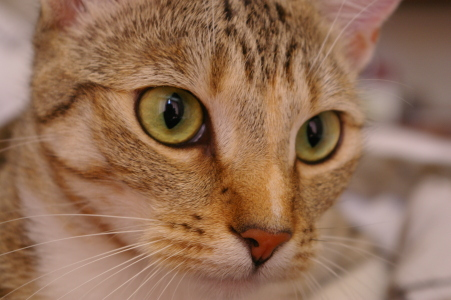

In [31]:
from io import BytesIO
from PIL import Image

image = Image.open(BytesIO(byte_arr))
image

## 認証によるアクセス制限

近年ウェブ上で利用できるサービスは、独立した認証画面を持っており、その認証画面にユーザ名とパスワードを入力することで、ユーザの個人ページや実際のサービスにアクセスが可能となるようになっている。

一方で、より簡易的なアクセス制限の仕組みとしてHTTPの規格にはBASIC認証とDigest認証という方式が用意されている。ここでは、そのそれぞれについて、`urllib`を用いた実現方法を見ていこう。

最近の若い読者は、そもそもBASIC認証の画面を見たことがないかもしれないので、まず、httpbinを使ってBASIC認証の画面にアクセスしてみる。以下のURLにアクセスを試みてほしい。

<https://httpbin.org/basic-auth/myname/mypass>

上記のURLは、ユーザ名が「myname」で、パスワードが「mypass」でアクセスできるBASIC認証を提供するので、ポップアップで現れる認証情報入力欄にこれらの情報を入力する。

```{image} ./imgs/basic_auth.jpg
:align: center
:width: 80%
:class: with-border
```

このように、見慣れない読者には一風変わったようにも見える認証で、実際にも、アプリケーション側で認証ページを用意する場合と比べると、かなり簡素な認証である。上記のhttpbinの場合は、ユーザ名とパスワードがURLに埋め込まれてしまっているが、実際にはこのようなことはなく、サーバ上に`.htaccess`や`.htpasswd`という特殊なファイルを配置することでBASIC認証やDigest認証が有効化される。

### BASIC認証

BASIC認証はbase64によるエンコードされたユーザ名とパスワードのペアをヘッダに加えて送付するという方式を取る。

具体的には、`"Basic ..."`で始まる文字列の`...`の部分に「ユーザ名」と「パスワード」をコロンでつなげた`myname:mypass`のような文字列をbase64エンコードした文字列を挿入する。

In [32]:
auth_data = "Basic " + base64.b64encode(b"myname:mypass").decode("ascii")
print(auth_data)

Basic bXluYW1lOm15cGFzcw==


この認証情報が用意できたら、これをリクエスト・ヘッダの`Authorization`の項目に追加して、これまで通りにリクエストを送付する。

In [33]:
url = "https://httpbin.org/basic-auth/myname/mypass"

headers = {
    "User-Agent": "Mozilla/5.0",
    "Accept-Charset": "utf-8",
    "Accept-Language": "ja",
    "Authorization": auth_data,
}

req = urllib.request.Request(url, headers=headers, method="GET")
try:
    with urllib.request.urlopen(req) as resp:
        print("URL :", resp.geturl())
        print("Code :", resp.getcode())
        print("Content-Type :", resp.info()["content-type"])
        body = resp.read()
except urllib.error.HTTPError as e:
    print(e)

URL : https://httpbin.org/basic-auth/myname/mypass
Code : 200
Content-Type : application/json


すると、上記のように認証が成功し、HTTPステータスコードとして200が返ってくる。

BASIC認証は非常に単純で実現も容易だが、一つ大きな問題がある。それは、パスワードが可逆エンコードであるbase64でエンコードされているという点である。そのため、通信内容がその途中に不正に読み取られた場合には、認証情報が簡単に閲覧できてしまう (このような攻撃方法をMan-in-the-Middle攻撃と呼ぶ)。

(ssec:digest-auth)=
### Digest認証

**Digest認証**はパスワードの符号化において、より不可逆エンコードであるMD5を用いる。MD5は厳密には、とある情報に対してハッシュ値を計算するアルゴリズムであり、異なるデータに対しては衝突が起きづらく、なおかつ、ほんの少しだけ違うデータであっても、全く異なるハッシュ値が割り当てられる。

そのため、中間地点で通信内容が読み取られたとしても、認証情報自体を盗まれる危険性は低い。また、Digest認証はBASIC認証のように一度のHTTPリクエストで完結する形ではなく、一度、認証に必要な情報をサーバから受け取り、その情報に認証情報を加えて処理したものをリクエスト・ヘッダに含めた上で、再度リクエストを送付する必要がある。

Digest認証をテストするためにhttpbinにおいて、auth方式 (後述)のDigest認証を備えた

<https://httpbin.org/digest-auth/auth/myname/mypass>

を用いる。

一度目のHTTPリクエストの送付においては、それほど意識することはなく、これまで通りにリクエストを送付すれば良い。

ただし、Digest認証に必要な情報が`HTTPError`例外中の`e.headers`に含まれているので、これを`err_headers`という一次変数にコピーしておく。

In [34]:
url = "https://httpbin.org/digest-auth/auth/myname/mypass"

headers = {
    "User-Agent": "Mozilla/5.0",
    "Accept-Charset": "utf-8",
    "Accept-Language": "ja",
}

req = urllib.request.Request(url, headers=headers, method="GET")
try:
    with urllib.request.urlopen(req) as resp:
        print("URL :", resp.geturl())
        print("Code :", resp.getcode())
        print("Content-Type :", resp.info()["content-type"])
        body = resp.read()
except urllib.error.HTTPError as e:
    print(e)
    err_headers = e.headers

HTTP Error 401: UNAUTHORIZED


なお、このHTTPエラーに含まれるヘッダ情報は以下のようになっている。

In [35]:
print(err_headers)

Date: Wed, 24 Apr 2024 08:01:33 GMT
Content-Type: text/html; charset=utf-8
Content-Length: 0
Connection: close
Server: gunicorn/19.9.0
WWW-Authenticate: Digest realm="me@kennethreitz.com", nonce="31b193c8118406f6589bbf53adca4e41", qop="auth", opaque="70578cd2bb63fa8331d0670e33a91759", algorithm=MD5, stale=FALSE
Set-Cookie: stale_after=never; Path=/
Set-Cookie: fake=fake_value; Path=/
Access-Control-Allow-Origin: *
Access-Control-Allow-Credentials: true




このヘッダ情報の中にある `WWW-Authenticate` の情報がDigest認証に必要な情報を含んでいる。

`realm`は認証領域を表し、サーバに関する簡単な説明情報などが渡される。`nonce`は日本語で「その場限りの」という意味で、この通信に対して割り振られたランダムな文字列である。`qop`はQuality of Protectionの略で、認証情報の形式を指定している (`auth`か`auth-int`のどちらか)。`opaque`は今回アクセスしているユーザに対して割り当てられたランダムな文字列である。`algorithm`は前述のハッシュ値を計算するためのアルゴリズムで`MD5`以外にも`SHA-256`などが指定される場合もある。最後の`stale`は`nonce`が何らかの理由 (途中で通信が切れたなど)で異なる可能性があるときに、ユーザ名とパスワードのペアが正しいことを知らせるときに`TRUE`を指定するが、特段`FALSE`で問題ない。

さて、これらの情報のうちDigest認証に含めるべき必須情報は一部だが、今回は受け取った情報を全て含む形で認証情報を作成する。

サーバから受け取った`WWW-Authenticate`の情報から正規表現を用いて、各種パラメータを抜き出しておく。

In [36]:
pat = re.compile(
    r"Digest realm=\"(?P<realm>\S+?)\", nonce=\"(?P<nonce>\S+?)\", qop=\"(?P<qop>\S+?)\", opaque=\"(?P<opaque>\S+?)\", algorithm=(?P<algorithm>\S+?), stale=(?P<stale>\S+?)"
)
match = pat.fullmatch(err_headers["WWW-Authenticate"])

Digest認証に用いる認証情報はBASIC認証以上に複雑な書式を持っている。

概要として、Digest認証では、ユーザ名やパスワードの情報に対応するハッシュ値 (以下のプログラムの`ha1`)と、通信方法等に対応するハッシュ値 (以下のプログラムの`ha2`)を生成し、それらを更に別のハッシュ値計算に用いる (以下のプログラムの`dig`)。

一つ目のハッシュ値は、ユーザ名、realm、パスワードをコロンでつなげて得た文字列から計算される。ハッシュ値の計算には、Pythonの標準ライブラリである`hashlib`を用いて、以下のような関数で計算できる。

In [37]:
import hashlib


def digest(s):
    return hashlib.md5(s.encode("ascii")).hexdigest()

二つ目のハッシュ値はURIと呼ばれる「URLのうちサーバのURL以外の部分」に対応する文字列と、通信方法である`GET` (あるいは`POST`)をコロンで結んだ文字列からハッシュ値を計算する。URIは今回の例で言えば`/digest-auth/auth/myname/mypass`の部分に対応する。

これらを踏まえて2つのハッシュ値を計算してみよう。

In [38]:
user = "myname"
passwd = "mypass"
uri = "/digest-auth/auth/myname/mypass"

ha1 = digest(f"{user}:{match['realm']}:{passwd}")
ha2 = digest(f"GET:{uri}")
print(f"hash #1: {ha1}")
print(f"hash #2: {ha2}")

hash #1: b5644b1a08eb8a13ba9e544f2bf5ac2c
hash #2: 0aaaf722394d682e4c93b0c6c7db0d3e


続いて、これら、2つのハッシュ値と合わせて、

- サーバから渡されてきた`nonce`
- その`nonce`を使ってリクエストを発行した回数を表す`nonce_count`
- クライアント側で新たに生成したnonceである`cnonce` (client nonce)
- Digest認証の方式である`auth`

という情報をコロンで結んだ文字列を再度ハッシュ化する。

今回、サーバから受け取ったnonceを用いたリクエスト発行は1回目なので、`nonce_count`は1で、これを0埋めした8桁の数字を用いる。また、`cnonce`は適当な文字列で良いのだが、今回は、Pythonの標準ライブラリである`uuid` (Universally Unique IDの略)を用いて、ユニークなIDを発行する。なお、nonceにはハイフンが使えないので、UUIDを発行後にハイフンを除去しておく。

In [39]:
import uuid

nonce_count = 1
cnonce = str(uuid.uuid4()).replace("-", "")
dig = digest(f"{ha1}:{match['nonce']}:{nonce_count:08d}:{cnonce}:auth:{ha2}")
print(f"dig: {dig}")

dig: d01728ffd24fa8a715e8c9feaf095a86


最後に得られた情報をBASIC認証の時に用いた`Basic ...`という認証文字列と同様に、一定の書式に従って文字列化する。なお、以下の書式から**外れると通信に失敗する**ので注意すること。

In [40]:
auth_data = f"Digest username=\"{user}\", realm=\"{match['realm']}\", nonce=\"{match['nonce']}\", uri=\"{uri}\", response=\"{dig}\", opaque=\"{match['opaque']}\", qop={match['qop']}, nc={nonce_count:08d}, cnonce=\"{cnonce}\""
print(auth_data)

Digest username="myname", realm="me@kennethreitz.com", nonce="31b193c8118406f6589bbf53adca4e41", uri="/digest-auth/auth/myname/mypass", response="d01728ffd24fa8a715e8c9feaf095a86", opaque="70578cd2bb63fa8331d0670e33a91759", qop=auth, nc=00000001, cnonce="6486bc0076104f1ab4e89f7805d5a251"


認証情報が用意できたら、BASIC認証の時と同様にリクエスト・ヘッダの`Authorization`の項目に、該当の文字列を加えて、これまで通りにリクエストを送付すれば良い。実際に、リクエストが上手くいくかどうかは、是非、読者自身の手で確かめて見てほしい。

さて、ここまで、非常に複雑な手続きによってDigest認証が実現されることを見てきたが、プロトコルを始め何らかの処理を実現する仕組みは、概して、一意性を失わないように複雑な形式をしていることが多い。これらの処理から、プロトコルの考え方の一端が伝われば幸いだ。

In [41]:
url = "https://httpbin.org/digest-auth/auth/myname/mypass"

headers = {
    "User-Agent": "Mozilla/5.0",
    "Accept-Charset": "utf-8",
    "Accept-Language": "ja",
    "Authorization": auth_data,
}

req = urllib.request.Request(url, headers=headers, method="GET")
err_headers = None
try:
    with urllib.request.urlopen(req) as resp:
        print("URL :", resp.geturl())
        print("Code :", resp.getcode())
        print("Content-Type :", resp.info()["content-type"])
        body = resp.read()
except urllib.error.HTTPError as e:
    print(e)

URL : https://httpbin.org/digest-auth/auth/myname/mypass
Code : 200
Content-Type : application/json


## 練習問題

```{card}
**問1**
^^^
(バイナリファイルの送信)[ssec:send-binary]に示した画像ファイルの例を、読者自身でプログラムを作成した上で実行し、送付した画像がレスポンス・ボディから正しく受け取れることを確かめよ。
```

```{card}
**問2**
^^^
(Digest認証)[ssec:digest-auth]に示したDigest認証の例を、読者自身でプログラムを作成した上で実行し、正しくHTTP通信が成立することを確かめよ。
```

## 参考: 複数のファイルを送信する

POSTメソッドでデータの種類を`multipart/form-data`とすることで、複数のファイルを同時に送信することもできる。しかし、複数ファイルの送信には、そのファイルから得られるバイト列をboundaryと呼ばれる区切り文字で結びながら、適宜、ファイル名などの情報も含めていく必要がある。

以下が、複数ファイルを実現するプログラムの一例なので、興味のある読者は一度、正しく画像が送受信できるかを試してみてほしい。

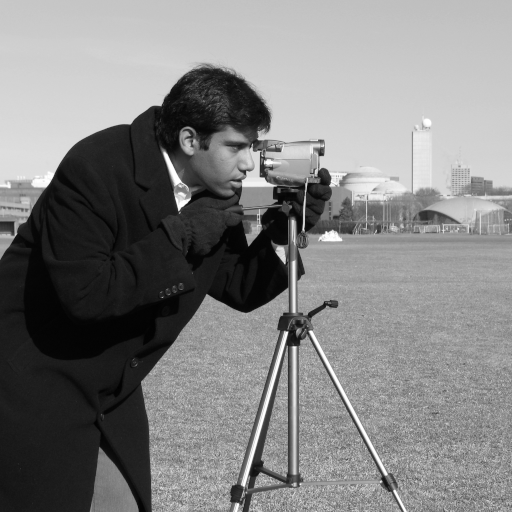

In [42]:
image1 = skimage.data.cat()
image1 = Image.fromarray(image1)
image2 = skimage.data.camera()
image2 = Image.fromarray(image2)
glue("camera", image2)

<div align="center" width="50%">

{glue:}`camera`

</div>

In [43]:
buf1 = BytesIO()
image1.save(buf1, format="PNG")
buf2 = BytesIO()
image2.save(buf2, format="PNG")

name1 = "cat.jpg"
data1 = buf1.getvalue()
name2 = "camera.jpg"
data2 = buf2.getvalue()

In [65]:
boundary = str(uuid.uuid4())
content_type = "image/png"

data = b""

lines = []
lines.append(f"--{boundary}")
lines.append(
    f'Content-Disposition: form-data; name="{name1}"; filename="urllib.parse.quote({name1})"'
)
lines.append(f"Content-Type: {content_type}")
lines.append("")
data += "\r\n".join(lines).encode("ascii")
data += "\r\n".encode("ascii")
data += data1
data += "\r\n".encode("ascii")

lines = []
lines.append(f"--{boundary}")
lines.append(
    f'Content-Disposition: form-data; name="{name2}"; filename="urllib.parse.quote({name2})"'
)
lines.append(f"Content-Type: {content_type}")
lines.append("")
data += "\r\n".join(lines).encode("ascii")
data += "\r\n".encode("ascii")
data += data2
data += "\r\n".encode("ascii")

lines = []
lines.append(f"--{boundary}--")
lines.append("")
data += "\r\n".join(lines).encode("ascii")

In [58]:
url = "https://httpbin.org/anything"

headers = {
    "User-Agent": "Mozilla/5.0",
    "Content-Type": "multipart/form-data; boundary=" + boundary,
}

req = urllib.request.Request(url, data, headers=headers, method="POST")
try:
    with urllib.request.urlopen(req) as resp:
        print("URL :", resp.geturl())
        print("Code :", resp.getcode())
        print("Content-Type :", resp.info()["content-type"])
        body = resp.read()
except urllib.error.HTTPError as e:
    print(e)

URL : https://httpbin.org/anything
Code : 200
Content-Type : application/json


In [59]:
json_data = json.loads(body.decode("utf-8"))


```json
{
  "args": {},
  "data": "",
  "files": {
    "camera.jpg": "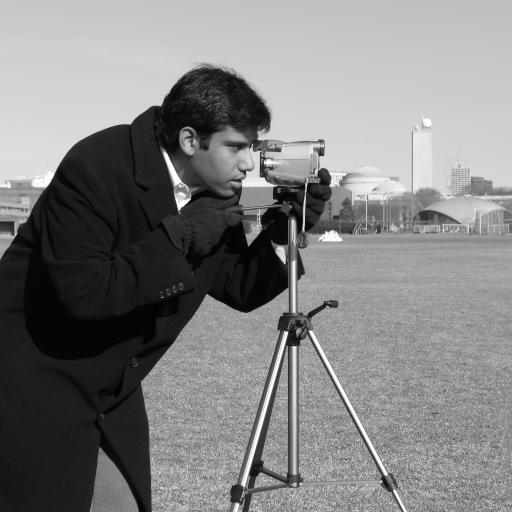",
    "cat.jpg": "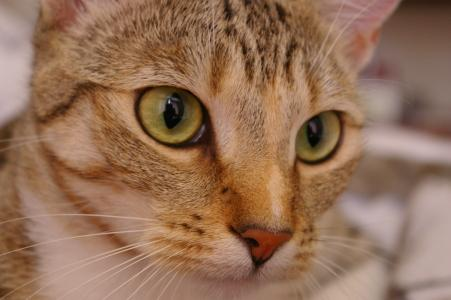"
  },
  "form": {},
  "headers": {
    "Accept-Encoding": "identity",
    "Content-Length": "55521",
    "Content-Type": "multipart/form-data; boundary=ae89467b-75bf-4a40-b2d9-70386d97d111",
    "Host": "httpbin.org",
    "User-Agent": "Mozilla/5.0",
    "X-Amzn-Trace-Id": "Root=1-6628bb53-6eb4df6c3c1813a3505188fe"
  },
  "json": null,
  "method": "POST",
  "origin": "133.46.232.29",
  "url": "https://httpbin.org/anything"
}
```


In [60]:
Markdown(
    f"""
```json
{json.dumps(json_data, indent=2):s}
```
"""
)

正しく送付に成功すると、httpbinから返ってくるレスポンス・ヘッダには`files`という項目下にファイル名とファイルのバイナリ情報に対応するbase64エンコードされたデータが返ってくる。

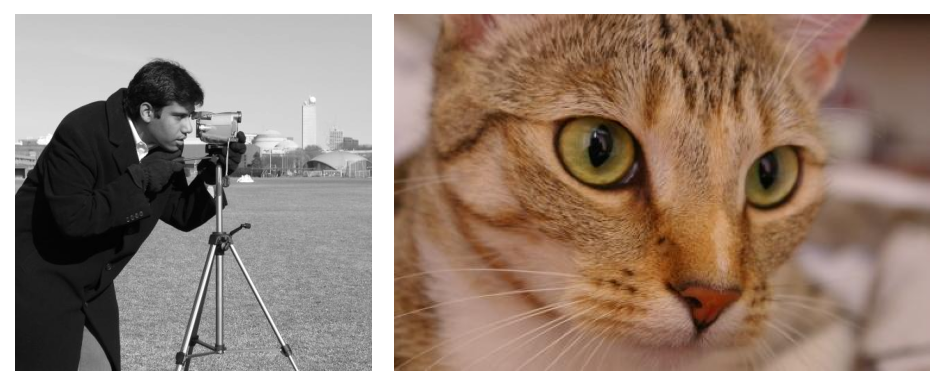

In [61]:
images = []
for name, seq in json_data["files"].items():
    b = seq.split(",")[-1]
    buffer = base64.b64decode(b)
    image = Image.open(BytesIO(buffer))
    images.append(np.array(image, dtype=np.uint8))

aspect1 = images[0].shape[1] / images[0].shape[0]
aspect2 = images[1].shape[1] / images[1].shape[0]

gs = gridspec.GridSpec(1, 2, width_ratios=[aspect1, aspect2])
fig = plt.figure(dpi=150)
ax = plt.subplot(gs[0])
ax.imshow(images[0], cmap="gray")
ax.set_axis_off()
ax = plt.subplot(gs[1])
ax.imshow(images[1], cmap="gray")
ax.set_axis_off()
fig.tight_layout()
glue("twoimages", fig)
plt.close()

## 参考文献

```{bibliography}
:labelprefix: 3-
:filter: docname in docnames
```